The `Grizli` pipeline allows you to fully reduce a given set of HST grism observations with essentially two steps:

* Run an archive query with [`hsaquery`](https://github.com/gbrammer/esa-hsaquery)

* Process the associations found with the query with `grizli.auto_script.go`.

Here, "association" usually simply means "any Hubble exposures that overlap" and doesn't require that all observations were taken with the same observing program, instrument, grism position angle, epoch, filter, etc.  The code does all of the exposure-level book-keeping and the products are drizzled image mosaics, extracted 1D and 2D grism spectra and fits to the spectra.

**NB**: The pipeline works fine with just imaging and no grism exposures!

In [1]:
#cell 1
%matplotlib inline

In [2]:
#cell 2
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import auto_script 
from grizli import utils
from grizli import fitting
from grizli import multifit #original line, replaced by cell above 

utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 Grizli version:  0.8.0-45-g977ade9


In [3]:
#cell 3
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


## Query the HST archive ##

The `hsaquery` module can be used to programaticaly query the HST archive and find exposures from different programs (and instruments) that overlap on the sky.  The example below is tailored for a single pointing from a single program, but the query parameters can be expanded to search much more broadly for archival data.

In [4]:
#cell 4
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]
parent = query.run_query(box=None, proposal_id=[12945], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=['G102','G141'])

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['F105W', 'F814W','G102'], 
                              proposal_id=[12945], instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC']) 
                              #,extra={'target_name':'CL1059-12.0'}, close=False)

Iter #1, N_Patch = 14


 0 j105908m1246 164.779 -12.773
target_name
-----------
CL1059-12.0 

filter j105908m1246         WFC3/IR F105W    1     811.7
filter j105908m1246          WFC3/IR G102    1    4711.7


 1 j105900m1253 164.747 -12.878
target_name
-----------
        ANY
CL1059-12.1 

filter j105900m1253         ACS/WFC F814W    1     460.0
filter j105900m1253         WFC3/IR F105W    1     811.7
filter j105900m1253          WFC3/IR G102    1    4711.7


 2 j105912m1254 164.794 -12.903
target_name
-----------
CL1059-12.2 

filter j105912m1254         WFC3/IR F105W    1     811.7
filter j105912m1254          WFC3/IR G102    1    4711.7


 3 j105836m1254 164.644 -12.893
target_name
-----------
CL1059-12.3 

filter j105836m1254         WFC3/IR F105W    1     811.7
filter j105836m1254          WFC3/IR G102    1    4711.7


 4 j113812m1134 174.554 -11.573
target_name
-----------
CL1138-11.0 

filter j113812m1134         WFC3/IR F105W    1     811.7
filter j113812m1134          WFC3/IR

In [5]:
#cell 5
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  []

# id            ra         dec        e(b-v)   filters
j105908m1246  164.77900  -12.77300   0.0281   F105W,G102
j105900m1253  164.74700  -12.87800   0.0273   F105W,F814W,G102
j105912m1254  164.79400  -12.90300   0.0270   F105W,G102
j105836m1254  164.64400  -12.89300   0.0291   F105W,G102
j113812m1134  174.55400  -11.57300   0.0172   F105W,G102
j113848m1134  174.70000  -11.57500   0.0174   F105W,G102
j113736m1125  174.39300  -11.42300   0.0217   F105W,G102
j122756m1136  186.98400  -11.60300   0.0409   F105W,F814W,G102
j122752m1140  186.96700  -11.66100   0.0398   F105W,G102
j122816m1132  187.07100  -11.52800   0.0433   F105W,G102
j130132m1138  195.37900  -11.62600   0.0411   F105W,F814W,G102
j130120m1133  195.34100  -11.54500   0.0415   F105W,G102
j130132m1142  195.38900  -11.69800   0.0407   F105W,F814W,G102
j130100m1131  195.24700  -11.52100   0.0405   F105W,G102


In [6]:
#cell 6
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Pipeline processing - #

** In principle, all of the steps outlined below can be executed with a single call to** `auto_script.go`, from fetching the data to extracting spectra and performing the redshift / line fits.  The processing steps been broken out individually here to show the processing at each step.

** The same pipeline can be used to process imaging-only fields.**  Simply run the queries as above to find the imaging exposures you want to processes and run everything the same way.  The pipeline steps related to the grism exposures will simply be skipped.

In [7]:
#cell 7
# Do everything for the query from fetching the data to generating the contamination model
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

"CHANGE FILE DIRECTORY HERE"
root = 'j113848m1134'
IS_PARALLEL = False # Set to True for parallel programs like WISPS

if False:
    # This line would do everything below
    auto_script.go(root=root, maglim=[19,21], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync='cp', gaia_by_date=True, is_parallel_field=IS_PARALLEL, 
                   run_fit=False, only_preprocess=True, run_extractions=False)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Individual steps - #

## Fetch data from the HST archive ##
`Grizli` can automatically fetch HST data from the ESA Hubble Science archive (and, optionally, the Amazon S3 bucket).  The `fetch_files` script fetches the exposures listed in the archive query above.  It also fetches associated WFC3/IR persistence products from the persistence database.

The first time you run the script, a lot more information will be printed to the screen as the exposures are retrieved and the script runs the reprocessing code to flatten the IR backgrounds.  Below the "skip" message simply indicate that files have already been downloaded.

In [8]:
#cell 8 THIS TAKES A LONG TIME
### Fetch data, reprocess WFC3/IR for backgrounds, fetch WFC3/IR persistence productss

# If s3_sync, then sync from the Hubble Amazon S3 bucket with awscli, 
# otherwise get from the ESA archive.
os.chdir(HOME_PATH)

import grizli.pipeline
from grizli.pipeline import auto_script
# Is awscli available and connected? 
s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
if s3_status == 0:
    s3_sync='cp'  # As of late October 2018, 's3 sync' not working with 'stpubdata'
else:
    s3_sync=False # Fetch from ESA archive
    
auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, remove_bad=True, 
                        reprocess_parallel=True, s3_sync=s3_sync)

Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists


## Parse visit associations ##
`Grizli` builds its own associations based on anything it finds in the `RAW` directory.  Visits are usually defined in the exposure filenames.  For example, for the single exposure, `ib6o03ntq_flt.fits`, the characters `b6o` identify the observing program and the visit identifier  is `03`.  You can also build visits combining all exposures in a given filter taken at the same position angle, which can be useful for some programs executed in parallel where exposures taken at a similar time could have different visit IDs in the filename.  

**NB:** Generally one should process "visits" as groups of exposures in a given filter that were taken with a single guide star acquisition.  

The parsing script also associates grism exposures with corresponding direct images, based on the visit, exposure order and exposure footprints on the sky.

In [9]:
#cell 11
# Demo combining by PA / filter.  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=True)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1138-11.1-c1b-06-122.0-F105W 4
CL1138-11.1-c1b-06-122.0-G102 4

 == Grism groups ==

ic1b-122.0-f105w 4 ic1b-122.0-g102 4


ic1b-122.0-f105w                4
ic1b-122.0-g102                 4


In [10]:
#cell 12
######################
### Parse visit associations for most normal programs
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=IS_PARALLEL)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1138-11.1-c1b-06-122.0-F105W 4
CL1138-11.1-c1b-06-122.0-G102 4

 == Grism groups ==

cl1138-11.1-c1b-06-122.0-f105w 4 cl1138-11.1-c1b-06-122.0-g102 4


cl1138-11.1-c1b-06-122.0-f105w  4
cl1138-11.1-c1b-06-122.0-g102   4


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `./RAW` to `./Prep/`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The script also runs on *imaging-only* visits, performing the background subtraction and astrometric alignment but skipping anything related to grism processing.

The `auto_script.preprocess` command below runs the processing script for the two direct/grism pairs of the ERS observations and for the overlapping imaging visits identified in the initial query.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes a few minutes to run per visit.  It only needs to be run once.

**NB** If you restart the pipeline after a previous run, it will skip preprocessing any visit where the file `{visit-product}_dr?_sci.fits` is found (i.e., the "Skip" messages below).  If you want to force reprocessing of a visit, delete that file.

In [11]:
#####################
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Alignment reference catalogs, searched in this order
catalogs = ['NSC', 'PS1','SDSS','GAIA','WISE'] 
# As of v0.8.0-8, can use the NOAO source catalog (NSC) here, which 
# is defined over much of the sky and appears to be well aligned to GAIA.  
# However, sometimes it's not clear how to apply the best quality control 
# to the NSC sources.  Here, for example, there seem to be a number of spurious 
# NSC sources that make the initial alignment RMS fairly high. 

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH, 
                       make_combined=False, catalogs=catalogs, use_visit=True)

0 cl1138-11.1-c1b-06-122.0-f105w 4 cl1138-11.1-c1b-06-122.0-g102 4
Skip cl1138-11.1-c1b-06-122.0-f105w
Skip cl1138-11.1-c1b-06-122.0-f105w
Skip cl1138-11.1-c1b-06-122.0-g102
utils.fix_flt_nan: ic1b06vcq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b06vaq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b06urq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b06uyq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b06v5q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b06uoq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b06v3q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b06uwq_flt.fits[SCI,1] NaNPixels=0


In [12]:
!ls wfc3*sci.fits # individual drizzled visits

ls: cannot access wfc3*sci.fits: No such file or directory


In [13]:
# Results of the intra-visit alignment.  
# Should be small as these are just FGS drift on a single guide star
!ls *shifts.log
print('')
!cat *shifts.log

cl1138-11.1-c1b-06-122.0-f105w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b06uoq_flt.fits'] = ['ic1b06urq_flt.fits']
# match['ic1b06uwq_flt.fits'] = ['ic1b06uyq_flt.fits']
# match['ic1b06v3q_flt.fits'] = ['ic1b06v5q_flt.fits']
# match['ic1b06vaq_flt.fits'] = ['ic1b06vcq_flt.fits']
ic1b06uoq_flt.fits  -0.000  -0.000  0.00000  1.00000    50  0.000  0.000
ic1b06uwq_flt.fits   0.004  -0.100  0.00000  1.00000    42  0.060  0.061
ic1b06v3q_flt.fits   0.064   0.034  0.00000  1.00000    41  0.035  0.051
ic1b06vaq_flt.fits   0.103  -0.056  0.00000  1.00000    43  0.053  0.050


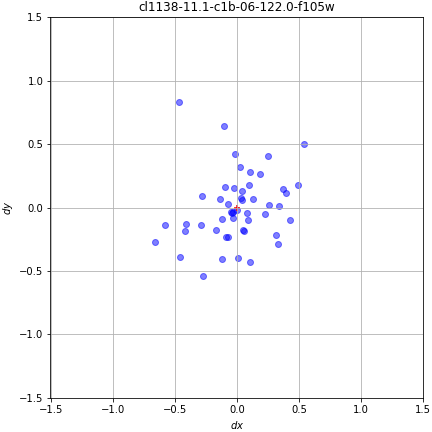

In [14]:
# Show the alignment w.r.t the external NOAO Source Catalog (NSC)
Image(filename = "./cl1138-11.1-c1b-06-122.0-f105w_wcs.png") 


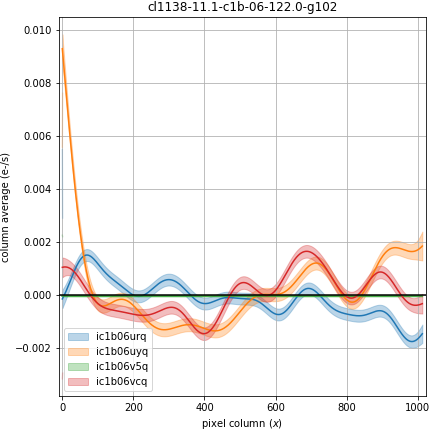

In [15]:
# Show the alignment of one HST visit to another, note tight 
# plot range compared to previous
Image(filename = "./cl1138-11.1-c1b-06-122.0-g102_column.png") 

In [16]:
# Check wcs.log files that a few objects were found, no large rotations
# and rms (second to last column) isn't too large

# Here, the F098M/G102 visit was the first processed and was aligned 
# to the NSC, with RMS~0.8 WFC3/IR pix.  Subsequent visits are aligned to 
# previously processed HST visits so that at least the relative HST astrometry
# is as good as possible.  Here, the F140W/G141 visit was run second and was 
# therefore aligned to F098M, resulting in much better precision than with the
# external catalog (RMS < 0.1 pix).

# Cat wcs.log files in order they were generated
!grep " 0 " `ls -ltr *wcs.log | awk '{print $9}'` | sed "s/  */ /g"

# columns: 
# "visit"  0  xshift yshift rot scale rms N

 0 -3.7139 -0.8988 0.0096 1.00014 0.215 50


### Alignment failures ###

The main failure mode of the `auto_script.preprocess` script is failure to compute a reliable alignment to the external reference.  This can happen, e.g., if there are not enough alignment sources (i.e., zero) within the field of view or if the original astrometry of the exposures obtained from the archive is offset from the reference by more than ~10 pixels.  This can almost always be remedied by running `grizli.pipeline.auto_script.manual_alignment` after the files have been fetched, which prompts the user to interactively mark sources in the image and reference catalog using DS9.

In [17]:
if False: # Don't run
    catalogs = ['PS1','SDSS','GAIA','WISE']
    auto_script.manual_alignment(field_root=root, HOME_PATH=HOME_PATH, skip=True, 
                                 catalogs=catalogs, radius=15, visit_list=None)

### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

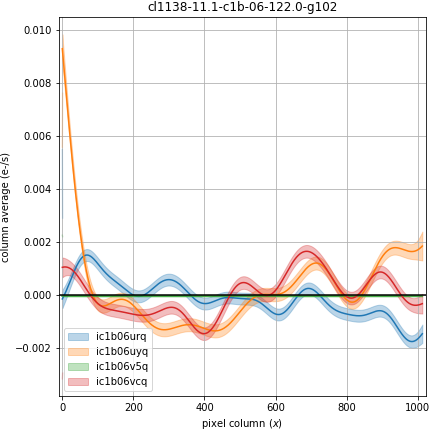

In [18]:
from IPython.display import Image
Image(filename = "./cl1138-11.1-c1b-06-122.0-g102_column.png", width=600, height=600)

### Fine alignment to GAIA DR2 ###

The initial visit alignment scripts often show small drifts such that the differen't visits don't perfectly overlap.  The script below performs an additional realignment to the visits internally and also to an external reference, usually GAIA DR2.

In [19]:
# Fine alignment of the visits relative to each other and absolute to GAIA DR2
if len(glob.glob('{0}*fine.png'.format(root))) == 0:
    fine_catalogs = ['GAIA','PS1','SDSS','WISE']
    out = auto_script.fine_alignment(field_root=root, HOME_PATH=HOME_PATH, 
                                     min_overlap=0.2, stopme=False, ref_err=0.08, 
                                     catalogs=fine_catalogs, NITER=1, maglim=[17,23],
                                     shift_only=True, method='Powell', redrizzle=False, 
                                     radius=10, program_str=None, match_str=[], 
                                     gaia_by_date=True)

    # Update headers with the result from the fine alignment
    # Original FLTs are archived to FineBkup
    auto_script.update_wcs_headers_with_fine(root)
    
visits, res = np.load('{0}_fine.npy'.format(root))
shifts = res.x.reshape((-1,2))/10.
for i, visit in enumerate(visits):
    print('{0:35}  {1:6.2f}  {2:6.2f}'.format(visit['product'], shifts[i,0], shifts[i,1]))

cl1138-11.1-c1b-06-122.0-f105w        -0.10   -0.01


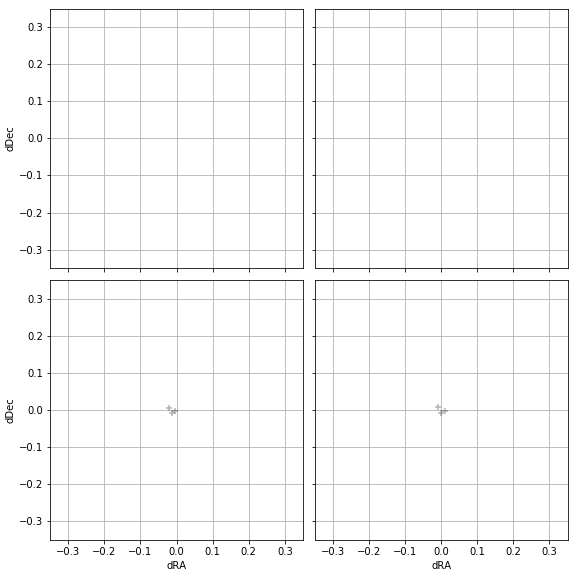

In [20]:
# Show the results of fine alignment.  
# Top panels are alignment between the visits.  + in the bottom panels are 
# residuals of the external reference, here GAIA DR2.
#
# Small drift between individual visits removed.  
# Fairly large GAIA offsets probably due to ~6 years between 
# WFC3/ERS and GAIA epoch 2015.5.
Image(filename='{0}_fine.png'.format(root))

## Make combined mosaics for each available filter ##

These are used to generate a photometric catalog and also for the direct image reference for the grism

In [21]:
# Drizzle mosaics in each filter and combine all IR filters
combine_all_filters=True
if len(glob.glob('{0}-ir_dr?_sci.fits'.format(root))) == 0:

    ## Mosaic WCS
    wcs_ref_file = '{0}_wcs-ref.fits'.format(root)
    if not os.path.exists(wcs_ref_file):
        auto_script.make_reference_wcs(info, output=wcs_ref_file, 
                           filters=['G800L', 'G102', 'G141'], 
                           pad_reference=90, pixel_scale=None,
                           get_hdu=True)

    # All combined
    IR_filters = ['F105W', 'F110W', 'F125W', 'F140W', 'F160W', 
                  'F098M', 'F139M', 'F127M', 'F153M']

    optical_filters = ['F814W', 'F606W', 'F435W', 'F850LP', 'F702W', 'F555W', 'F438W', 'F475W', 'F625W', 'F775W', 'F225W', 'F275W', 'F300W', 'F390W']

    if combine_all_filters:
        auto_script.drizzle_overlaps(root, 
                                 filters=IR_filters+optical_filters, 
                                 min_nexp=1, 
                                 make_combined=True,
                                 ref_image=wcs_ref_file,
                                 drizzle_filters=False) 

    ## IR filters
    auto_script.drizzle_overlaps(root, filters=IR_filters, 
                                 min_nexp=1, 
                                 make_combined=(not combine_all_filters),
                                 ref_image=wcs_ref_file) 

    # Fill IR filter mosaics with scaled combined data so they can be used 
    # as grism reference
    auto_script.fill_filter_mosaics(root)

    ## Optical filters

    mosaics = glob.glob('{0}-ir_dr?_sci.fits'.format(root))

    auto_script.drizzle_overlaps(root, filters=optical_filters,
        make_combined=(len(mosaics) == 0), ref_image=wcs_ref_file,
        min_nexp=2) 

In [22]:
!ls -1 j*_dr?_sci.fits

j113848m1134-f105w_drz_sci.fits
j113848m1134-ir_drz_sci.fits


## Generate a photometric catalog ##

Run source detection on the combined mosaic `{root}-ir_dr[cz]_sci.fits` and generates a catalog and segmentation image.  

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging).  In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [23]:
## Run SEP (~SExtractor clone) catalog on the "ir" combined image
## and generate a photometric catalog with aperture photometry in all available bands
if not os.path.exists('{0}_phot.fits'.format(root)):
    get_background=False # SExtractor background subtraction
    tab = auto_script.multiband_catalog(field_root=root, threshold=1.8,
                                        detection_background=get_background,
                                        photometry_background=get_background) 
    
files = glob.glob('{0}-ir*'.format(root)) + glob.glob('*phot*fits')
for file in files:
    print(file)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

j113848m1134-ir_drz_sci.fits
j113848m1134-ir.cat.fits
j113848m1134-ir_drz_wht.fits
j113848m1134-ir_bkg.fits
j113848m1134-ir_seg.fits
j113848m1134_phot.fits

Metadata

MINAREA:	5
CLEAN:	True
DEBCONT:	0.005
DEBTHRSH:	32
FILTER_TYPE:	conv
THRESHOLD:	1.8
ZP:	26.26887001774306
PLAM:	10551.047
FNU:	1.1283712e-07
FLAM:	3.0386574e-20
UJY2DN:	8.861796202091552
DRZ_FILE:	j113848m1134-ir_drz_sci.fits
WHT_FILE:	j113848m1134-ir_drz_wht.fits
GET_BACK:	False
ERR_SCALE:	0.5039271712303162
APER_0:	6.00000000000013
ASEC_0:	0.36
APER_1:	8.33500000000018
ASEC_1:	0.5001
APER_2:	16.33700000000036
ASEC_2:	0.9802200000000001
APER_3:	20.00000000000043
ASEC_3:	1.2
F105W_ZP:	26.26887001774306
F105W_PLAM:	10551.047
F105W_FNU:	1.1283712e-07
F105W_FLAM:	3.0386574e-20
F105W_uJy2dn:	8.861796202091552
F105W_DRZ_FILE:	j113848m1134-f105w_drz_sci.fits
F105W_WHT_FILE:	j113848m1134-f105w_drz_wht.fits
F105W_GET_BACK:	False
F105W_ERR_SCALE:	0.5039271712303162
F105W_aper_0:	6.00000000000013
F105W_asec_0:	0.36
F105W_aper_1:	8.

In [24]:
phot[:2].show_in_notebook()

## Building the grism exposure container: `multifit.GroupFLT` ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

The `grism_prep` script iterates on the refined polynomial model `refine_niter` times.

### Save state ###

You can optionally dump saved data (i.e., `grp.save_full_data()`) for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.  The `grism_prep` script does this automatically.

In [25]:
files = glob.glob('*GrismFLT.fits')
if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    gris_ref = {'G141': ['F140W', 'F160W'], 
                'G102': ['F105W', 'F098M', 'F110W']}

    x = auto_script.grism_prep(field_root=root, refine_niter=3,
                                 gris_ref_filters=gris_ref)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Load ic1b06v5q.01.GrismFLT.fits!
Load ic1b06uyq.01.GrismFLT.fits!
Load ic1b06urq.01.GrismFLT.fits!
Load ic1b06vcq.01.GrismFLT.fits!
Files loaded - 4.19 sec.


### The final contamination model ###

IndexError: list index out of range

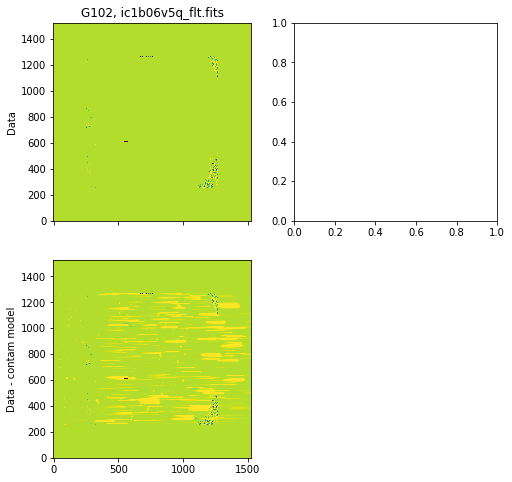

In [26]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

### Parameters for object fitting

In [36]:
h = open('/data2/jrcooper/notebooks/reduction/EDisCS/j113848m1134/Extractions/a_LDP_q.txt', 'r')
lines = h.readlines()[1:]
h.close()   
z_LDP       = []  
id_HST      = []   
ra_HST      = []
dec_HST     = [] 

for line in lines: 
    a = line.split()     
    z_LDP.append(float(a[3]))
    ra_HST.append(float(a[1]))
    dec_HST.append(float(a[2]))



z_LDP     = np.array(z_LDP)
ra_HST    = np.array(ra_HST)
dec_HST   = np.array(dec_HST)
id_HST     = np.array(id_HST) 
dec_HST

array([-11.58489781, -11.5849485 , -11.58276122, -11.58112867,
       -11.57941066, -11.5770086 , -11.57042875, -11.56334981,
       -11.56279236, -11.56165904, -11.55877942])

In [37]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
#print(pline) 

sig = 0.007 
z = np.arange(0,2,.001)
for i in z_LDP:
    p_z = np.exp(-(z - i)**2/(2*sig**2))/((2*np.pi)**0.5/sig)

spec_prior = [z,p_z]
tuple
a = tuple(spec_prior)

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=a, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')


Saved arguments to fit_args.npy.


### Field PSF file ### 
Make an average effective PSF for each available IR filter by evaluating the field-dependent PSF across the final mosaic and drizzling to a common output.  Also make an extension with a PSF on the pixel grid of the drizzled line map parameters generated above (`pline`).  Each PSF is generated with the native pixel grid and 2/4x oversampling for use with, e.g., [GALFIT](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html).

*NB* There is currently no ePSF for F098M, so F105W is used (http://www.stsci.edu/~jayander/STDPSFs/WFC3IR/).


In [38]:
# Make PSF file
if not os.path.exists('{0}-f105w_psf.fits'.format(root)):
    auto_script.field_psf(root=root, HOME_PATH=HOME_PATH)

 
j113848m1134 LINE1  / 0.100" / pixf: 0.2 / point    / f105w
j113848m1134 LINE2  / 0.050" / pixf: 0.2 / point    / f105w
j113848m1134 LINE4  / 0.025" / pixf: 0.2 / point    / f105w
j113848m1134 DRIZ1  / 0.060" / pixf: 0.6 / square   / f105w
j113848m1134 DRIZ2  / 0.030" / pixf: 0.6 / square   / f105w
j113848m1134 DRIZ4  / 0.015" / pixf: 0.6 / square   / f105w


['j113848m1134-f105w_psf.fits'] 

Filename: j113848m1134-f105w_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  PSF         LINE1 ImageHDU        29   (60, 60)   float32   
  2  PSF         LINE2 ImageHDU        29   (120, 120)   float32   
  3  PSF         LINE4 ImageHDU        29   (240, 240)   float32   
  4  PSF         DRIZ1 ImageHDU        29   (100, 100)   float32   
  5  PSF         DRIZ2 ImageHDU        29   (200, 200)   float32   
  6  PSF         DRIZ4 ImageHDU        29   (400, 400)   float32   


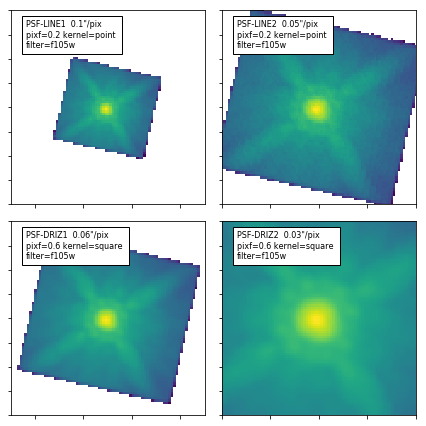

In [39]:
# Show the PSFs
print(glob.glob('*psf.fits'),'\n')

im = pyfits.open('{0}-f105w_psf.fits'.format(root))
im.info()

fig = plt.figure(figsize=[6,6])
for i, ext in enumerate([1,2,4,5]):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(np.log10(im[ext].data))
    
    h = im[ext].header
    label = '{0}-{1}  {2}"/pix \npixf={3} kernel={4} \nfilter={5}'.format(h['EXTNAME'],
                     h['EXTVER'], h['PSCALE'], h['PIXFRAC'], h['KERNEL'], h['FILTER'])
    
    ax.text(0.08, 0.95, label, ha='left', va='top', 
            transform=ax.transAxes, size=8, color='k',
            bbox={'fc':'w'})
    
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    sh = im[ext].data.shape
    ax.set_xlim(sh[1]/2-40, sh[1]/2+40)
    ax.set_ylim(sh[0]/2-40, sh[0]/2+40)
    
fig.tight_layout(pad=1)

## Extract and fit individual spectra ##

In [40]:
os.chdir('../Extractions')

In [41]:
### Find IDs of specific objects to extract
import grizli.pipeline
from grizli.pipeline import auto_script
import astropy.units as u
tab = utils.GTable()
tab['ra'] = ra_HST
tab['dec'] = dec_HST
idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

In [42]:
for id_i in source_ids:
    auto_script.extract(field_root=root, prior=a, MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                           grp=grp, diff=True)

0/122: 120 0
1/122: 374 4
j113848m1134_00374.beams.fits
2/122: 255 3
j113848m1134_00255.beams.fits
3/122: 261 3
j113848m1134_00261.beams.fits
4/122: 349 0
5/122: 211 2
j113848m1134_00211.beams.fits
6/122: 258 2
j113848m1134_00258.beams.fits
7/122: 377 2
j113848m1134_00377.beams.fits
8/122: 430 2
j113848m1134_00430.beams.fits
9/122: 282 0
10/122: 423 2
j113848m1134_00423.beams.fits
11/122: 160 2
j113848m1134_00160.beams.fits
12/122: 199 0
13/122: 193 2
j113848m1134_00193.beams.fits
14/122: 246 0
15/122: 4 2
j113848m1134_00004.beams.fits
16/122: 363 2
j113848m1134_00363.beams.fits
17/122: 425 2
j113848m1134_00425.beams.fits
18/122: 64 2
j113848m1134_00064.beams.fits
19/122: 227 0
20/122: 43 2
j113848m1134_00043.beams.fits
21/122: 266 0
22/122: 356 2
j113848m1134_00356.beams.fits
23/122: 355 2
j113848m1134_00355.beams.fits
24/122: 175 2
j113848m1134_00175.beams.fits
25/122: 76 2
j113848m1134_00076.beams.fits
26/122: 126 2
j113848m1134_00126.beams.fits
27/122: 47 2
j113848m1134_00047.beams

  0.4848   16696.3 (0.2402) 76/341
  0.4908   16775.8 (0.2402) 77/341
  0.4968   16782.4 (0.2402) 78/341
  0.5028   16662.6 (0.2402) 79/341
  0.5088   16674.8 (0.2402) 80/341
  0.5148   16719.9 (0.2402) 81/341
  0.5209   16683.2 (0.2402) 82/341
  0.5270   16573.4 (0.2402) 83/341
  0.5331   16496.9 (0.2402) 84/341
  0.5393   16438.2 (0.2402) 85/341
  0.5454   16329.7 (0.2402) 86/341
  0.5516   16344.1 (0.2402) 87/341
  0.5579   16372.7 (0.2402) 88/341
  0.5641   16300.8 (0.2402) 89/341
  0.5704   16206.9 (0.2402) 90/341
  0.5767   16182.9 (0.2402) 91/341
  0.5830   16198.1 (0.2402) 92/341
  0.5893   16164.4 (0.2402) 93/341
  0.5957   16161.9 (0.2402) 94/341
  0.6021   16170.3 (0.2402) 95/341
  0.6085   16073.4 (0.6085) 96/341
  0.6150   15990.9 (0.6150) 97/341
  0.6214   15978.7 (0.6214) 98/341
  0.6279   15986.3 (0.6214) 99/341
  0.6345   15971.3 (0.6345) 100/341
  0.6410   15944.7 (0.6410) 101/341
  0.6476   15900.6 (0.6476) 102/341
  0.6542   15806.0 (0.6542) 103/341
  0.6608   15889

  2.1497   16146.1 (0.6542) 264/341
  2.1623   16154.7 (0.6542) 265/341
  2.1750   16183.4 (0.6542) 266/341
  2.1877   16245.9 (0.6542) 267/341
  2.2005   16265.8 (0.6542) 268/341
  2.2133   16270.9 (0.6542) 269/341
  2.2262   16245.5 (0.6542) 270/341
  2.2391   16225.8 (0.6542) 271/341
  2.2521   16239.0 (0.6542) 272/341
  2.2652   16278.3 (0.6542) 273/341
  2.2783   16317.0 (0.6542) 274/341
  2.2914   16302.5 (0.6542) 275/341
  2.3046   16293.6 (0.6542) 276/341
  2.3178   16347.6 (0.6542) 277/341
  2.3311   16385.0 (0.6542) 278/341
  2.3445   16406.6 (0.6542) 279/341
  2.3579   16413.1 (0.6542) 280/341
  2.3713   16429.0 (0.6542) 281/341
  2.3849   16431.0 (0.6542) 282/341
  2.3984   16389.8 (0.6542) 283/341
  2.4120   16394.1 (0.6542) 284/341
  2.4257   16442.8 (0.6542) 285/341
  2.4394   16438.6 (0.6542) 286/341
  2.4532   16401.0 (0.6542) 287/341
  2.4671   16345.9 (0.6542) 288/341
  2.4810   16322.3 (0.6542) 289/341
  2.4949   16303.6 (0.6542) 290/341
  2.5089   16294.5 (0.6542) 

  0.5088   15702.1 (0.2552) 80/341
  0.5148   15704.9 (0.2552) 81/341
  0.5209   15689.3 (0.2552) 82/341
  0.5270   15669.0 (0.2552) 83/341
  0.5331   15687.6 (0.2552) 84/341
  0.5393   15736.2 (0.2552) 85/341
  0.5454   15758.9 (0.2552) 86/341
  0.5516   15770.2 (0.2552) 87/341
  0.5579   15773.3 (0.2552) 88/341
  0.5641   15745.6 (0.2552) 89/341
  0.5704   15770.8 (0.2552) 90/341
  0.5767   15783.3 (0.2552) 91/341
  0.5830   15758.4 (0.2552) 92/341
  0.5893   15753.5 (0.2552) 93/341
  0.5957   15764.4 (0.2552) 94/341
  0.6021   15758.1 (0.2552) 95/341
  0.6085   15717.3 (0.2552) 96/341
  0.6150   15682.4 (0.2552) 97/341
  0.6214   15698.7 (0.2552) 98/341
  0.6279   15718.1 (0.2552) 99/341
  0.6345   15750.5 (0.2552) 100/341
  0.6410   15778.4 (0.2552) 101/341
  0.6476   15794.7 (0.2552) 102/341
  0.6542   15824.4 (0.2552) 103/341
  0.6608   15833.6 (0.2552) 104/341
  0.6675   15845.2 (0.2552) 105/341
  0.6742   15854.9 (0.2552) 106/341
  0.6809   15838.7 (0.2552) 107/341
  0.6876   1

  2.2005   15775.6 (0.2552) 268/341
  2.2133   15781.2 (0.2552) 269/341
  2.2262   15790.5 (0.2552) 270/341
  2.2391   15797.7 (0.2552) 271/341
  2.2521   15804.1 (0.2552) 272/341
  2.2652   15810.6 (0.2552) 273/341
  2.2783   15814.1 (0.2552) 274/341
  2.2914   15817.2 (0.2552) 275/341
  2.3046   15822.7 (0.2552) 276/341
  2.3178   15832.4 (0.2552) 277/341
  2.3311   15844.4 (0.2552) 278/341
  2.3445   15856.0 (0.2552) 279/341
  2.3579   15857.3 (0.2552) 280/341
  2.3713   15886.3 (0.2552) 281/341
  2.3849   15913.3 (0.2552) 282/341
  2.3984   15925.7 (0.2552) 283/341
  2.4120   15923.7 (0.2552) 284/341
  2.4257   15924.3 (0.2552) 285/341
  2.4394   15928.7 (0.2552) 286/341
  2.4532   15934.6 (0.2552) 287/341
  2.4671   15926.6 (0.2552) 288/341
  2.4810   15905.7 (0.2552) 289/341
  2.4949   15887.9 (0.2552) 290/341
  2.5089   15859.8 (0.2552) 291/341
  2.5230   15818.3 (0.2552) 292/341
  2.5371   15785.4 (0.2552) 293/341
  2.5513   15787.6 (0.2552) 294/341
  2.5655   15786.7 (0.2552) 

  0.5270   13674.7 (0.2806) 83/341
  0.5331   13676.0 (0.2806) 84/341
  0.5393   13687.1 (0.2806) 85/341
  0.5454   13699.5 (0.2806) 86/341
  0.5516   13691.5 (0.2806) 87/341
  0.5579   13702.1 (0.2806) 88/341
  0.5641   13709.4 (0.2806) 89/341
  0.5704   13697.6 (0.2806) 90/341
  0.5767   13669.1 (0.2806) 91/341
  0.5830   13694.0 (0.2806) 92/341
  0.5893   13701.8 (0.2806) 93/341
  0.5957   13718.8 (0.2806) 94/341
  0.6021   13717.3 (0.2806) 95/341
  0.6085   13728.3 (0.2806) 96/341
  0.6150   13724.0 (0.2806) 97/341
  0.6214   13712.6 (0.2806) 98/341
  0.6279   13708.0 (0.2806) 99/341
  0.6345   13704.9 (0.2806) 100/341
  0.6410   13717.9 (0.2806) 101/341
  0.6476   13713.9 (0.2806) 102/341
  0.6542   13713.8 (0.2806) 103/341
  0.6608   13721.1 (0.2806) 104/341
  0.6675   13730.9 (0.2806) 105/341
  0.6742   13735.8 (0.2806) 106/341
  0.6809   13744.1 (0.2806) 107/341
  0.6876   13753.2 (0.2806) 108/341
  0.6944   13756.0 (0.2806) 109/341
  0.7012   13754.5 (0.2806) 110/341
  0.7080 

  2.2914   13727.6 (2.0627) 275/341
  2.3046   13738.6 (2.0627) 276/341
  2.3178   13737.7 (2.0627) 277/341
  2.3311   13737.3 (2.0627) 278/341
  2.3445   13750.8 (2.0627) 279/341
  2.3579   13760.9 (2.0627) 280/341
  2.3713   13764.8 (2.0627) 281/341
  2.3849   13777.0 (2.0627) 282/341
  2.3984   13787.6 (2.0627) 283/341
  2.4120   13794.3 (2.0627) 284/341
  2.4257   13788.4 (2.0627) 285/341
  2.4394   13789.3 (2.0627) 286/341
  2.4532   13801.6 (2.0627) 287/341
  2.4671   13803.2 (2.0627) 288/341
  2.4810   13792.1 (2.0627) 289/341
  2.4949   13787.6 (2.0627) 290/341
  2.5089   13784.2 (2.0627) 291/341
  2.5230   13787.0 (2.0627) 292/341
  2.5371   13769.1 (2.0627) 293/341
  2.5513   13753.8 (2.0627) 294/341
  2.5655   13739.9 (2.0627) 295/341
  2.5798   13722.3 (2.0627) 296/341
  2.5942   13705.2 (2.0627) 297/341
  2.6086   13687.8 (2.0627) 298/341
  2.6230   13701.5 (2.0627) 299/341
  2.6375   13703.3 (2.0627) 300/341
  2.6521   13707.7 (2.0627) 301/341
  2.6668   13716.3 (2.0627) 

  0.6214    6964.4 (0.5331) 98/341
  0.6279    6984.9 (0.5331) 99/341
  0.6345    6983.3 (0.5331) 100/341
  0.6410    6976.9 (0.5331) 101/341
  0.6476    7000.8 (0.5331) 102/341
  0.6542    7010.0 (0.5331) 103/341
  0.6608    7004.9 (0.5331) 104/341
  0.6675    7009.5 (0.5331) 105/341
  0.6742    7001.2 (0.5331) 106/341
  0.6809    6992.4 (0.5331) 107/341
  0.6876    7003.6 (0.5331) 108/341
  0.6944    7002.2 (0.5331) 109/341
  0.7012    7012.3 (0.5331) 110/341
  0.7080    7017.1 (0.5331) 111/341
  0.7148    7003.6 (0.5331) 112/341
  0.7217    7001.7 (0.5331) 113/341
  0.7286    7001.0 (0.5331) 114/341
  0.7355    6975.0 (0.5331) 115/341
  0.7425    6997.1 (0.5331) 116/341
  0.7495    7024.5 (0.5331) 117/341
  0.7565    7038.2 (0.5331) 118/341
  0.7635    7035.3 (0.5331) 119/341
  0.7706    7011.6 (0.5331) 120/341
  0.7777    7017.9 (0.5331) 121/341
  0.7848    7031.3 (0.5331) 122/341
  0.7920    7045.4 (0.5331) 123/341
  0.7991    7084.8 (0.5331) 124/341
  0.8064    7103.5 (0.5331) 12

  2.4671    7052.1 (0.5331) 288/341
  2.4810    7047.1 (0.5331) 289/341
  2.4949    7042.7 (0.5331) 290/341
  2.5089    7041.4 (0.5331) 291/341
  2.5230    7041.4 (0.5331) 292/341
  2.5371    7040.2 (0.5331) 293/341
  2.5513    7042.4 (0.5331) 294/341
  2.5655    7033.0 (0.5331) 295/341
  2.5798    7025.9 (0.5331) 296/341
  2.5942    7017.7 (0.5331) 297/341
  2.6086    7016.7 (0.5331) 298/341
  2.6230    7031.8 (0.5331) 299/341
  2.6375    7029.4 (0.5331) 300/341
  2.6521    7019.7 (0.5331) 301/341
  2.6668    7014.8 (0.5331) 302/341
  2.6815    7015.7 (0.5331) 303/341
  2.6962    7008.1 (0.5331) 304/341
  2.7110    6994.8 (0.5331) 305/341
  2.7259    6992.4 (0.5331) 306/341
  2.7408    6984.8 (0.5331) 307/341
  2.7558    6990.6 (0.5331) 308/341
  2.7709    6992.6 (0.5331) 309/341
  2.7860    6977.2 (0.5331) 310/341
  2.8012    6971.9 (0.5331) 311/341
  2.8164    6968.4 (0.5331) 312/341
  2.8317    6970.7 (0.5331) 313/341
  2.8471    6981.7 (0.5331) 314/341
  2.8625    7001.7 (0.5331) 

  0.6675    5208.6 (0.4908) 105/341
  0.6742    5207.6 (0.4908) 106/341
  0.6809    5204.7 (0.4908) 107/341
  0.6876    5202.1 (0.4908) 108/341
  0.6944    5199.7 (0.4908) 109/341
  0.7012    5195.9 (0.4908) 110/341
  0.7080    5196.4 (0.4908) 111/341
  0.7148    5196.9 (0.4908) 112/341
  0.7217    5200.6 (0.4908) 113/341
  0.7286    5210.4 (0.4908) 114/341
  0.7355    5217.5 (0.4908) 115/341
  0.7425    5221.0 (0.4908) 116/341
  0.7495    5224.8 (0.4908) 117/341
  0.7565    5227.1 (0.4908) 118/341
  0.7635    5226.5 (0.4908) 119/341
  0.7706    5229.4 (0.4908) 120/341
  0.7777    5229.0 (0.4908) 121/341
  0.7848    5227.1 (0.4908) 122/341
  0.7920    5224.3 (0.4908) 123/341
  0.7991    5220.3 (0.4908) 124/341
  0.8064    5219.1 (0.4908) 125/341
  0.8136    5220.5 (0.4908) 126/341
  0.8209    5219.6 (0.4908) 127/341
  0.8282    5222.4 (0.4908) 128/341
  0.8355    5227.6 (0.4908) 129/341
  0.8428    5228.8 (0.4908) 130/341
  0.8502    5229.1 (0.4908) 131/341
  0.8576    5229.6 (0.4908) 

  2.5230    5241.8 (0.4908) 292/341
  2.5371    5240.9 (0.4908) 293/341
  2.5513    5238.7 (0.4908) 294/341
  2.5655    5234.8 (0.4908) 295/341
  2.5798    5229.7 (0.4908) 296/341
  2.5942    5224.6 (0.4908) 297/341
  2.6086    5219.4 (0.4908) 298/341
  2.6230    5213.1 (0.4908) 299/341
  2.6375    5206.6 (0.4908) 300/341
  2.6521    5201.3 (0.4908) 301/341
  2.6668    5198.5 (0.4908) 302/341
  2.6815    5195.7 (0.4908) 303/341
  2.6962    5194.1 (0.4908) 304/341
  2.7110    5193.5 (0.4908) 305/341
  2.7259    5193.3 (0.4908) 306/341
  2.7408    5194.0 (0.4908) 307/341
  2.7558    5195.1 (0.4908) 308/341
  2.7709    5197.3 (0.4908) 309/341
  2.7860    5199.9 (0.4908) 310/341
  2.8012    5204.2 (0.4908) 311/341
  2.8164    5208.9 (0.4908) 312/341
  2.8317    5213.6 (0.4908) 313/341
  2.8471    5218.3 (0.4908) 314/341
  2.8625    5222.1 (0.4908) 315/341
  2.8780    5226.0 (0.4908) 316/341
  2.8935    5229.5 (0.4908) 317/341
  2.9091    5232.9 (0.4908) 318/341
  2.9248    5235.4 (0.4908) 

  0.4613    4489.3 (0.3064) 72/341
  0.4671    4477.1 (0.3064) 73/341
  0.4730    4453.6 (0.4730) 74/341
  0.4789    4430.2 (0.4789) 75/341
  0.4848    4404.2 (0.4848) 76/341
  0.4908    4365.2 (0.4908) 77/341
  0.4968    4357.3 (0.4968) 78/341
  0.5028    4392.3 (0.4968) 79/341
  0.5088    4430.5 (0.4968) 80/341
  0.5148    4460.8 (0.4968) 81/341
  0.5209    4478.5 (0.4968) 82/341
  0.5270    4484.0 (0.4968) 83/341
  0.5331    4488.1 (0.4968) 84/341
  0.5393    4487.8 (0.4968) 85/341
  0.5454    4486.6 (0.4968) 86/341
  0.5516    4486.3 (0.4968) 87/341
  0.5579    4486.6 (0.4968) 88/341
  0.5641    4486.7 (0.4968) 89/341
  0.5704    4486.0 (0.4968) 90/341
  0.5767    4484.7 (0.4968) 91/341
  0.5830    4485.7 (0.4968) 92/341
  0.5893    4485.9 (0.4968) 93/341
  0.5957    4483.6 (0.4968) 94/341
  0.6021    4481.5 (0.4968) 95/341
  0.6085    4478.8 (0.4968) 96/341
  0.6150    4475.8 (0.4968) 97/341
  0.6214    4473.5 (0.4968) 98/341
  0.6279    4474.4 (0.4968) 99/341
  0.6345    4477.2 (

  2.1371    4486.7 (0.4968) 263/341
  2.1497    4485.0 (0.4968) 264/341
  2.1623    4483.3 (0.4968) 265/341
  2.1750    4481.7 (0.4968) 266/341
  2.1877    4479.5 (0.4968) 267/341
  2.2005    4477.0 (0.4968) 268/341
  2.2133    4475.7 (0.4968) 269/341
  2.2262    4476.6 (0.4968) 270/341
  2.2391    4477.8 (0.4968) 271/341
  2.2521    4477.4 (0.4968) 272/341
  2.2652    4477.0 (0.4968) 273/341
  2.2783    4478.2 (0.4968) 274/341
  2.2914    4480.0 (0.4968) 275/341
  2.3046    4478.9 (0.4968) 276/341
  2.3178    4477.7 (0.4968) 277/341
  2.3311    4478.3 (0.4968) 278/341
  2.3445    4480.0 (0.4968) 279/341
  2.3579    4482.7 (0.4968) 280/341
  2.3713    4485.4 (0.4968) 281/341
  2.3849    4488.4 (0.4968) 282/341
  2.3984    4490.4 (0.4968) 283/341
  2.4120    4491.8 (0.4968) 284/341
  2.4257    4493.7 (0.4968) 285/341
  2.4394    4496.5 (0.4968) 286/341
  2.4532    4499.9 (0.4968) 287/341
  2.4671    4502.6 (0.4968) 288/341
  2.4810    4504.9 (0.4968) 289/341
  2.4949    4508.0 (0.4968) 

  0.5641    3184.7 (0.3707) 89/341
  0.5704    3181.4 (0.3707) 90/341
  0.5767    3181.9 (0.3707) 91/341
  0.5830    3185.7 (0.3707) 92/341
  0.5893    3189.6 (0.3707) 93/341
  0.5957    3193.0 (0.3707) 94/341
  0.6021    3196.8 (0.3707) 95/341
  0.6085    3200.9 (0.3707) 96/341
  0.6150    3202.2 (0.3707) 97/341
  0.6214    3199.4 (0.3707) 98/341
  0.6279    3186.5 (0.3707) 99/341
  0.6345    3167.2 (0.3707) 100/341
  0.6410    3157.5 (0.3707) 101/341
  0.6476    3152.6 (0.3707) 102/341
  0.6542    3157.0 (0.3707) 103/341
  0.6608    3161.7 (0.3707) 104/341
  0.6675    3160.5 (0.3707) 105/341
  0.6742    3162.1 (0.3707) 106/341
  0.6809    3174.2 (0.3707) 107/341
  0.6876    3186.5 (0.3707) 108/341
  0.6944    3192.3 (0.3707) 109/341
  0.7012    3195.0 (0.3707) 110/341
  0.7080    3199.4 (0.3707) 111/341
  0.7148    3200.2 (0.3707) 112/341
  0.7217    3197.3 (0.3707) 113/341
  0.7286    3193.2 (0.3707) 114/341
  0.7355    3191.2 (0.3707) 115/341
  0.7425    3190.5 (0.3707) 116/341
  0

  2.3445    3145.7 (1.6840) 279/341
  2.3579    3155.5 (1.6840) 280/341
  2.3713    3164.8 (1.6840) 281/341
  2.3849    3174.2 (1.6840) 282/341
  2.3984    3181.2 (1.6840) 283/341
  2.4120    3183.6 (1.6840) 284/341
  2.4257    3183.4 (1.6840) 285/341
  2.4394    3181.5 (1.6840) 286/341
  2.4532    3177.9 (1.6840) 287/341
  2.4671    3171.8 (1.6840) 288/341
  2.4810    3162.1 (1.6840) 289/341
  2.4949    3148.9 (1.6840) 290/341
  2.5089    3138.1 (1.6840) 291/341
  2.5230    3134.1 (1.6840) 292/341
  2.5371    3134.2 (1.6840) 293/341
  2.5513    3133.5 (1.6840) 294/341
  2.5655    3135.4 (1.6840) 295/341
  2.5798    3142.2 (1.6840) 296/341
  2.5942    3150.2 (1.6840) 297/341
  2.6086    3154.4 (1.6840) 298/341
  2.6230    3159.2 (1.6840) 299/341
  2.6375    3167.4 (1.6840) 300/341
  2.6521    3173.2 (1.6840) 301/341
  2.6668    3173.9 (1.6840) 302/341
  2.6815    3171.7 (1.6840) 303/341
  2.6962    3173.5 (1.6840) 304/341
  2.7110    3180.2 (1.6840) 305/341
  2.7259    3187.0 (1.6840) 

  0.2502    9529.4 (0.2502) 33/341
  0.2552    9525.8 (0.2552) 34/341
  0.2603    9525.1 (0.2603) 35/341
  0.2653    9522.8 (0.2653) 36/341
  0.2704    9517.3 (0.2704) 37/341
  0.2755    9508.5 (0.2755) 38/341
  0.2806    9500.1 (0.2806) 39/341
  0.2857    9493.4 (0.2857) 40/341
  0.2909    9487.5 (0.2909) 41/341
  0.2960    9485.6 (0.2960) 42/341
  0.3012    9486.2 (0.2960) 43/341
  0.3064    9488.9 (0.2960) 44/341
  0.3117    9503.7 (0.2960) 45/341
  0.3169    9518.4 (0.2960) 46/341
  0.3222    9528.7 (0.2960) 47/341
  0.3275    9538.5 (0.2960) 48/341
  0.3328    9545.9 (0.2960) 49/341
  0.3382    9549.2 (0.2960) 50/341
  0.3435    9549.1 (0.2960) 51/341
  0.3489    9546.3 (0.2960) 52/341
  0.3543    9541.6 (0.2960) 53/341
  0.3598    9538.3 (0.2960) 54/341
  0.3652    9535.4 (0.2960) 55/341
  0.3707    9531.1 (0.2960) 56/341
  0.3762    9524.7 (0.2960) 57/341
  0.3817    9519.3 (0.2960) 58/341
  0.3872    9514.8 (0.2960) 59/341
  0.3928    9511.0 (0.2960) 60/341
  0.3984    9509.5 (

  1.6733    9709.2 (0.7355) 223/341
  1.6840    9701.6 (0.7355) 224/341
  1.6948    9682.5 (0.7355) 225/341
  1.7056    9677.7 (0.7355) 226/341
  1.7164    9680.6 (0.7355) 227/341
  1.7273    9685.0 (0.7355) 228/341
  1.7382    9695.0 (0.7355) 229/341
  1.7492    9702.2 (0.7355) 230/341
  1.7602    9708.9 (0.7355) 231/341
  1.7713    9719.6 (0.7355) 232/341
  1.7824    9697.2 (0.7355) 233/341
  1.7935    9672.0 (0.7355) 234/341
  1.8047    9669.6 (0.7355) 235/341
  1.8160    9658.0 (0.7355) 236/341
  1.8273    9656.3 (0.7355) 237/341
  1.8386    9646.7 (0.7355) 238/341
  1.8500    9632.5 (0.7355) 239/341
  1.8614    9625.6 (0.7355) 240/341
  1.8729    9623.5 (0.7355) 241/341
  1.8844    9595.3 (0.7355) 242/341
  1.8959    9577.8 (0.7355) 243/341
  1.9075    9562.2 (0.7355) 244/341
  1.9192    9554.9 (0.7355) 245/341
  1.9309    9548.3 (0.7355) 246/341
  1.9426    9539.0 (0.7355) 247/341
  1.9544    9529.7 (0.7355) 248/341
  1.9663    9523.7 (0.7355) 249/341
  1.9782    9525.1 (0.7355) 

- 2.9322    9486.4 (0.7359) 75/99
- 2.9327    9486.4 (0.7359) 76/99
- 2.9332    9486.4 (0.7359) 77/99
- 2.9337    9486.4 (0.7359) 78/99
- 2.9342    9486.3 (0.7359) 79/99
- 2.9347    9486.3 (0.7359) 80/99
- 2.9352    9486.3 (0.7359) 81/99
- 2.9357    9486.3 (0.7359) 82/99
- 2.9362    9486.3 (0.7359) 83/99
- 2.9367    9486.2 (0.7359) 84/99
- 2.9372    9486.2 (0.7359) 85/99
- 2.9377    9486.2 (0.7359) 86/99
- 2.9382    9486.2 (0.7359) 87/99
- 2.9387    9486.2 (0.7359) 88/99
- 2.9392    9486.2 (0.7359) 89/99
- 2.9397    9486.2 (0.7359) 90/99
- 2.9402    9486.2 (0.7359) 91/99
- 2.9407    9486.2 (0.7359) 92/99
- 2.9412    9486.2 (0.7359) 93/99
- 2.9417    9486.2 (0.7359) 94/99
- 2.9422    9486.2 (0.7359) 95/99
- 2.9427    9486.2 (0.7359) 96/99
- 2.9432    9486.2 (0.7359) 97/99
- 2.9437    9486.2 (0.7359) 98/99
- 2.9442    9486.2 (0.7359) 99/99
Get linemap PSF: F105W
11/122: 160
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    3573.6 (0.1000) 1/341
  0.10

  1.1887    3575.6 (1.0695) 173/341
  1.1975    3576.6 (1.0695) 174/341
  1.2063    3575.8 (1.0695) 175/341
  1.2151    3576.2 (1.0695) 176/341
  1.2240    3573.1 (1.0695) 177/341
  1.2329    3571.9 (1.0695) 178/341
  1.2419    3571.8 (1.0695) 179/341
  1.2509    3572.9 (1.0695) 180/341
  1.2599    3574.1 (1.0695) 181/341
  1.2689    3578.2 (1.0695) 182/341
  1.2780    3579.0 (1.0695) 183/341
  1.2872    3578.5 (1.0695) 184/341
  1.2963    3579.5 (1.0695) 185/341
  1.3055    3581.3 (1.0695) 186/341
  1.3148    3582.7 (1.0695) 187/341
  1.3240    3585.8 (1.0695) 188/341
  1.3334    3587.9 (1.0695) 189/341
  1.3427    3592.1 (1.0695) 190/341
  1.3521    3593.7 (1.0695) 191/341
  1.3615    3594.3 (1.0695) 192/341
  1.3710    3596.0 (1.0695) 193/341
  1.3805    3597.8 (1.0695) 194/341
  1.3900    3599.0 (1.0695) 195/341
  1.3996    3598.0 (1.0695) 196/341
  1.4092    3595.6 (1.0695) 197/341
  1.4189    3595.2 (1.0695) 198/341
  1.4286    3594.6 (1.0695) 199/341
  1.4383    3591.4 (1.0695) 

- 0.1491    3559.6 (0.1426) 28/264
- 0.1496    3559.8 (0.1426) 29/264
- 0.1501    3559.9 (0.1426) 30/264
- 0.1506    3560.0 (0.1426) 31/264
- 0.1511    3560.2 (0.1426) 32/264
- 0.1516    3560.5 (0.1426) 33/264
- 0.3792    3563.3 (0.1426) 34/264
- 0.3797    3563.4 (0.1426) 35/264
- 0.3802    3563.5 (0.1426) 36/264
- 0.3807    3563.5 (0.1426) 37/264
- 0.3812    3563.6 (0.1426) 38/264
- 0.3817    3563.5 (0.1426) 39/264
- 0.3822    3563.5 (0.1426) 40/264
- 0.3827    3563.5 (0.1426) 41/264
- 0.3832    3563.4 (0.1426) 42/264
- 0.3837    3563.4 (0.1426) 43/264
- 0.3842    3563.4 (0.1426) 44/264
- 0.3847    3563.4 (0.1426) 45/264
- 0.3852    3563.4 (0.1426) 46/264
- 0.3857    3563.4 (0.1426) 47/264
- 0.3862    3563.4 (0.1426) 48/264
- 0.3867    3563.3 (0.1426) 49/264
- 0.3872    3563.3 (0.1426) 50/264
- 0.3877    3563.3 (0.1426) 51/264
- 0.3882    3563.3 (0.1426) 52/264
- 0.3887    3563.2 (0.1426) 53/264
- 0.3892    3563.2 (0.1426) 54/264
- 0.3897    3563.3 (0.1426) 55/264
- 0.3902    3563.3 (

- 2.9170    3561.0 (1.0694) 219/264
- 2.9175    3561.0 (1.0694) 220/264
- 2.9180    3561.0 (1.0694) 221/264
- 2.9185    3561.0 (1.0694) 222/264
- 2.9190    3561.0 (1.0694) 223/264
- 2.9195    3561.0 (1.0694) 224/264
- 2.9200    3561.0 (1.0694) 225/264
- 2.9205    3561.0 (1.0694) 226/264
- 2.9210    3561.0 (1.0694) 227/264
- 2.9215    3561.0 (1.0694) 228/264
- 2.9220    3561.0 (1.0694) 229/264
- 2.9225    3561.0 (1.0694) 230/264
- 2.9230    3561.0 (1.0694) 231/264
- 3.2099    3559.1 (1.0694) 232/264
- 3.2104    3559.1 (1.0694) 233/264
- 3.2109    3559.0 (1.0694) 234/264
- 3.2114    3559.0 (1.0694) 235/264
- 3.2119    3559.0 (1.0694) 236/264
- 3.2124    3559.0 (1.0694) 237/264
- 3.2129    3558.9 (1.0694) 238/264
- 3.2134    3558.9 (1.0694) 239/264
- 3.2139    3558.9 (1.0694) 240/264
- 3.2144    3558.9 (1.0694) 241/264
- 3.2149    3558.9 (1.0694) 242/264
- 3.2154    3558.9 (1.0694) 243/264
- 3.2159    3558.9 (1.0694) 244/264
- 3.2164    3558.9 (1.0694) 245/264
- 3.2169    3558.9 (1.0694) 

  0.9104    3758.6 (0.6279) 139/341
  0.9181    3759.0 (0.6279) 140/341
  0.9257    3759.0 (0.6279) 141/341
  0.9335    3760.2 (0.6279) 142/341
  0.9412    3757.4 (0.6279) 143/341
  0.9490    3755.5 (0.6279) 144/341
  0.9568    3757.4 (0.6279) 145/341
  0.9646    3759.4 (0.6279) 146/341
  0.9725    3758.0 (0.6279) 147/341
  0.9804    3758.2 (0.6279) 148/341
  0.9884    3756.3 (0.6279) 149/341
  0.9963    3757.6 (0.6279) 150/341
  1.0043    3755.1 (0.6279) 151/341
  1.0124    3754.4 (0.6279) 152/341
  1.0204    3755.8 (0.6279) 153/341
  1.0285    3754.6 (0.6279) 154/341
  1.0367    3755.6 (0.6279) 155/341
  1.0448    3758.0 (0.6279) 156/341
  1.0530    3762.0 (0.6279) 157/341
  1.0612    3762.4 (0.6279) 158/341
  1.0695    3760.4 (0.6279) 159/341
  1.0778    3758.0 (0.6279) 160/341
  1.0861    3765.1 (0.6279) 161/341
  1.0945    3770.5 (0.6279) 162/341
  1.1029    3771.6 (0.6279) 163/341
  1.1113    3770.5 (0.6279) 164/341
  1.1198    3767.3 (0.6279) 165/341
  1.1283    3748.3 (0.6279) 

  3.0686    3754.6 (0.6279) 328/341
  3.0850    3754.2 (0.6279) 329/341
  3.1013    3754.2 (0.6279) 330/341
  3.1178    3753.8 (0.6279) 331/341
  3.1343    3755.1 (0.6279) 332/341
  3.1508    3757.2 (0.6279) 333/341
  3.1675    3760.4 (0.6279) 334/341
  3.1842    3765.2 (0.6279) 335/341
  3.2009    3768.3 (0.6279) 336/341
  3.2178    3768.3 (0.6279) 337/341
  3.2347    3767.7 (0.6279) 338/341
  3.2517    3767.7 (0.6279) 339/341
  3.2687    3769.0 (0.6279) 340/341
  3.2858    3771.8 (0.6279) 341/341
First iteration: z_best=0.6279

- 0.6204    3741.6 (0.6204) 1/33
- 0.6209    3740.1 (0.6209) 2/33
- 0.6214    3738.3 (0.6214) 3/33
- 0.6219    3736.5 (0.6219) 4/33
- 0.6224    3734.6 (0.6224) 5/33
- 0.6229    3732.8 (0.6229) 6/33
- 0.6234    3731.1 (0.6234) 7/33
- 0.6239    3729.5 (0.6239) 8/33
- 0.6244    3728.0 (0.6244) 9/33
- 0.6249    3726.6 (0.6249) 10/33
- 0.6254    3725.1 (0.6254) 11/33
- 0.6259    3723.7 (0.6259) 12/33
- 0.6264    3722.4 (0.6264) 13/33
- 0.6269    3721.3 (0.6269) 14/

  1.0204    1771.1 (0.4789) 153/341
  1.0285    1769.1 (0.4789) 154/341
  1.0367    1775.8 (0.4789) 155/341
  1.0448    1799.4 (0.4789) 156/341
  1.0530    1803.0 (0.4789) 157/341
  1.0612    1809.3 (0.4789) 158/341
  1.0695    1810.9 (0.4789) 159/341
  1.0778    1812.4 (0.4789) 160/341
  1.0861    1819.5 (0.4789) 161/341
  1.0945    1798.1 (0.4789) 162/341
  1.1029    1803.4 (0.4789) 163/341
  1.1113    1811.1 (0.4789) 164/341
  1.1198    1810.4 (0.4789) 165/341
  1.1283    1809.1 (0.4789) 166/341
  1.1368    1819.9 (0.4789) 167/341
  1.1454    1832.2 (0.4789) 168/341
  1.1540    1837.9 (0.4789) 169/341
  1.1626    1849.8 (0.4789) 170/341
  1.1713    1852.8 (0.4789) 171/341
  1.1800    1864.4 (0.4789) 172/341
  1.1887    1862.1 (0.4789) 173/341
  1.1975    1865.8 (0.4789) 174/341
  1.2063    1878.2 (0.4789) 175/341
  1.2151    1886.2 (0.4789) 176/341
  1.2240    1882.6 (0.4789) 177/341
  1.2329    1923.3 (0.4789) 178/341
  1.2419    1913.5 (0.4789) 179/341
  1.2509    1924.5 (0.4789) 

- 2.0117    1685.7 (2.0112) 11/33
- 2.0122    1685.9 (2.0112) 12/33
- 2.0127    1686.2 (2.0112) 13/33
- 2.0132    1686.4 (2.0112) 14/33
- 2.0137    1686.6 (2.0112) 15/33
- 2.0142    1686.7 (2.0112) 16/33
- 2.0147    1686.7 (2.0112) 17/33
- 2.0152    1686.7 (2.0112) 18/33
- 2.0157    1686.7 (2.0112) 19/33
- 2.0162    1686.8 (2.0112) 20/33
- 2.0167    1686.9 (2.0112) 21/33
- 2.0172    1687.1 (2.0112) 22/33
- 2.0177    1687.5 (2.0112) 23/33
- 2.0182    1688.0 (2.0112) 24/33
- 2.0187    1688.7 (2.0112) 25/33
- 2.0192    1689.6 (2.0112) 26/33
- 2.0197    1690.4 (2.0112) 27/33
- 2.0202    1691.3 (2.0112) 28/33
- 2.0207    1692.1 (2.0112) 29/33
- 2.0212    1692.9 (2.0112) 30/33
- 2.0217    1693.7 (2.0112) 31/33
- 2.0222    1694.3 (2.0112) 32/33
- 2.0227    1694.8 (2.0112) 33/33
Drizzle line -> OII  (2.63 1.45)
Drizzle line -> MgII (2.89 5.14)
Get linemap PSF: F105W
16/122: 363
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    4530.4 (0.1000) 1/341
  0.1044

  1.1800    4521.0 (0.3543) 172/341
  1.1887    4524.3 (0.3543) 173/341
  1.1975    4523.4 (0.3543) 174/341
  1.2063    4526.4 (0.3543) 175/341
  1.2151    4529.5 (0.3543) 176/341
  1.2240    4520.2 (0.3543) 177/341
  1.2329    4530.2 (0.3543) 178/341
  1.2419    4534.3 (0.3543) 179/341
  1.2509    4526.9 (0.3543) 180/341
  1.2599    4527.4 (0.3543) 181/341
  1.2689    4523.0 (0.3543) 182/341
  1.2780    4526.8 (0.3543) 183/341
  1.2872    4538.0 (0.3543) 184/341
  1.2963    4532.8 (0.3543) 185/341
  1.3055    4527.9 (0.3543) 186/341
  1.3148    4544.8 (0.3543) 187/341
  1.3240    4545.3 (0.3543) 188/341
  1.3334    4548.3 (0.3543) 189/341
  1.3427    4545.7 (0.3543) 190/341
  1.3521    4534.1 (0.3543) 191/341
  1.3615    4534.1 (0.3543) 192/341
  1.3710    4540.3 (0.3543) 193/341
  1.3805    4515.3 (0.3543) 194/341
  1.3900    4502.2 (0.3543) 195/341
  1.3996    4549.1 (0.3543) 196/341
  1.4092    4560.0 (0.3543) 197/341
  1.4189    4560.8 (0.3543) 198/341
  1.4286    4556.4 (0.3543) 

- 0.3590    4491.7 (0.3565) 23/33
- 0.3595    4495.4 (0.3565) 24/33
- 0.3600    4499.2 (0.3565) 25/33
- 0.3605    4503.1 (0.3565) 26/33
- 0.3610    4506.9 (0.3565) 27/33
- 0.3615    4510.3 (0.3565) 28/33
- 0.3620    4513.3 (0.3565) 29/33
- 0.3625    4516.1 (0.3565) 30/33
- 0.3630    4518.7 (0.3565) 31/33
- 0.3635    4521.0 (0.3565) 32/33
- 0.3640    4522.9 (0.3565) 33/33
Drizzle line -> SII  (19.45 5.41)
Drizzle line -> Ha   (40.69 5.67)
Get linemap PSF: F105W
17/122: 425
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    3511.6 (0.1000) 1/341
  0.1044    3512.3 (0.1000) 2/341
  0.1088    3504.8 (0.1088) 3/341
  0.1133    3505.0 (0.1088) 4/341
  0.1177    3513.9 (0.1088) 5/341
  0.1222    3516.3 (0.1088) 6/341
  0.1267    3518.7 (0.1088) 7/341
  0.1312    3518.1 (0.1088) 8/341
  0.1358    3517.0 (0.1088) 9/341
  0.1403    3517.9 (0.1088) 10/341
  0.1449    3520.5 (0.1088) 11/341
  0.1495    3518.1 (0.1088) 12/341
  0.1541    3516.4 (0.1088) 13/341
  

  1.2509    3519.7 (1.1368) 180/341
  1.2599    3522.9 (1.1368) 181/341
  1.2689    3524.8 (1.1368) 182/341
  1.2780    3526.4 (1.1368) 183/341
  1.2872    3526.7 (1.1368) 184/341
  1.2963    3529.1 (1.1368) 185/341
  1.3055    3526.5 (1.1368) 186/341
  1.3148    3522.1 (1.1368) 187/341
  1.3240    3523.2 (1.1368) 188/341
  1.3334    3523.1 (1.1368) 189/341
  1.3427    3524.1 (1.1368) 190/341
  1.3521    3515.9 (1.1368) 191/341
  1.3615    3518.4 (1.1368) 192/341
  1.3710    3528.2 (1.1368) 193/341
  1.3805    3525.1 (1.1368) 194/341
  1.3900    3516.2 (1.1368) 195/341
  1.3996    3514.8 (1.1368) 196/341
  1.4092    3515.5 (1.1368) 197/341
  1.4189    3519.0 (1.1368) 198/341
  1.4286    3520.7 (1.1368) 199/341
  1.4383    3527.3 (1.1368) 200/341
  1.4481    3527.9 (1.1368) 201/341
  1.4579    3526.7 (1.1368) 202/341
  1.4678    3521.4 (1.1368) 203/341
  1.4776    3516.9 (1.1368) 204/341
  1.4876    3510.8 (1.1368) 205/341
  1.4975    3516.9 (1.1368) 206/341
  1.5076    3513.7 (1.1368) 

- 0.1160    3511.3 (0.1110) 27/297
- 0.1165    3512.2 (0.1110) 28/297
- 0.1170    3513.0 (0.1110) 29/297
- 0.1175    3513.6 (0.1110) 30/297
- 0.1180    3514.1 (0.1110) 31/297
- 0.1185    3514.4 (0.1110) 32/297
- 0.1190    3514.7 (0.1110) 33/297
- 0.2871    3506.3 (0.1110) 34/297
- 0.2876    3506.2 (0.1110) 35/297
- 0.2881    3506.0 (0.1110) 36/297
- 0.2886    3505.7 (0.1110) 37/297
- 0.2891    3505.5 (0.1110) 38/297
- 0.2896    3505.4 (0.1110) 39/297
- 0.2901    3505.3 (0.1110) 40/297
- 0.2906    3505.1 (0.1110) 41/297
- 0.2911    3504.9 (0.1110) 42/297
- 0.2916    3504.7 (0.1110) 43/297
- 0.2921    3504.6 (0.1110) 44/297
- 0.2926    3504.6 (0.1110) 45/297
- 0.2931    3504.6 (0.1110) 46/297
- 0.2936    3504.6 (0.1110) 47/297
- 0.2941    3504.6 (0.1110) 48/297
- 0.2946    3504.5 (0.1110) 49/297
- 0.2951    3504.4 (0.1110) 50/297
- 0.2956    3504.3 (0.1110) 51/297
- 0.2961    3504.2 (0.1110) 52/297
- 0.2966    3504.2 (0.1110) 53/297
- 0.2971    3504.2 (0.1110) 54/297
- 0.2976    3504.2 (

- 1.5284    3504.2 (1.5239) 224/297
- 1.5289    3504.6 (1.5239) 225/297
- 1.5294    3505.0 (1.5239) 226/297
- 1.5299    3505.5 (1.5239) 227/297
- 1.5304    3506.1 (1.5239) 228/297
- 1.5309    3506.6 (1.5239) 229/297
- 1.5314    3507.1 (1.5239) 230/297
- 1.5319    3507.6 (1.5239) 231/297
- 2.3310    3509.6 (1.5239) 232/297
- 2.3315    3509.4 (1.5239) 233/297
- 2.3320    3509.3 (1.5239) 234/297
- 2.3325    3509.2 (1.5239) 235/297
- 2.3330    3509.1 (1.5239) 236/297
- 2.3335    3508.9 (1.5239) 237/297
- 2.3340    3508.8 (1.5239) 238/297
- 2.3345    3508.7 (1.5239) 239/297
- 2.3350    3508.6 (1.5239) 240/297
- 2.3355    3508.5 (1.5239) 241/297
- 2.3360    3508.5 (1.5239) 242/297
- 2.3365    3508.4 (1.5239) 243/297
- 2.3370    3508.3 (1.5239) 244/297
- 2.3375    3508.3 (1.5239) 245/297
- 2.3380    3508.2 (1.5239) 246/297
- 2.3385    3508.2 (1.5239) 247/297
- 2.3390    3508.2 (1.5239) 248/297
- 2.3395    3508.2 (1.5239) 249/297
- 2.3400    3508.2 (1.5239) 250/297
- 2.3405    3508.2 (1.5239) 

  0.7991    1321.9 (0.3012) 124/341
  0.8064    1314.7 (0.3012) 125/341
  0.8136    1310.9 (0.3012) 126/341
  0.8209    1315.9 (0.3012) 127/341
  0.8282    1320.2 (0.3012) 128/341
  0.8355    1319.2 (0.3012) 129/341
  0.8428    1324.4 (0.3012) 130/341
  0.8502    1326.5 (0.3012) 131/341
  0.8576    1325.8 (0.3012) 132/341
  0.8651    1319.0 (0.3012) 133/341
  0.8726    1316.2 (0.3012) 134/341
  0.8801    1320.4 (0.3012) 135/341
  0.8876    1316.3 (0.3012) 136/341
  0.8952    1314.3 (0.3012) 137/341
  0.9028    1331.7 (0.3012) 138/341
  0.9104    1336.1 (0.3012) 139/341
  0.9181    1331.6 (0.3012) 140/341
  0.9257    1330.3 (0.3012) 141/341
  0.9335    1331.3 (0.3012) 142/341
  0.9412    1344.6 (0.3012) 143/341
  0.9490    1342.8 (0.3012) 144/341
  0.9568    1325.9 (0.3012) 145/341
  0.9646    1323.5 (0.3012) 146/341
  0.9725    1321.6 (0.3012) 147/341
  0.9804    1318.2 (0.3012) 148/341
  0.9884    1319.4 (0.3012) 149/341
  0.9963    1322.7 (0.3012) 150/341
  1.0043    1326.6 (0.3012) 

  2.8317    1301.7 (0.3012) 313/341
  2.8471    1303.5 (0.3012) 314/341
  2.8625    1309.4 (0.3012) 315/341
  2.8780    1312.7 (0.3012) 316/341
  2.8935    1310.4 (0.3012) 317/341
  2.9091    1304.0 (0.3012) 318/341
  2.9248    1308.3 (0.3012) 319/341
  2.9405    1312.8 (0.3012) 320/341
  2.9563    1308.6 (0.3012) 321/341
  2.9722    1310.3 (0.3012) 322/341
  2.9881    1319.3 (0.3012) 323/341
  3.0041    1322.5 (0.3012) 324/341
  3.0201    1315.3 (0.3012) 325/341
  3.0362    1310.7 (0.3012) 326/341
  3.0524    1319.8 (0.3012) 327/341
  3.0686    1330.0 (0.3012) 328/341
  3.0850    1330.3 (0.3012) 329/341
  3.1013    1325.2 (0.3012) 330/341
  3.1178    1328.0 (0.3012) 331/341
  3.1343    1330.2 (0.3012) 332/341
  3.1508    1327.3 (0.3012) 333/341
  3.1675    1328.9 (0.3012) 334/341
  3.1842    1333.0 (0.3012) 335/341
  3.2009    1338.6 (0.3012) 336/341
  3.2178    1337.5 (0.3012) 337/341
  3.2347    1337.8 (0.3012) 338/341
  3.2517    1342.4 (0.3012) 339/341
  3.2687    1336.6 (0.3012) 

- 2.1182    1304.0 (0.3006) 165/231
- 2.2817    1302.6 (0.3006) 166/231
- 2.2822    1302.4 (0.3006) 167/231
- 2.2827    1302.2 (0.3006) 168/231
- 2.2832    1302.1 (0.3006) 169/231
- 2.2837    1301.9 (0.3006) 170/231
- 2.2842    1301.8 (0.3006) 171/231
- 2.2847    1301.6 (0.3006) 172/231
- 2.2852    1301.5 (0.3006) 173/231
- 2.2857    1301.3 (0.3006) 174/231
- 2.2862    1301.2 (0.3006) 175/231
- 2.2867    1301.1 (0.3006) 176/231
- 2.2872    1301.0 (0.3006) 177/231
- 2.2877    1300.9 (0.3006) 178/231
- 2.2882    1300.8 (0.3006) 179/231
- 2.2887    1300.8 (0.3006) 180/231
- 2.2892    1300.7 (0.3006) 181/231
- 2.2897    1300.7 (0.3006) 182/231
- 2.2902    1300.7 (0.3006) 183/231
- 2.2907    1300.7 (0.3006) 184/231
- 2.2912    1300.7 (0.3006) 185/231
- 2.2917    1300.7 (0.3006) 186/231
- 2.2922    1300.7 (0.3006) 187/231
- 2.2927    1300.8 (0.3006) 188/231
- 2.2932    1300.9 (0.3006) 189/231
- 2.2937    1301.0 (0.3006) 190/231
- 2.2942    1301.1 (0.3006) 191/231
- 2.2947    1301.2 (0.3006) 

  0.7991    3234.4 (0.7286) 124/341
  0.8064    3234.3 (0.7286) 125/341
  0.8136    3234.5 (0.7286) 126/341
  0.8209    3234.2 (0.7286) 127/341
  0.8282    3233.8 (0.7286) 128/341
  0.8355    3232.4 (0.7286) 129/341
  0.8428    3230.0 (0.7286) 130/341
  0.8502    3228.1 (0.7286) 131/341
  0.8576    3227.2 (0.7286) 132/341
  0.8651    3228.6 (0.7286) 133/341
  0.8726    3230.4 (0.7286) 134/341
  0.8801    3231.9 (0.7286) 135/341
  0.8876    3232.3 (0.7286) 136/341
  0.8952    3232.0 (0.7286) 137/341
  0.9028    3233.2 (0.7286) 138/341
  0.9104    3232.0 (0.7286) 139/341
  0.9181    3230.1 (0.7286) 140/341
  0.9257    3231.5 (0.7286) 141/341
  0.9335    3232.6 (0.7286) 142/341
  0.9412    3232.3 (0.7286) 143/341
  0.9490    3232.2 (0.7286) 144/341
  0.9568    3232.0 (0.7286) 145/341
  0.9646    3232.0 (0.7286) 146/341
  0.9725    3232.2 (0.7286) 147/341
  0.9804    3231.5 (0.7286) 148/341
  0.9884    3230.2 (0.7286) 149/341
  0.9963    3228.9 (0.7286) 150/341
  1.0043    3229.2 (0.7286) 

  2.8012    3232.5 (1.2689) 311/341
  2.8164    3232.2 (1.2689) 312/341
  2.8317    3231.8 (1.2689) 313/341
  2.8471    3231.2 (1.2689) 314/341
  2.8625    3230.9 (1.2689) 315/341
  2.8780    3230.2 (1.2689) 316/341
  2.8935    3230.0 (1.2689) 317/341
  2.9091    3231.0 (1.2689) 318/341
  2.9248    3233.0 (1.2689) 319/341
  2.9405    3234.9 (1.2689) 320/341
  2.9563    3235.8 (1.2689) 321/341
  2.9722    3236.6 (1.2689) 322/341
  2.9881    3237.4 (1.2689) 323/341
  3.0041    3238.3 (1.2689) 324/341
  3.0201    3238.7 (1.2689) 325/341
  3.0362    3238.9 (1.2689) 326/341
  3.0524    3239.4 (1.2689) 327/341
  3.0686    3240.1 (1.2689) 328/341
  3.0850    3240.4 (1.2689) 329/341
  3.1013    3240.5 (1.2689) 330/341
  3.1178    3240.7 (1.2689) 331/341
  3.1343    3240.3 (1.2689) 332/341
  3.1508    3238.9 (1.2689) 333/341
  3.1675    3237.1 (1.2689) 334/341
  3.1842    3235.6 (1.2689) 335/341
  3.2009    3234.5 (1.2689) 336/341
  3.2178    3233.3 (1.2689) 337/341
  3.2347    3231.8 (1.2689) 

- 0.5308    3226.7 (0.2740) 160/495
- 0.5313    3226.9 (0.2740) 161/495
- 0.5318    3227.0 (0.2740) 162/495
- 0.5323    3227.1 (0.2740) 163/495
- 0.5328    3227.2 (0.2740) 164/495
- 0.5333    3227.3 (0.2740) 165/495
- 0.6537    3227.8 (0.2740) 166/495
- 0.6542    3227.7 (0.2740) 167/495
- 0.6547    3227.7 (0.2740) 168/495
- 0.6552    3227.6 (0.2740) 169/495
- 0.6557    3227.5 (0.2740) 170/495
- 0.6562    3227.5 (0.2740) 171/495
- 0.6567    3227.5 (0.2740) 172/495
- 0.6572    3227.5 (0.2740) 173/495
- 0.6577    3227.5 (0.2740) 174/495
- 0.6582    3227.4 (0.2740) 175/495
- 0.6587    3227.4 (0.2740) 176/495
- 0.6592    3227.3 (0.2740) 177/495
- 0.6597    3227.3 (0.2740) 178/495
- 0.6602    3227.2 (0.2740) 179/495
- 0.6607    3227.2 (0.2740) 180/495
- 0.6612    3227.2 (0.2740) 181/495
- 0.6617    3227.3 (0.2740) 182/495
- 0.6622    3227.3 (0.2740) 183/495
- 0.6627    3227.3 (0.2740) 184/495
- 0.6632    3227.3 (0.2740) 185/495
- 0.6637    3227.3 (0.2740) 186/495
- 0.6642    3227.2 (0.2740) 

- 1.2697    3222.2 (1.2697) 351/495
- 1.2702    3222.2 (1.2702) 352/495
- 1.2707    3222.1 (1.2707) 353/495
- 1.2712    3222.1 (1.2712) 354/495
- 1.2717    3222.1 (1.2717) 355/495
- 1.2722    3222.0 (1.2722) 356/495
- 1.2727    3222.1 (1.2722) 357/495
- 1.2732    3222.1 (1.2722) 358/495
- 1.2737    3222.2 (1.2722) 359/495
- 1.2742    3222.3 (1.2722) 360/495
- 1.2747    3222.4 (1.2722) 361/495
- 1.2752    3222.6 (1.2722) 362/495
- 1.2757    3222.7 (1.2722) 363/495
- 1.3588    3230.1 (1.2722) 364/495
- 1.3593    3230.1 (1.2722) 365/495
- 1.3598    3230.1 (1.2722) 366/495
- 1.3603    3230.1 (1.2722) 367/495
- 1.3608    3230.1 (1.2722) 368/495
- 1.3613    3230.1 (1.2722) 369/495
- 1.3618    3230.0 (1.2722) 370/495
- 1.3623    3230.0 (1.2722) 371/495
- 1.3628    3230.0 (1.2722) 372/495
- 1.3633    3229.9 (1.2722) 373/495
- 1.3638    3229.9 (1.2722) 374/495
- 1.3643    3229.8 (1.2722) 375/495
- 1.3648    3229.8 (1.2722) 376/495
- 1.3653    3229.7 (1.2722) 377/495
- 1.3658    3229.7 (1.2722) 

  0.2806    6194.6 (0.2157) 39/341
  0.2857    6194.4 (0.2157) 40/341
  0.2909    6193.7 (0.2157) 41/341
  0.2960    6193.0 (0.2157) 42/341
  0.3012    6192.3 (0.2157) 43/341
  0.3064    6191.6 (0.2157) 44/341
  0.3117    6191.1 (0.2157) 45/341
  0.3169    6192.3 (0.2157) 46/341
  0.3222    6194.1 (0.2157) 47/341
  0.3275    6196.7 (0.2157) 48/341
  0.3328    6199.4 (0.2157) 49/341
  0.3382    6201.6 (0.2157) 50/341
  0.3435    6203.5 (0.2157) 51/341
  0.3489    6205.3 (0.2157) 52/341
  0.3543    6207.1 (0.2157) 53/341
  0.3598    6208.4 (0.2157) 54/341
  0.3652    6207.7 (0.2157) 55/341
  0.3707    6205.5 (0.2157) 56/341
  0.3762    6200.4 (0.2157) 57/341
  0.3817    6192.5 (0.2157) 58/341
  0.3872    6183.7 (0.2157) 59/341
  0.3928    6178.3 (0.3928) 60/341
  0.3984    6178.2 (0.3984) 61/341
  0.4040    6180.6 (0.3984) 62/341
  0.4096    6186.1 (0.3984) 63/341
  0.4153    6195.6 (0.3984) 64/341
  0.4209    6202.4 (0.3984) 65/341
  0.4266    6206.1 (0.3984) 66/341
  0.4323    6206.2 (

  1.7824    6352.5 (1.4481) 233/341
  1.7935    6359.0 (1.4481) 234/341
  1.8047    6362.8 (1.4481) 235/341
  1.8160    6362.2 (1.4481) 236/341
  1.8273    6358.4 (1.4481) 237/341
  1.8386    6348.7 (1.4481) 238/341
  1.8500    6336.0 (1.4481) 239/341
  1.8614    6320.5 (1.4481) 240/341
  1.8729    6309.7 (1.4481) 241/341
  1.8844    6301.0 (1.4481) 242/341
  1.8959    6297.1 (1.4481) 243/341
  1.9075    6287.7 (1.4481) 244/341
  1.9192    6279.0 (1.4481) 245/341
  1.9309    6267.4 (1.4481) 246/341
  1.9426    6256.9 (1.4481) 247/341
  1.9544    6246.5 (1.4481) 248/341
  1.9663    6239.0 (1.4481) 249/341
  1.9782    6234.2 (1.4481) 250/341
  1.9901    6230.7 (1.4481) 251/341
  2.0021    6226.2 (1.4481) 252/341
  2.0141    6219.4 (1.4481) 253/341
  2.0262    6213.1 (1.4481) 254/341
  2.0383    6203.4 (1.4481) 255/341
  2.0505    6193.8 (1.4481) 256/341
  2.0627    6187.4 (1.4481) 257/341
  2.0750    6184.0 (1.4481) 258/341
  2.0873    6182.1 (1.4481) 259/341
  2.0997    6180.7 (1.4481) 

  0.1587    2532.5 (0.1000) 14/341
  0.1634    2531.4 (0.1000) 15/341
  0.1680    2531.1 (0.1000) 16/341
  0.1727    2527.0 (0.1727) 17/341
  0.1774    2520.2 (0.1774) 18/341
  0.1821    2520.1 (0.1821) 19/341
  0.1869    2526.4 (0.1821) 20/341
  0.1916    2523.9 (0.1821) 21/341
  0.1964    2525.1 (0.1821) 22/341
  0.2012    2526.0 (0.1821) 23/341
  0.2060    2526.7 (0.1821) 24/341
  0.2108    2528.4 (0.1821) 25/341
  0.2157    2527.6 (0.1821) 26/341
  0.2206    2529.1 (0.1821) 27/341
  0.2255    2530.4 (0.1821) 28/341
  0.2304    2530.8 (0.1821) 29/341
  0.2353    2530.2 (0.1821) 30/341
  0.2402    2529.3 (0.1821) 31/341
  0.2452    2530.5 (0.1821) 32/341
  0.2502    2529.8 (0.1821) 33/341
  0.2552    2529.8 (0.1821) 34/341
  0.2603    2532.4 (0.1821) 35/341
  0.2653    2530.6 (0.1821) 36/341
  0.2704    2528.8 (0.1821) 37/341
  0.2755    2527.6 (0.1821) 38/341
  0.2806    2528.8 (0.1821) 39/341
  0.2857    2529.5 (0.1821) 40/341
  0.2909    2528.7 (0.1821) 41/341
  0.2960    2528.5 (

  1.5685    2580.1 (1.1198) 213/341
  1.5788    2581.7 (1.1198) 214/341
  1.5891    2583.2 (1.1198) 215/341
  1.5995    2580.7 (1.1198) 216/341
  1.6099    2579.1 (1.1198) 217/341
  1.6204    2574.8 (1.1198) 218/341
  1.6309    2561.8 (1.1198) 219/341
  1.6414    2561.6 (1.1198) 220/341
  1.6520    2563.0 (1.1198) 221/341
  1.6626    2563.2 (1.1198) 222/341
  1.6733    2564.4 (1.1198) 223/341
  1.6840    2566.3 (1.1198) 224/341
  1.6948    2561.7 (1.1198) 225/341
  1.7056    2559.6 (1.1198) 226/341
  1.7164    2554.4 (1.1198) 227/341
  1.7273    2552.4 (1.1198) 228/341
  1.7382    2558.5 (1.1198) 229/341
  1.7492    2559.0 (1.1198) 230/341
  1.7602    2555.5 (1.1198) 231/341
  1.7713    2554.3 (1.1198) 232/341
  1.7824    2547.8 (1.1198) 233/341
  1.7935    2540.5 (1.1198) 234/341
  1.8047    2543.6 (1.1198) 235/341
  1.8160    2545.5 (1.1198) 236/341
  1.8273    2546.5 (1.1198) 237/341
  1.8386    2549.4 (1.1198) 238/341
  1.8500    2541.6 (1.1198) 239/341
  1.8614    2544.6 (1.1198) 

- 0.2800    2528.6 (0.1799) 59/594
- 0.2805    2528.8 (0.1799) 60/594
- 0.2810    2529.0 (0.1799) 61/594
- 0.2815    2529.1 (0.1799) 62/594
- 0.2820    2529.2 (0.1799) 63/594
- 0.2825    2529.3 (0.1799) 64/594
- 0.2830    2529.4 (0.1799) 65/594
- 0.2835    2529.4 (0.1799) 66/594
- 0.3615    2528.4 (0.1799) 67/594
- 0.3620    2528.5 (0.1799) 68/594
- 0.3625    2528.5 (0.1799) 69/594
- 0.3630    2528.5 (0.1799) 70/594
- 0.3635    2528.5 (0.1799) 71/594
- 0.3640    2528.4 (0.1799) 72/594
- 0.3645    2528.4 (0.1799) 73/594
- 0.3650    2528.4 (0.1799) 74/594
- 0.3655    2528.4 (0.1799) 75/594
- 0.3660    2528.4 (0.1799) 76/594
- 0.3665    2528.3 (0.1799) 77/594
- 0.3670    2528.2 (0.1799) 78/594
- 0.3675    2528.1 (0.1799) 79/594
- 0.3680    2528.1 (0.1799) 80/594
- 0.3685    2528.0 (0.1799) 81/594
- 0.3690    2528.0 (0.1799) 82/594
- 0.3695    2528.0 (0.1799) 83/594
- 0.3700    2528.0 (0.1799) 84/594
- 0.3705    2527.9 (0.1799) 85/594
- 0.3710    2527.9 (0.1799) 86/594
- 0.3715    2528.0 (

- 0.7692    2523.3 (0.1799) 247/594
- 0.7697    2523.4 (0.1799) 248/594
- 0.7702    2523.3 (0.1799) 249/594
- 0.7707    2523.1 (0.1799) 250/594
- 0.7712    2523.2 (0.1799) 251/594
- 0.7717    2523.2 (0.1799) 252/594
- 0.7722    2523.2 (0.1799) 253/594
- 0.7727    2523.2 (0.1799) 254/594
- 0.7732    2523.3 (0.1799) 255/594
- 0.7737    2523.4 (0.1799) 256/594
- 0.7742    2523.4 (0.1799) 257/594
- 0.7747    2523.5 (0.1799) 258/594
- 0.7752    2523.5 (0.1799) 259/594
- 0.7757    2523.7 (0.1799) 260/594
- 0.7762    2523.8 (0.1799) 261/594
- 0.7767    2524.1 (0.1799) 262/594
- 0.7772    2524.3 (0.1799) 263/594
- 0.7777    2524.4 (0.1799) 264/594
- 0.8692    2524.3 (0.1799) 265/594
- 0.8697    2524.3 (0.1799) 266/594
- 0.8702    2524.1 (0.1799) 267/594
- 0.8707    2523.9 (0.1799) 268/594
- 0.8712    2523.6 (0.1799) 269/594
- 0.8717    2523.4 (0.1799) 270/594
- 0.8722    2523.3 (0.1799) 271/594
- 0.8727    2523.3 (0.1799) 272/594
- 0.8732    2523.3 (0.1799) 273/594
- 0.8737    2523.3 (0.1799) 

- 2.2111    2522.8 (1.1244) 435/594
- 2.2116    2522.8 (1.1244) 436/594
- 2.2121    2522.8 (1.1244) 437/594
- 2.2126    2522.8 (1.1244) 438/594
- 2.2131    2522.9 (1.1244) 439/594
- 2.2136    2522.9 (1.1244) 440/594
- 2.2141    2522.9 (1.1244) 441/594
- 2.2146    2522.9 (1.1244) 442/594
- 2.2151    2522.9 (1.1244) 443/594
- 2.2156    2522.9 (1.1244) 444/594
- 2.2161    2523.0 (1.1244) 445/594
- 2.2166    2523.0 (1.1244) 446/594
- 2.2171    2523.0 (1.1244) 447/594
- 2.2176    2523.0 (1.1244) 448/594
- 2.2181    2523.1 (1.1244) 449/594
- 2.2186    2523.1 (1.1244) 450/594
- 2.2191    2523.1 (1.1244) 451/594
- 2.2196    2523.2 (1.1244) 452/594
- 2.2201    2523.2 (1.1244) 453/594
- 2.2206    2523.2 (1.1244) 454/594
- 2.2211    2523.2 (1.1244) 455/594
- 2.2216    2523.3 (1.1244) 456/594
- 2.2221    2523.3 (1.1244) 457/594
- 2.2226    2523.3 (1.1244) 458/594
- 2.2231    2523.3 (1.1244) 459/594
- 2.2236    2523.3 (1.1244) 460/594
- 2.2241    2523.3 (1.1244) 461/594
- 2.2246    2523.4 (1.1244) 

  0.2108    2142.7 (0.1727) 25/341
  0.2157    2146.4 (0.1727) 26/341
  0.2206    2147.3 (0.1727) 27/341
  0.2255    2148.3 (0.1727) 28/341
  0.2304    2146.7 (0.1727) 29/341
  0.2353    2143.7 (0.1727) 30/341
  0.2402    2143.7 (0.1727) 31/341
  0.2452    2144.4 (0.1727) 32/341
  0.2502    2143.9 (0.1727) 33/341
  0.2552    2143.2 (0.1727) 34/341
  0.2603    2143.6 (0.1727) 35/341
  0.2653    2145.4 (0.1727) 36/341
  0.2704    2145.5 (0.1727) 37/341
  0.2755    2145.5 (0.1727) 38/341
  0.2806    2145.1 (0.1727) 39/341
  0.2857    2143.8 (0.1727) 40/341
  0.2909    2143.1 (0.1727) 41/341
  0.2960    2142.4 (0.1727) 42/341
  0.3012    2141.3 (0.1727) 43/341
  0.3064    2141.1 (0.1727) 44/341
  0.3117    2142.4 (0.1727) 45/341
  0.3169    2143.4 (0.1727) 46/341
  0.3222    2143.5 (0.1727) 47/341
  0.3275    2144.0 (0.1727) 48/341
  0.3328    2142.9 (0.1727) 49/341
  0.3382    2140.7 (0.1727) 50/341
  0.3435    2139.4 (0.1727) 51/341
  0.3489    2140.4 (0.1727) 52/341
  0.3543    2141.6 (

  1.7056    2139.0 (1.6840) 226/341
  1.7164    2142.6 (1.6840) 227/341
  1.7273    2147.0 (1.6840) 228/341
  1.7382    2148.3 (1.6840) 229/341
  1.7492    2145.8 (1.6840) 230/341
  1.7602    2146.0 (1.6840) 231/341
  1.7713    2146.0 (1.6840) 232/341
  1.7824    2140.5 (1.6840) 233/341
  1.7935    2141.4 (1.6840) 234/341
  1.8047    2139.6 (1.6840) 235/341
  1.8160    2139.5 (1.6840) 236/341
  1.8273    2139.3 (1.6840) 237/341
  1.8386    2139.5 (1.6840) 238/341
  1.8500    2137.0 (1.6840) 239/341
  1.8614    2137.5 (1.6840) 240/341
  1.8729    2137.7 (1.6840) 241/341
  1.8844    2138.7 (1.6840) 242/341
  1.8959    2137.4 (1.6840) 243/341
  1.9075    2139.0 (1.6840) 244/341
  1.9192    2141.5 (1.6840) 245/341
  1.9309    2143.1 (1.6840) 246/341
  1.9426    2143.4 (1.6840) 247/341
  1.9544    2143.1 (1.6840) 248/341
  1.9663    2143.1 (1.6840) 249/341
  1.9782    2143.0 (1.6840) 250/341
  1.9901    2141.6 (1.6840) 251/341
  2.0021    2139.8 (1.6840) 252/341
  2.0141    2139.7 (1.6840) 

- 0.3434    2139.4 (0.1710) 82/660
- 0.3439    2139.3 (0.1710) 83/660
- 0.3444    2139.3 (0.1710) 84/660
- 0.3449    2139.4 (0.1710) 85/660
- 0.3454    2139.4 (0.1710) 86/660
- 0.3459    2139.4 (0.1710) 87/660
- 0.3464    2139.5 (0.1710) 88/660
- 0.3469    2139.7 (0.1710) 89/660
- 0.3474    2139.8 (0.1710) 90/660
- 0.3479    2140.0 (0.1710) 91/660
- 0.3484    2140.2 (0.1710) 92/660
- 0.3489    2140.4 (0.1710) 93/660
- 0.3494    2140.5 (0.1710) 94/660
- 0.3499    2140.6 (0.1710) 95/660
- 0.3504    2140.8 (0.1710) 96/660
- 0.3509    2140.8 (0.1710) 97/660
- 0.3514    2141.0 (0.1710) 98/660
- 0.3519    2141.1 (0.1710) 99/660
- 0.4469    2139.9 (0.1710) 100/660
- 0.4474    2139.8 (0.1710) 101/660
- 0.4479    2139.7 (0.1710) 102/660
- 0.4484    2139.5 (0.1710) 103/660
- 0.4489    2139.5 (0.1710) 104/660
- 0.4494    2139.5 (0.1710) 105/660
- 0.4499    2139.4 (0.1710) 106/660
- 0.4504    2139.2 (0.1710) 107/660
- 0.4509    2139.0 (0.1710) 108/660
- 0.4514    2138.9 (0.1710) 109/660
- 0.4519  

- 1.0010    2139.0 (0.1710) 271/660
- 1.0015    2138.6 (0.1710) 272/660
- 1.0020    2138.2 (0.1710) 273/660
- 1.0025    2137.8 (0.1710) 274/660
- 1.0030    2137.5 (0.1710) 275/660
- 1.0035    2137.2 (0.1710) 276/660
- 1.0040    2136.9 (0.1710) 277/660
- 1.0045    2136.7 (0.1710) 278/660
- 1.0050    2136.6 (0.1710) 279/660
- 1.0055    2136.5 (0.1710) 280/660
- 1.0060    2136.3 (0.1710) 281/660
- 1.0065    2136.2 (0.1710) 282/660
- 1.0070    2136.2 (0.1710) 283/660
- 1.0075    2136.3 (0.1710) 284/660
- 1.0080    2136.4 (0.1710) 285/660
- 1.0085    2136.4 (0.1710) 286/660
- 1.0090    2136.3 (0.1710) 287/660
- 1.0095    2136.4 (0.1710) 288/660
- 1.0100    2136.7 (0.1710) 289/660
- 1.0105    2137.0 (0.1710) 290/660
- 1.0110    2137.3 (0.1710) 291/660
- 1.0115    2137.7 (0.1710) 292/660
- 1.0120    2137.9 (0.1710) 293/660
- 1.0125    2138.1 (0.1710) 294/660
- 1.0130    2138.2 (0.1710) 295/660
- 1.0135    2138.1 (0.1710) 296/660
- 1.0140    2138.1 (0.1710) 297/660
- 1.0951    2135.8 (0.1710) 

- 2.0333    2138.0 (1.6839) 463/660
- 2.0338    2138.0 (1.6839) 464/660
- 2.0343    2138.0 (1.6839) 465/660
- 2.0348    2138.0 (1.6839) 466/660
- 2.0353    2137.9 (1.6839) 467/660
- 2.0358    2137.9 (1.6839) 468/660
- 2.0363    2137.9 (1.6839) 469/660
- 2.0368    2137.9 (1.6839) 470/660
- 2.0373    2137.9 (1.6839) 471/660
- 2.0378    2137.9 (1.6839) 472/660
- 2.0383    2137.9 (1.6839) 473/660
- 2.0388    2137.8 (1.6839) 474/660
- 2.0393    2137.8 (1.6839) 475/660
- 2.0398    2137.9 (1.6839) 476/660
- 2.0403    2137.9 (1.6839) 477/660
- 2.0408    2137.9 (1.6839) 478/660
- 2.0413    2137.9 (1.6839) 479/660
- 2.0418    2137.9 (1.6839) 480/660
- 2.0423    2137.9 (1.6839) 481/660
- 2.0428    2137.9 (1.6839) 482/660
- 2.0433    2137.9 (1.6839) 483/660
- 2.0438    2137.9 (1.6839) 484/660
- 2.0443    2138.0 (1.6839) 485/660
- 2.0448    2138.0 (1.6839) 486/660
- 2.0453    2138.0 (1.6839) 487/660
- 2.0458    2138.0 (1.6839) 488/660
- 2.0463    2138.0 (1.6839) 489/660
- 2.0468    2138.0 (1.6839) 

- 3.1554    2134.3 (1.6839) 654/660
- 3.1559    2134.3 (1.6839) 655/660
- 3.1564    2134.3 (1.6839) 656/660
- 3.1569    2134.4 (1.6839) 657/660
- 3.1574    2134.4 (1.6839) 658/660
- 3.1579    2134.5 (1.6839) 659/660
- 3.1584    2134.5 (1.6839) 660/660
Drizzle line -> NeVI-3426 (0.13 4.32)
Get linemap PSF: F105W
25/122: 76
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    3465.8 (0.1000) 1/341
  0.1044    3466.8 (0.1000) 2/341
  0.1088    3467.9 (0.1000) 3/341
  0.1133    3467.7 (0.1000) 4/341
  0.1177    3468.1 (0.1000) 5/341
  0.1222    3468.6 (0.1000) 6/341
  0.1267    3469.3 (0.1000) 7/341
  0.1312    3470.2 (0.1000) 8/341
  0.1358    3471.7 (0.1000) 9/341
  0.1403    3473.3 (0.1000) 10/341
  0.1449    3473.8 (0.1000) 11/341
  0.1495    3475.2 (0.1000) 12/341
  0.1541    3476.3 (0.1000) 13/341
  0.1587    3476.7 (0.1000) 14/341
  0.1634    3477.1 (0.1000) 15/341
  0.1680    3476.8 (0.1000) 16/341
  0.1727    3475.6 (0.1000) 17/341
  0.1774    347

  1.3055    3481.2 (0.9568) 186/341
  1.3148    3477.4 (0.9568) 187/341
  1.3240    3476.0 (0.9568) 188/341
  1.3334    3475.8 (0.9568) 189/341
  1.3427    3477.3 (0.9568) 190/341
  1.3521    3481.1 (0.9568) 191/341
  1.3615    3485.3 (0.9568) 192/341
  1.3710    3487.7 (0.9568) 193/341
  1.3805    3485.6 (0.9568) 194/341
  1.3900    3480.6 (0.9568) 195/341
  1.3996    3474.6 (0.9568) 196/341
  1.4092    3470.5 (0.9568) 197/341
  1.4189    3468.8 (0.9568) 198/341
  1.4286    3466.6 (0.9568) 199/341
  1.4383    3467.0 (0.9568) 200/341
  1.4481    3469.7 (0.9568) 201/341
  1.4579    3469.0 (0.9568) 202/341
  1.4678    3468.3 (0.9568) 203/341
  1.4776    3470.1 (0.9568) 204/341
  1.4876    3473.2 (0.9568) 205/341
  1.4975    3476.8 (0.9568) 206/341
  1.5076    3478.5 (0.9568) 207/341
  1.5176    3476.8 (0.9568) 208/341
  1.5277    3475.6 (0.9568) 209/341
  1.5378    3473.8 (0.9568) 210/341
  1.5480    3471.9 (0.9568) 211/341
  1.5582    3474.5 (0.9568) 212/341
  1.5685    3480.4 (0.9568) 

- 0.7102    3458.8 (0.4867) 42/99
- 0.7107    3458.7 (0.4867) 43/99
- 0.7112    3458.6 (0.4867) 44/99
- 0.7117    3458.4 (0.4867) 45/99
- 0.7122    3458.3 (0.4867) 46/99
- 0.7127    3458.2 (0.4867) 47/99
- 0.7132    3458.2 (0.4867) 48/99
- 0.7137    3458.1 (0.4867) 49/99
- 0.7142    3458.1 (0.4867) 50/99
- 0.7147    3458.2 (0.4867) 51/99
- 0.7152    3458.2 (0.4867) 52/99
- 0.7157    3458.3 (0.4867) 53/99
- 0.7162    3458.4 (0.4867) 54/99
- 0.7167    3458.5 (0.4867) 55/99
- 0.7172    3458.6 (0.4867) 56/99
- 0.7177    3458.7 (0.4867) 57/99
- 0.7182    3458.9 (0.4867) 58/99
- 0.7187    3459.1 (0.4867) 59/99
- 0.7192    3459.2 (0.4867) 60/99
- 0.7197    3459.3 (0.4867) 61/99
- 0.7202    3459.5 (0.4867) 62/99
- 0.7207    3459.7 (0.4867) 63/99
- 0.7212    3459.9 (0.4867) 64/99
- 0.7217    3460.1 (0.4867) 65/99
- 0.7222    3460.4 (0.4867) 66/99
- 0.9513    3455.8 (0.4867) 67/99
- 0.9518    3455.7 (0.4867) 68/99
- 0.9523    3455.5 (0.4867) 69/99
- 0.9528    3455.4 (0.4867) 70/99
- 0.9533    34

  0.8651    5147.6 (0.5028) 133/341
  0.8726    5147.6 (0.5028) 134/341
  0.8801    5147.5 (0.5028) 135/341
  0.8876    5148.2 (0.5028) 136/341
  0.8952    5148.8 (0.5028) 137/341
  0.9028    5148.7 (0.5028) 138/341
  0.9104    5148.3 (0.5028) 139/341
  0.9181    5148.3 (0.5028) 140/341
  0.9257    5148.1 (0.5028) 141/341
  0.9335    5147.5 (0.5028) 142/341
  0.9412    5145.1 (0.5028) 143/341
  0.9490    5142.3 (0.5028) 144/341
  0.9568    5142.1 (0.5028) 145/341
  0.9646    5143.2 (0.5028) 146/341
  0.9725    5144.7 (0.5028) 147/341
  0.9804    5145.5 (0.5028) 148/341
  0.9884    5146.0 (0.5028) 149/341
  0.9963    5147.2 (0.5028) 150/341
  1.0043    5148.0 (0.5028) 151/341
  1.0124    5145.7 (0.5028) 152/341
  1.0204    5144.2 (0.5028) 153/341
  1.0285    5143.1 (0.5028) 154/341
  1.0367    5137.6 (0.5028) 155/341
  1.0448    5134.9 (1.0448) 156/341
  1.0530    5134.8 (1.0530) 157/341
  1.0612    5134.2 (1.0612) 158/341
  1.0695    5136.1 (1.0612) 159/341
  1.0778    5138.6 (1.0612) 

  3.0041    5164.3 (1.0612) 324/341
  3.0201    5165.8 (1.0612) 325/341
  3.0362    5168.3 (1.0612) 326/341
  3.0524    5170.8 (1.0612) 327/341
  3.0686    5172.2 (1.0612) 328/341
  3.0850    5172.2 (1.0612) 329/341
  3.1013    5171.4 (1.0612) 330/341
  3.1178    5171.4 (1.0612) 331/341
  3.1343    5171.3 (1.0612) 332/341
  3.1508    5170.2 (1.0612) 333/341
  3.1675    5169.5 (1.0612) 334/341
  3.1842    5168.2 (1.0612) 335/341
  3.2009    5163.9 (1.0612) 336/341
  3.2178    5159.9 (1.0612) 337/341
  3.2347    5158.4 (1.0612) 338/341
  3.2517    5159.4 (1.0612) 339/341
  3.2687    5160.4 (1.0612) 340/341
  3.2858    5161.8 (1.0612) 341/341
First iteration: z_best=1.0612

- 0.2404    5142.3 (0.2404) 1/363
- 0.2409    5142.1 (0.2409) 2/363
- 0.2414    5142.0 (0.2414) 3/363
- 0.2419    5141.9 (0.2419) 4/363
- 0.2424    5141.8 (0.2424) 5/363
- 0.2429    5141.6 (0.2429) 6/363
- 0.2434    5141.5 (0.2434) 7/363
- 0.2439    5141.4 (0.2439) 8/363
- 0.2444    5141.3 (0.2444) 9/363
- 0.2449    51

- 1.0550    5134.3 (1.0550) 174/363
- 1.0555    5134.1 (1.0555) 175/363
- 1.0560    5133.8 (1.0560) 176/363
- 1.0565    5133.6 (1.0565) 177/363
- 1.0570    5133.5 (1.0570) 178/363
- 1.0575    5133.4 (1.0575) 179/363
- 1.0580    5133.4 (1.0580) 180/363
- 1.0585    5133.4 (1.0585) 181/363
- 1.0590    5133.4 (1.0585) 182/363
- 1.0595    5133.5 (1.0585) 183/363
- 1.0600    5133.7 (1.0585) 184/363
- 1.0605    5133.9 (1.0585) 185/363
- 1.0610    5134.1 (1.0585) 186/363
- 1.0615    5134.3 (1.0585) 187/363
- 1.0620    5134.4 (1.0585) 188/363
- 1.0625    5134.5 (1.0585) 189/363
- 1.0630    5134.4 (1.0585) 190/363
- 1.0635    5134.5 (1.0585) 191/363
- 1.0640    5134.6 (1.0585) 192/363
- 1.0645    5134.7 (1.0585) 193/363
- 1.0650    5134.9 (1.0585) 194/363
- 1.0655    5135.1 (1.0585) 195/363
- 1.0660    5135.2 (1.0585) 196/363
- 1.0665    5135.4 (1.0585) 197/363
- 1.0670    5135.6 (1.0585) 198/363
- 1.3019    5138.6 (1.0585) 199/363
- 1.3024    5138.4 (1.0585) 200/363
- 1.3029    5138.2 (1.0585) 

- 2.8503    5139.3 (1.0585) 362/363
- 2.8508    5139.3 (1.0585) 363/363
Drizzle line -> OIII-4363 (2.63 8.92)
Drizzle line -> NeIII-3867 (14.68 33.38)
Get linemap PSF: F105W
27/122: 47
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    1948.6 (0.1000) 1/341
  0.1044    1944.9 (0.1044) 2/341
  0.1088    1939.2 (0.1088) 3/341
  0.1133    1935.8 (0.1133) 4/341
  0.1177    1933.9 (0.1177) 5/341
  0.1222    1924.1 (0.1222) 6/341
  0.1267    1932.5 (0.1222) 7/341
  0.1312    1938.6 (0.1222) 8/341
  0.1358    1940.0 (0.1222) 9/341
  0.1403    1940.9 (0.1222) 10/341
  0.1449    1945.8 (0.1222) 11/341
  0.1495    1945.5 (0.1222) 12/341
  0.1541    1945.2 (0.1222) 13/341
  0.1587    1946.6 (0.1222) 14/341
  0.1634    1950.9 (0.1222) 15/341
  0.1680    1955.2 (0.1222) 16/341
  0.1727    1959.5 (0.1222) 17/341
  0.1774    1959.5 (0.1222) 18/341
  0.1821    1959.0 (0.1222) 19/341
  0.1869    1963.0 (0.1222) 20/341
  0.1916    1967.1 (0.1222) 21/341
  0.1964    19

  1.4092    1942.7 (0.5516) 197/341
  1.4189    1934.4 (0.5516) 198/341
  1.4286    1927.4 (0.5516) 199/341
  1.4383    1932.3 (0.5516) 200/341
  1.4481    1933.0 (0.5516) 201/341
  1.4579    1942.3 (0.5516) 202/341
  1.4678    1958.0 (0.5516) 203/341
  1.4776    1969.1 (0.5516) 204/341
  1.4876    1966.1 (0.5516) 205/341
  1.4975    1942.4 (0.5516) 206/341
  1.5076    1920.2 (0.5516) 207/341
  1.5176    1909.5 (0.5516) 208/341
  1.5277    1907.2 (0.5516) 209/341
  1.5378    1912.9 (0.5516) 210/341
  1.5480    1930.0 (0.5516) 211/341
  1.5582    1957.3 (0.5516) 212/341
  1.5685    1959.7 (0.5516) 213/341
  1.5788    1940.4 (0.5516) 214/341
  1.5891    1923.4 (0.5516) 215/341
  1.5995    1929.2 (0.5516) 216/341
  1.6099    1949.4 (0.5516) 217/341
  1.6204    1961.3 (0.5516) 218/341
  1.6309    1940.5 (0.5516) 219/341
  1.6414    1939.3 (0.5516) 220/341
  1.6520    1955.1 (0.5516) 221/341
  1.6626    1961.8 (0.5516) 222/341
  1.6733    1966.5 (0.5516) 223/341
  1.6840    1969.9 (0.5516) 

- 1.7247    1693.4 (0.5494) 44/66
- 1.7252    1685.5 (0.5494) 45/66
- 1.7257    1679.0 (0.5494) 46/66
- 1.7262    1673.8 (0.5494) 47/66
- 1.7267    1670.1 (0.5494) 48/66
- 1.7272    1667.9 (0.5494) 49/66
- 1.7277    1667.4 (0.5494) 50/66
- 1.7282    1668.4 (0.5494) 51/66
- 1.7287    1671.1 (0.5494) 52/66
- 1.7292    1675.3 (0.5494) 53/66
- 1.7297    1680.9 (0.5494) 54/66
- 1.7302    1687.7 (0.5494) 55/66
- 1.7307    1695.7 (0.5494) 56/66
- 1.7312    1704.6 (0.5494) 57/66
- 1.7317    1714.3 (0.5494) 58/66
- 1.7322    1724.7 (0.5494) 59/66
- 1.7327    1735.7 (0.5494) 60/66
- 1.7332    1747.4 (0.5494) 61/66
- 1.7337    1759.5 (0.5494) 62/66
- 1.7342    1772.3 (0.5494) 63/66
- 1.7347    1785.4 (0.5494) 64/66
- 1.7352    1798.6 (0.5494) 65/66
- 1.7357    1811.9 (0.5494) 66/66
Drizzle line -> SII  (8.82 2.29)
Drizzle line -> Ha   (49.72 2.66)
Drizzle line -> OIII (384.18 259.23)
Get linemap PSF: F105W
28/122: 23
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1

  1.1975    2990.1 (0.8209) 174/341
  1.2063    2990.1 (0.8209) 175/341
  1.2151    2990.5 (0.8209) 176/341
  1.2240    2990.7 (0.8209) 177/341
  1.2329    2990.5 (0.8209) 178/341
  1.2419    2990.6 (0.8209) 179/341
  1.2509    2991.5 (0.8209) 180/341
  1.2599    2992.4 (0.8209) 181/341
  1.2689    2992.2 (0.8209) 182/341
  1.2780    2991.1 (0.8209) 183/341
  1.2872    2990.8 (0.8209) 184/341
  1.2963    2990.9 (0.8209) 185/341
  1.3055    2990.3 (0.8209) 186/341
  1.3148    2990.3 (0.8209) 187/341
  1.3240    2991.0 (0.8209) 188/341
  1.3334    2990.4 (0.8209) 189/341
  1.3427    2991.0 (0.8209) 190/341
  1.3521    2990.9 (0.8209) 191/341
  1.3615    2990.7 (0.8209) 192/341
  1.3710    2990.3 (0.8209) 193/341
  1.3805    2990.8 (0.8209) 194/341
  1.3900    2991.3 (0.8209) 195/341
  1.3996    2991.0 (0.8209) 196/341
  1.4092    2991.1 (0.8209) 197/341
  1.4189    2991.5 (0.8209) 198/341
  1.4286    2992.2 (0.8209) 199/341
  1.4383    2992.6 (0.8209) 200/341
  1.4481    2992.9 (0.8209) 

- 0.1087    2989.6 (0.1052) 24/891
- 0.1092    2989.8 (0.1052) 25/891
- 0.1097    2989.9 (0.1052) 26/891
- 0.1102    2990.1 (0.1052) 27/891
- 0.1107    2990.3 (0.1052) 28/891
- 0.1112    2990.5 (0.1052) 29/891
- 0.1117    2990.6 (0.1052) 30/891
- 0.1122    2990.8 (0.1052) 31/891
- 0.1127    2991.0 (0.1052) 32/891
- 0.1132    2991.1 (0.1052) 33/891
- 0.1537    2990.0 (0.1052) 34/891
- 0.1542    2989.8 (0.1052) 35/891
- 0.1547    2989.7 (0.1052) 36/891
- 0.1552    2989.6 (0.1052) 37/891
- 0.1557    2989.5 (0.1052) 38/891
- 0.1562    2989.4 (0.1052) 39/891
- 0.1567    2989.3 (0.1052) 40/891
- 0.1572    2989.3 (0.1052) 41/891
- 0.1577    2989.2 (0.1052) 42/891
- 0.1582    2989.2 (0.1052) 43/891
- 0.1587    2989.1 (0.1052) 44/891
- 0.1592    2989.0 (0.1052) 45/891
- 0.1597    2988.9 (0.1597) 46/891
- 0.1602    2988.8 (0.1602) 47/891
- 0.1607    2988.8 (0.1607) 48/891
- 0.1612    2988.7 (0.1612) 49/891
- 0.1617    2988.7 (0.1617) 50/891
- 0.1622    2988.7 (0.1617) 51/891
- 0.1627    2988.8 (

- 0.6079    2988.1 (0.6064) 219/891
- 0.6084    2988.2 (0.6064) 220/891
- 0.6089    2988.3 (0.6064) 221/891
- 0.6094    2988.4 (0.6064) 222/891
- 0.6099    2988.5 (0.6064) 223/891
- 0.6104    2988.6 (0.6064) 224/891
- 0.6109    2988.8 (0.6064) 225/891
- 0.6114    2988.9 (0.6064) 226/891
- 0.6119    2989.1 (0.6064) 227/891
- 0.6124    2989.2 (0.6064) 228/891
- 0.6129    2989.4 (0.6064) 229/891
- 0.6134    2989.6 (0.6064) 230/891
- 0.6139    2989.7 (0.6064) 231/891
- 0.6610    2990.9 (0.6064) 232/891
- 0.6615    2990.8 (0.6064) 233/891
- 0.6620    2990.7 (0.6064) 234/891
- 0.6625    2990.7 (0.6064) 235/891
- 0.6630    2990.6 (0.6064) 236/891
- 0.6635    2990.6 (0.6064) 237/891
- 0.6640    2990.5 (0.6064) 238/891
- 0.6645    2990.5 (0.6064) 239/891
- 0.6650    2990.5 (0.6064) 240/891
- 0.6655    2990.5 (0.6064) 241/891
- 0.6660    2990.5 (0.6064) 242/891
- 0.6665    2990.5 (0.6064) 243/891
- 0.6670    2990.6 (0.6064) 244/891
- 0.6675    2990.6 (0.6064) 245/891
- 0.6680    2990.6 (0.6064) 

- 1.1054    2989.8 (0.8182) 408/891
- 1.1059    2989.8 (0.8182) 409/891
- 1.1064    2989.8 (0.8182) 410/891
- 1.1069    2989.8 (0.8182) 411/891
- 1.1074    2989.8 (0.8182) 412/891
- 1.1079    2989.7 (0.8182) 413/891
- 1.1084    2989.7 (0.8182) 414/891
- 1.1089    2989.7 (0.8182) 415/891
- 1.1094    2989.7 (0.8182) 416/891
- 1.1099    2989.8 (0.8182) 417/891
- 1.1104    2989.8 (0.8182) 418/891
- 1.1109    2989.8 (0.8182) 419/891
- 1.1114    2989.8 (0.8182) 420/891
- 1.1119    2989.9 (0.8182) 421/891
- 1.1124    2989.9 (0.8182) 422/891
- 1.1129    2990.0 (0.8182) 423/891
- 1.1134    2990.1 (0.8182) 424/891
- 1.1139    2990.2 (0.8182) 425/891
- 1.1144    2990.2 (0.8182) 426/891
- 1.1149    2990.3 (0.8182) 427/891
- 1.1154    2990.4 (0.8182) 428/891
- 1.1159    2990.5 (0.8182) 429/891
- 1.1948    2990.3 (0.8182) 430/891
- 1.1953    2990.2 (0.8182) 431/891
- 1.1958    2990.2 (0.8182) 432/891
- 1.1963    2990.2 (0.8182) 433/891
- 1.1968    2990.2 (0.8182) 434/891
- 1.1973    2990.1 (0.8182) 

- 1.7088    2991.5 (1.5983) 598/891
- 1.7093    2991.5 (1.5983) 599/891
- 1.7098    2991.5 (1.5983) 600/891
- 1.7103    2991.4 (1.5983) 601/891
- 1.7108    2991.4 (1.5983) 602/891
- 1.7113    2991.4 (1.5983) 603/891
- 1.7118    2991.4 (1.5983) 604/891
- 1.7123    2991.4 (1.5983) 605/891
- 1.7128    2991.4 (1.5983) 606/891
- 1.7133    2991.4 (1.5983) 607/891
- 1.7138    2991.4 (1.5983) 608/891
- 1.7143    2991.4 (1.5983) 609/891
- 1.7148    2991.4 (1.5983) 610/891
- 1.7153    2991.4 (1.5983) 611/891
- 1.7158    2991.4 (1.5983) 612/891
- 1.7163    2991.4 (1.5983) 613/891
- 1.7168    2991.4 (1.5983) 614/891
- 1.7173    2991.3 (1.5983) 615/891
- 1.7178    2991.3 (1.5983) 616/891
- 1.7183    2991.3 (1.5983) 617/891
- 1.7188    2991.3 (1.5983) 618/891
- 1.7193    2991.3 (1.5983) 619/891
- 1.7198    2991.3 (1.5983) 620/891
- 1.7203    2991.3 (1.5983) 621/891
- 1.7208    2991.3 (1.5983) 622/891
- 1.7213    2991.3 (1.5983) 623/891
- 1.7218    2991.3 (1.5983) 624/891
- 1.7223    2991.3 (1.5983) 

- 2.6194    2989.6 (1.5983) 785/891
- 2.6199    2989.7 (1.5983) 786/891
- 2.6204    2989.7 (1.5983) 787/891
- 2.6209    2989.7 (1.5983) 788/891
- 2.6214    2989.7 (1.5983) 789/891
- 2.6219    2989.7 (1.5983) 790/891
- 2.6224    2989.7 (1.5983) 791/891
- 2.6229    2989.7 (1.5983) 792/891
- 2.7983    2992.2 (1.5983) 793/891
- 2.7988    2992.2 (1.5983) 794/891
- 2.7993    2992.2 (1.5983) 795/891
- 2.7998    2992.2 (1.5983) 796/891
- 2.8003    2992.2 (1.5983) 797/891
- 2.8008    2992.2 (1.5983) 798/891
- 2.8013    2992.2 (1.5983) 799/891
- 2.8018    2992.2 (1.5983) 800/891
- 2.8023    2992.2 (1.5983) 801/891
- 2.8028    2992.2 (1.5983) 802/891
- 2.8033    2992.2 (1.5983) 803/891
- 2.8038    2992.2 (1.5983) 804/891
- 2.8043    2992.2 (1.5983) 805/891
- 2.8048    2992.2 (1.5983) 806/891
- 2.8053    2992.2 (1.5983) 807/891
- 2.8058    2992.2 (1.5983) 808/891
- 2.8063    2992.2 (1.5983) 809/891
- 2.8068    2992.2 (1.5983) 810/891
- 2.8073    2992.2 (1.5983) 811/891
- 2.8078    2992.2 (1.5983) 

  0.4968    6269.0 (0.3222) 78/341
  0.5028    6268.5 (0.3222) 79/341
  0.5088    6268.9 (0.3222) 80/341
  0.5148    6268.6 (0.3222) 81/341
  0.5209    6267.9 (0.3222) 82/341
  0.5270    6267.8 (0.3222) 83/341
  0.5331    6267.3 (0.3222) 84/341
  0.5393    6267.2 (0.3222) 85/341
  0.5454    6267.7 (0.3222) 86/341
  0.5516    6266.7 (0.3222) 87/341
  0.5579    6265.6 (0.5579) 88/341
  0.5641    6264.5 (0.5641) 89/341
  0.5704    6262.8 (0.5704) 90/341
  0.5767    6265.4 (0.5704) 91/341
  0.5830    6267.5 (0.5704) 92/341
  0.5893    6268.0 (0.5704) 93/341
  0.5957    6268.2 (0.5704) 94/341
  0.6021    6268.0 (0.5704) 95/341
  0.6085    6265.3 (0.5704) 96/341
  0.6150    6266.6 (0.5704) 97/341
  0.6214    6267.4 (0.5704) 98/341
  0.6279    6266.9 (0.5704) 99/341
  0.6345    6266.0 (0.5704) 100/341
  0.6410    6265.6 (0.5704) 101/341
  0.6476    6265.9 (0.5704) 102/341
  0.6542    6266.2 (0.5704) 103/341
  0.6608    6267.4 (0.5704) 104/341
  0.6675    6267.7 (0.5704) 105/341
  0.6742    62

  2.2652    6267.1 (1.3334) 273/341
  2.2783    6266.3 (1.3334) 274/341
  2.2914    6265.5 (1.3334) 275/341
  2.3046    6266.0 (1.3334) 276/341
  2.3178    6266.6 (1.3334) 277/341
  2.3311    6266.6 (1.3334) 278/341
  2.3445    6266.5 (1.3334) 279/341
  2.3579    6266.8 (1.3334) 280/341
  2.3713    6267.3 (1.3334) 281/341
  2.3849    6267.4 (1.3334) 282/341
  2.3984    6267.2 (1.3334) 283/341
  2.4120    6267.3 (1.3334) 284/341
  2.4257    6267.5 (1.3334) 285/341
  2.4394    6267.1 (1.3334) 286/341
  2.4532    6266.5 (1.3334) 287/341
  2.4671    6265.5 (1.3334) 288/341
  2.4810    6266.1 (1.3334) 289/341
  2.4949    6266.7 (1.3334) 290/341
  2.5089    6266.8 (1.3334) 291/341
  2.5230    6266.5 (1.3334) 292/341
  2.5371    6266.3 (1.3334) 293/341
  2.5513    6266.6 (1.3334) 294/341
  2.5655    6266.9 (1.3334) 295/341
  2.5798    6267.0 (1.3334) 296/341
  2.5942    6267.4 (1.3334) 297/341
  2.6086    6267.7 (1.3334) 298/341
  2.6230    6267.5 (1.3334) 299/341
  2.6375    6267.0 (1.3334) 

- 0.2652    6266.5 (0.1559) 123/924
- 0.2657    6266.6 (0.1559) 124/924
- 0.2662    6266.7 (0.1559) 125/924
- 0.2667    6266.7 (0.1559) 126/924
- 0.2672    6266.8 (0.1559) 127/924
- 0.2677    6266.9 (0.1559) 128/924
- 0.2682    6267.0 (0.1559) 129/924
- 0.2687    6267.0 (0.1559) 130/924
- 0.2692    6267.1 (0.1559) 131/924
- 0.2697    6267.2 (0.1559) 132/924
- 0.3148    6266.8 (0.1559) 133/924
- 0.3153    6266.7 (0.1559) 134/924
- 0.3158    6266.7 (0.1559) 135/924
- 0.3163    6266.7 (0.1559) 136/924
- 0.3168    6266.7 (0.1559) 137/924
- 0.3173    6266.7 (0.1559) 138/924
- 0.3178    6266.7 (0.1559) 139/924
- 0.3183    6266.6 (0.1559) 140/924
- 0.3188    6266.6 (0.1559) 141/924
- 0.3193    6266.5 (0.1559) 142/924
- 0.3198    6266.4 (0.1559) 143/924
- 0.3203    6266.3 (0.1559) 144/924
- 0.3208    6266.2 (0.1559) 145/924
- 0.3213    6266.1 (0.3213) 146/924
- 0.3218    6266.0 (0.3218) 147/924
- 0.3223    6266.0 (0.3223) 148/924
- 0.3228    6265.9 (0.3228) 149/924
- 0.3233    6265.9 (0.3233) 

- 0.7033    6265.7 (0.5702) 313/924
- 0.7038    6265.7 (0.5702) 314/924
- 0.7043    6265.6 (0.5702) 315/924
- 0.7048    6265.6 (0.5702) 316/924
- 0.7053    6265.7 (0.5702) 317/924
- 0.7058    6265.7 (0.5702) 318/924
- 0.7063    6265.7 (0.5702) 319/924
- 0.7068    6265.8 (0.5702) 320/924
- 0.7073    6265.8 (0.5702) 321/924
- 0.7078    6265.9 (0.5702) 322/924
- 0.7083    6266.0 (0.5702) 323/924
- 0.7088    6266.0 (0.5702) 324/924
- 0.7093    6266.1 (0.5702) 325/924
- 0.7098    6266.1 (0.5702) 326/924
- 0.7103    6266.1 (0.5702) 327/924
- 0.7108    6266.1 (0.5702) 328/924
- 0.7113    6266.2 (0.5702) 329/924
- 0.7118    6266.3 (0.5702) 330/924
- 0.7692    6265.9 (0.5702) 331/924
- 0.7697    6265.9 (0.5702) 332/924
- 0.7702    6265.9 (0.5702) 333/924
- 0.7707    6265.9 (0.5702) 334/924
- 0.7712    6265.9 (0.5702) 335/924
- 0.7717    6265.9 (0.5702) 336/924
- 0.7722    6265.9 (0.5702) 337/924
- 0.7727    6265.9 (0.5702) 338/924
- 0.7732    6265.8 (0.5702) 339/924
- 0.7737    6265.8 (0.5702) 

- 1.2400    6264.1 (0.5702) 505/924
- 1.2405    6264.0 (0.5702) 506/924
- 1.2410    6263.9 (0.5702) 507/924
- 1.2415    6263.7 (0.5702) 508/924
- 1.2420    6263.6 (0.5702) 509/924
- 1.2425    6263.6 (0.5702) 510/924
- 1.2430    6263.5 (0.5702) 511/924
- 1.2435    6263.6 (0.5702) 512/924
- 1.2440    6263.6 (0.5702) 513/924
- 1.2445    6263.7 (0.5702) 514/924
- 1.2450    6263.7 (0.5702) 515/924
- 1.2455    6263.8 (0.5702) 516/924
- 1.2460    6263.8 (0.5702) 517/924
- 1.2465    6263.8 (0.5702) 518/924
- 1.2470    6263.8 (0.5702) 519/924
- 1.2475    6263.7 (0.5702) 520/924
- 1.2480    6263.7 (0.5702) 521/924
- 1.2485    6263.7 (0.5702) 522/924
- 1.2490    6263.8 (0.5702) 523/924
- 1.2495    6263.9 (0.5702) 524/924
- 1.2500    6264.0 (0.5702) 525/924
- 1.2505    6264.1 (0.5702) 526/924
- 1.2510    6264.3 (0.5702) 527/924
- 1.2515    6264.4 (0.5702) 528/924
- 1.3279    6264.2 (0.5702) 529/924
- 1.3284    6263.9 (0.5702) 530/924
- 1.3289    6263.7 (0.5702) 531/924
- 1.3294    6263.4 (0.5702) 

- 1.9942    6266.1 (1.3334) 695/924
- 1.9947    6265.9 (1.3334) 696/924
- 1.9952    6265.8 (1.3334) 697/924
- 1.9957    6265.8 (1.3334) 698/924
- 1.9962    6265.6 (1.3334) 699/924
- 1.9967    6265.5 (1.3334) 700/924
- 1.9972    6265.4 (1.3334) 701/924
- 1.9977    6265.2 (1.3334) 702/924
- 1.9982    6265.1 (1.3334) 703/924
- 1.9987    6265.0 (1.3334) 704/924
- 1.9992    6264.9 (1.3334) 705/924
- 1.9997    6264.9 (1.3334) 706/924
- 2.0002    6264.9 (1.3334) 707/924
- 2.0007    6264.9 (1.3334) 708/924
- 2.0012    6265.0 (1.3334) 709/924
- 2.0017    6265.1 (1.3334) 710/924
- 2.0022    6265.2 (1.3334) 711/924
- 2.0027    6265.4 (1.3334) 712/924
- 2.0032    6265.5 (1.3334) 713/924
- 2.0037    6265.6 (1.3334) 714/924
- 2.0042    6265.6 (1.3334) 715/924
- 2.0047    6265.7 (1.3334) 716/924
- 2.0052    6265.7 (1.3334) 717/924
- 2.0057    6265.7 (1.3334) 718/924
- 2.0062    6265.8 (1.3334) 719/924
- 2.0067    6265.8 (1.3334) 720/924
- 2.0072    6265.9 (1.3334) 721/924
- 2.0077    6266.0 (1.3334) 

- 3.0800    6269.0 (1.3334) 892/924
- 3.0805    6269.0 (1.3334) 893/924
- 3.0810    6269.0 (1.3334) 894/924
- 3.0815    6269.0 (1.3334) 895/924
- 3.0820    6269.0 (1.3334) 896/924
- 3.0825    6269.0 (1.3334) 897/924
- 3.0830    6268.9 (1.3334) 898/924
- 3.0835    6268.9 (1.3334) 899/924
- 3.0840    6268.9 (1.3334) 900/924
- 3.0845    6268.9 (1.3334) 901/924
- 3.0850    6268.9 (1.3334) 902/924
- 3.0855    6268.9 (1.3334) 903/924
- 3.0860    6268.9 (1.3334) 904/924
- 3.0865    6268.9 (1.3334) 905/924
- 3.0870    6268.9 (1.3334) 906/924
- 3.0875    6268.9 (1.3334) 907/924
- 3.0880    6268.9 (1.3334) 908/924
- 3.0885    6268.9 (1.3334) 909/924
- 3.0890    6268.9 (1.3334) 910/924
- 3.0895    6268.9 (1.3334) 911/924
- 3.0900    6268.9 (1.3334) 912/924
- 3.0905    6268.9 (1.3334) 913/924
- 3.0910    6269.0 (1.3334) 914/924
- 3.0915    6269.0 (1.3334) 915/924
- 3.0920    6269.0 (1.3334) 916/924
- 3.0925    6269.0 (1.3334) 917/924
- 3.0930    6269.0 (1.3334) 918/924
- 3.0935    6269.0 (1.3334) 

  1.0367    3791.7 (0.7012) 155/341
  1.0448    3791.7 (0.7012) 156/341
  1.0530    3790.9 (0.7012) 157/341
  1.0612    3791.6 (0.7012) 158/341
  1.0695    3793.2 (0.7012) 159/341
  1.0778    3792.8 (0.7012) 160/341
  1.0861    3791.7 (0.7012) 161/341
  1.0945    3790.7 (0.7012) 162/341
  1.1029    3790.2 (0.7012) 163/341
  1.1113    3790.7 (0.7012) 164/341
  1.1198    3791.4 (0.7012) 165/341
  1.1283    3789.7 (0.7012) 166/341
  1.1368    3789.9 (0.7012) 167/341
  1.1454    3792.0 (0.7012) 168/341
  1.1540    3792.9 (0.7012) 169/341
  1.1626    3792.6 (0.7012) 170/341
  1.1713    3791.1 (0.7012) 171/341
  1.1800    3790.7 (0.7012) 172/341
  1.1887    3790.4 (0.7012) 173/341
  1.1975    3791.1 (0.7012) 174/341
  1.2063    3791.1 (0.7012) 175/341
  1.2151    3792.1 (0.7012) 176/341
  1.2240    3792.6 (0.7012) 177/341
  1.2329    3789.4 (0.7012) 178/341
  1.2419    3791.7 (0.7012) 179/341
  1.2509    3791.1 (0.7012) 180/341
  1.2599    3789.9 (0.7012) 181/341
  1.2689    3795.3 (0.7012) 

- 0.1688    3793.3 (0.1688) 6/594
- 0.1693    3793.1 (0.1693) 7/594
- 0.1698    3792.7 (0.1698) 8/594
- 0.1703    3792.4 (0.1703) 9/594
- 0.1708    3792.1 (0.1708) 10/594
- 0.1713    3791.7 (0.1713) 11/594
- 0.1718    3791.4 (0.1718) 12/594
- 0.1723    3791.2 (0.1723) 13/594
- 0.1728    3791.0 (0.1728) 14/594
- 0.1733    3790.8 (0.1733) 15/594
- 0.1738    3790.7 (0.1738) 16/594
- 0.1743    3790.7 (0.1743) 17/594
- 0.1748    3790.8 (0.1743) 18/594
- 0.1753    3790.9 (0.1743) 19/594
- 0.1758    3791.1 (0.1743) 20/594
- 0.1763    3791.3 (0.1743) 21/594
- 0.1768    3791.4 (0.1743) 22/594
- 0.1773    3791.5 (0.1743) 23/594
- 0.1778    3791.6 (0.1743) 24/594
- 0.1783    3791.7 (0.1743) 25/594
- 0.1788    3791.8 (0.1743) 26/594
- 0.1793    3791.9 (0.1743) 27/594
- 0.1798    3792.0 (0.1743) 28/594
- 0.1803    3792.2 (0.1743) 29/594
- 0.1808    3792.4 (0.1743) 30/594
- 0.1813    3792.6 (0.1743) 31/594
- 0.1818    3792.8 (0.1743) 32/594
- 0.1823    3792.9 (0.1743) 33/594
- 0.2078    3790.9 (0.17

- 0.5579    3791.6 (0.5019) 202/594
- 0.5584    3791.5 (0.5019) 203/594
- 0.5589    3791.5 (0.5019) 204/594
- 0.5594    3791.4 (0.5019) 205/594
- 0.5599    3791.4 (0.5019) 206/594
- 0.5604    3791.3 (0.5019) 207/594
- 0.5609    3791.3 (0.5019) 208/594
- 0.5614    3791.3 (0.5019) 209/594
- 0.5619    3791.3 (0.5019) 210/594
- 0.5624    3791.3 (0.5019) 211/594
- 0.5629    3791.3 (0.5019) 212/594
- 0.5634    3791.2 (0.5019) 213/594
- 0.5639    3791.2 (0.5019) 214/594
- 0.5644    3791.2 (0.5019) 215/594
- 0.5649    3791.2 (0.5019) 216/594
- 0.5654    3791.1 (0.5019) 217/594
- 0.5659    3791.2 (0.5019) 218/594
- 0.5664    3791.2 (0.5019) 219/594
- 0.5669    3791.2 (0.5019) 220/594
- 0.5674    3791.2 (0.5019) 221/594
- 0.5679    3791.3 (0.5019) 222/594
- 0.5684    3791.4 (0.5019) 223/594
- 0.5689    3791.4 (0.5019) 224/594
- 0.5694    3791.5 (0.5019) 225/594
- 0.5699    3791.5 (0.5019) 226/594
- 0.5704    3791.5 (0.5019) 227/594
- 0.5709    3791.5 (0.5019) 228/594
- 0.5714    3791.5 (0.5019) 

- 1.2257    3792.3 (0.7038) 397/594
- 1.2262    3792.2 (0.7038) 398/594
- 1.2267    3792.0 (0.7038) 399/594
- 1.2272    3791.8 (0.7038) 400/594
- 1.2277    3791.6 (0.7038) 401/594
- 1.2282    3791.4 (0.7038) 402/594
- 1.2287    3791.2 (0.7038) 403/594
- 1.2292    3791.0 (0.7038) 404/594
- 1.2297    3790.8 (0.7038) 405/594
- 1.2302    3790.5 (0.7038) 406/594
- 1.2307    3790.3 (0.7038) 407/594
- 1.2312    3790.1 (0.7038) 408/594
- 1.2317    3789.8 (0.7038) 409/594
- 1.2322    3789.6 (0.7038) 410/594
- 1.2327    3789.4 (0.7038) 411/594
- 1.2332    3789.3 (0.7038) 412/594
- 1.2337    3789.2 (0.7038) 413/594
- 1.2342    3789.2 (0.7038) 414/594
- 1.2347    3789.2 (0.7038) 415/594
- 1.2352    3789.2 (0.7038) 416/594
- 1.2357    3789.3 (0.7038) 417/594
- 1.2362    3789.4 (0.7038) 418/594
- 1.2367    3789.6 (0.7038) 419/594
- 1.2372    3789.8 (0.7038) 420/594
- 1.2377    3790.0 (0.7038) 421/594
- 1.2382    3790.2 (0.7038) 422/594
- 1.2387    3790.5 (0.7038) 423/594
- 1.2392    3790.7 (0.7038) 

- 3.2219    3790.9 (0.7038) 594/594
Drizzle line -> Ha   (11.62 4.09)
Drizzle line -> OI-6302 (0.15 4.12)
Drizzle line -> OIII (14.86 10.36)
Get linemap PSF: F105W
31/122: 263
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    2179.6 (0.1000) 1/341
  0.1044    2180.5 (0.1000) 2/341
  0.1088    2178.3 (0.1088) 3/341
  0.1133    2176.7 (0.1133) 4/341
  0.1177    2176.2 (0.1177) 5/341
  0.1222    2178.9 (0.1177) 6/341
  0.1267    2180.1 (0.1177) 7/341
  0.1312    2180.6 (0.1177) 8/341
  0.1358    2177.9 (0.1177) 9/341
  0.1403    2178.7 (0.1177) 10/341
  0.1449    2179.9 (0.1177) 11/341
  0.1495    2181.5 (0.1177) 12/341
  0.1541    2180.6 (0.1177) 13/341
  0.1587    2179.5 (0.1177) 14/341
  0.1634    2179.0 (0.1177) 15/341
  0.1680    2180.4 (0.1177) 16/341
  0.1727    2181.3 (0.1177) 17/341
  0.1774    2181.8 (0.1177) 18/341
  0.1821    2182.9 (0.1177) 19/341
  0.1869    2179.7 (0.1177) 20/341
  0.1916    2181.1 (0.1177) 21/341
  0.1964    2182.5 (0.1

  1.3148    2184.7 (1.0945) 187/341
  1.3240    2185.8 (1.0945) 188/341
  1.3334    2182.8 (1.0945) 189/341
  1.3427    2189.0 (1.0945) 190/341
  1.3521    2188.3 (1.0945) 191/341
  1.3615    2190.2 (1.0945) 192/341
  1.3710    2194.4 (1.0945) 193/341
  1.3805    2192.9 (1.0945) 194/341
  1.3900    2185.6 (1.0945) 195/341
  1.3996    2182.9 (1.0945) 196/341
  1.4092    2186.5 (1.0945) 197/341
  1.4189    2187.5 (1.0945) 198/341
  1.4286    2193.3 (1.0945) 199/341
  1.4383    2187.8 (1.0945) 200/341
  1.4481    2189.6 (1.0945) 201/341
  1.4579    2196.8 (1.0945) 202/341
  1.4678    2201.5 (1.0945) 203/341
  1.4776    2197.0 (1.0945) 204/341
  1.4876    2196.9 (1.0945) 205/341
  1.4975    2195.4 (1.0945) 206/341
  1.5076    2195.3 (1.0945) 207/341
  1.5176    2197.8 (1.0945) 208/341
  1.5277    2196.3 (1.0945) 209/341
  1.5378    2201.0 (1.0945) 210/341
  1.5480    2206.2 (1.0945) 211/341
  1.5582    2209.5 (1.0945) 212/341
  1.5685    2203.8 (1.0945) 213/341
  1.5788    2206.5 (1.0945) 

- 0.1583    2179.8 (0.1157) 42/693
- 0.1588    2179.5 (0.1157) 43/693
- 0.1593    2179.2 (0.1157) 44/693
- 0.1598    2178.9 (0.1157) 45/693
- 0.1603    2178.7 (0.1157) 46/693
- 0.1608    2178.7 (0.1157) 47/693
- 0.1613    2178.7 (0.1157) 48/693
- 0.1618    2178.7 (0.1157) 49/693
- 0.1623    2178.8 (0.1157) 50/693
- 0.1628    2178.9 (0.1157) 51/693
- 0.1633    2179.0 (0.1157) 52/693
- 0.1638    2179.1 (0.1157) 53/693
- 0.1643    2179.2 (0.1157) 54/693
- 0.1648    2179.3 (0.1157) 55/693
- 0.1653    2179.5 (0.1157) 56/693
- 0.1658    2179.6 (0.1157) 57/693
- 0.1663    2179.8 (0.1157) 58/693
- 0.1668    2180.0 (0.1157) 59/693
- 0.1673    2180.2 (0.1157) 60/693
- 0.1678    2180.4 (0.1157) 61/693
- 0.1683    2180.5 (0.1157) 62/693
- 0.1688    2180.7 (0.1157) 63/693
- 0.1693    2180.7 (0.1157) 64/693
- 0.1698    2180.8 (0.1157) 65/693
- 0.1703    2180.8 (0.1157) 66/693
- 0.1976    2181.8 (0.1157) 67/693
- 0.1981    2181.4 (0.1157) 68/693
- 0.1986    2180.8 (0.1157) 69/693
- 0.1991    2180.2 (

- 0.5212    2174.9 (0.2046) 234/693
- 0.5217    2174.9 (0.2046) 235/693
- 0.5222    2175.0 (0.2046) 236/693
- 0.5227    2175.0 (0.2046) 237/693
- 0.5232    2174.9 (0.2046) 238/693
- 0.5237    2175.1 (0.2046) 239/693
- 0.5242    2175.3 (0.2046) 240/693
- 0.5247    2175.3 (0.2046) 241/693
- 0.5252    2175.4 (0.2046) 242/693
- 0.5257    2173.3 (0.5257) 243/693
- 0.5262    2171.2 (0.5262) 244/693
- 0.5267    2170.9 (0.5267) 245/693
- 0.5272    2171.0 (0.5267) 246/693
- 0.5277    2171.0 (0.5267) 247/693
- 0.5282    2171.1 (0.5267) 248/693
- 0.5287    2171.2 (0.5267) 249/693
- 0.5292    2171.4 (0.5267) 250/693
- 0.5297    2171.7 (0.5267) 251/693
- 0.5302    2172.0 (0.5267) 252/693
- 0.5307    2172.2 (0.5267) 253/693
- 0.5312    2172.4 (0.5267) 254/693
- 0.5317    2172.4 (0.5267) 255/693
- 0.5322    2172.5 (0.5267) 256/693
- 0.5327    2172.6 (0.5267) 257/693
- 0.5332    2172.7 (0.5267) 258/693
- 0.5337    2172.9 (0.5267) 259/693
- 0.5342    2173.0 (0.5267) 260/693
- 0.5347    2173.0 (0.5267) 

- 0.9085    2176.8 (0.5267) 421/693
- 0.9090    2177.1 (0.5267) 422/693
- 0.9095    2177.3 (0.5267) 423/693
- 0.9100    2177.6 (0.5267) 424/693
- 0.9105    2177.7 (0.5267) 425/693
- 0.9110    2177.8 (0.5267) 426/693
- 0.9115    2177.9 (0.5267) 427/693
- 0.9120    2177.9 (0.5267) 428/693
- 0.9125    2178.0 (0.5267) 429/693
- 1.0146    2175.4 (0.5267) 430/693
- 1.0151    2175.4 (0.5267) 431/693
- 1.0156    2175.3 (0.5267) 432/693
- 1.0161    2175.3 (0.5267) 433/693
- 1.0166    2175.1 (0.5267) 434/693
- 1.0171    2174.9 (0.5267) 435/693
- 1.0176    2174.8 (0.5267) 436/693
- 1.0181    2174.7 (0.5267) 437/693
- 1.0186    2174.6 (0.5267) 438/693
- 1.0191    2174.6 (0.5267) 439/693
- 1.0196    2174.4 (0.5267) 440/693
- 1.0201    2174.2 (0.5267) 441/693
- 1.0206    2174.0 (0.5267) 442/693
- 1.0211    2174.0 (0.5267) 443/693
- 1.0216    2174.0 (0.5267) 444/693
- 1.0221    2174.0 (0.5267) 445/693
- 1.0226    2174.0 (0.5267) 446/693
- 1.0231    2174.2 (0.5267) 447/693
- 1.0236    2174.3 (0.5267) 

- 2.3991    2177.4 (1.0960) 616/693
- 2.3996    2177.4 (1.0960) 617/693
- 2.4001    2177.5 (1.0960) 618/693
- 2.4006    2177.5 (1.0960) 619/693
- 2.4011    2177.5 (1.0960) 620/693
- 2.4016    2177.6 (1.0960) 621/693
- 2.4021    2177.6 (1.0960) 622/693
- 2.4026    2177.7 (1.0960) 623/693
- 2.4031    2177.7 (1.0960) 624/693
- 2.4036    2177.8 (1.0960) 625/693
- 2.4041    2177.8 (1.0960) 626/693
- 2.4046    2177.9 (1.0960) 627/693
- 2.7949    2174.8 (1.0960) 628/693
- 2.7954    2174.8 (1.0960) 629/693
- 2.7959    2174.7 (1.0960) 630/693
- 2.7964    2174.6 (1.0960) 631/693
- 2.7969    2174.5 (1.0960) 632/693
- 2.7974    2174.5 (1.0960) 633/693
- 2.7979    2174.4 (1.0960) 634/693
- 2.7984    2174.3 (1.0960) 635/693
- 2.7989    2174.2 (1.0960) 636/693
- 2.7994    2174.2 (1.0960) 637/693
- 2.7999    2174.1 (1.0960) 638/693
- 2.8004    2174.1 (1.0960) 639/693
- 2.8009    2174.0 (1.0960) 640/693
- 2.8014    2174.0 (1.0960) 641/693
- 2.8019    2173.9 (1.0960) 642/693
- 2.8024    2173.9 (1.0960) 

  0.6809    4193.0 (0.4908) 107/341
  0.6876    4192.8 (0.4908) 108/341
  0.6944    4191.9 (0.4908) 109/341
  0.7012    4191.1 (0.4908) 110/341
  0.7080    4190.7 (0.4908) 111/341
  0.7148    4191.0 (0.4908) 112/341
  0.7217    4191.7 (0.4908) 113/341
  0.7286    4192.6 (0.4908) 114/341
  0.7355    4193.7 (0.4908) 115/341
  0.7425    4194.2 (0.4908) 116/341
  0.7495    4193.3 (0.4908) 117/341
  0.7565    4192.4 (0.4908) 118/341
  0.7635    4193.0 (0.4908) 119/341
  0.7706    4194.2 (0.4908) 120/341
  0.7777    4193.5 (0.4908) 121/341
  0.7848    4192.6 (0.4908) 122/341
  0.7920    4192.7 (0.4908) 123/341
  0.7991    4193.5 (0.4908) 124/341
  0.8064    4194.1 (0.4908) 125/341
  0.8136    4193.7 (0.4908) 126/341
  0.8209    4192.4 (0.4908) 127/341
  0.8282    4191.9 (0.4908) 128/341
  0.8355    4191.8 (0.4908) 129/341
  0.8428    4191.9 (0.4908) 130/341
  0.8502    4192.3 (0.4908) 131/341
  0.8576    4193.9 (0.4908) 132/341
  0.8651    4195.3 (0.4908) 133/341
  0.8726    4196.0 (0.4908) 

  2.5513    4195.1 (0.4908) 294/341
  2.5655    4195.1 (0.4908) 295/341
  2.5798    4194.9 (0.4908) 296/341
  2.5942    4194.7 (0.4908) 297/341
  2.6086    4194.6 (0.4908) 298/341
  2.6230    4194.7 (0.4908) 299/341
  2.6375    4194.5 (0.4908) 300/341
  2.6521    4194.0 (0.4908) 301/341
  2.6668    4193.4 (0.4908) 302/341
  2.6815    4192.9 (0.4908) 303/341
  2.6962    4193.0 (0.4908) 304/341
  2.7110    4193.2 (0.4908) 305/341
  2.7259    4193.6 (0.4908) 306/341
  2.7408    4194.0 (0.4908) 307/341
  2.7558    4194.2 (0.4908) 308/341
  2.7709    4194.1 (0.4908) 309/341
  2.7860    4194.4 (0.4908) 310/341
  2.8012    4195.1 (0.4908) 311/341
  2.8164    4195.8 (0.4908) 312/341
  2.8317    4196.4 (0.4908) 313/341
  2.8471    4196.9 (0.4908) 314/341
  2.8625    4197.3 (0.4908) 315/341
  2.8780    4197.4 (0.4908) 316/341
  2.8935    4197.5 (0.4908) 317/341
  2.9091    4197.5 (0.4908) 318/341
  2.9248    4197.4 (0.4908) 319/341
  2.9405    4197.0 (0.4908) 320/341
  2.9563    4196.3 (0.4908) 

  0.3382    7872.8 (0.3064) 50/341
  0.3435    7873.0 (0.3064) 51/341
  0.3489    7873.8 (0.3064) 52/341
  0.3543    7873.5 (0.3064) 53/341
  0.3598    7872.3 (0.3064) 54/341
  0.3652    7872.0 (0.3064) 55/341
  0.3707    7872.8 (0.3064) 56/341
  0.3762    7872.7 (0.3064) 57/341
  0.3817    7872.3 (0.3064) 58/341
  0.3872    7872.4 (0.3064) 59/341
  0.3928    7871.8 (0.3064) 60/341
  0.3984    7872.3 (0.3064) 61/341
  0.4040    7871.4 (0.3064) 62/341
  0.4096    7872.1 (0.3064) 63/341
  0.4153    7872.4 (0.3064) 64/341
  0.4209    7872.4 (0.3064) 65/341
  0.4266    7872.0 (0.3064) 66/341
  0.4323    7871.9 (0.3064) 67/341
  0.4381    7872.1 (0.3064) 68/341
  0.4438    7871.9 (0.3064) 69/341
  0.4496    7864.7 (0.4496) 70/341
  0.4554    7838.3 (0.4554) 71/341
  0.4613    7844.0 (0.4554) 72/341
  0.4671    7864.8 (0.4554) 73/341
  0.4730    7871.6 (0.4554) 74/341
  0.4789    7872.8 (0.4554) 75/341
  0.4848    7872.5 (0.4554) 76/341
  0.4908    7872.7 (0.4554) 77/341
  0.4968    7871.3 (

  1.9782    7889.5 (0.4554) 250/341
  1.9901    7890.2 (0.4554) 251/341
  2.0021    7887.2 (0.4554) 252/341
  2.0141    7883.0 (0.4554) 253/341
  2.0262    7878.7 (0.4554) 254/341
  2.0383    7875.7 (0.4554) 255/341
  2.0505    7873.6 (0.4554) 256/341
  2.0627    7872.2 (0.4554) 257/341
  2.0750    7870.9 (0.4554) 258/341
  2.0873    7869.5 (0.4554) 259/341
  2.0997    7867.6 (0.4554) 260/341
  2.1121    7869.0 (0.4554) 261/341
  2.1246    7869.9 (0.4554) 262/341
  2.1371    7869.3 (0.4554) 263/341
  2.1497    7867.9 (0.4554) 264/341
  2.1623    7868.5 (0.4554) 265/341
  2.1750    7870.0 (0.4554) 266/341
  2.1877    7869.3 (0.4554) 267/341
  2.2005    7868.4 (0.4554) 268/341
  2.2133    7869.3 (0.4554) 269/341
  2.2262    7870.7 (0.4554) 270/341
  2.2391    7870.7 (0.4554) 271/341
  2.2521    7870.1 (0.4554) 272/341
  2.2652    7869.5 (0.4554) 273/341
  2.2783    7869.2 (0.4554) 274/341
  2.2914    7870.0 (0.4554) 275/341
  2.3046    7871.4 (0.4554) 276/341
  2.3178    7871.9 (0.4554) 

  0.3328    2256.0 (0.1312) 49/341
  0.3382    2254.9 (0.1312) 50/341
  0.3435    2254.2 (0.1312) 51/341
  0.3489    2252.9 (0.1312) 52/341
  0.3543    2251.2 (0.3543) 53/341
  0.3598    2250.7 (0.3598) 54/341
  0.3652    2252.1 (0.3598) 55/341
  0.3707    2254.5 (0.3598) 56/341
  0.3762    2256.5 (0.3598) 57/341
  0.3817    2259.0 (0.3598) 58/341
  0.3872    2261.6 (0.3598) 59/341
  0.3928    2262.9 (0.3598) 60/341
  0.3984    2262.8 (0.3598) 61/341
  0.4040    2263.3 (0.3598) 62/341
  0.4096    2263.6 (0.3598) 63/341
  0.4153    2262.7 (0.3598) 64/341
  0.4209    2263.5 (0.3598) 65/341
  0.4266    2264.1 (0.3598) 66/341
  0.4323    2264.5 (0.3598) 67/341
  0.4381    2264.5 (0.3598) 68/341
  0.4438    2264.6 (0.3598) 69/341
  0.4496    2264.4 (0.3598) 70/341
  0.4554    2262.6 (0.3598) 71/341
  0.4613    2260.8 (0.3598) 72/341
  0.4671    2261.4 (0.3598) 73/341
  0.4730    2261.2 (0.3598) 74/341
  0.4789    2260.7 (0.3598) 75/341
  0.4848    2260.6 (0.3598) 76/341
  0.4908    2260.5 (

  1.9782    2271.8 (1.0530) 250/341
  1.9901    2271.7 (1.0530) 251/341
  2.0021    2270.2 (1.0530) 252/341
  2.0141    2264.8 (1.0530) 253/341
  2.0262    2264.3 (1.0530) 254/341
  2.0383    2264.7 (1.0530) 255/341
  2.0505    2264.0 (1.0530) 256/341
  2.0627    2262.4 (1.0530) 257/341
  2.0750    2259.9 (1.0530) 258/341
  2.0873    2259.1 (1.0530) 259/341
  2.0997    2258.7 (1.0530) 260/341
  2.1121    2257.1 (1.0530) 261/341
  2.1246    2257.7 (1.0530) 262/341
  2.1371    2256.2 (1.0530) 263/341
  2.1497    2255.9 (1.0530) 264/341
  2.1623    2255.5 (1.0530) 265/341
  2.1750    2257.2 (1.0530) 266/341
  2.1877    2257.7 (1.0530) 267/341
  2.2005    2257.3 (1.0530) 268/341
  2.2133    2257.3 (1.0530) 269/341
  2.2262    2257.5 (1.0530) 270/341
  2.2391    2257.1 (1.0530) 271/341
  2.2521    2256.8 (1.0530) 272/341
  2.2652    2256.6 (1.0530) 273/341
  2.2783    2256.6 (1.0530) 274/341
  2.2914    2256.5 (1.0530) 275/341
  2.3046    2256.0 (1.0530) 276/341
  2.3178    2255.9 (1.0530) 

  0.2960    3501.9 (0.2960) 42/341
  0.3012    3501.6 (0.3012) 43/341
  0.3064    3503.6 (0.3012) 44/341
  0.3117    3505.1 (0.3012) 45/341
  0.3169    3504.4 (0.3012) 46/341
  0.3222    3497.2 (0.3222) 47/341
  0.3275    3476.9 (0.3275) 48/341
  0.3328    3462.0 (0.3328) 49/341
  0.3382    3470.6 (0.3328) 50/341
  0.3435    3483.9 (0.3328) 51/341
  0.3489    3492.3 (0.3328) 52/341
  0.3543    3492.6 (0.3328) 53/341
  0.3598    3486.0 (0.3328) 54/341
  0.3652    3476.3 (0.3328) 55/341
  0.3707    3469.2 (0.3328) 56/341
  0.3762    3476.8 (0.3328) 57/341
  0.3817    3477.9 (0.3328) 58/341
  0.3872    3472.7 (0.3328) 59/341
  0.3928    3463.7 (0.3328) 60/341
  0.3984    3460.3 (0.3984) 61/341
  0.4040    3473.8 (0.3984) 62/341
  0.4096    3482.7 (0.3984) 63/341
  0.4153    3486.4 (0.3984) 64/341
  0.4209    3484.2 (0.3984) 65/341
  0.4266    3477.6 (0.3984) 66/341
  0.4323    3463.3 (0.3984) 67/341
  0.4381    3462.8 (0.3984) 68/341
  0.4438    3485.8 (0.3984) 69/341
  0.4496    3497.3 (

  1.8844    3558.2 (0.8801) 242/341
  1.8959    3553.5 (0.8801) 243/341
  1.9075    3548.3 (0.8801) 244/341
  1.9192    3542.3 (0.8801) 245/341
  1.9309    3536.3 (0.8801) 246/341
  1.9426    3530.7 (0.8801) 247/341
  1.9544    3524.7 (0.8801) 248/341
  1.9663    3519.1 (0.8801) 249/341
  1.9782    3512.9 (0.8801) 250/341
  1.9901    3507.9 (0.8801) 251/341
  2.0021    3503.5 (0.8801) 252/341
  2.0141    3499.0 (0.8801) 253/341
  2.0262    3495.2 (0.8801) 254/341
  2.0383    3492.0 (0.8801) 255/341
  2.0505    3489.4 (0.8801) 256/341
  2.0627    3487.5 (0.8801) 257/341
  2.0750    3486.0 (0.8801) 258/341
  2.0873    3485.0 (0.8801) 259/341
  2.0997    3484.5 (0.8801) 260/341
  2.1121    3484.5 (0.8801) 261/341
  2.1246    3484.5 (0.8801) 262/341
  2.1371    3484.3 (0.8801) 263/341
  2.1497    3484.3 (0.8801) 264/341
  2.1623    3484.4 (0.8801) 265/341
  2.1750    3484.6 (0.8801) 266/341
  2.1877    3484.8 (0.8801) 267/341
  2.2005    3485.3 (0.8801) 268/341
  2.2133    3485.7 (0.8801) 

  0.3928    1171.3 (0.1774) 60/341
  0.3984    1170.1 (0.1774) 61/341
  0.4040    1172.8 (0.1774) 62/341
  0.4096    1173.2 (0.1774) 63/341
  0.4153    1172.1 (0.1774) 64/341
  0.4209    1172.8 (0.1774) 65/341
  0.4266    1172.9 (0.1774) 66/341
  0.4323    1172.5 (0.1774) 67/341
  0.4381    1173.4 (0.1774) 68/341
  0.4438    1174.5 (0.1774) 69/341
  0.4496    1173.7 (0.1774) 70/341
  0.4554    1171.4 (0.1774) 71/341
  0.4613    1170.9 (0.1774) 72/341
  0.4671    1170.4 (0.1774) 73/341
  0.4730    1172.4 (0.1774) 74/341
  0.4789    1172.9 (0.1774) 75/341
  0.4848    1172.4 (0.1774) 76/341
  0.4908    1168.4 (0.1774) 77/341
  0.4968    1169.4 (0.1774) 78/341
  0.5028    1171.1 (0.1774) 79/341
  0.5088    1168.9 (0.1774) 80/341
  0.5148    1167.3 (0.1774) 81/341
  0.5209    1166.8 (0.5209) 82/341
  0.5270    1164.5 (0.5270) 83/341
  0.5331    1164.0 (0.5331) 84/341
  0.5393    1167.7 (0.5331) 85/341
  0.5454    1170.3 (0.5331) 86/341
  0.5516    1170.0 (0.5331) 87/341
  0.5579    1170.7 (

  2.2391    1173.2 (1.3148) 271/341
  2.2521    1172.8 (1.3148) 272/341
  2.2652    1172.7 (1.3148) 273/341
  2.2783    1171.9 (1.3148) 274/341
  2.2914    1171.8 (1.3148) 275/341
  2.3046    1172.0 (1.3148) 276/341
  2.3178    1172.5 (1.3148) 277/341
  2.3311    1172.1 (1.3148) 278/341
  2.3445    1171.6 (1.3148) 279/341
  2.3579    1172.4 (1.3148) 280/341
  2.3713    1172.7 (1.3148) 281/341
  2.3849    1173.0 (1.3148) 282/341
  2.3984    1172.5 (1.3148) 283/341
  2.4120    1172.8 (1.3148) 284/341
  2.4257    1173.9 (1.3148) 285/341
  2.4394    1175.1 (1.3148) 286/341
  2.4532    1175.7 (1.3148) 287/341
  2.4671    1173.5 (1.3148) 288/341
  2.4810    1173.6 (1.3148) 289/341
  2.4949    1173.9 (1.3148) 290/341
  2.5089    1173.2 (1.3148) 291/341
  2.5230    1171.1 (1.3148) 292/341
  2.5371    1170.4 (1.3148) 293/341
  2.5513    1172.3 (1.3148) 294/341
  2.5655    1172.1 (1.3148) 295/341
  2.5798    1170.0 (1.3148) 296/341
  2.5942    1168.0 (1.3148) 297/341
  2.6086    1169.0 (1.3148) 

- 0.6910    1169.6 (0.5318) 141/363
- 0.6915    1169.7 (0.5318) 142/363
- 0.6920    1169.8 (0.5318) 143/363
- 0.6925    1169.5 (0.5318) 144/363
- 0.6930    1169.3 (0.5318) 145/363
- 0.6935    1169.2 (0.5318) 146/363
- 0.6940    1169.2 (0.5318) 147/363
- 0.6945    1169.3 (0.5318) 148/363
- 0.6950    1169.5 (0.5318) 149/363
- 0.6955    1169.4 (0.5318) 150/363
- 0.6960    1169.4 (0.5318) 151/363
- 0.6965    1169.6 (0.5318) 152/363
- 0.6970    1169.8 (0.5318) 153/363
- 0.6975    1169.9 (0.5318) 154/363
- 0.6980    1170.2 (0.5318) 155/363
- 0.6985    1170.3 (0.5318) 156/363
- 0.6990    1170.2 (0.5318) 157/363
- 0.6995    1170.2 (0.5318) 158/363
- 0.7000    1170.4 (0.5318) 159/363
- 0.7005    1170.4 (0.5318) 160/363
- 0.7010    1170.5 (0.5318) 161/363
- 0.7015    1170.6 (0.5318) 162/363
- 0.7020    1170.7 (0.5318) 163/363
- 0.7025    1170.9 (0.5318) 164/363
- 0.7030    1170.9 (0.5318) 165/363
- 0.7609    1167.8 (0.5318) 166/363
- 0.7614    1167.5 (0.5318) 167/363
- 0.7619    1167.3 (0.5318) 

- 2.5986    1167.8 (1.3133) 351/363
- 2.5991    1167.8 (1.3133) 352/363
- 2.5996    1167.8 (1.3133) 353/363
- 2.6001    1167.8 (1.3133) 354/363
- 2.6006    1167.8 (1.3133) 355/363
- 2.6011    1167.8 (1.3133) 356/363
- 2.6016    1167.9 (1.3133) 357/363
- 2.6021    1167.9 (1.3133) 358/363
- 2.6026    1168.0 (1.3133) 359/363
- 2.6031    1168.1 (1.3133) 360/363
- 2.6036    1168.1 (1.3133) 361/363
- 2.6041    1168.2 (1.3133) 362/363
- 2.6046    1168.3 (1.3133) 363/363
Drizzle line -> OIII (18.02 7.55)
Drizzle line -> Hb   (2.06 1.29)
Drizzle line -> Hd   (0.66 1.63)
Drizzle line -> NeVI-3426 (4.99 8.09)
Drizzle line -> NeV-3346 (197.90 905.40)
Get linemap PSF: F105W
38/122: 74
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    2754.9 (0.1000) 1/341
  0.1044    2754.3 (0.1044) 2/341
  0.1088    2754.9 (0.1044) 3/341
  0.1133    2755.1 (0.1044) 4/341
  0.1177    2755.1 (0.1044) 5/341
  0.1222    2755.0 (0.1044) 6/341
  0.1267    2754.3 (0.1267) 7/341
  0.13

  1.2872    2754.0 (1.1029) 184/341
  1.2963    2755.5 (1.1029) 185/341
  1.3055    2757.8 (1.1029) 186/341
  1.3148    2759.9 (1.1029) 187/341
  1.3240    2760.7 (1.1029) 188/341
  1.3334    2759.4 (1.1029) 189/341
  1.3427    2759.5 (1.1029) 190/341
  1.3521    2757.9 (1.1029) 191/341
  1.3615    2760.2 (1.1029) 192/341
  1.3710    2762.1 (1.1029) 193/341
  1.3805    2761.1 (1.1029) 194/341
  1.3900    2760.9 (1.1029) 195/341
  1.3996    2764.8 (1.1029) 196/341
  1.4092    2765.4 (1.1029) 197/341
  1.4189    2762.0 (1.1029) 198/341
  1.4286    2768.5 (1.1029) 199/341
  1.4383    2777.1 (1.1029) 200/341
  1.4481    2779.8 (1.1029) 201/341
  1.4579    2778.6 (1.1029) 202/341
  1.4678    2775.0 (1.1029) 203/341
  1.4776    2771.1 (1.1029) 204/341
  1.4876    2771.2 (1.1029) 205/341
  1.4975    2773.3 (1.1029) 206/341
  1.5076    2774.5 (1.1029) 207/341
  1.5176    2778.5 (1.1029) 208/341
  1.5277    2783.1 (1.1029) 209/341
  1.5378    2784.4 (1.1029) 210/341
  1.5480    2782.0 (1.1029) 

- 0.1326    2755.4 (0.1261) 30/726
- 0.1331    2755.4 (0.1261) 31/726
- 0.1336    2755.3 (0.1261) 32/726
- 0.1341    2755.3 (0.1261) 33/726
- 0.1793    2752.9 (0.1793) 34/726
- 0.1798    2752.8 (0.1798) 35/726
- 0.1803    2752.7 (0.1803) 36/726
- 0.1808    2752.5 (0.1808) 37/726
- 0.1813    2752.4 (0.1813) 38/726
- 0.1818    2752.3 (0.1818) 39/726
- 0.1823    2752.1 (0.1823) 40/726
- 0.1828    2752.0 (0.1828) 41/726
- 0.1833    2751.8 (0.1833) 42/726
- 0.1838    2751.7 (0.1838) 43/726
- 0.1843    2751.5 (0.1843) 44/726
- 0.1848    2751.3 (0.1848) 45/726
- 0.1853    2751.1 (0.1853) 46/726
- 0.1858    2750.9 (0.1858) 47/726
- 0.1863    2750.7 (0.1863) 48/726
- 0.1868    2750.6 (0.1868) 49/726
- 0.1873    2750.5 (0.1873) 50/726
- 0.1878    2750.5 (0.1878) 51/726
- 0.1883    2750.5 (0.1878) 52/726
- 0.1888    2750.6 (0.1878) 53/726
- 0.1893    2750.7 (0.1878) 54/726
- 0.1898    2750.8 (0.1878) 55/726
- 0.1903    2751.0 (0.1878) 56/726
- 0.1908    2751.3 (0.1878) 57/726
- 0.1913    2751.5 (

- 0.6269    2753.1 (0.3743) 234/726
- 0.6274    2752.9 (0.3743) 235/726
- 0.6279    2752.7 (0.3743) 236/726
- 0.6284    2752.4 (0.3743) 237/726
- 0.6289    2752.1 (0.3743) 238/726
- 0.6294    2751.9 (0.3743) 239/726
- 0.6299    2751.7 (0.3743) 240/726
- 0.6304    2751.4 (0.3743) 241/726
- 0.6309    2751.1 (0.3743) 242/726
- 0.6314    2750.9 (0.3743) 243/726
- 0.6319    2750.7 (0.3743) 244/726
- 0.6324    2750.5 (0.3743) 245/726
- 0.6329    2750.3 (0.3743) 246/726
- 0.6334    2750.3 (0.3743) 247/726
- 0.6339    2750.2 (0.3743) 248/726
- 0.6344    2750.3 (0.3743) 249/726
- 0.6349    2750.3 (0.3743) 250/726
- 0.6354    2750.5 (0.3743) 251/726
- 0.6359    2750.6 (0.3743) 252/726
- 0.6364    2750.9 (0.3743) 253/726
- 0.6369    2751.2 (0.3743) 254/726
- 0.6374    2751.5 (0.3743) 255/726
- 0.6379    2751.8 (0.3743) 256/726
- 0.6384    2752.1 (0.3743) 257/726
- 0.6389    2752.5 (0.3743) 258/726
- 0.6394    2752.8 (0.3743) 259/726
- 0.6399    2753.1 (0.3743) 260/726
- 0.6404    2753.4 (0.3743) 

- 1.0954    2749.5 (1.0954) 433/726
- 1.0959    2749.2 (1.0959) 434/726
- 1.0964    2749.0 (1.0964) 435/726
- 1.0969    2748.8 (1.0969) 436/726
- 1.0974    2748.6 (1.0974) 437/726
- 1.0979    2748.5 (1.0979) 438/726
- 1.0984    2748.4 (1.0984) 439/726
- 1.0989    2748.3 (1.0989) 440/726
- 1.0994    2748.3 (1.0994) 441/726
- 1.0999    2748.2 (1.0999) 442/726
- 1.1004    2748.2 (1.1004) 443/726
- 1.1009    2748.2 (1.1009) 444/726
- 1.1014    2748.2 (1.1009) 445/726
- 1.1019    2748.3 (1.1009) 446/726
- 1.1024    2748.4 (1.1009) 447/726
- 1.1029    2748.4 (1.1009) 448/726
- 1.1034    2748.5 (1.1009) 449/726
- 1.1039    2748.6 (1.1009) 450/726
- 1.1044    2748.7 (1.1009) 451/726
- 1.1049    2748.8 (1.1009) 452/726
- 1.1054    2748.9 (1.1009) 453/726
- 1.1059    2749.1 (1.1009) 454/726
- 1.1064    2749.2 (1.1009) 455/726
- 1.1069    2749.4 (1.1009) 456/726
- 1.1074    2749.5 (1.1009) 457/726
- 1.1079    2749.7 (1.1009) 458/726
- 1.1084    2749.9 (1.1009) 459/726
- 1.1089    2750.0 (1.1009) 

- 2.6835    2754.0 (1.1009) 638/726
- 2.6840    2754.0 (1.1009) 639/726
- 2.6845    2754.0 (1.1009) 640/726
- 2.6850    2754.0 (1.1009) 641/726
- 2.6855    2754.0 (1.1009) 642/726
- 2.6860    2754.0 (1.1009) 643/726
- 2.6865    2754.0 (1.1009) 644/726
- 2.6870    2754.0 (1.1009) 645/726
- 2.6875    2754.0 (1.1009) 646/726
- 2.6880    2754.0 (1.1009) 647/726
- 2.6885    2754.0 (1.1009) 648/726
- 2.6890    2754.0 (1.1009) 649/726
- 2.6895    2754.0 (1.1009) 650/726
- 2.6900    2754.0 (1.1009) 651/726
- 2.6905    2754.0 (1.1009) 652/726
- 2.6910    2754.0 (1.1009) 653/726
- 2.6915    2754.0 (1.1009) 654/726
- 2.6920    2754.0 (1.1009) 655/726
- 2.6925    2754.1 (1.1009) 656/726
- 2.6930    2754.1 (1.1009) 657/726
- 2.6935    2754.1 (1.1009) 658/726
- 2.6940    2754.1 (1.1009) 659/726
- 2.6945    2754.1 (1.1009) 660/726
- 3.0392    2752.8 (1.1009) 661/726
- 3.0397    2752.7 (1.1009) 662/726
- 3.0402    2752.7 (1.1009) 663/726
- 3.0407    2752.7 (1.1009) 664/726
- 3.0412    2752.7 (1.1009) 

  0.7148    2357.5 (0.3817) 112/341
  0.7217    2357.8 (0.3817) 113/341
  0.7286    2357.4 (0.3817) 114/341
  0.7355    2353.6 (0.3817) 115/341
  0.7425    2354.9 (0.3817) 116/341
  0.7495    2357.9 (0.3817) 117/341
  0.7565    2357.9 (0.3817) 118/341
  0.7635    2358.5 (0.3817) 119/341
  0.7706    2359.0 (0.3817) 120/341
  0.7777    2358.6 (0.3817) 121/341
  0.7848    2358.3 (0.3817) 122/341
  0.7920    2358.9 (0.3817) 123/341
  0.7991    2359.3 (0.3817) 124/341
  0.8064    2356.7 (0.3817) 125/341
  0.8136    2357.8 (0.3817) 126/341
  0.8209    2358.5 (0.3817) 127/341
  0.8282    2358.2 (0.3817) 128/341
  0.8355    2358.0 (0.3817) 129/341
  0.8428    2356.9 (0.3817) 130/341
  0.8502    2355.8 (0.3817) 131/341
  0.8576    2353.6 (0.3817) 132/341
  0.8651    2354.5 (0.3817) 133/341
  0.8726    2357.2 (0.3817) 134/341
  0.8801    2357.3 (0.3817) 135/341
  0.8876    2357.3 (0.3817) 136/341
  0.8952    2357.9 (0.3817) 137/341
  0.9028    2358.1 (0.3817) 138/341
  0.9104    2358.6 (0.3817) 

  2.8625    2355.7 (2.0627) 315/341
  2.8780    2355.9 (2.0627) 316/341
  2.8935    2357.4 (2.0627) 317/341
  2.9091    2356.2 (2.0627) 318/341
  2.9248    2354.5 (2.0627) 319/341
  2.9405    2355.7 (2.0627) 320/341
  2.9563    2358.5 (2.0627) 321/341
  2.9722    2360.0 (2.0627) 322/341
  2.9881    2360.1 (2.0627) 323/341
  3.0041    2360.0 (2.0627) 324/341
  3.0201    2359.8 (2.0627) 325/341
  3.0362    2358.7 (2.0627) 326/341
  3.0524    2358.5 (2.0627) 327/341
  3.0686    2359.7 (2.0627) 328/341
  3.0850    2360.5 (2.0627) 329/341
  3.1013    2360.2 (2.0627) 330/341
  3.1178    2360.0 (2.0627) 331/341
  3.1343    2359.6 (2.0627) 332/341
  3.1508    2358.8 (2.0627) 333/341
  3.1675    2357.5 (2.0627) 334/341
  3.1842    2355.6 (2.0627) 335/341
  3.2009    2356.3 (2.0627) 336/341
  3.2178    2357.7 (2.0627) 337/341
  3.2347    2358.0 (2.0627) 338/341
  3.2517    2358.4 (2.0627) 339/341
  3.2687    2358.3 (2.0627) 340/341
  3.2858    2357.1 (2.0627) 341/341
First iteration: z_best=2.06

- 0.4336    2358.8 (0.3799) 180/858
- 0.4341    2358.8 (0.3799) 181/858
- 0.4346    2358.8 (0.3799) 182/858
- 0.4351    2358.8 (0.3799) 183/858
- 0.4356    2358.8 (0.3799) 184/858
- 0.4361    2358.8 (0.3799) 185/858
- 0.4366    2358.8 (0.3799) 186/858
- 0.4371    2358.8 (0.3799) 187/858
- 0.4376    2358.8 (0.3799) 188/858
- 0.4381    2358.8 (0.3799) 189/858
- 0.4386    2358.7 (0.3799) 190/858
- 0.4391    2358.7 (0.3799) 191/858
- 0.4396    2358.7 (0.3799) 192/858
- 0.4401    2358.7 (0.3799) 193/858
- 0.4406    2358.7 (0.3799) 194/858
- 0.4411    2358.7 (0.3799) 195/858
- 0.4416    2358.7 (0.3799) 196/858
- 0.4421    2358.7 (0.3799) 197/858
- 0.4426    2358.7 (0.3799) 198/858
- 0.5233    2355.2 (0.3799) 199/858
- 0.5238    2355.2 (0.3799) 200/858
- 0.5243    2355.1 (0.3799) 201/858
- 0.5248    2355.0 (0.3799) 202/858
- 0.5253    2354.9 (0.3799) 203/858
- 0.5258    2354.8 (0.3799) 204/858
- 0.5263    2354.7 (0.3799) 205/858
- 0.5268    2354.6 (0.3799) 206/858
- 0.5273    2354.5 (0.3799) 

- 0.9571    2357.0 (0.3799) 380/858
- 0.9576    2356.9 (0.3799) 381/858
- 0.9581    2356.9 (0.3799) 382/858
- 0.9586    2357.0 (0.3799) 383/858
- 0.9591    2357.0 (0.3799) 384/858
- 0.9596    2357.0 (0.3799) 385/858
- 0.9601    2357.1 (0.3799) 386/858
- 0.9606    2357.1 (0.3799) 387/858
- 0.9611    2357.2 (0.3799) 388/858
- 0.9616    2357.2 (0.3799) 389/858
- 0.9621    2357.2 (0.3799) 390/858
- 0.9626    2357.3 (0.3799) 391/858
- 0.9631    2357.3 (0.3799) 392/858
- 0.9636    2357.4 (0.3799) 393/858
- 0.9641    2357.3 (0.3799) 394/858
- 0.9646    2357.3 (0.3799) 395/858
- 0.9651    2357.3 (0.3799) 396/858
- 1.0287    2356.0 (0.3799) 397/858
- 1.0292    2355.8 (0.3799) 398/858
- 1.0297    2355.7 (0.3799) 399/858
- 1.0302    2355.6 (0.3799) 400/858
- 1.0307    2355.6 (0.3799) 401/858
- 1.0312    2355.6 (0.3799) 402/858
- 1.0317    2355.6 (0.3799) 403/858
- 1.0322    2355.5 (0.3799) 404/858
- 1.0327    2355.5 (0.3799) 405/858
- 1.0332    2355.4 (0.3799) 406/858
- 1.0337    2355.3 (0.3799) 

- 1.6848    2358.4 (0.3799) 581/858
- 1.6853    2358.6 (0.3799) 582/858
- 1.6858    2358.7 (0.3799) 583/858
- 1.6863    2358.9 (0.3799) 584/858
- 1.6868    2359.0 (0.3799) 585/858
- 1.6873    2359.0 (0.3799) 586/858
- 1.6878    2359.1 (0.3799) 587/858
- 1.6883    2359.1 (0.3799) 588/858
- 1.6888    2359.2 (0.3799) 589/858
- 1.6893    2359.4 (0.3799) 590/858
- 1.6898    2359.6 (0.3799) 591/858
- 1.6903    2359.9 (0.3799) 592/858
- 1.6908    2360.2 (0.3799) 593/858
- 1.6913    2360.5 (0.3799) 594/858
- 1.8337    2354.8 (0.3799) 595/858
- 1.8342    2354.7 (0.3799) 596/858
- 1.8347    2354.6 (0.3799) 597/858
- 1.8352    2354.5 (0.3799) 598/858
- 1.8357    2354.4 (0.3799) 599/858
- 1.8362    2354.2 (0.3799) 600/858
- 1.8367    2354.1 (0.3799) 601/858
- 1.8372    2354.0 (0.3799) 602/858
- 1.8377    2353.8 (0.3799) 603/858
- 1.8382    2353.7 (0.3799) 604/858
- 1.8387    2353.6 (0.3799) 605/858
- 1.8392    2353.5 (0.3799) 606/858
- 1.8397    2353.4 (0.3799) 607/858
- 1.8402    2353.3 (0.3799) 

- 2.6100    2358.2 (2.0607) 789/858
- 2.6105    2358.2 (2.0607) 790/858
- 2.6110    2358.2 (2.0607) 791/858
- 2.6115    2358.2 (2.0607) 792/858
- 2.7992    2354.0 (2.0607) 793/858
- 2.7997    2354.0 (2.0607) 794/858
- 2.8002    2354.0 (2.0607) 795/858
- 2.8007    2354.0 (2.0607) 796/858
- 2.8012    2354.0 (2.0607) 797/858
- 2.8017    2354.0 (2.0607) 798/858
- 2.8022    2353.9 (2.0607) 799/858
- 2.8027    2353.9 (2.0607) 800/858
- 2.8032    2353.9 (2.0607) 801/858
- 2.8037    2353.9 (2.0607) 802/858
- 2.8042    2353.9 (2.0607) 803/858
- 2.8047    2353.9 (2.0607) 804/858
- 2.8052    2353.9 (2.0607) 805/858
- 2.8057    2353.9 (2.0607) 806/858
- 2.8062    2353.9 (2.0607) 807/858
- 2.8067    2353.9 (2.0607) 808/858
- 2.8072    2353.9 (2.0607) 809/858
- 2.8077    2353.9 (2.0607) 810/858
- 2.8082    2353.8 (2.0607) 811/858
- 2.8087    2353.8 (2.0607) 812/858
- 2.8092    2353.8 (2.0607) 813/858
- 2.8097    2353.9 (2.0607) 814/858
- 2.8102    2353.9 (2.0607) 815/858
- 2.8107    2353.9 (2.0607) 

  0.8651    3742.5 (0.6085) 133/341
  0.8726    3740.8 (0.6085) 134/341
  0.8801    3739.0 (0.6085) 135/341
  0.8876    3737.8 (0.6085) 136/341
  0.8952    3737.8 (0.6085) 137/341
  0.9028    3737.1 (0.6085) 138/341
  0.9104    3737.7 (0.6085) 139/341
  0.9181    3738.9 (0.6085) 140/341
  0.9257    3739.7 (0.6085) 141/341
  0.9335    3741.7 (0.6085) 142/341
  0.9412    3743.9 (0.6085) 143/341
  0.9490    3744.1 (0.6085) 144/341
  0.9568    3743.4 (0.6085) 145/341
  0.9646    3742.5 (0.6085) 146/341
  0.9725    3742.3 (0.6085) 147/341
  0.9804    3741.1 (0.6085) 148/341
  0.9884    3739.8 (0.6085) 149/341
  0.9963    3740.5 (0.6085) 150/341
  1.0043    3743.7 (0.6085) 151/341
  1.0124    3745.2 (0.6085) 152/341
  1.0204    3745.8 (0.6085) 153/341
  1.0285    3746.7 (0.6085) 154/341
  1.0367    3745.5 (0.6085) 155/341
  1.0448    3738.7 (0.6085) 156/341
  1.0530    3717.3 (0.6085) 157/341
  1.0612    3686.1 (0.6085) 158/341
  1.0695    3669.2 (0.6085) 159/341
  1.0778    3555.9 (0.6085) 

- 0.5996    3514.1 (0.5996) 1/33
- 0.6001    3475.1 (0.6001) 2/33
- 0.6006    3429.7 (0.6006) 3/33
- 0.6011    3377.7 (0.6011) 4/33
- 0.6016    3318.6 (0.6016) 5/33
- 0.6021    3252.5 (0.6021) 6/33
- 0.6026    3180.1 (0.6026) 7/33
- 0.6031    3103.3 (0.6031) 8/33
- 0.6036    3025.9 (0.6036) 9/33
- 0.6041    2951.5 (0.6041) 10/33
- 0.6046    2884.3 (0.6046) 11/33
- 0.6051    2827.4 (0.6051) 12/33
- 0.6056    2784.5 (0.6056) 13/33
- 0.6061    2758.5 (0.6061) 14/33
- 0.6066    2751.2 (0.6066) 15/33
- 0.6071    2763.6 (0.6066) 16/33
- 0.6076    2793.9 (0.6066) 17/33
- 0.6081    2839.1 (0.6066) 18/33
- 0.6086    2895.8 (0.6066) 19/33
- 0.6091    2959.6 (0.6066) 20/33
- 0.6096    3025.9 (0.6066) 21/33
- 0.6101    3091.4 (0.6066) 22/33
- 0.6106    3154.8 (0.6066) 23/33
- 0.6111    3215.1 (0.6066) 24/33
- 0.6116    3271.8 (0.6066) 25/33
- 0.6121    3325.0 (0.6066) 26/33
- 0.6126    3375.2 (0.6066) 27/33
- 0.6131    3421.4 (0.6066) 28/33
- 0.6136    3462.9 (0.6066) 29/33
- 0.6141    3499.6 (0.6

  1.0695    1243.8 (0.5028) 159/341
  1.0778    1240.6 (0.5028) 160/341
  1.0861    1241.3 (0.5028) 161/341
  1.0945    1243.8 (0.5028) 162/341
  1.1029    1241.7 (0.5028) 163/341
  1.1113    1248.3 (0.5028) 164/341
  1.1198    1258.6 (0.5028) 165/341
  1.1283    1255.5 (0.5028) 166/341
  1.1368    1247.5 (0.5028) 167/341
  1.1454    1249.1 (0.5028) 168/341
  1.1540    1246.6 (0.5028) 169/341
  1.1626    1244.4 (0.5028) 170/341
  1.1713    1239.8 (0.5028) 171/341
  1.1800    1245.9 (0.5028) 172/341
  1.1887    1254.9 (0.5028) 173/341
  1.1975    1254.6 (0.5028) 174/341
  1.2063    1252.6 (0.5028) 175/341
  1.2151    1257.4 (0.5028) 176/341
  1.2240    1253.1 (0.5028) 177/341
  1.2329    1252.7 (0.5028) 178/341
  1.2419    1250.3 (0.5028) 179/341
  1.2509    1250.5 (0.5028) 180/341
  1.2599    1244.1 (0.5028) 181/341
  1.2689    1252.0 (0.5028) 182/341
  1.2780    1256.5 (0.5028) 183/341
  1.2872    1251.0 (0.5028) 184/341
  1.2963    1257.9 (0.5028) 185/341
  1.3055    1256.7 (0.5028) 

- 0.1305    1245.2 (0.1285) 7/759
- 0.1310    1245.0 (0.1285) 8/759
- 0.1315    1244.8 (0.1315) 9/759
- 0.1320    1244.6 (0.1320) 10/759
- 0.1325    1244.4 (0.1325) 11/759
- 0.1330    1244.4 (0.1330) 12/759
- 0.1335    1244.2 (0.1335) 13/759
- 0.1340    1243.8 (0.1340) 14/759
- 0.1345    1243.5 (0.1345) 15/759
- 0.1350    1243.2 (0.1350) 16/759
- 0.1355    1243.1 (0.1355) 17/759
- 0.1360    1243.2 (0.1355) 18/759
- 0.1365    1243.5 (0.1355) 19/759
- 0.1370    1243.8 (0.1355) 20/759
- 0.1375    1244.1 (0.1355) 21/759
- 0.1380    1244.4 (0.1355) 22/759
- 0.1385    1244.8 (0.1355) 23/759
- 0.1390    1245.0 (0.1355) 24/759
- 0.1395    1245.2 (0.1355) 25/759
- 0.1400    1245.3 (0.1355) 26/759
- 0.1405    1245.3 (0.1355) 27/759
- 0.1410    1245.3 (0.1355) 28/759
- 0.1415    1245.3 (0.1355) 29/759
- 0.1420    1245.3 (0.1355) 30/759
- 0.1425    1245.4 (0.1355) 31/759
- 0.1430    1245.5 (0.1355) 32/759
- 0.1435    1245.7 (0.1355) 33/759
- 0.1719    1245.0 (0.1355) 34/759
- 0.1724    1244.9 (0.1

- 0.5058    1236.6 (0.5043) 217/759
- 0.5063    1237.2 (0.5043) 218/759
- 0.5068    1237.7 (0.5043) 219/759
- 0.5073    1237.6 (0.5043) 220/759
- 0.5078    1237.7 (0.5043) 221/759
- 0.5083    1238.1 (0.5043) 222/759
- 0.5088    1238.1 (0.5043) 223/759
- 0.5093    1238.2 (0.5043) 224/759
- 0.5098    1238.4 (0.5043) 225/759
- 0.5103    1238.5 (0.5043) 226/759
- 0.5108    1238.3 (0.5043) 227/759
- 0.5113    1238.0 (0.5043) 228/759
- 0.5118    1237.9 (0.5043) 229/759
- 0.5123    1238.0 (0.5043) 230/759
- 0.5128    1238.1 (0.5043) 231/759
- 0.5495    1241.8 (0.5043) 232/759
- 0.5500    1241.9 (0.5043) 233/759
- 0.5505    1242.1 (0.5043) 234/759
- 0.5510    1242.2 (0.5043) 235/759
- 0.5515    1242.3 (0.5043) 236/759
- 0.5520    1242.2 (0.5043) 237/759
- 0.5525    1242.1 (0.5043) 238/759
- 0.5530    1242.1 (0.5043) 239/759
- 0.5535    1241.9 (0.5043) 240/759
- 0.5540    1241.8 (0.5043) 241/759
- 0.5545    1241.5 (0.5043) 242/759
- 0.5550    1241.1 (0.5043) 243/759
- 0.5555    1240.6 (0.5043) 

- 0.9492    1241.4 (0.5043) 425/759
- 0.9497    1242.0 (0.5043) 426/759
- 0.9502    1242.7 (0.5043) 427/759
- 0.9507    1243.3 (0.5043) 428/759
- 0.9512    1244.0 (0.5043) 429/759
- 1.0065    1244.6 (0.5043) 430/759
- 1.0070    1244.3 (0.5043) 431/759
- 1.0075    1244.0 (0.5043) 432/759
- 1.0080    1243.7 (0.5043) 433/759
- 1.0085    1243.3 (0.5043) 434/759
- 1.0090    1242.8 (0.5043) 435/759
- 1.0095    1242.3 (0.5043) 436/759
- 1.0100    1241.9 (0.5043) 437/759
- 1.0105    1241.5 (0.5043) 438/759
- 1.0110    1241.0 (0.5043) 439/759
- 1.0115    1240.4 (0.5043) 440/759
- 1.0120    1240.1 (0.5043) 441/759
- 1.0125    1240.0 (0.5043) 442/759
- 1.0130    1239.8 (0.5043) 443/759
- 1.0135    1239.4 (0.5043) 444/759
- 1.0140    1238.9 (0.5043) 445/759
- 1.0145    1238.2 (0.5043) 446/759
- 1.0150    1237.7 (0.5043) 447/759
- 1.0155    1237.6 (0.5043) 448/759
- 1.0160    1237.7 (0.5043) 449/759
- 1.0165    1238.0 (0.5043) 450/759
- 1.0170    1238.3 (0.5043) 451/759
- 1.0175    1238.6 (0.5043) 

- 2.4266    1243.3 (0.5043) 637/759
- 2.4271    1243.3 (0.5043) 638/759
- 2.4276    1243.3 (0.5043) 639/759
- 2.4281    1243.3 (0.5043) 640/759
- 2.4286    1243.2 (0.5043) 641/759
- 2.4291    1243.2 (0.5043) 642/759
- 2.4296    1243.2 (0.5043) 643/759
- 2.4301    1243.2 (0.5043) 644/759
- 2.4306    1243.2 (0.5043) 645/759
- 2.4311    1243.3 (0.5043) 646/759
- 2.4316    1243.3 (0.5043) 647/759
- 2.4321    1243.3 (0.5043) 648/759
- 2.4326    1243.3 (0.5043) 649/759
- 2.4331    1243.3 (0.5043) 650/759
- 2.4336    1243.3 (0.5043) 651/759
- 2.4341    1243.3 (0.5043) 652/759
- 2.4346    1243.3 (0.5043) 653/759
- 2.4351    1243.3 (0.5043) 654/759
- 2.4356    1243.4 (0.5043) 655/759
- 2.4361    1243.4 (0.5043) 656/759
- 2.4366    1243.4 (0.5043) 657/759
- 2.4371    1243.4 (0.5043) 658/759
- 2.4376    1243.4 (0.5043) 659/759
- 2.4381    1243.5 (0.5043) 660/759
- 2.6517    1244.1 (0.5043) 661/759
- 2.6522    1244.0 (0.5043) 662/759
- 2.6527    1243.9 (0.5043) 663/759
- 2.6532    1243.9 (0.5043) 

  0.4968    2173.8 (0.4040) 78/341
  0.5028    2173.1 (0.4040) 79/341
  0.5088    2173.0 (0.4040) 80/341
  0.5148    2172.6 (0.4040) 81/341
  0.5209    2171.4 (0.4040) 82/341
  0.5270    2168.4 (0.4040) 83/341
  0.5331    2170.4 (0.4040) 84/341
  0.5393    2170.6 (0.4040) 85/341
  0.5454    2170.9 (0.4040) 86/341
  0.5516    2171.1 (0.4040) 87/341
  0.5579    2171.0 (0.4040) 88/341
  0.5641    2170.4 (0.4040) 89/341
  0.5704    2169.5 (0.4040) 90/341
  0.5767    2168.9 (0.4040) 91/341
  0.5830    2168.5 (0.4040) 92/341
  0.5893    2168.8 (0.4040) 93/341
  0.5957    2168.7 (0.4040) 94/341
  0.6021    2168.5 (0.4040) 95/341
  0.6085    2169.0 (0.4040) 96/341
  0.6150    2169.2 (0.4040) 97/341
  0.6214    2169.8 (0.4040) 98/341
  0.6279    2170.3 (0.4040) 99/341
  0.6345    2170.8 (0.4040) 100/341
  0.6410    2171.0 (0.4040) 101/341
  0.6476    2170.8 (0.4040) 102/341
  0.6542    2170.0 (0.4040) 103/341
  0.6608    2169.6 (0.4040) 104/341
  0.6675    2169.9 (0.4040) 105/341
  0.6742    21

  2.3579    2173.5 (0.4040) 280/341
  2.3713    2173.0 (0.4040) 281/341
  2.3849    2172.6 (0.4040) 282/341
  2.3984    2172.3 (0.4040) 283/341
  2.4120    2172.2 (0.4040) 284/341
  2.4257    2171.9 (0.4040) 285/341
  2.4394    2171.6 (0.4040) 286/341
  2.4532    2171.3 (0.4040) 287/341
  2.4671    2170.9 (0.4040) 288/341
  2.4810    2170.6 (0.4040) 289/341
  2.4949    2170.7 (0.4040) 290/341
  2.5089    2171.2 (0.4040) 291/341
  2.5230    2171.7 (0.4040) 292/341
  2.5371    2171.9 (0.4040) 293/341
  2.5513    2171.6 (0.4040) 294/341
  2.5655    2171.3 (0.4040) 295/341
  2.5798    2171.4 (0.4040) 296/341
  2.5942    2171.7 (0.4040) 297/341
  2.6086    2172.0 (0.4040) 298/341
  2.6230    2171.8 (0.4040) 299/341
  2.6375    2171.7 (0.4040) 300/341
  2.6521    2171.6 (0.4040) 301/341
  2.6668    2171.6 (0.4040) 302/341
  2.6815    2171.5 (0.4040) 303/341
  2.6962    2171.5 (0.4040) 304/341
  2.7110    2171.5 (0.4040) 305/341
  2.7259    2171.5 (0.4040) 306/341
  2.7408    2171.4 (0.4040) 

  0.3117    1738.7 (0.2353) 45/341
  0.3169    1739.0 (0.2353) 46/341
  0.3222    1738.7 (0.2353) 47/341
  0.3275    1738.8 (0.2353) 48/341
  0.3328    1739.2 (0.2353) 49/341
  0.3382    1740.3 (0.2353) 50/341
  0.3435    1740.7 (0.2353) 51/341
  0.3489    1740.5 (0.2353) 52/341
  0.3543    1741.1 (0.2353) 53/341
  0.3598    1740.9 (0.2353) 54/341
  0.3652    1739.4 (0.2353) 55/341
  0.3707    1739.6 (0.2353) 56/341
  0.3762    1740.3 (0.2353) 57/341
  0.3817    1740.3 (0.2353) 58/341
  0.3872    1740.1 (0.2353) 59/341
  0.3928    1739.8 (0.2353) 60/341
  0.3984    1739.6 (0.2353) 61/341
  0.4040    1739.5 (0.2353) 62/341
  0.4096    1739.9 (0.2353) 63/341
  0.4153    1738.3 (0.2353) 64/341
  0.4209    1729.3 (0.4209) 65/341
  0.4266    1727.3 (0.4266) 66/341
  0.4323    1733.6 (0.4266) 67/341
  0.4381    1738.1 (0.4266) 68/341
  0.4438    1737.3 (0.4266) 69/341
  0.4496    1719.4 (0.4496) 70/341
  0.4554    1691.2 (0.4554) 71/341
  0.4613    1640.9 (0.4613) 72/341
  0.4671    1587.1 (

  2.0262    1736.2 (0.9257) 254/341
  2.0383    1733.4 (0.9257) 255/341
  2.0505    1732.0 (0.9257) 256/341
  2.0627    1730.4 (0.9257) 257/341
  2.0750    1729.9 (0.9257) 258/341
  2.0873    1729.9 (0.9257) 259/341
  2.0997    1729.6 (0.9257) 260/341
  2.1121    1728.6 (0.9257) 261/341
  2.1246    1727.1 (0.9257) 262/341
  2.1371    1727.0 (0.9257) 263/341
  2.1497    1727.2 (0.9257) 264/341
  2.1623    1728.3 (0.9257) 265/341
  2.1750    1728.3 (0.9257) 266/341
  2.1877    1728.7 (0.9257) 267/341
  2.2005    1729.0 (0.9257) 268/341
  2.2133    1729.5 (0.9257) 269/341
  2.2262    1729.9 (0.9257) 270/341
  2.2391    1730.0 (0.9257) 271/341
  2.2521    1730.0 (0.9257) 272/341
  2.2652    1730.3 (0.9257) 273/341
  2.2783    1730.5 (0.9257) 274/341
  2.2914    1730.3 (0.9257) 275/341
  2.3046    1730.2 (0.9257) 276/341
  2.3178    1731.0 (0.9257) 277/341
  2.3311    1732.5 (0.9257) 278/341
  2.3445    1733.2 (0.9257) 279/341
  2.3579    1732.9 (0.9257) 280/341
  2.3713    1733.0 (0.9257) 

  0.3328     583.3 (0.2755) 49/341
  0.3382     582.0 (0.2755) 50/341
  0.3435     583.1 (0.2755) 51/341
  0.3489     583.5 (0.2755) 52/341
  0.3543     583.4 (0.2755) 53/341
  0.3598     583.4 (0.2755) 54/341
  0.3652     583.3 (0.2755) 55/341
  0.3707     583.3 (0.2755) 56/341
  0.3762     583.3 (0.2755) 57/341
  0.3817     583.2 (0.2755) 58/341
  0.3872     583.0 (0.2755) 59/341
  0.3928     583.0 (0.2755) 60/341
  0.3984     583.2 (0.2755) 61/341
  0.4040     583.4 (0.2755) 62/341
  0.4096     583.5 (0.2755) 63/341
  0.4153     583.5 (0.2755) 64/341
  0.4209     583.5 (0.2755) 65/341
  0.4266     583.5 (0.2755) 66/341
  0.4323     583.5 (0.2755) 67/341
  0.4381     583.4 (0.2755) 68/341
  0.4438     583.2 (0.2755) 69/341
  0.4496     583.1 (0.2755) 70/341
  0.4554     583.2 (0.2755) 71/341
  0.4613     583.3 (0.2755) 72/341
  0.4671     583.3 (0.2755) 73/341
  0.4730     583.2 (0.2755) 74/341
  0.4789     583.4 (0.2755) 75/341
  0.4848     583.5 (0.2755) 76/341
  0.4908     583.5 (

  2.0997     580.8 (0.6742) 260/341
  2.1121     579.7 (0.6742) 261/341
  2.1246     580.5 (0.6742) 262/341
  2.1371     581.6 (0.6742) 263/341
  2.1497     581.1 (0.6742) 264/341
  2.1623     580.2 (0.6742) 265/341
  2.1750     581.3 (0.6742) 266/341
  2.1877     582.9 (0.6742) 267/341
  2.2005     583.5 (0.6742) 268/341
  2.2133     583.5 (0.6742) 269/341
  2.2262     583.5 (0.6742) 270/341
  2.2391     583.5 (0.6742) 271/341
  2.2521     583.5 (0.6742) 272/341
  2.2652     583.5 (0.6742) 273/341
  2.2783     583.5 (0.6742) 274/341
  2.2914     583.6 (0.6742) 275/341
  2.3046     583.5 (0.6742) 276/341
  2.3178     583.5 (0.6742) 277/341
  2.3311     583.5 (0.6742) 278/341
  2.3445     583.5 (0.6742) 279/341
  2.3579     583.5 (0.6742) 280/341
  2.3713     583.4 (0.6742) 281/341
  2.3849     583.1 (0.6742) 282/341
  2.3984     582.6 (0.6742) 283/341
  2.4120     581.7 (0.6742) 284/341
  2.4257     580.2 (0.6742) 285/341
  2.4394     580.2 (0.6742) 286/341
  2.4532     582.0 (0.6742) 

- 1.2519     578.1 (0.6747) 107/198
- 1.2524     578.1 (0.6747) 108/198
- 1.2529     578.2 (0.6747) 109/198
- 1.2534     578.3 (0.6747) 110/198
- 1.2539     578.3 (0.6747) 111/198
- 1.2544     578.4 (0.6747) 112/198
- 1.2549     578.4 (0.6747) 113/198
- 1.2554     578.4 (0.6747) 114/198
- 1.2559     578.3 (0.6747) 115/198
- 1.2564     578.3 (0.6747) 116/198
- 1.2569     578.2 (0.6747) 117/198
- 1.2574     578.1 (0.6747) 118/198
- 1.2579     578.0 (0.6747) 119/198
- 1.2584     578.0 (0.6747) 120/198
- 1.2589     577.9 (0.6747) 121/198
- 1.2594     577.9 (0.6747) 122/198
- 1.2599     577.9 (0.6747) 123/198
- 1.2604     577.9 (0.6747) 124/198
- 1.2609     577.9 (0.6747) 125/198
- 1.2614     577.9 (0.6747) 126/198
- 1.2619     577.9 (0.6747) 127/198
- 1.2624     578.0 (0.6747) 128/198
- 1.2629     578.0 (0.6747) 129/198
- 1.2634     578.0 (0.6747) 130/198
- 1.2639     578.1 (0.6747) 131/198
- 1.2644     578.1 (0.6747) 132/198
- 2.1052     579.9 (0.6747) 133/198
- 2.1057     579.9 (0.6747) 

  0.7217    2262.5 (0.4968) 113/341
  0.7286    2263.2 (0.4968) 114/341
  0.7355    2261.4 (0.4968) 115/341
  0.7425    2259.6 (0.4968) 116/341
  0.7495    2261.2 (0.4968) 117/341
  0.7565    2264.4 (0.4968) 118/341
  0.7635    2264.4 (0.4968) 119/341
  0.7706    2264.5 (0.4968) 120/341
  0.7777    2264.6 (0.4968) 121/341
  0.7848    2264.2 (0.4968) 122/341
  0.7920    2263.4 (0.4968) 123/341
  0.7991    2262.8 (0.4968) 124/341
  0.8064    2262.2 (0.4968) 125/341
  0.8136    2260.8 (0.4968) 126/341
  0.8209    2258.9 (0.4968) 127/341
  0.8282    2256.4 (0.4968) 128/341
  0.8355    2254.4 (0.4968) 129/341
  0.8428    2256.0 (0.4968) 130/341
  0.8502    2259.8 (0.4968) 131/341
  0.8576    2262.9 (0.4968) 132/341
  0.8651    2263.2 (0.4968) 133/341
  0.8726    2264.4 (0.4968) 134/341
  0.8801    2265.7 (0.4968) 135/341
  0.8876    2265.9 (0.4968) 136/341
  0.8952    2265.8 (0.4968) 137/341
  0.9028    2265.2 (0.4968) 138/341
  0.9104    2263.7 (0.4968) 139/341
  0.9181    2263.0 (0.4968) 

  2.8012    2263.8 (0.9646) 311/341
  2.8164    2264.4 (0.9646) 312/341
  2.8317    2265.1 (0.9646) 313/341
  2.8471    2265.6 (0.9646) 314/341
  2.8625    2265.6 (0.9646) 315/341
  2.8780    2265.7 (0.9646) 316/341
  2.8935    2265.6 (0.9646) 317/341
  2.9091    2265.4 (0.9646) 318/341
  2.9248    2265.0 (0.9646) 319/341
  2.9405    2264.7 (0.9646) 320/341
  2.9563    2264.5 (0.9646) 321/341
  2.9722    2264.0 (0.9646) 322/341
  2.9881    2263.0 (0.9646) 323/341
  3.0041    2262.4 (0.9646) 324/341
  3.0201    2262.2 (0.9646) 325/341
  3.0362    2262.5 (0.9646) 326/341
  3.0524    2262.8 (0.9646) 327/341
  3.0686    2263.4 (0.9646) 328/341
  3.0850    2263.8 (0.9646) 329/341
  3.1013    2263.6 (0.9646) 330/341
  3.1178    2263.6 (0.9646) 331/341
  3.1343    2263.5 (0.9646) 332/341
  3.1508    2263.6 (0.9646) 333/341
  3.1675    2263.7 (0.9646) 334/341
  3.1842    2263.8 (0.9646) 335/341
  3.2009    2264.1 (0.9646) 336/341
  3.2178    2264.4 (0.9646) 337/341
  3.2347    2263.9 (0.9646) 

- 1.3494    2260.4 (0.9662) 178/231
- 1.3499    2260.4 (0.9662) 179/231
- 1.3504    2260.4 (0.9662) 180/231
- 1.3509    2260.4 (0.9662) 181/231
- 1.3514    2260.4 (0.9662) 182/231
- 1.3519    2260.4 (0.9662) 183/231
- 1.3524    2260.4 (0.9662) 184/231
- 1.3529    2260.4 (0.9662) 185/231
- 1.3534    2260.5 (0.9662) 186/231
- 1.3539    2260.6 (0.9662) 187/231
- 1.3544    2260.7 (0.9662) 188/231
- 1.3549    2260.7 (0.9662) 189/231
- 1.3554    2260.8 (0.9662) 190/231
- 1.3559    2260.9 (0.9662) 191/231
- 1.3564    2261.0 (0.9662) 192/231
- 1.3569    2261.1 (0.9662) 193/231
- 1.3574    2261.2 (0.9662) 194/231
- 1.3579    2261.4 (0.9662) 195/231
- 1.3584    2261.5 (0.9662) 196/231
- 1.3589    2261.7 (0.9662) 197/231
- 1.3594    2261.9 (0.9662) 198/231
- 2.0627    2260.1 (0.9662) 199/231
- 2.0632    2260.0 (0.9662) 200/231
- 2.0637    2259.9 (0.9662) 201/231
- 2.0642    2259.9 (0.9662) 202/231
- 2.0647    2259.8 (0.9662) 203/231
- 2.0652    2259.8 (0.9662) 204/231
- 2.0657    2259.7 (0.9662) 

  0.9804    1709.6 (0.5893) 148/341
  0.9884    1708.1 (0.5893) 149/341
  0.9963    1708.5 (0.5893) 150/341
  1.0043    1708.8 (0.5893) 151/341
  1.0124    1708.0 (0.5893) 152/341
  1.0204    1707.4 (0.5893) 153/341
  1.0285    1705.4 (0.5893) 154/341
  1.0367    1703.7 (0.5893) 155/341
  1.0448    1702.6 (0.5893) 156/341
  1.0530    1702.6 (0.5893) 157/341
  1.0612    1701.4 (1.0612) 158/341
  1.0695    1701.6 (1.0612) 159/341
  1.0778    1703.0 (1.0612) 160/341
  1.0861    1702.6 (1.0612) 161/341
  1.0945    1702.2 (1.0612) 162/341
  1.1029    1701.1 (1.1029) 163/341
  1.1113    1701.6 (1.1029) 164/341
  1.1198    1700.3 (1.1198) 165/341
  1.1283    1702.0 (1.1198) 166/341
  1.1368    1701.8 (1.1198) 167/341
  1.1454    1702.8 (1.1198) 168/341
  1.1540    1705.1 (1.1198) 169/341
  1.1626    1706.9 (1.1198) 170/341
  1.1713    1707.2 (1.1198) 171/341
  1.1800    1707.7 (1.1198) 172/341
  1.1887    1710.9 (1.1198) 173/341
  1.1975    1711.1 (1.1198) 174/341
  1.2063    1713.5 (1.1198) 

- 0.2067    1705.6 (0.2067) 2/264
- 0.2072    1705.5 (0.2072) 3/264
- 0.2077    1705.4 (0.2077) 4/264
- 0.2082    1705.4 (0.2082) 5/264
- 0.2087    1705.4 (0.2082) 6/264
- 0.2092    1705.5 (0.2082) 7/264
- 0.2097    1705.6 (0.2082) 8/264
- 0.2102    1705.6 (0.2082) 9/264
- 0.2107    1705.6 (0.2082) 10/264
- 0.2112    1705.6 (0.2082) 11/264
- 0.2117    1705.5 (0.2082) 12/264
- 0.2122    1705.4 (0.2082) 13/264
- 0.2127    1705.3 (0.2127) 14/264
- 0.2132    1705.2 (0.2132) 15/264
- 0.2137    1705.2 (0.2137) 16/264
- 0.2142    1705.1 (0.2142) 17/264
- 0.2147    1705.1 (0.2147) 18/264
- 0.2152    1705.1 (0.2147) 19/264
- 0.2157    1705.2 (0.2147) 20/264
- 0.2162    1705.3 (0.2147) 21/264
- 0.2167    1705.4 (0.2147) 22/264
- 0.2172    1705.6 (0.2147) 23/264
- 0.2177    1705.8 (0.2147) 24/264
- 0.2182    1706.0 (0.2147) 25/264
- 0.2187    1706.2 (0.2147) 26/264
- 0.2192    1706.4 (0.2147) 27/264
- 0.2197    1706.6 (0.2147) 28/264
- 0.2202    1706.9 (0.2147) 29/264
- 0.2207    1707.0 (0.2147) 

- 1.0531    1702.6 (0.5919) 191/264
- 1.0536    1702.6 (0.5919) 192/264
- 1.0541    1702.6 (0.5919) 193/264
- 1.0546    1702.6 (0.5919) 194/264
- 1.0551    1702.5 (0.5919) 195/264
- 1.0556    1702.5 (0.5919) 196/264
- 1.0561    1702.4 (0.5919) 197/264
- 1.0566    1702.3 (0.5919) 198/264
- 1.1112    1701.6 (1.1112) 199/264
- 1.1117    1701.5 (1.1117) 200/264
- 1.1122    1701.4 (1.1122) 201/264
- 1.1127    1701.3 (1.1127) 202/264
- 1.1132    1701.2 (1.1132) 203/264
- 1.1137    1701.1 (1.1137) 204/264
- 1.1142    1701.0 (1.1142) 205/264
- 1.1147    1700.8 (1.1147) 206/264
- 1.1152    1700.7 (1.1152) 207/264
- 1.1157    1700.6 (1.1157) 208/264
- 1.1162    1700.5 (1.1162) 209/264
- 1.1167    1700.4 (1.1167) 210/264
- 1.1172    1700.3 (1.1172) 211/264
- 1.1177    1700.3 (1.1177) 212/264
- 1.1182    1700.2 (1.1182) 213/264
- 1.1187    1700.2 (1.1187) 214/264
- 1.1192    1700.2 (1.1187) 215/264
- 1.1197    1700.3 (1.1187) 216/264
- 1.1202    1700.3 (1.1187) 217/264
- 1.1207    1700.4 (1.1187) 

  0.8282    2017.7 (0.6214) 128/341
  0.8355    2016.7 (0.6214) 129/341
  0.8428    2016.7 (0.6214) 130/341
  0.8502    2018.5 (0.6214) 131/341
  0.8576    2019.5 (0.6214) 132/341
  0.8651    2020.7 (0.6214) 133/341
  0.8726    2021.7 (0.6214) 134/341
  0.8801    2021.0 (0.6214) 135/341
  0.8876    2020.1 (0.6214) 136/341
  0.8952    2020.1 (0.6214) 137/341
  0.9028    2020.6 (0.6214) 138/341
  0.9104    2021.5 (0.6214) 139/341
  0.9181    2022.6 (0.6214) 140/341
  0.9257    2023.6 (0.6214) 141/341
  0.9335    2023.5 (0.6214) 142/341
  0.9412    2022.1 (0.6214) 143/341
  0.9490    2021.9 (0.6214) 144/341
  0.9568    2021.7 (0.6214) 145/341
  0.9646    2020.4 (0.6214) 146/341
  0.9725    2020.3 (0.6214) 147/341
  0.9804    2021.3 (0.6214) 148/341
  0.9884    2021.5 (0.6214) 149/341
  0.9963    2021.0 (0.6214) 150/341
  1.0043    2019.6 (0.6214) 151/341
  1.0124    2020.3 (0.6214) 152/341
  1.0204    2020.8 (0.6214) 153/341
  1.0285    2022.1 (0.6214) 154/341
  1.0367    2022.2 (0.6214) 

  2.8780    2020.0 (0.6214) 316/341
  2.8935    2019.8 (0.6214) 317/341
  2.9091    2019.5 (0.6214) 318/341
  2.9248    2018.9 (0.6214) 319/341
  2.9405    2017.0 (0.6214) 320/341
  2.9563    2014.4 (0.6214) 321/341
  2.9722    2012.3 (0.6214) 322/341
  2.9881    2009.0 (0.6214) 323/341
  3.0041    2007.7 (0.6214) 324/341
  3.0201    2011.2 (0.6214) 325/341
  3.0362    2017.0 (0.6214) 326/341
  3.0524    2018.2 (0.6214) 327/341
  3.0686    2018.5 (0.6214) 328/341
  3.0850    2018.4 (0.6214) 329/341
  3.1013    2018.1 (0.6214) 330/341
  3.1178    2018.2 (0.6214) 331/341
  3.1343    2019.4 (0.6214) 332/341
  3.1508    2020.8 (0.6214) 333/341
  3.1675    2021.9 (0.6214) 334/341
  3.1842    2022.4 (0.6214) 335/341
  3.2009    2022.2 (0.6214) 336/341
  3.2178    2021.9 (0.6214) 337/341
  3.2347    2021.4 (0.6214) 338/341
  3.2517    2020.9 (0.6214) 339/341
  3.2687    2020.5 (0.6214) 340/341
  3.2858    2020.8 (0.6214) 341/341
First iteration: z_best=0.6214

- 0.1080    2011.0 (0.1080) 1/99

  0.4209    2520.3 (0.1634) 65/341
  0.4266    2520.6 (0.1634) 66/341
  0.4323    2521.0 (0.1634) 67/341
  0.4381    2519.5 (0.1634) 68/341
  0.4438    2520.6 (0.1634) 69/341
  0.4496    2519.5 (0.1634) 70/341
  0.4554    2517.9 (0.1634) 71/341
  0.4613    2517.5 (0.1634) 72/341
  0.4671    2516.9 (0.1634) 73/341
  0.4730    2516.9 (0.1634) 74/341
  0.4789    2518.4 (0.1634) 75/341
  0.4848    2519.8 (0.1634) 76/341
  0.4908    2520.7 (0.1634) 77/341
  0.4968    2520.8 (0.1634) 78/341
  0.5028    2520.4 (0.1634) 79/341
  0.5088    2520.2 (0.1634) 80/341
  0.5148    2520.2 (0.1634) 81/341
  0.5209    2520.2 (0.1634) 82/341
  0.5270    2520.1 (0.1634) 83/341
  0.5331    2520.5 (0.1634) 84/341
  0.5393    2521.0 (0.1634) 85/341
  0.5454    2518.1 (0.1634) 86/341
  0.5516    2514.7 (0.1634) 87/341
  0.5579    2515.5 (0.1634) 88/341
  0.5641    2519.1 (0.1634) 89/341
  0.5704    2519.8 (0.1634) 90/341
  0.5767    2518.9 (0.1634) 91/341
  0.5830    2517.3 (0.1634) 92/341
  0.5893    2516.3 (

  2.0383    2521.3 (0.1634) 255/341
  2.0505    2521.6 (0.1634) 256/341
  2.0627    2521.6 (0.1634) 257/341
  2.0750    2521.7 (0.1634) 258/341
  2.0873    2521.6 (0.1634) 259/341
  2.0997    2521.2 (0.1634) 260/341
  2.1121    2520.2 (0.1634) 261/341
  2.1246    2519.2 (0.1634) 262/341
  2.1371    2519.2 (0.1634) 263/341
  2.1497    2519.7 (0.1634) 264/341
  2.1623    2518.2 (0.1634) 265/341
  2.1750    2518.3 (0.1634) 266/341
  2.1877    2520.5 (0.1634) 267/341
  2.2005    2520.5 (0.1634) 268/341
  2.2133    2519.6 (0.1634) 269/341
  2.2262    2518.2 (0.1634) 270/341
  2.2391    2518.8 (0.1634) 271/341
  2.2521    2520.0 (0.1634) 272/341
  2.2652    2520.2 (0.1634) 273/341
  2.2783    2519.1 (0.1634) 274/341
  2.2914    2518.3 (0.1634) 275/341
  2.3046    2518.8 (0.1634) 276/341
  2.3178    2517.7 (0.1634) 277/341
  2.3311    2515.9 (0.1634) 278/341
  2.3445    2516.3 (0.1634) 279/341
  2.3579    2517.9 (0.1634) 280/341
  2.3713    2519.0 (0.1634) 281/341
  2.3849    2520.1 (0.1634) 

- 0.6831    2508.1 (0.1610) 110/429
- 0.6836    2507.5 (0.1610) 111/429
- 0.6841    2507.1 (0.1610) 112/429
- 0.6846    2506.8 (0.1610) 113/429
- 0.6851    2506.6 (0.1610) 114/429
- 0.6856    2506.6 (0.1610) 115/429
- 0.6861    2506.8 (0.1610) 116/429
- 0.6866    2507.3 (0.1610) 117/429
- 0.6871    2507.9 (0.1610) 118/429
- 0.6876    2508.6 (0.1610) 119/429
- 0.6881    2509.4 (0.1610) 120/429
- 0.6886    2510.4 (0.1610) 121/429
- 0.6891    2511.3 (0.1610) 122/429
- 0.6896    2512.4 (0.1610) 123/429
- 0.6901    2513.3 (0.1610) 124/429
- 0.6906    2514.2 (0.1610) 125/429
- 0.6911    2514.9 (0.1610) 126/429
- 0.6916    2515.6 (0.1610) 127/429
- 0.6921    2516.2 (0.1610) 128/429
- 0.6926    2516.7 (0.1610) 129/429
- 0.6931    2517.3 (0.1610) 130/429
- 0.6936    2517.7 (0.1610) 131/429
- 0.6941    2518.0 (0.1610) 132/429
- 0.7489    2515.8 (0.1610) 133/429
- 0.7494    2515.7 (0.1610) 134/429
- 0.7499    2515.5 (0.1610) 135/429
- 0.7504    2515.3 (0.1610) 136/429
- 0.7509    2515.1 (0.1610) 

- 1.9613    2511.9 (0.1610) 304/429
- 1.9618    2511.3 (0.1610) 305/429
- 1.9623    2510.7 (0.1610) 306/429
- 1.9628    2510.2 (0.1610) 307/429
- 1.9633    2509.7 (0.1610) 308/429
- 1.9638    2509.2 (0.1610) 309/429
- 1.9643    2508.8 (0.1610) 310/429
- 1.9648    2508.5 (0.1610) 311/429
- 1.9653    2508.2 (0.1610) 312/429
- 1.9658    2508.1 (0.1610) 313/429
- 1.9663    2508.0 (0.1610) 314/429
- 1.9668    2508.0 (0.1610) 315/429
- 1.9673    2508.0 (0.1610) 316/429
- 1.9678    2508.1 (0.1610) 317/429
- 1.9683    2508.3 (0.1610) 318/429
- 1.9688    2508.5 (0.1610) 319/429
- 1.9693    2508.8 (0.1610) 320/429
- 1.9698    2509.2 (0.1610) 321/429
- 1.9703    2509.6 (0.1610) 322/429
- 1.9708    2510.1 (0.1610) 323/429
- 1.9713    2510.6 (0.1610) 324/429
- 1.9718    2511.3 (0.1610) 325/429
- 1.9723    2511.9 (0.1610) 326/429
- 1.9728    2512.7 (0.1610) 327/429
- 1.9733    2513.4 (0.1610) 328/429
- 1.9738    2514.2 (0.1610) 329/429
- 1.9743    2514.9 (0.1610) 330/429
- 2.3275    2516.2 (0.1610) 

  0.4153    1069.7 (0.2603) 64/341
  0.4209    1067.1 (0.2603) 65/341
  0.4266    1069.9 (0.2603) 66/341
  0.4323    1071.8 (0.2603) 67/341
  0.4381    1071.1 (0.2603) 68/341
  0.4438    1070.8 (0.2603) 69/341
  0.4496    1064.9 (0.2603) 70/341
  0.4554    1063.1 (0.4554) 71/341
  0.4613    1070.1 (0.4554) 72/341
  0.4671    1069.2 (0.4554) 73/341
  0.4730    1069.1 (0.4554) 74/341
  0.4789    1068.9 (0.4554) 75/341
  0.4848    1068.3 (0.4554) 76/341
  0.4908    1070.0 (0.4554) 77/341
  0.4968    1067.8 (0.4554) 78/341
  0.5028    1069.7 (0.4554) 79/341
  0.5088    1070.5 (0.4554) 80/341
  0.5148    1070.6 (0.4554) 81/341
  0.5209    1068.0 (0.4554) 82/341
  0.5270    1068.5 (0.4554) 83/341
  0.5331    1067.6 (0.4554) 84/341
  0.5393    1067.3 (0.4554) 85/341
  0.5454    1067.0 (0.4554) 86/341
  0.5516    1066.7 (0.4554) 87/341
  0.5579    1067.1 (0.4554) 88/341
  0.5641    1068.2 (0.4554) 89/341
  0.5704    1068.5 (0.4554) 90/341
  0.5767    1068.6 (0.4554) 91/341
  0.5830    1069.2 (

  2.2914    1069.3 (0.4554) 275/341
  2.3046    1069.7 (0.4554) 276/341
  2.3178    1070.9 (0.4554) 277/341
  2.3311    1072.6 (0.4554) 278/341
  2.3445    1073.0 (0.4554) 279/341
  2.3579    1073.0 (0.4554) 280/341
  2.3713    1072.0 (0.4554) 281/341
  2.3849    1072.6 (0.4554) 282/341
  2.3984    1073.8 (0.4554) 283/341
  2.4120    1074.4 (0.4554) 284/341
  2.4257    1072.8 (0.4554) 285/341
  2.4394    1071.6 (0.4554) 286/341
  2.4532    1072.6 (0.4554) 287/341
  2.4671    1072.1 (0.4554) 288/341
  2.4810    1070.3 (0.4554) 289/341
  2.4949    1070.2 (0.4554) 290/341
  2.5089    1071.0 (0.4554) 291/341
  2.5230    1071.3 (0.4554) 292/341
  2.5371    1070.3 (0.4554) 293/341
  2.5513    1070.3 (0.4554) 294/341
  2.5655    1071.0 (0.4554) 295/341
  2.5798    1070.9 (0.4554) 296/341
  2.5942    1068.9 (0.4554) 297/341
  2.6086    1068.2 (0.4554) 298/341
  2.6230    1068.5 (0.4554) 299/341
  2.6375    1068.2 (0.4554) 300/341
  2.6521    1068.4 (0.4554) 301/341
  2.6668    1068.8 (0.4554) 

- 0.3739    1071.4 (0.2595) 144/627
- 0.3744    1071.3 (0.2595) 145/627
- 0.3749    1071.2 (0.2595) 146/627
- 0.3754    1071.2 (0.2595) 147/627
- 0.3759    1071.1 (0.2595) 148/627
- 0.3764    1071.0 (0.2595) 149/627
- 0.3769    1071.1 (0.2595) 150/627
- 0.3774    1071.1 (0.2595) 151/627
- 0.3779    1071.3 (0.2595) 152/627
- 0.3784    1071.5 (0.2595) 153/627
- 0.3789    1071.6 (0.2595) 154/627
- 0.3794    1071.7 (0.2595) 155/627
- 0.3799    1071.9 (0.2595) 156/627
- 0.3804    1072.0 (0.2595) 157/627
- 0.3809    1072.2 (0.2595) 158/627
- 0.3814    1072.4 (0.2595) 159/627
- 0.3819    1072.5 (0.2595) 160/627
- 0.3824    1072.7 (0.2595) 161/627
- 0.3829    1072.8 (0.2595) 162/627
- 0.3834    1073.0 (0.2595) 163/627
- 0.3839    1073.0 (0.2595) 164/627
- 0.3844    1073.0 (0.2595) 165/627
- 0.4457    1070.1 (0.2595) 166/627
- 0.4462    1069.7 (0.2595) 167/627
- 0.4467    1069.3 (0.2595) 168/627
- 0.4472    1068.7 (0.2595) 169/627
- 0.4477    1067.9 (0.2595) 170/627
- 0.4482    1067.1 (0.2595) 

- 1.0032    1065.5 (0.4532) 352/627
- 1.0037    1065.6 (0.4532) 353/627
- 1.0042    1065.6 (0.4532) 354/627
- 1.0047    1065.6 (0.4532) 355/627
- 1.0052    1065.7 (0.4532) 356/627
- 1.0057    1065.7 (0.4532) 357/627
- 1.0062    1065.7 (0.4532) 358/627
- 1.0067    1065.9 (0.4532) 359/627
- 1.0072    1066.0 (0.4532) 360/627
- 1.0077    1066.0 (0.4532) 361/627
- 1.0082    1066.1 (0.4532) 362/627
- 1.0087    1066.2 (0.4532) 363/627
- 1.1076    1072.3 (0.4532) 364/627
- 1.1081    1071.9 (0.4532) 365/627
- 1.1086    1071.5 (0.4532) 366/627
- 1.1091    1071.1 (0.4532) 367/627
- 1.1096    1070.9 (0.4532) 368/627
- 1.1101    1070.7 (0.4532) 369/627
- 1.1106    1070.6 (0.4532) 370/627
- 1.1111    1070.6 (0.4532) 371/627
- 1.1116    1070.8 (0.4532) 372/627
- 1.1121    1071.0 (0.4532) 373/627
- 1.1126    1071.1 (0.4532) 374/627
- 1.1131    1071.2 (0.4532) 375/627
- 1.1136    1071.1 (0.4532) 376/627
- 1.1141    1071.1 (0.4532) 377/627
- 1.1146    1071.2 (0.4532) 378/627
- 1.1151    1071.1 (0.4532) 

- 2.6964    1063.3 (0.4532) 540/627
- 2.6969    1063.3 (0.4532) 541/627
- 2.6974    1063.2 (0.4532) 542/627
- 2.6979    1063.2 (0.4532) 543/627
- 2.6984    1063.2 (0.4532) 544/627
- 2.6989    1063.2 (0.4532) 545/627
- 2.6994    1063.2 (0.4532) 546/627
- 2.6999    1063.2 (0.4532) 547/627
- 2.7004    1063.2 (0.4532) 548/627
- 2.7009    1063.2 (0.4532) 549/627
- 2.7014    1063.3 (0.4532) 550/627
- 2.7019    1063.3 (0.4532) 551/627
- 2.7024    1063.3 (0.4532) 552/627
- 2.7029    1063.4 (0.4532) 553/627
- 2.7034    1063.5 (0.4532) 554/627
- 2.7039    1063.5 (0.4532) 555/627
- 2.7044    1063.6 (0.4532) 556/627
- 2.7049    1063.6 (0.4532) 557/627
- 2.7054    1063.7 (0.4532) 558/627
- 2.7059    1063.8 (0.4532) 559/627
- 2.7064    1063.9 (0.4532) 560/627
- 2.7069    1064.0 (0.4532) 561/627
- 2.8806    1068.7 (0.4532) 562/627
- 2.8811    1068.6 (0.4532) 563/627
- 2.8816    1068.6 (0.4532) 564/627
- 2.8821    1068.6 (0.4532) 565/627
- 2.8826    1068.6 (0.4532) 566/627
- 2.8831    1068.5 (0.4532) 

  0.7565    1220.1 (0.4096) 118/341
  0.7635    1219.5 (0.4096) 119/341
  0.7706    1216.3 (0.4096) 120/341
  0.7777    1217.3 (0.4096) 121/341
  0.7848    1218.8 (0.4096) 122/341
  0.7920    1221.4 (0.4096) 123/341
  0.7991    1222.3 (0.4096) 124/341
  0.8064    1223.1 (0.4096) 125/341
  0.8136    1222.6 (0.4096) 126/341
  0.8209    1221.2 (0.4096) 127/341
  0.8282    1221.0 (0.4096) 128/341
  0.8355    1222.0 (0.4096) 129/341
  0.8428    1221.0 (0.4096) 130/341
  0.8502    1220.1 (0.4096) 131/341
  0.8576    1219.6 (0.4096) 132/341
  0.8651    1219.8 (0.4096) 133/341
  0.8726    1219.1 (0.4096) 134/341
  0.8801    1219.2 (0.4096) 135/341
  0.8876    1220.6 (0.4096) 136/341
  0.8952    1218.7 (0.4096) 137/341
  0.9028    1215.0 (0.4096) 138/341
  0.9104    1218.4 (0.4096) 139/341
  0.9181    1220.3 (0.4096) 140/341
  0.9257    1220.5 (0.4096) 141/341
  0.9335    1219.6 (0.4096) 142/341
  0.9412    1218.8 (0.4096) 143/341
  0.9490    1218.6 (0.4096) 144/341
  0.9568    1219.6 (0.4096) 

  2.8935    1221.9 (0.4096) 317/341
  2.9091    1221.7 (0.4096) 318/341
  2.9248    1220.1 (0.4096) 319/341
  2.9405    1217.2 (0.4096) 320/341
  2.9563    1218.2 (0.4096) 321/341
  2.9722    1220.6 (0.4096) 322/341
  2.9881    1220.8 (0.4096) 323/341
  3.0041    1217.6 (0.4096) 324/341
  3.0201    1216.9 (0.4096) 325/341
  3.0362    1220.5 (0.4096) 326/341
  3.0524    1222.5 (0.4096) 327/341
  3.0686    1222.4 (0.4096) 328/341
  3.0850    1222.3 (0.4096) 329/341
  3.1013    1222.4 (0.4096) 330/341
  3.1178    1221.5 (0.4096) 331/341
  3.1343    1221.0 (0.4096) 332/341
  3.1508    1221.5 (0.4096) 333/341
  3.1675    1221.9 (0.4096) 334/341
  3.1842    1221.8 (0.4096) 335/341
  3.2009    1221.4 (0.4096) 336/341
  3.2178    1221.0 (0.4096) 337/341
  3.2347    1220.7 (0.4096) 338/341
  3.2517    1221.2 (0.4096) 339/341
  3.2687    1220.5 (0.4096) 340/341
  3.2858    1219.3 (0.4096) 341/341
First iteration: z_best=0.4096

- 0.1095    1224.8 (0.1095) 1/792
- 0.1100    1224.8 (0.1100) 2/792


- 0.4658    1221.2 (0.4110) 174/792
- 0.4663    1221.1 (0.4110) 175/792
- 0.4668    1221.1 (0.4110) 176/792
- 0.4673    1221.1 (0.4110) 177/792
- 0.4678    1221.1 (0.4110) 178/792
- 0.4683    1221.1 (0.4110) 179/792
- 0.4688    1221.0 (0.4110) 180/792
- 0.4693    1221.0 (0.4110) 181/792
- 0.4698    1221.0 (0.4110) 182/792
- 0.4703    1221.0 (0.4110) 183/792
- 0.4708    1221.0 (0.4110) 184/792
- 0.4713    1221.1 (0.4110) 185/792
- 0.4718    1221.1 (0.4110) 186/792
- 0.4723    1221.1 (0.4110) 187/792
- 0.4728    1221.1 (0.4110) 188/792
- 0.4733    1221.1 (0.4110) 189/792
- 0.4738    1221.2 (0.4110) 190/792
- 0.4743    1221.2 (0.4110) 191/792
- 0.4748    1221.3 (0.4110) 192/792
- 0.4753    1221.3 (0.4110) 193/792
- 0.4758    1221.3 (0.4110) 194/792
- 0.4763    1221.3 (0.4110) 195/792
- 0.4768    1221.4 (0.4110) 196/792
- 0.4773    1221.4 (0.4110) 197/792
- 0.4778    1221.5 (0.4110) 198/792
- 0.5299    1219.1 (0.4110) 199/792
- 0.5304    1219.1 (0.4110) 200/792
- 0.5309    1219.0 (0.4110) 

- 0.9792    1218.6 (0.4110) 369/792
- 0.9797    1218.6 (0.4110) 370/792
- 0.9802    1218.6 (0.4110) 371/792
- 0.9807    1218.6 (0.4110) 372/792
- 0.9812    1218.6 (0.4110) 373/792
- 0.9817    1218.6 (0.4110) 374/792
- 0.9822    1218.6 (0.4110) 375/792
- 0.9827    1218.5 (0.4110) 376/792
- 0.9832    1218.5 (0.4110) 377/792
- 0.9837    1218.5 (0.4110) 378/792
- 0.9842    1218.6 (0.4110) 379/792
- 0.9847    1218.7 (0.4110) 380/792
- 0.9852    1218.8 (0.4110) 381/792
- 0.9857    1218.8 (0.4110) 382/792
- 0.9862    1218.8 (0.4110) 383/792
- 0.9867    1218.8 (0.4110) 384/792
- 0.9872    1218.7 (0.4110) 385/792
- 0.9877    1218.7 (0.4110) 386/792
- 0.9882    1218.6 (0.4110) 387/792
- 0.9887    1218.6 (0.4110) 388/792
- 0.9892    1218.5 (0.4110) 389/792
- 0.9897    1218.6 (0.4110) 390/792
- 0.9902    1218.6 (0.4110) 391/792
- 0.9907    1218.7 (0.4110) 392/792
- 0.9912    1218.9 (0.4110) 393/792
- 0.9917    1219.0 (0.4110) 394/792
- 0.9922    1219.1 (0.4110) 395/792
- 0.9927    1219.2 (0.4110) 

- 1.9975    1221.0 (0.4110) 568/792
- 1.9980    1221.0 (0.4110) 569/792
- 1.9985    1221.0 (0.4110) 570/792
- 1.9990    1221.0 (0.4110) 571/792
- 1.9995    1220.9 (0.4110) 572/792
- 2.0000    1220.9 (0.4110) 573/792
- 2.0005    1220.8 (0.4110) 574/792
- 2.0010    1220.8 (0.4110) 575/792
- 2.0015    1220.7 (0.4110) 576/792
- 2.0020    1220.6 (0.4110) 577/792
- 2.0025    1220.6 (0.4110) 578/792
- 2.0030    1220.6 (0.4110) 579/792
- 2.0035    1220.6 (0.4110) 580/792
- 2.0040    1220.7 (0.4110) 581/792
- 2.0045    1220.7 (0.4110) 582/792
- 2.0050    1220.7 (0.4110) 583/792
- 2.0055    1220.7 (0.4110) 584/792
- 2.0060    1220.7 (0.4110) 585/792
- 2.0065    1220.6 (0.4110) 586/792
- 2.0070    1220.6 (0.4110) 587/792
- 2.0075    1220.6 (0.4110) 588/792
- 2.0080    1220.6 (0.4110) 589/792
- 2.0085    1220.6 (0.4110) 590/792
- 2.0090    1220.6 (0.4110) 591/792
- 2.0095    1220.7 (0.4110) 592/792
- 2.0100    1220.8 (0.4110) 593/792
- 2.0105    1221.0 (0.4110) 594/792
- 2.1167    1216.7 (0.4110) 

- 3.2308    1220.7 (0.4110) 773/792
- 3.2313    1220.7 (0.4110) 774/792
- 3.2318    1220.7 (0.4110) 775/792
- 3.2323    1220.7 (0.4110) 776/792
- 3.2328    1220.7 (0.4110) 777/792
- 3.2333    1220.7 (0.4110) 778/792
- 3.2338    1220.7 (0.4110) 779/792
- 3.2343    1220.7 (0.4110) 780/792
- 3.2348    1220.7 (0.4110) 781/792
- 3.2353    1220.8 (0.4110) 782/792
- 3.2358    1220.8 (0.4110) 783/792
- 3.2363    1220.8 (0.4110) 784/792
- 3.2368    1220.8 (0.4110) 785/792
- 3.2373    1220.8 (0.4110) 786/792
- 3.2378    1220.8 (0.4110) 787/792
- 3.2383    1220.9 (0.4110) 788/792
- 3.2388    1220.9 (0.4110) 789/792
- 3.2393    1220.9 (0.4110) 790/792
- 3.2398    1220.9 (0.4110) 791/792
- 3.2403    1220.9 (0.4110) 792/792
Drizzle line -> SII  (4.95 2.58)
Drizzle line -> Ha   (4.76 2.78)
Get linemap PSF: F105W
51/122: 222
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    2359.3 (0.1000) 1/341
  0.1044    2357.1 (0.1044) 2/341
  0.1088    2357.3 (0.1044) 3/341
  

  1.2780    2358.3 (0.7080) 183/341
  1.2872    2357.7 (0.7080) 184/341
  1.2963    2362.7 (0.7080) 185/341
  1.3055    2366.0 (0.7080) 186/341
  1.3148    2363.2 (0.7080) 187/341
  1.3240    2361.7 (0.7080) 188/341
  1.3334    2362.5 (0.7080) 189/341
  1.3427    2364.2 (0.7080) 190/341
  1.3521    2364.2 (0.7080) 191/341
  1.3615    2364.4 (0.7080) 192/341
  1.3710    2363.7 (0.7080) 193/341
  1.3805    2361.2 (0.7080) 194/341
  1.3900    2360.3 (0.7080) 195/341
  1.3996    2361.0 (0.7080) 196/341
  1.4092    2363.1 (0.7080) 197/341
  1.4189    2364.5 (0.7080) 198/341
  1.4286    2362.7 (0.7080) 199/341
  1.4383    2361.3 (0.7080) 200/341
  1.4481    2362.7 (0.7080) 201/341
  1.4579    2363.6 (0.7080) 202/341
  1.4678    2362.5 (0.7080) 203/341
  1.4776    2360.2 (0.7080) 204/341
  1.4876    2359.6 (0.7080) 205/341
  1.4975    2359.6 (0.7080) 206/341
  1.5076    2357.6 (0.7080) 207/341
  1.5176    2354.6 (0.7080) 208/341
  1.5277    2357.2 (0.7080) 209/341
  1.5378    2362.0 (0.7080) 

- 0.1799    2354.0 (0.1799) 50/825
- 0.1804    2354.1 (0.1799) 51/825
- 0.1809    2354.4 (0.1799) 52/825
- 0.1814    2354.7 (0.1799) 53/825
- 0.1819    2355.2 (0.1799) 54/825
- 0.1824    2355.7 (0.1799) 55/825
- 0.1829    2356.2 (0.1799) 56/825
- 0.1834    2356.8 (0.1799) 57/825
- 0.1839    2357.4 (0.1799) 58/825
- 0.1844    2358.0 (0.1799) 59/825
- 0.1849    2358.5 (0.1799) 60/825
- 0.1854    2359.1 (0.1799) 61/825
- 0.1859    2359.5 (0.1799) 62/825
- 0.1864    2360.0 (0.1799) 63/825
- 0.1869    2360.4 (0.1799) 64/825
- 0.1874    2360.7 (0.1799) 65/825
- 0.1879    2360.9 (0.1799) 66/825
- 0.2254    2358.1 (0.1799) 67/825
- 0.2259    2358.0 (0.1799) 68/825
- 0.2264    2357.9 (0.1799) 69/825
- 0.2269    2357.8 (0.1799) 70/825
- 0.2274    2357.7 (0.1799) 71/825
- 0.2279    2357.6 (0.1799) 72/825
- 0.2284    2357.5 (0.1799) 73/825
- 0.2289    2357.3 (0.1799) 74/825
- 0.2294    2357.1 (0.1799) 75/825
- 0.2299    2356.9 (0.1799) 76/825
- 0.2304    2356.7 (0.1799) 77/825
- 0.2309    2356.6 (

- 0.6147    2355.5 (0.2978) 252/825
- 0.6152    2355.6 (0.2978) 253/825
- 0.6157    2355.6 (0.2978) 254/825
- 0.6162    2355.7 (0.2978) 255/825
- 0.6167    2355.9 (0.2978) 256/825
- 0.6172    2356.0 (0.2978) 257/825
- 0.6177    2356.2 (0.2978) 258/825
- 0.6182    2356.4 (0.2978) 259/825
- 0.6187    2356.6 (0.2978) 260/825
- 0.6192    2356.8 (0.2978) 261/825
- 0.6197    2357.0 (0.2978) 262/825
- 0.6202    2357.1 (0.2978) 263/825
- 0.6207    2357.3 (0.2978) 264/825
- 0.7032    2354.7 (0.2978) 265/825
- 0.7037    2354.5 (0.2978) 266/825
- 0.7042    2354.2 (0.2978) 267/825
- 0.7047    2353.9 (0.2978) 268/825
- 0.7052    2353.6 (0.2978) 269/825
- 0.7057    2353.2 (0.2978) 270/825
- 0.7062    2352.9 (0.2978) 271/825
- 0.7067    2352.6 (0.2978) 272/825
- 0.7072    2352.3 (0.2978) 273/825
- 0.7077    2352.1 (0.2978) 274/825
- 0.7082    2351.8 (0.7082) 275/825
- 0.7087    2351.5 (0.7087) 276/825
- 0.7092    2351.3 (0.7092) 277/825
- 0.7097    2351.2 (0.7097) 278/825
- 0.7102    2351.1 (0.7102) 

- 1.2515    2357.5 (0.7117) 450/825
- 1.2520    2357.5 (0.7117) 451/825
- 1.2525    2357.6 (0.7117) 452/825
- 1.2530    2357.7 (0.7117) 453/825
- 1.2535    2357.8 (0.7117) 454/825
- 1.2540    2358.0 (0.7117) 455/825
- 1.2545    2358.2 (0.7117) 456/825
- 1.2550    2358.3 (0.7117) 457/825
- 1.2555    2358.5 (0.7117) 458/825
- 1.2560    2358.7 (0.7117) 459/825
- 1.2565    2358.9 (0.7117) 460/825
- 1.2570    2359.1 (0.7117) 461/825
- 1.2575    2359.2 (0.7117) 462/825
- 1.3828    2360.8 (0.7117) 463/825
- 1.3833    2360.8 (0.7117) 464/825
- 1.3838    2360.7 (0.7117) 465/825
- 1.3843    2360.6 (0.7117) 466/825
- 1.3848    2360.5 (0.7117) 467/825
- 1.3853    2360.5 (0.7117) 468/825
- 1.3858    2360.4 (0.7117) 469/825
- 1.3863    2360.4 (0.7117) 470/825
- 1.3868    2360.3 (0.7117) 471/825
- 1.3873    2360.3 (0.7117) 472/825
- 1.3878    2360.2 (0.7117) 473/825
- 1.3883    2360.2 (0.7117) 474/825
- 1.3888    2360.2 (0.7117) 475/825
- 1.3893    2360.3 (0.7117) 476/825
- 1.3898    2360.3 (0.7117) 

- 2.2092    2354.9 (0.7117) 656/825
- 2.2097    2354.9 (0.7117) 657/825
- 2.2102    2354.9 (0.7117) 658/825
- 2.2107    2355.0 (0.7117) 659/825
- 2.2112    2355.0 (0.7117) 660/825
- 2.3860    2357.8 (0.7117) 661/825
- 2.3865    2357.8 (0.7117) 662/825
- 2.3870    2357.7 (0.7117) 663/825
- 2.3875    2357.7 (0.7117) 664/825
- 2.3880    2357.7 (0.7117) 665/825
- 2.3885    2357.7 (0.7117) 666/825
- 2.3890    2357.7 (0.7117) 667/825
- 2.3895    2357.6 (0.7117) 668/825
- 2.3900    2357.6 (0.7117) 669/825
- 2.3905    2357.6 (0.7117) 670/825
- 2.3910    2357.6 (0.7117) 671/825
- 2.3915    2357.6 (0.7117) 672/825
- 2.3920    2357.6 (0.7117) 673/825
- 2.3925    2357.6 (0.7117) 674/825
- 2.3930    2357.6 (0.7117) 675/825
- 2.3935    2357.6 (0.7117) 676/825
- 2.3940    2357.6 (0.7117) 677/825
- 2.3945    2357.6 (0.7117) 678/825
- 2.3950    2357.6 (0.7117) 679/825
- 2.3955    2357.7 (0.7117) 680/825
- 2.3960    2357.7 (0.7117) 681/825
- 2.3965    2357.7 (0.7117) 682/825
- 2.3970    2357.7 (0.7117) 

  0.2552     989.6 (0.2255) 34/341
  0.2603     991.3 (0.2255) 35/341
  0.2653     989.9 (0.2255) 36/341
  0.2704     989.7 (0.2255) 37/341
  0.2755     990.6 (0.2255) 38/341
  0.2806     991.2 (0.2255) 39/341
  0.2857     989.0 (0.2255) 40/341
  0.2909     990.0 (0.2255) 41/341
  0.2960     989.7 (0.2255) 42/341
  0.3012     989.1 (0.2255) 43/341
  0.3064     990.1 (0.2255) 44/341
  0.3117     991.0 (0.2255) 45/341
  0.3169     989.4 (0.2255) 46/341
  0.3222     989.7 (0.2255) 47/341
  0.3275     989.9 (0.2255) 48/341
  0.3328     990.5 (0.2255) 49/341
  0.3382     991.0 (0.2255) 50/341
  0.3435     990.4 (0.2255) 51/341
  0.3489     990.5 (0.2255) 52/341
  0.3543     992.5 (0.2255) 53/341
  0.3598     992.9 (0.2255) 54/341
  0.3652     993.1 (0.2255) 55/341
  0.3707     992.3 (0.2255) 56/341
  0.3762     991.6 (0.2255) 57/341
  0.3817     991.3 (0.2255) 58/341
  0.3872     991.7 (0.2255) 59/341
  0.3928     990.3 (0.2255) 60/341
  0.3984     990.8 (0.2255) 61/341
  0.4040     992.0 (

  1.9426     999.3 (0.2255) 247/341
  1.9544    1006.5 (0.2255) 248/341
  1.9663    1000.5 (0.2255) 249/341
  1.9782     998.9 (0.2255) 250/341
  1.9901     996.8 (0.2255) 251/341
  2.0021     994.1 (0.2255) 252/341
  2.0141     991.8 (0.2255) 253/341
  2.0262     993.0 (0.2255) 254/341
  2.0383     989.7 (0.2255) 255/341
  2.0505     991.1 (0.2255) 256/341
  2.0627     990.3 (0.2255) 257/341
  2.0750     991.2 (0.2255) 258/341
  2.0873     989.7 (0.2255) 259/341
  2.0997     990.1 (0.2255) 260/341
  2.1121     989.1 (0.2255) 261/341
  2.1246     990.1 (0.2255) 262/341
  2.1371     990.9 (0.2255) 263/341
  2.1497     991.0 (0.2255) 264/341
  2.1623     991.3 (0.2255) 265/341
  2.1750     991.3 (0.2255) 266/341
  2.1877     990.9 (0.2255) 267/341
  2.2005     990.6 (0.2255) 268/341
  2.2133     990.6 (0.2255) 269/341
  2.2262     990.0 (0.2255) 270/341
  2.2391     990.1 (0.2255) 271/341
  2.2521     990.7 (0.2255) 272/341
  2.2652     989.7 (0.2255) 273/341
  2.2783     988.5 (0.2255) 

- 0.2311     990.4 (0.2241) 97/825
- 0.2316     990.6 (0.2241) 98/825
- 0.2321     990.9 (0.2241) 99/825
- 0.2787     991.2 (0.2241) 100/825
- 0.2792     991.3 (0.2241) 101/825
- 0.2797     991.3 (0.2241) 102/825
- 0.2802     991.3 (0.2241) 103/825
- 0.2807     991.2 (0.2241) 104/825
- 0.2812     991.1 (0.2241) 105/825
- 0.2817     990.9 (0.2241) 106/825
- 0.2822     990.6 (0.2241) 107/825
- 0.2827     990.4 (0.2241) 108/825
- 0.2832     990.2 (0.2241) 109/825
- 0.2837     989.9 (0.2241) 110/825
- 0.2842     989.7 (0.2241) 111/825
- 0.2847     989.4 (0.2241) 112/825
- 0.2852     989.2 (0.2241) 113/825
- 0.2857     989.0 (0.2241) 114/825
- 0.2862     988.9 (0.2241) 115/825
- 0.2867     988.8 (0.2241) 116/825
- 0.2872     988.9 (0.2241) 117/825
- 0.2877     989.0 (0.2241) 118/825
- 0.2882     989.1 (0.2241) 119/825
- 0.2887     989.2 (0.2241) 120/825
- 0.2892     989.3 (0.2241) 121/825
- 0.2897     989.5 (0.2241) 122/825
- 0.2902     989.7 (0.2241) 123/825
- 0.2907     990.0 (0.2241) 124

- 0.6065     984.8 (0.6050) 284/825
- 0.6070     985.1 (0.6050) 285/825
- 0.6075     985.5 (0.6050) 286/825
- 0.6080     985.7 (0.6050) 287/825
- 0.6085     986.1 (0.6050) 288/825
- 0.6090     986.4 (0.6050) 289/825
- 0.6095     986.4 (0.6050) 290/825
- 0.6100     986.4 (0.6050) 291/825
- 0.6105     986.4 (0.6050) 292/825
- 0.6110     986.6 (0.6050) 293/825
- 0.6115     986.9 (0.6050) 294/825
- 0.6120     987.2 (0.6050) 295/825
- 0.6125     987.3 (0.6050) 296/825
- 0.6130     987.5 (0.6050) 297/825
- 0.6665     989.2 (0.6050) 298/825
- 0.6670     989.1 (0.6050) 299/825
- 0.6675     989.0 (0.6050) 300/825
- 0.6680     989.0 (0.6050) 301/825
- 0.6685     989.0 (0.6050) 302/825
- 0.6690     988.9 (0.6050) 303/825
- 0.6695     988.6 (0.6050) 304/825
- 0.6700     988.4 (0.6050) 305/825
- 0.6705     988.2 (0.6050) 306/825
- 0.6710     988.1 (0.6050) 307/825
- 0.6715     988.2 (0.6050) 308/825
- 0.6720     988.1 (0.6050) 309/825
- 0.6725     988.0 (0.6050) 310/825
- 0.6730     987.8 (0.6050) 

- 1.2017     996.3 (0.6050) 495/825
- 1.2868     994.2 (0.6050) 496/825
- 1.2873     994.3 (0.6050) 497/825
- 1.2878     994.4 (0.6050) 498/825
- 1.2883     994.5 (0.6050) 499/825
- 1.2888     994.5 (0.6050) 500/825
- 1.2893     994.5 (0.6050) 501/825
- 1.2898     994.3 (0.6050) 502/825
- 1.2903     994.0 (0.6050) 503/825
- 1.2908     993.7 (0.6050) 504/825
- 1.2913     993.4 (0.6050) 505/825
- 1.2918     993.0 (0.6050) 506/825
- 1.2923     992.6 (0.6050) 507/825
- 1.2928     992.2 (0.6050) 508/825
- 1.2933     992.0 (0.6050) 509/825
- 1.2938     991.9 (0.6050) 510/825
- 1.2943     991.8 (0.6050) 511/825
- 1.2948     991.8 (0.6050) 512/825
- 1.2953     991.9 (0.6050) 513/825
- 1.2958     992.0 (0.6050) 514/825
- 1.2963     992.1 (0.6050) 515/825
- 1.2968     992.4 (0.6050) 516/825
- 1.2973     992.7 (0.6050) 517/825
- 1.2978     993.1 (0.6050) 518/825
- 1.2983     993.6 (0.6050) 519/825
- 1.2988     994.0 (0.6050) 520/825
- 1.2993     994.3 (0.6050) 521/825
- 1.2998     994.5 (0.6050) 

- 2.6175     990.5 (0.6050) 687/825
- 2.6180     990.5 (0.6050) 688/825
- 2.6185     990.5 (0.6050) 689/825
- 2.6190     990.5 (0.6050) 690/825
- 2.6195     990.5 (0.6050) 691/825
- 2.6200     990.5 (0.6050) 692/825
- 2.6205     990.6 (0.6050) 693/825
- 2.7350     989.2 (0.6050) 694/825
- 2.7355     989.1 (0.6050) 695/825
- 2.7360     989.1 (0.6050) 696/825
- 2.7365     989.1 (0.6050) 697/825
- 2.7370     989.1 (0.6050) 698/825
- 2.7375     989.0 (0.6050) 699/825
- 2.7380     989.0 (0.6050) 700/825
- 2.7385     989.0 (0.6050) 701/825
- 2.7390     988.9 (0.6050) 702/825
- 2.7395     988.9 (0.6050) 703/825
- 2.7400     988.9 (0.6050) 704/825
- 2.7405     988.9 (0.6050) 705/825
- 2.7410     988.8 (0.6050) 706/825
- 2.7415     988.8 (0.6050) 707/825
- 2.7420     988.8 (0.6050) 708/825
- 2.7425     988.7 (0.6050) 709/825
- 2.7430     988.7 (0.6050) 710/825
- 2.7435     988.7 (0.6050) 711/825
- 2.7440     988.7 (0.6050) 712/825
- 2.7445     988.7 (0.6050) 713/825
- 2.7450     988.6 (0.6050) 

  0.4040    2960.2 (0.2157) 62/341
  0.4096    2960.2 (0.2157) 63/341
  0.4153    2960.2 (0.2157) 64/341
  0.4209    2960.3 (0.2157) 65/341
  0.4266    2960.3 (0.2157) 66/341
  0.4323    2960.3 (0.2157) 67/341
  0.4381    2960.4 (0.2157) 68/341
  0.4438    2960.4 (0.2157) 69/341
  0.4496    2960.4 (0.2157) 70/341
  0.4554    2960.4 (0.2157) 71/341
  0.4613    2960.4 (0.2157) 72/341
  0.4671    2960.3 (0.2157) 73/341
  0.4730    2959.8 (0.2157) 74/341
  0.4789    2960.0 (0.2157) 75/341
  0.4848    2960.2 (0.2157) 76/341
  0.4908    2960.1 (0.2157) 77/341
  0.4968    2960.1 (0.2157) 78/341
  0.5028    2960.1 (0.2157) 79/341
  0.5088    2960.1 (0.2157) 80/341
  0.5148    2960.0 (0.2157) 81/341
  0.5209    2960.1 (0.2157) 82/341
  0.5270    2959.9 (0.2157) 83/341
  0.5331    2959.9 (0.2157) 84/341
  0.5393    2959.9 (0.2157) 85/341
  0.5454    2959.4 (0.2157) 86/341
  0.5516    2958.8 (0.2157) 87/341
  0.5579    2958.7 (0.2157) 88/341
  0.5641    2959.0 (0.2157) 89/341
  0.5704    2958.6 (

  2.1623    2960.0 (1.0530) 265/341
  2.1750    2959.9 (1.0530) 266/341
  2.1877    2959.9 (1.0530) 267/341
  2.2005    2959.9 (1.0530) 268/341
  2.2133    2959.9 (1.0530) 269/341
  2.2262    2959.8 (1.0530) 270/341
  2.2391    2959.8 (1.0530) 271/341
  2.2521    2959.8 (1.0530) 272/341
  2.2652    2959.9 (1.0530) 273/341
  2.2783    2959.9 (1.0530) 274/341
  2.2914    2959.9 (1.0530) 275/341
  2.3046    2959.9 (1.0530) 276/341
  2.3178    2959.9 (1.0530) 277/341
  2.3311    2959.9 (1.0530) 278/341
  2.3445    2959.8 (1.0530) 279/341
  2.3579    2959.8 (1.0530) 280/341
  2.3713    2959.8 (1.0530) 281/341
  2.3849    2959.8 (1.0530) 282/341
  2.3984    2959.8 (1.0530) 283/341
  2.4120    2959.8 (1.0530) 284/341
  2.4257    2959.8 (1.0530) 285/341
  2.4394    2959.9 (1.0530) 286/341
  2.4532    2959.9 (1.0530) 287/341
  2.4671    2959.9 (1.0530) 288/341
  2.4810    2959.8 (1.0530) 289/341
  2.4949    2959.8 (1.0530) 290/341
  2.5089    2959.8 (1.0530) 291/341
  2.5230    2959.8 (1.0530) 

- 0.7405    2957.5 (0.5935) 128/231
- 0.7410    2957.7 (0.5935) 129/231
- 0.7415    2957.8 (0.5935) 130/231
- 0.7420    2958.0 (0.5935) 131/231
- 0.7425    2958.1 (0.5935) 132/231
- 1.0460    2949.7 (0.5935) 133/231
- 1.0465    2949.4 (0.5935) 134/231
- 1.0470    2949.2 (0.5935) 135/231
- 1.0475    2948.9 (0.5935) 136/231
- 1.0480    2948.7 (0.5935) 137/231
- 1.0485    2948.6 (0.5935) 138/231
- 1.0490    2948.4 (0.5935) 139/231
- 1.0495    2948.3 (0.5935) 140/231
- 1.0500    2948.2 (0.5935) 141/231
- 1.0505    2948.2 (0.5935) 142/231
- 1.0510    2948.1 (1.0510) 143/231
- 1.0515    2948.1 (1.0515) 144/231
- 1.0520    2948.1 (1.0515) 145/231
- 1.0525    2948.2 (1.0515) 146/231
- 1.0530    2948.2 (1.0515) 147/231
- 1.0535    2948.3 (1.0515) 148/231
- 1.0540    2948.3 (1.0515) 149/231
- 1.0545    2948.4 (1.0515) 150/231
- 1.0550    2948.5 (1.0515) 151/231
- 1.0555    2948.6 (1.0515) 152/231
- 1.0560    2948.6 (1.0515) 153/231
- 1.0565    2948.7 (1.0515) 154/231
- 1.0570    2948.7 (1.0515) 

  0.6542     846.6 (0.5830) 103/341
  0.6608     845.7 (0.5830) 104/341
  0.6675     846.3 (0.5830) 105/341
  0.6742     845.5 (0.5830) 106/341
  0.6809     844.7 (0.5830) 107/341
  0.6876     844.4 (0.5830) 108/341
  0.6944     845.3 (0.5830) 109/341
  0.7012     846.2 (0.5830) 110/341
  0.7080     848.2 (0.5830) 111/341
  0.7148     848.9 (0.5830) 112/341
  0.7217     846.7 (0.5830) 113/341
  0.7286     840.4 (0.7286) 114/341
  0.7355     835.5 (0.7355) 115/341
  0.7425     843.6 (0.7355) 116/341
  0.7495     846.8 (0.7355) 117/341
  0.7565     847.2 (0.7355) 118/341
  0.7635     845.3 (0.7355) 119/341
  0.7706     841.2 (0.7355) 120/341
  0.7777     842.4 (0.7355) 121/341
  0.7848     842.5 (0.7355) 122/341
  0.7920     845.0 (0.7355) 123/341
  0.7991     845.1 (0.7355) 124/341
  0.8064     847.1 (0.7355) 125/341
  0.8136     848.7 (0.7355) 126/341
  0.8209     849.3 (0.7355) 127/341
  0.8282     849.8 (0.7355) 128/341
  0.8355     848.9 (0.7355) 129/341
  0.8428     844.0 (0.7355) 

  2.5798     849.0 (2.0505) 296/341
  2.5942     849.5 (2.0505) 297/341
  2.6086     850.2 (2.0505) 298/341
  2.6230     849.9 (2.0505) 299/341
  2.6375     849.6 (2.0505) 300/341
  2.6521     850.2 (2.0505) 301/341
  2.6668     849.9 (2.0505) 302/341
  2.6815     849.0 (2.0505) 303/341
  2.6962     848.5 (2.0505) 304/341
  2.7110     848.4 (2.0505) 305/341
  2.7259     848.0 (2.0505) 306/341
  2.7408     847.7 (2.0505) 307/341
  2.7558     847.7 (2.0505) 308/341
  2.7709     848.5 (2.0505) 309/341
  2.7860     849.7 (2.0505) 310/341
  2.8012     849.2 (2.0505) 311/341
  2.8164     848.8 (2.0505) 312/341
  2.8317     849.2 (2.0505) 313/341
  2.8471     848.8 (2.0505) 314/341
  2.8625     848.3 (2.0505) 315/341
  2.8780     847.8 (2.0505) 316/341
  2.8935     846.0 (2.0505) 317/341
  2.9091     845.1 (2.0505) 318/341
  2.9248     844.9 (2.0505) 319/341
  2.9405     844.0 (2.0505) 320/341
  2.9563     843.8 (2.0505) 321/341
  2.9722     846.8 (2.0505) 322/341
  2.9881     848.1 (2.0505) 

  0.5957    2094.8 (0.5893) 94/341
  0.6021    2096.1 (0.5893) 95/341
  0.6085    2098.8 (0.5893) 96/341
  0.6150    2099.0 (0.5893) 97/341
  0.6214    2096.8 (0.5893) 98/341
  0.6279    2097.8 (0.5893) 99/341
  0.6345    2098.7 (0.5893) 100/341
  0.6410    2098.4 (0.5893) 101/341
  0.6476    2097.5 (0.5893) 102/341
  0.6542    2097.4 (0.5893) 103/341
  0.6608    2097.8 (0.5893) 104/341
  0.6675    2097.3 (0.5893) 105/341
  0.6742    2097.7 (0.5893) 106/341
  0.6809    2098.4 (0.5893) 107/341
  0.6876    2099.2 (0.5893) 108/341
  0.6944    2099.6 (0.5893) 109/341
  0.7012    2099.1 (0.5893) 110/341
  0.7080    2099.1 (0.5893) 111/341
  0.7148    2099.0 (0.5893) 112/341
  0.7217    2098.9 (0.5893) 113/341
  0.7286    2098.8 (0.5893) 114/341
  0.7355    2097.7 (0.5893) 115/341
  0.7425    2097.7 (0.5893) 116/341
  0.7495    2098.8 (0.5893) 117/341
  0.7565    2098.6 (0.5893) 118/341
  0.7635    2099.1 (0.5893) 119/341
  0.7706    2099.2 (0.5893) 120/341
  0.7777    2098.9 (0.5893) 121/34

  2.3713    2097.9 (0.5893) 281/341
  2.3849    2098.7 (0.5893) 282/341
  2.3984    2098.9 (0.5893) 283/341
  2.4120    2098.6 (0.5893) 284/341
  2.4257    2098.6 (0.5893) 285/341
  2.4394    2099.1 (0.5893) 286/341
  2.4532    2099.4 (0.5893) 287/341
  2.4671    2099.4 (0.5893) 288/341
  2.4810    2099.6 (0.5893) 289/341
  2.4949    2099.9 (0.5893) 290/341
  2.5089    2099.8 (0.5893) 291/341
  2.5230    2099.5 (0.5893) 292/341
  2.5371    2099.8 (0.5893) 293/341
  2.5513    2100.0 (0.5893) 294/341
  2.5655    2099.4 (0.5893) 295/341
  2.5798    2097.8 (0.5893) 296/341
  2.5942    2096.9 (0.5893) 297/341
  2.6086    2097.2 (0.5893) 298/341
  2.6230    2097.7 (0.5893) 299/341
  2.6375    2097.7 (0.5893) 300/341
  2.6521    2097.1 (0.5893) 301/341
  2.6668    2097.3 (0.5893) 302/341
  2.6815    2098.0 (0.5893) 303/341
  2.6962    2098.0 (0.5893) 304/341
  2.7110    2098.5 (0.5893) 305/341
  2.7259    2099.3 (0.5893) 306/341
  2.7408    2099.7 (0.5893) 307/341
  2.7558    2099.3 (0.5893) 

- 0.3547    2098.1 (0.1743) 149/858
- 0.3552    2098.2 (0.1743) 150/858
- 0.3557    2098.3 (0.1743) 151/858
- 0.3562    2098.4 (0.1743) 152/858
- 0.3567    2098.5 (0.1743) 153/858
- 0.3572    2098.6 (0.1743) 154/858
- 0.3577    2098.7 (0.1743) 155/858
- 0.3582    2098.8 (0.1743) 156/858
- 0.3587    2098.9 (0.1743) 157/858
- 0.3592    2098.9 (0.1743) 158/858
- 0.3597    2099.0 (0.1743) 159/858
- 0.3602    2099.0 (0.1743) 160/858
- 0.3607    2099.1 (0.1743) 161/858
- 0.3612    2099.1 (0.1743) 162/858
- 0.3617    2099.2 (0.1743) 163/858
- 0.3622    2099.2 (0.1743) 164/858
- 0.3627    2099.2 (0.1743) 165/858
- 0.3982    2098.4 (0.1743) 166/858
- 0.3987    2098.3 (0.1743) 167/858
- 0.3992    2098.2 (0.1743) 168/858
- 0.3997    2098.2 (0.1743) 169/858
- 0.4002    2098.2 (0.1743) 170/858
- 0.4007    2098.1 (0.1743) 171/858
- 0.4012    2098.1 (0.1743) 172/858
- 0.4017    2098.0 (0.1743) 173/858
- 0.4022    2098.0 (0.1743) 174/858
- 0.4027    2097.9 (0.1743) 175/858
- 0.4032    2097.9 (0.1743) 

- 0.7423    2097.7 (0.5896) 354/858
- 0.7428    2097.8 (0.5896) 355/858
- 0.7433    2097.9 (0.5896) 356/858
- 0.7438    2098.0 (0.5896) 357/858
- 0.7443    2098.1 (0.5896) 358/858
- 0.7448    2098.2 (0.5896) 359/858
- 0.7453    2098.3 (0.5896) 360/858
- 0.7458    2098.4 (0.5896) 361/858
- 0.7463    2098.6 (0.5896) 362/858
- 0.7468    2098.6 (0.5896) 363/858
- 0.8468    2098.9 (0.5896) 364/858
- 0.8473    2098.9 (0.5896) 365/858
- 0.8478    2098.9 (0.5896) 366/858
- 0.8483    2098.9 (0.5896) 367/858
- 0.8488    2098.8 (0.5896) 368/858
- 0.8493    2098.8 (0.5896) 369/858
- 0.8498    2098.7 (0.5896) 370/858
- 0.8503    2098.6 (0.5896) 371/858
- 0.8508    2098.6 (0.5896) 372/858
- 0.8513    2098.6 (0.5896) 373/858
- 0.8518    2098.6 (0.5896) 374/858
- 0.8523    2098.5 (0.5896) 375/858
- 0.8528    2098.5 (0.5896) 376/858
- 0.8533    2098.5 (0.5896) 377/858
- 0.8538    2098.4 (0.5896) 378/858
- 0.8543    2098.4 (0.5896) 379/858
- 0.8548    2098.4 (0.5896) 380/858
- 0.8553    2098.4 (0.5896) 

- 1.3871    2103.0 (0.5896) 560/858
- 1.3876    2103.2 (0.5896) 561/858
- 1.4804    2104.5 (0.5896) 562/858
- 1.4809    2104.4 (0.5896) 563/858
- 1.4814    2104.4 (0.5896) 564/858
- 1.4819    2104.3 (0.5896) 565/858
- 1.4824    2104.2 (0.5896) 566/858
- 1.4829    2104.1 (0.5896) 567/858
- 1.4834    2104.0 (0.5896) 568/858
- 1.4839    2103.9 (0.5896) 569/858
- 1.4844    2103.8 (0.5896) 570/858
- 1.4849    2103.6 (0.5896) 571/858
- 1.4854    2103.5 (0.5896) 572/858
- 1.4859    2103.4 (0.5896) 573/858
- 1.4864    2103.3 (0.5896) 574/858
- 1.4869    2103.3 (0.5896) 575/858
- 1.4874    2103.2 (0.5896) 576/858
- 1.4879    2103.2 (0.5896) 577/858
- 1.4884    2103.1 (0.5896) 578/858
- 1.4889    2103.1 (0.5896) 579/858
- 1.4894    2103.0 (0.5896) 580/858
- 1.4899    2103.0 (0.5896) 581/858
- 1.4904    2103.0 (0.5896) 582/858
- 1.4909    2103.0 (0.5896) 583/858
- 1.4914    2103.1 (0.5896) 584/858
- 1.4919    2103.2 (0.5896) 585/858
- 1.4924    2103.3 (0.5896) 586/858
- 1.4929    2103.3 (0.5896) 

- 2.6034    2097.0 (0.5896) 755/858
- 2.6039    2097.0 (0.5896) 756/858
- 2.6044    2097.1 (0.5896) 757/858
- 2.6049    2097.1 (0.5896) 758/858
- 2.6054    2097.1 (0.5896) 759/858
- 2.7638    2099.0 (0.5896) 760/858
- 2.7643    2098.9 (0.5896) 761/858
- 2.7648    2098.9 (0.5896) 762/858
- 2.7653    2098.9 (0.5896) 763/858
- 2.7658    2098.9 (0.5896) 764/858
- 2.7663    2098.8 (0.5896) 765/858
- 2.7668    2098.8 (0.5896) 766/858
- 2.7673    2098.8 (0.5896) 767/858
- 2.7678    2098.8 (0.5896) 768/858
- 2.7683    2098.8 (0.5896) 769/858
- 2.7688    2098.7 (0.5896) 770/858
- 2.7693    2098.7 (0.5896) 771/858
- 2.7698    2098.7 (0.5896) 772/858
- 2.7703    2098.7 (0.5896) 773/858
- 2.7708    2098.7 (0.5896) 774/858
- 2.7713    2098.7 (0.5896) 775/858
- 2.7718    2098.7 (0.5896) 776/858
- 2.7723    2098.6 (0.5896) 777/858
- 2.7728    2098.6 (0.5896) 778/858
- 2.7733    2098.6 (0.5896) 779/858
- 2.7738    2098.6 (0.5896) 780/858
- 2.7743    2098.6 (0.5896) 781/858
- 2.7748    2098.6 (0.5896) 

  0.6279    2013.3 (0.1680) 99/341
  0.6345    2013.5 (0.1680) 100/341
  0.6410    2011.5 (0.1680) 101/341
  0.6476    2010.0 (0.1680) 102/341
  0.6542    2012.4 (0.1680) 103/341
  0.6608    2012.8 (0.1680) 104/341
  0.6675    2012.9 (0.1680) 105/341
  0.6742    2012.4 (0.1680) 106/341
  0.6809    2011.4 (0.1680) 107/341
  0.6876    2008.8 (0.1680) 108/341
  0.6944    1985.9 (0.6944) 109/341
  0.7012    1988.0 (0.6944) 110/341
  0.7080    2008.9 (0.6944) 111/341
  0.7148    2012.3 (0.6944) 112/341
  0.7217    2011.7 (0.6944) 113/341
  0.7286    2012.4 (0.6944) 114/341
  0.7355    2013.1 (0.6944) 115/341
  0.7425    2012.9 (0.6944) 116/341
  0.7495    2014.2 (0.6944) 117/341
  0.7565    2014.2 (0.6944) 118/341
  0.7635    2014.1 (0.6944) 119/341
  0.7706    2014.1 (0.6944) 120/341
  0.7777    2013.5 (0.6944) 121/341
  0.7848    2013.0 (0.6944) 122/341
  0.7920    2012.9 (0.6944) 123/341
  0.7991    2012.5 (0.6944) 124/341
  0.8064    2012.6 (0.6944) 125/341
  0.8136    2012.3 (0.6944) 1

  2.4532    2013.5 (1.2240) 287/341
  2.4671    2013.2 (1.2240) 288/341
  2.4810    2013.2 (1.2240) 289/341
  2.4949    2013.0 (1.2240) 290/341
  2.5089    2010.8 (1.2240) 291/341
  2.5230    2009.6 (1.2240) 292/341
  2.5371    2009.5 (1.2240) 293/341
  2.5513    2008.4 (1.2240) 294/341
  2.5655    2008.2 (1.2240) 295/341
  2.5798    2009.1 (1.2240) 296/341
  2.5942    2010.4 (1.2240) 297/341
  2.6086    2010.4 (1.2240) 298/341
  2.6230    2010.1 (1.2240) 299/341
  2.6375    2010.1 (1.2240) 300/341
  2.6521    2010.2 (1.2240) 301/341
  2.6668    2010.4 (1.2240) 302/341
  2.6815    2010.6 (1.2240) 303/341
  2.6962    2011.4 (1.2240) 304/341
  2.7110    2011.5 (1.2240) 305/341
  2.7259    2010.0 (1.2240) 306/341
  2.7408    2009.6 (1.2240) 307/341
  2.7558    2010.3 (1.2240) 308/341
  2.7709    2010.9 (1.2240) 309/341
  2.7860    2010.5 (1.2240) 310/341
  2.8012    2007.7 (1.2240) 311/341
  2.8164    2005.8 (1.2240) 312/341
  2.8317    2007.7 (1.2240) 313/341
  2.8471    2012.0 (1.2240) 

57/122: 312
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    2782.5 (0.1000) 1/341
  0.1044    2782.9 (0.1000) 2/341
  0.1088    2784.4 (0.1000) 3/341
  0.1133    2785.0 (0.1000) 4/341
  0.1177    2784.5 (0.1000) 5/341
  0.1222    2784.7 (0.1000) 6/341
  0.1267    2784.8 (0.1000) 7/341
  0.1312    2784.6 (0.1000) 8/341
  0.1358    2784.6 (0.1000) 9/341
  0.1403    2784.8 (0.1000) 10/341
  0.1449    2784.6 (0.1000) 11/341
  0.1495    2784.0 (0.1000) 12/341
  0.1541    2783.5 (0.1000) 13/341
  0.1587    2783.4 (0.1000) 14/341
  0.1634    2783.4 (0.1000) 15/341
  0.1680    2783.4 (0.1000) 16/341
  0.1727    2783.1 (0.1000) 17/341
  0.1774    2782.9 (0.1000) 18/341
  0.1821    2783.2 (0.1000) 19/341
  0.1869    2783.0 (0.1000) 20/341
  0.1916    2782.7 (0.1000) 21/341
  0.1964    2782.8 (0.1000) 22/341
  0.2012    2783.6 (0.1000) 23/341
  0.2060    2784.4 (0.1000) 24/341
  0.2108    2785.0 (0.1000) 25/341
  0.2157    2784.8 (0.1000) 26/341
  0.2206    

  1.3615    2777.6 (1.3615) 192/341
  1.3710    2775.8 (1.3710) 193/341
  1.3805    2779.2 (1.3710) 194/341
  1.3900    2782.1 (1.3710) 195/341
  1.3996    2782.9 (1.3710) 196/341
  1.4092    2786.7 (1.3710) 197/341
  1.4189    2788.3 (1.3710) 198/341
  1.4286    2787.8 (1.3710) 199/341
  1.4383    2787.5 (1.3710) 200/341
  1.4481    2785.8 (1.3710) 201/341
  1.4579    2784.8 (1.3710) 202/341
  1.4678    2786.1 (1.3710) 203/341
  1.4776    2785.8 (1.3710) 204/341
  1.4876    2786.5 (1.3710) 205/341
  1.4975    2789.0 (1.3710) 206/341
  1.5076    2789.7 (1.3710) 207/341
  1.5176    2787.0 (1.3710) 208/341
  1.5277    2785.3 (1.3710) 209/341
  1.5378    2784.4 (1.3710) 210/341
  1.5480    2786.9 (1.3710) 211/341
  1.5582    2790.6 (1.3710) 212/341
  1.5685    2790.3 (1.3710) 213/341
  1.5788    2791.8 (1.3710) 214/341
  1.5891    2790.6 (1.3710) 215/341
  1.5995    2790.5 (1.3710) 216/341
  1.6099    2791.8 (1.3710) 217/341
  1.6204    2792.3 (1.3710) 218/341
  1.6309    2793.5 (1.3710) 

- 0.1927    2782.7 (0.1912) 50/726
- 0.1932    2782.7 (0.1932) 51/726
- 0.1937    2782.6 (0.1937) 52/726
- 0.1942    2782.6 (0.1942) 53/726
- 0.1947    2782.6 (0.1942) 54/726
- 0.1952    2782.6 (0.1942) 55/726
- 0.1957    2782.7 (0.1942) 56/726
- 0.1962    2782.8 (0.1942) 57/726
- 0.1967    2782.9 (0.1942) 58/726
- 0.1972    2783.0 (0.1942) 59/726
- 0.1977    2783.1 (0.1942) 60/726
- 0.1982    2783.2 (0.1942) 61/726
- 0.1987    2783.3 (0.1942) 62/726
- 0.1992    2783.3 (0.1942) 63/726
- 0.1997    2783.4 (0.1942) 64/726
- 0.2002    2783.5 (0.1942) 65/726
- 0.2007    2783.6 (0.1942) 66/726
- 0.2642    2784.1 (0.1942) 67/726
- 0.2647    2784.1 (0.1942) 68/726
- 0.2652    2784.0 (0.1942) 69/726
- 0.2657    2784.0 (0.1942) 70/726
- 0.2662    2784.0 (0.1942) 71/726
- 0.2667    2784.0 (0.1942) 72/726
- 0.2672    2783.9 (0.1942) 73/726
- 0.2677    2783.9 (0.1942) 74/726
- 0.2682    2783.8 (0.1942) 75/726
- 0.2687    2783.8 (0.1942) 76/726
- 0.2692    2783.7 (0.1942) 77/726
- 0.2697    2783.7 (

- 0.6388    2781.5 (0.3473) 242/726
- 0.6393    2781.4 (0.3473) 243/726
- 0.6398    2781.3 (0.3473) 244/726
- 0.6403    2781.3 (0.3473) 245/726
- 0.6408    2781.2 (0.3473) 246/726
- 0.6413    2781.1 (0.3473) 247/726
- 0.6418    2781.1 (0.3473) 248/726
- 0.6423    2781.1 (0.3473) 249/726
- 0.6428    2781.2 (0.3473) 250/726
- 0.6433    2781.2 (0.3473) 251/726
- 0.6438    2781.3 (0.3473) 252/726
- 0.6443    2781.4 (0.3473) 253/726
- 0.6448    2781.4 (0.3473) 254/726
- 0.6453    2781.5 (0.3473) 255/726
- 0.6458    2781.5 (0.3473) 256/726
- 0.6463    2781.5 (0.3473) 257/726
- 0.6468    2781.5 (0.3473) 258/726
- 0.6473    2781.6 (0.3473) 259/726
- 0.6478    2781.7 (0.3473) 260/726
- 0.6483    2781.7 (0.3473) 261/726
- 0.6488    2781.8 (0.3473) 262/726
- 0.6493    2781.9 (0.3473) 263/726
- 0.6498    2782.0 (0.3473) 264/726
- 0.6925    2784.0 (0.3473) 265/726
- 0.6930    2784.1 (0.3473) 266/726
- 0.6935    2784.2 (0.3473) 267/726
- 0.6940    2784.2 (0.3473) 268/726
- 0.6945    2784.2 (0.3473) 

- 1.2631    2778.6 (0.7679) 432/726
- 1.2636    2778.6 (0.7679) 433/726
- 1.2641    2778.5 (0.7679) 434/726
- 1.2646    2778.5 (0.7679) 435/726
- 1.2651    2778.5 (0.7679) 436/726
- 1.2656    2778.4 (0.7679) 437/726
- 1.2661    2778.4 (0.7679) 438/726
- 1.2666    2778.3 (0.7679) 439/726
- 1.2671    2778.3 (0.7679) 440/726
- 1.2676    2778.3 (0.7679) 441/726
- 1.2681    2778.3 (0.7679) 442/726
- 1.2686    2778.3 (0.7679) 443/726
- 1.2691    2778.3 (0.7679) 444/726
- 1.2696    2778.4 (0.7679) 445/726
- 1.2701    2778.3 (0.7679) 446/726
- 1.2706    2778.3 (0.7679) 447/726
- 1.2711    2778.3 (0.7679) 448/726
- 1.2716    2778.3 (0.7679) 449/726
- 1.2721    2778.3 (0.7679) 450/726
- 1.2726    2778.3 (0.7679) 451/726
- 1.2731    2778.4 (0.7679) 452/726
- 1.2736    2778.4 (0.7679) 453/726
- 1.2741    2778.5 (0.7679) 454/726
- 1.2746    2778.5 (0.7679) 455/726
- 1.2751    2778.6 (0.7679) 456/726
- 1.2756    2778.7 (0.7679) 457/726
- 1.2761    2778.7 (0.7679) 458/726
- 1.2766    2778.8 (0.7679) 

- 2.3356    2782.6 (1.3675) 627/726
- 2.4534    2784.1 (1.3675) 628/726
- 2.4539    2784.1 (1.3675) 629/726
- 2.4544    2784.1 (1.3675) 630/726
- 2.4549    2784.1 (1.3675) 631/726
- 2.4554    2784.1 (1.3675) 632/726
- 2.4559    2784.1 (1.3675) 633/726
- 2.4564    2784.1 (1.3675) 634/726
- 2.4569    2784.1 (1.3675) 635/726
- 2.4574    2784.1 (1.3675) 636/726
- 2.4579    2784.1 (1.3675) 637/726
- 2.4584    2784.1 (1.3675) 638/726
- 2.4589    2784.1 (1.3675) 639/726
- 2.4594    2784.1 (1.3675) 640/726
- 2.4599    2784.1 (1.3675) 641/726
- 2.4604    2784.1 (1.3675) 642/726
- 2.4609    2784.1 (1.3675) 643/726
- 2.4614    2784.1 (1.3675) 644/726
- 2.4619    2784.1 (1.3675) 645/726
- 2.4624    2784.1 (1.3675) 646/726
- 2.4629    2784.1 (1.3675) 647/726
- 2.4634    2784.1 (1.3675) 648/726
- 2.4639    2784.1 (1.3675) 649/726
- 2.4644    2784.1 (1.3675) 650/726
- 2.4649    2784.1 (1.3675) 651/726
- 2.4654    2784.1 (1.3675) 652/726
- 2.4659    2784.1 (1.3675) 653/726
- 2.4664    2784.1 (1.3675) 

  0.5393    1086.9 (0.4730) 85/341
  0.5454    1087.9 (0.4730) 86/341
  0.5516    1087.1 (0.4730) 87/341
  0.5579    1086.8 (0.4730) 88/341
  0.5641    1088.9 (0.4730) 89/341
  0.5704    1087.3 (0.4730) 90/341
  0.5767    1086.4 (0.4730) 91/341
  0.5830    1084.9 (0.4730) 92/341
  0.5893    1085.4 (0.4730) 93/341
  0.5957    1086.4 (0.4730) 94/341
  0.6021    1085.8 (0.4730) 95/341
  0.6085    1085.4 (0.4730) 96/341
  0.6150    1084.5 (0.4730) 97/341
  0.6214    1086.0 (0.4730) 98/341
  0.6279    1086.2 (0.4730) 99/341
  0.6345    1087.8 (0.4730) 100/341
  0.6410    1089.0 (0.4730) 101/341
  0.6476    1086.7 (0.4730) 102/341
  0.6542    1087.9 (0.4730) 103/341
  0.6608    1087.7 (0.4730) 104/341
  0.6675    1087.1 (0.4730) 105/341
  0.6742    1087.9 (0.4730) 106/341
  0.6809    1087.7 (0.4730) 107/341
  0.6876    1078.3 (0.6876) 108/341
  0.6944    1079.5 (0.6876) 109/341
  0.7012    1084.8 (0.6876) 110/341
  0.7080    1088.2 (0.6876) 111/341
  0.7148    1086.6 (0.6876) 112/341
  0.721

  2.5655    1083.0 (2.1121) 295/341
  2.5798    1086.0 (2.1121) 296/341
  2.5942    1087.6 (2.1121) 297/341
  2.6086    1086.6 (2.1121) 298/341
  2.6230    1086.4 (2.1121) 299/341
  2.6375    1087.5 (2.1121) 300/341
  2.6521    1088.5 (2.1121) 301/341
  2.6668    1087.5 (2.1121) 302/341
  2.6815    1085.3 (2.1121) 303/341
  2.6962    1087.9 (2.1121) 304/341
  2.7110    1089.0 (2.1121) 305/341
  2.7259    1088.5 (2.1121) 306/341
  2.7408    1087.9 (2.1121) 307/341
  2.7558    1088.4 (2.1121) 308/341
  2.7709    1089.0 (2.1121) 309/341
  2.7860    1088.3 (2.1121) 310/341
  2.8012    1086.7 (2.1121) 311/341
  2.8164    1084.8 (2.1121) 312/341
  2.8317    1087.5 (2.1121) 313/341
  2.8471    1088.4 (2.1121) 314/341
  2.8625    1088.3 (2.1121) 315/341
  2.8780    1090.0 (2.1121) 316/341
  2.8935    1091.0 (2.1121) 317/341
  2.9091    1091.2 (2.1121) 318/341
  2.9248    1089.4 (2.1121) 319/341
  2.9405    1087.9 (2.1121) 320/341
  2.9563    1091.4 (2.1121) 321/341
  2.9722    1093.1 (2.1121) 

- 0.6973    1080.7 (0.6898) 163/561
- 0.6978    1081.1 (0.6898) 164/561
- 0.6983    1081.5 (0.6898) 165/561
- 0.7630    1086.4 (0.6898) 166/561
- 0.7635    1085.9 (0.6898) 167/561
- 0.7640    1085.1 (0.6898) 168/561
- 0.7645    1084.3 (0.6898) 169/561
- 0.7650    1083.5 (0.6898) 170/561
- 0.7655    1082.6 (0.6898) 171/561
- 0.7660    1081.8 (0.6898) 172/561
- 0.7665    1081.0 (0.6898) 173/561
- 0.7670    1080.3 (0.6898) 174/561
- 0.7675    1079.7 (0.6898) 175/561
- 0.7680    1079.2 (0.6898) 176/561
- 0.7685    1079.0 (0.6898) 177/561
- 0.7690    1078.9 (0.6898) 178/561
- 0.7695    1078.9 (0.6898) 179/561
- 0.7700    1079.1 (0.6898) 180/561
- 0.7705    1079.4 (0.6898) 181/561
- 0.7710    1080.0 (0.6898) 182/561
- 0.7715    1080.6 (0.6898) 183/561
- 0.7720    1081.3 (0.6898) 184/561
- 0.7725    1082.0 (0.6898) 185/561
- 0.7730    1082.6 (0.6898) 186/561
- 0.7735    1083.1 (0.6898) 187/561
- 0.7740    1083.5 (0.6898) 188/561
- 0.7745    1084.0 (0.6898) 189/561
- 0.7750    1084.4 (0.6898) 

- 1.9711    1074.5 (1.9711) 371/561
- 1.9716    1074.0 (1.9716) 372/561
- 1.9721    1073.6 (1.9721) 373/561
- 1.9726    1073.3 (1.9726) 374/561
- 1.9731    1073.0 (1.9731) 375/561
- 1.9736    1072.7 (1.9736) 376/561
- 1.9741    1072.5 (1.9741) 377/561
- 1.9746    1072.2 (1.9746) 378/561
- 1.9751    1072.2 (1.9751) 379/561
- 1.9756    1072.4 (1.9751) 380/561
- 1.9761    1072.9 (1.9751) 381/561
- 1.9766    1073.6 (1.9751) 382/561
- 1.9771    1074.5 (1.9751) 383/561
- 1.9776    1075.4 (1.9751) 384/561
- 1.9781    1076.3 (1.9751) 385/561
- 1.9786    1077.3 (1.9751) 386/561
- 1.9791    1078.1 (1.9751) 387/561
- 1.9796    1078.9 (1.9751) 388/561
- 1.9801    1079.5 (1.9751) 389/561
- 1.9806    1079.9 (1.9751) 390/561
- 1.9811    1080.3 (1.9751) 391/561
- 1.9816    1080.5 (1.9751) 392/561
- 1.9821    1080.6 (1.9751) 393/561
- 1.9826    1080.6 (1.9751) 394/561
- 1.9831    1080.3 (1.9751) 395/561
- 1.9836    1080.0 (1.9751) 396/561
- 2.1070    1081.6 (1.9751) 397/561
- 2.1075    1081.0 (1.9751) 

- 3.0846    1084.8 (1.9751) 559/561
- 3.0851    1084.9 (1.9751) 560/561
- 3.0856    1085.1 (1.9751) 561/561
Drizzle line -> NeIII-3867 (7.68 3.41)
Drizzle line -> OII  (4.22 1.13)
Drizzle line -> NeVI-3426 (2.31 1.28)
Drizzle line -> MgII (1.69 3.59)
Get linemap PSF: F105W
59/122: 301
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    3615.1 (0.1000) 1/341
  0.1044    3615.2 (0.1000) 2/341
  0.1088    3615.3 (0.1000) 3/341
  0.1133    3615.5 (0.1000) 4/341
  0.1177    3615.7 (0.1000) 5/341
  0.1222    3615.8 (0.1000) 6/341
  0.1267    3616.1 (0.1000) 7/341
  0.1312    3616.1 (0.1000) 8/341
  0.1358    3616.1 (0.1000) 9/341
  0.1403    3616.2 (0.1000) 10/341
  0.1449    3616.4 (0.1000) 11/341
  0.1495    3616.5 (0.1000) 12/341
  0.1541    3616.4 (0.1000) 13/341
  0.1587    3616.3 (0.1000) 14/341
  0.1634    3616.3 (0.1000) 15/341
  0.1680    3616.2 (0.1000) 16/341
  0.1727    3616.2 (0.1000) 17/341
  0.1774    3616.1 (0.1000) 18/341
  0.1821    3616.3

  1.4092    3612.9 (1.1975) 197/341
  1.4189    3613.2 (1.1975) 198/341
  1.4286    3612.6 (1.1975) 199/341
  1.4383    3612.6 (1.1975) 200/341
  1.4481    3612.5 (1.1975) 201/341
  1.4579    3613.3 (1.1975) 202/341
  1.4678    3614.7 (1.1975) 203/341
  1.4776    3616.3 (1.1975) 204/341
  1.4876    3615.9 (1.1975) 205/341
  1.4975    3614.9 (1.1975) 206/341
  1.5076    3613.8 (1.1975) 207/341
  1.5176    3611.7 (1.1975) 208/341
  1.5277    3610.1 (1.1975) 209/341
  1.5378    3611.1 (1.1975) 210/341
  1.5480    3611.2 (1.1975) 211/341
  1.5582    3615.4 (1.1975) 212/341
  1.5685    3617.5 (1.1975) 213/341
  1.5788    3617.6 (1.1975) 214/341
  1.5891    3618.5 (1.1975) 215/341
  1.5995    3621.5 (1.1975) 216/341
  1.6099    3624.0 (1.1975) 217/341
  1.6204    3622.9 (1.1975) 218/341
  1.6309    3622.1 (1.1975) 219/341
  1.6414    3622.3 (1.1975) 220/341
  1.6520    3625.7 (1.1975) 221/341
  1.6626    3629.1 (1.1975) 222/341
  1.6733    3630.5 (1.1975) 223/341
  1.6840    3630.5 (1.1975) 

- 0.3437    3614.8 (0.2481) 59/561
- 0.3442    3614.8 (0.2481) 60/561
- 0.3447    3614.9 (0.2481) 61/561
- 0.3452    3614.9 (0.2481) 62/561
- 0.3457    3614.9 (0.2481) 63/561
- 0.3462    3614.9 (0.2481) 64/561
- 0.3467    3614.9 (0.2481) 65/561
- 0.3472    3615.0 (0.2481) 66/561
- 0.3943    3615.2 (0.2481) 67/561
- 0.3948    3615.2 (0.2481) 68/561
- 0.3953    3615.1 (0.2481) 69/561
- 0.3958    3615.1 (0.2481) 70/561
- 0.3963    3615.1 (0.2481) 71/561
- 0.3968    3615.1 (0.2481) 72/561
- 0.3973    3615.1 (0.2481) 73/561
- 0.3978    3615.1 (0.2481) 74/561
- 0.3983    3615.0 (0.2481) 75/561
- 0.3988    3615.0 (0.2481) 76/561
- 0.3993    3615.0 (0.2481) 77/561
- 0.3998    3615.0 (0.2481) 78/561
- 0.4003    3615.0 (0.2481) 79/561
- 0.4008    3615.0 (0.2481) 80/561
- 0.4013    3615.0 (0.2481) 81/561
- 0.4018    3615.0 (0.2481) 82/561
- 0.4023    3615.0 (0.2481) 83/561
- 0.4028    3615.0 (0.2481) 84/561
- 0.4033    3615.0 (0.2481) 85/561
- 0.4038    3615.0 (0.2481) 86/561
- 0.4043    3615.0 (

- 0.8079    3614.4 (0.2481) 253/561
- 0.8084    3614.4 (0.2481) 254/561
- 0.8089    3614.4 (0.2481) 255/561
- 0.8094    3614.4 (0.2481) 256/561
- 0.8099    3614.4 (0.2481) 257/561
- 0.8104    3614.5 (0.2481) 258/561
- 0.8109    3614.5 (0.2481) 259/561
- 0.8114    3614.5 (0.2481) 260/561
- 0.8119    3614.5 (0.2481) 261/561
- 0.8124    3614.6 (0.2481) 262/561
- 0.8129    3614.6 (0.2481) 263/561
- 0.8134    3614.6 (0.2481) 264/561
- 0.9134    3611.7 (0.2481) 265/561
- 0.9139    3611.6 (0.2481) 266/561
- 0.9144    3611.5 (0.2481) 267/561
- 0.9149    3611.3 (0.2481) 268/561
- 0.9154    3611.2 (0.2481) 269/561
- 0.9159    3611.1 (0.2481) 270/561
- 0.9164    3611.0 (0.2481) 271/561
- 0.9169    3610.9 (0.2481) 272/561
- 0.9174    3610.8 (0.2481) 273/561
- 0.9179    3610.8 (0.2481) 274/561
- 0.9184    3610.8 (0.2481) 275/561
- 0.9189    3610.9 (0.2481) 276/561
- 0.9194    3610.9 (0.2481) 277/561
- 0.9199    3611.0 (0.2481) 278/561
- 0.9204    3611.0 (0.2481) 279/561
- 0.9209    3611.1 (0.2481) 

- 1.5288    3610.5 (1.1968) 446/561
- 1.5293    3610.6 (1.1968) 447/561
- 1.5298    3610.8 (1.1968) 448/561
- 1.5303    3610.9 (1.1968) 449/561
- 1.5308    3611.0 (1.1968) 450/561
- 1.5313    3611.1 (1.1968) 451/561
- 1.5318    3611.2 (1.1968) 452/561
- 1.5323    3611.2 (1.1968) 453/561
- 1.5328    3611.2 (1.1968) 454/561
- 1.5333    3611.3 (1.1968) 455/561
- 1.5338    3611.3 (1.1968) 456/561
- 1.5343    3611.3 (1.1968) 457/561
- 1.5348    3611.3 (1.1968) 458/561
- 1.5353    3611.3 (1.1968) 459/561
- 1.5358    3611.3 (1.1968) 460/561
- 1.5363    3611.3 (1.1968) 461/561
- 1.5368    3611.2 (1.1968) 462/561
- 2.1980    3614.5 (1.1968) 463/561
- 2.1985    3614.5 (1.1968) 464/561
- 2.1990    3614.5 (1.1968) 465/561
- 2.1995    3614.5 (1.1968) 466/561
- 2.2000    3614.5 (1.1968) 467/561
- 2.2005    3614.5 (1.1968) 468/561
- 2.2010    3614.5 (1.1968) 469/561
- 2.2015    3614.5 (1.1968) 470/561
- 2.2020    3614.5 (1.1968) 471/561
- 2.2025    3614.5 (1.1968) 472/561
- 2.2030    3614.5 (1.1968) 

  0.5331    1129.6 (0.4496) 84/341
  0.5393    1130.8 (0.4496) 85/341
  0.5454    1128.4 (0.4496) 86/341
  0.5516    1126.6 (0.4496) 87/341
  0.5579    1127.8 (0.4496) 88/341
  0.5641    1126.8 (0.4496) 89/341
  0.5704    1128.2 (0.4496) 90/341
  0.5767    1129.7 (0.4496) 91/341
  0.5830    1129.9 (0.4496) 92/341
  0.5893    1129.2 (0.4496) 93/341
  0.5957    1128.7 (0.4496) 94/341
  0.6021    1129.9 (0.4496) 95/341
  0.6085    1128.3 (0.4496) 96/341
  0.6150    1128.7 (0.4496) 97/341
  0.6214    1128.0 (0.4496) 98/341
  0.6279    1127.1 (0.4496) 99/341
  0.6345    1126.1 (0.4496) 100/341
  0.6410    1125.9 (0.4496) 101/341
  0.6476    1128.5 (0.4496) 102/341
  0.6542    1128.0 (0.4496) 103/341
  0.6608    1126.8 (0.4496) 104/341
  0.6675    1127.1 (0.4496) 105/341
  0.6742    1128.7 (0.4496) 106/341
  0.6809    1127.6 (0.4496) 107/341
  0.6876    1125.8 (0.4496) 108/341
  0.6944    1124.9 (0.4496) 109/341
  0.7012    1127.4 (0.4496) 110/341
  0.7080    1127.2 (0.4496) 111/341
  0.7148

  2.5513    1128.5 (1.5480) 294/341
  2.5655    1128.7 (1.5480) 295/341
  2.5798    1129.1 (1.5480) 296/341
  2.5942    1129.6 (1.5480) 297/341
  2.6086    1129.2 (1.5480) 298/341
  2.6230    1129.5 (1.5480) 299/341
  2.6375    1131.0 (1.5480) 300/341
  2.6521    1130.5 (1.5480) 301/341
  2.6668    1129.5 (1.5480) 302/341
  2.6815    1129.1 (1.5480) 303/341
  2.6962    1129.1 (1.5480) 304/341
  2.7110    1129.5 (1.5480) 305/341
  2.7259    1129.6 (1.5480) 306/341
  2.7408    1130.6 (1.5480) 307/341
  2.7558    1130.6 (1.5480) 308/341
  2.7709    1129.2 (1.5480) 309/341
  2.7860    1128.5 (1.5480) 310/341
  2.8012    1128.7 (1.5480) 311/341
  2.8164    1130.0 (1.5480) 312/341
  2.8317    1130.2 (1.5480) 313/341
  2.8471    1129.4 (1.5480) 314/341
  2.8625    1129.9 (1.5480) 315/341
  2.8780    1129.7 (1.5480) 316/341
  2.8935    1129.6 (1.5480) 317/341
  2.9091    1129.9 (1.5480) 318/341
  2.9248    1129.8 (1.5480) 319/341
  2.9405    1131.3 (1.5480) 320/341
  2.9563    1130.4 (1.5480) 

- 1.0444    1125.4 (0.4473) 162/330
- 1.0449    1125.7 (0.4473) 163/330
- 1.0454    1125.8 (0.4473) 164/330
- 1.0459    1126.0 (0.4473) 165/330
- 1.1479    1127.0 (0.4473) 166/330
- 1.1484    1126.9 (0.4473) 167/330
- 1.1489    1126.6 (0.4473) 168/330
- 1.1494    1126.2 (0.4473) 169/330
- 1.1499    1125.7 (0.4473) 170/330
- 1.1504    1125.3 (0.4473) 171/330
- 1.1509    1124.9 (0.4473) 172/330
- 1.1514    1124.7 (0.4473) 173/330
- 1.1519    1124.5 (0.4473) 174/330
- 1.1524    1124.3 (0.4473) 175/330
- 1.1529    1124.1 (0.4473) 176/330
- 1.1534    1123.9 (0.4473) 177/330
- 1.1539    1123.8 (0.4473) 178/330
- 1.1544    1123.5 (0.4473) 179/330
- 1.1549    1123.2 (0.4473) 180/330
- 1.1554    1122.9 (0.4473) 181/330
- 1.1559    1122.7 (0.4473) 182/330
- 1.1564    1122.6 (0.4473) 183/330
- 1.1569    1122.5 (0.4473) 184/330
- 1.1574    1122.5 (0.4473) 185/330
- 1.1579    1122.6 (0.4473) 186/330
- 1.1584    1122.9 (0.4473) 187/330
- 1.1589    1123.2 (0.4473) 188/330
- 1.1594    1123.4 (0.4473) 

  0.2012    3508.5 (0.1000) 23/341
  0.2060    3508.6 (0.1000) 24/341
  0.2108    3508.5 (0.1000) 25/341
  0.2157    3508.4 (0.1000) 26/341
  0.2206    3508.3 (0.1000) 27/341
  0.2255    3508.2 (0.1000) 28/341
  0.2304    3508.3 (0.1000) 29/341
  0.2353    3508.5 (0.1000) 30/341
  0.2402    3508.7 (0.1000) 31/341
  0.2452    3509.0 (0.1000) 32/341
  0.2502    3509.0 (0.1000) 33/341
  0.2552    3508.4 (0.1000) 34/341
  0.2603    3507.7 (0.1000) 35/341
  0.2653    3507.1 (0.1000) 36/341
  0.2704    3507.0 (0.1000) 37/341
  0.2755    3506.9 (0.1000) 38/341
  0.2806    3506.9 (0.1000) 39/341
  0.2857    3506.9 (0.1000) 40/341
  0.2909    3506.9 (0.1000) 41/341
  0.2960    3507.0 (0.1000) 42/341
  0.3012    3506.7 (0.1000) 43/341
  0.3064    3506.5 (0.1000) 44/341
  0.3117    3506.1 (0.1000) 45/341
  0.3169    3505.9 (0.1000) 46/341
  0.3222    3505.6 (0.1000) 47/341
  0.3275    3505.7 (0.1000) 48/341
  0.3328    3506.0 (0.1000) 49/341
  0.3382    3506.5 (0.1000) 50/341
  0.3435    3506.8 (

  1.7273    3517.5 (1.2240) 228/341
  1.7382    3519.0 (1.2240) 229/341
  1.7492    3514.8 (1.2240) 230/341
  1.7602    3511.6 (1.2240) 231/341
  1.7713    3509.9 (1.2240) 232/341
  1.7824    3510.5 (1.2240) 233/341
  1.7935    3510.4 (1.2240) 234/341
  1.8047    3513.0 (1.2240) 235/341
  1.8160    3518.3 (1.2240) 236/341
  1.8273    3519.0 (1.2240) 237/341
  1.8386    3516.1 (1.2240) 238/341
  1.8500    3507.6 (1.2240) 239/341
  1.8614    3503.2 (1.2240) 240/341
  1.8729    3502.1 (1.2240) 241/341
  1.8844    3506.7 (1.2240) 242/341
  1.8959    3509.7 (1.2240) 243/341
  1.9075    3511.0 (1.2240) 244/341
  1.9192    3510.8 (1.2240) 245/341
  1.9309    3510.8 (1.2240) 246/341
  1.9426    3510.3 (1.2240) 247/341
  1.9544    3509.8 (1.2240) 248/341
  1.9663    3510.6 (1.2240) 249/341
  1.9782    3511.1 (1.2240) 250/341
  1.9901    3510.2 (1.2240) 251/341
  2.0021    3508.3 (1.2240) 252/341
  2.0141    3506.2 (1.2240) 253/341
  2.0262    3505.0 (1.2240) 254/341
  2.0383    3503.8 (1.2240) 

- 1.2293    3489.5 (1.2263) 93/198
- 1.2298    3489.5 (1.2263) 94/198
- 1.2303    3489.6 (1.2263) 95/198
- 1.2308    3489.6 (1.2263) 96/198
- 1.2313    3489.6 (1.2263) 97/198
- 1.2318    3489.7 (1.2263) 98/198
- 1.2323    3489.7 (1.2263) 99/198
- 1.5514    3493.3 (1.2263) 100/198
- 1.5519    3493.3 (1.2263) 101/198
- 1.5524    3493.2 (1.2263) 102/198
- 1.5529    3493.1 (1.2263) 103/198
- 1.5534    3493.0 (1.2263) 104/198
- 1.5539    3493.0 (1.2263) 105/198
- 1.5544    3492.9 (1.2263) 106/198
- 1.5549    3492.8 (1.2263) 107/198
- 1.5554    3492.8 (1.2263) 108/198
- 1.5559    3492.7 (1.2263) 109/198
- 1.5564    3492.7 (1.2263) 110/198
- 1.5569    3492.7 (1.2263) 111/198
- 1.5574    3492.7 (1.2263) 112/198
- 1.5579    3492.7 (1.2263) 113/198
- 1.5584    3492.7 (1.2263) 114/198
- 1.5589    3492.7 (1.2263) 115/198
- 1.5594    3492.7 (1.2263) 116/198
- 1.5599    3492.7 (1.2263) 117/198
- 1.5604    3492.7 (1.2263) 118/198
- 1.5609    3492.7 (1.2263) 119/198
- 1.5614    3492.7 (1.2263) 120/198

  0.6410    1355.8 (0.5579) 101/341
  0.6476    1355.8 (0.5579) 102/341
  0.6542    1356.0 (0.5579) 103/341
  0.6608    1356.1 (0.5579) 104/341
  0.6675    1356.4 (0.5579) 105/341
  0.6742    1356.3 (0.5579) 106/341
  0.6809    1356.1 (0.5579) 107/341
  0.6876    1356.2 (0.5579) 108/341
  0.6944    1356.3 (0.5579) 109/341
  0.7012    1356.4 (0.5579) 110/341
  0.7080    1356.3 (0.5579) 111/341
  0.7148    1356.2 (0.5579) 112/341
  0.7217    1355.9 (0.5579) 113/341
  0.7286    1355.7 (0.5579) 114/341
  0.7355    1353.9 (0.5579) 115/341
  0.7425    1353.9 (0.5579) 116/341
  0.7495    1354.9 (0.5579) 117/341
  0.7565    1355.4 (0.5579) 118/341
  0.7635    1354.2 (0.5579) 119/341
  0.7706    1353.5 (0.5579) 120/341
  0.7777    1352.7 (0.5579) 121/341
  0.7848    1352.9 (0.5579) 122/341
  0.7920    1352.1 (0.5579) 123/341
  0.7991    1352.0 (0.5579) 124/341
  0.8064    1353.1 (0.5579) 125/341
  0.8136    1355.5 (0.5579) 126/341
  0.8209    1356.7 (0.5579) 127/341
  0.8282    1356.7 (0.5579) 

  2.5655    1356.1 (1.0204) 295/341
  2.5798    1356.2 (1.0204) 296/341
  2.5942    1356.4 (1.0204) 297/341
  2.6086    1356.4 (1.0204) 298/341
  2.6230    1356.5 (1.0204) 299/341
  2.6375    1356.8 (1.0204) 300/341
  2.6521    1357.0 (1.0204) 301/341
  2.6668    1357.1 (1.0204) 302/341
  2.6815    1357.2 (1.0204) 303/341
  2.6962    1357.3 (1.0204) 304/341
  2.7110    1357.5 (1.0204) 305/341
  2.7259    1357.4 (1.0204) 306/341
  2.7408    1357.2 (1.0204) 307/341
  2.7558    1357.0 (1.0204) 308/341
  2.7709    1357.0 (1.0204) 309/341
  2.7860    1356.8 (1.0204) 310/341
  2.8012    1356.5 (1.0204) 311/341
  2.8164    1356.3 (1.0204) 312/341
  2.8317    1356.2 (1.0204) 313/341
  2.8471    1356.1 (1.0204) 314/341
  2.8625    1355.9 (1.0204) 315/341
  2.8780    1355.8 (1.0204) 316/341
  2.8935    1355.8 (1.0204) 317/341
  2.9091    1355.4 (1.0204) 318/341
  2.9248    1354.7 (1.0204) 319/341
  2.9405    1354.5 (1.0204) 320/341
  2.9563    1355.1 (1.0204) 321/341
  2.9722    1356.2 (1.0204) 

- 0.4945    1355.0 (0.3733) 147/627
- 0.4950    1355.0 (0.3733) 148/627
- 0.4955    1355.0 (0.3733) 149/627
- 0.4960    1355.0 (0.3733) 150/627
- 0.4965    1355.0 (0.3733) 151/627
- 0.4970    1355.0 (0.3733) 152/627
- 0.4975    1355.0 (0.3733) 153/627
- 0.4980    1355.1 (0.3733) 154/627
- 0.4985    1355.1 (0.3733) 155/627
- 0.4990    1355.1 (0.3733) 156/627
- 0.4995    1355.1 (0.3733) 157/627
- 0.5000    1355.2 (0.3733) 158/627
- 0.5005    1355.2 (0.3733) 159/627
- 0.5010    1355.2 (0.3733) 160/627
- 0.5015    1355.2 (0.3733) 161/627
- 0.5020    1355.3 (0.3733) 162/627
- 0.5025    1355.3 (0.3733) 163/627
- 0.5030    1355.4 (0.3733) 164/627
- 0.5035    1355.4 (0.3733) 165/627
- 0.5511    1348.9 (0.5511) 166/627
- 0.5516    1348.8 (0.5516) 167/627
- 0.5521    1348.7 (0.5521) 168/627
- 0.5526    1348.6 (0.5526) 169/627
- 0.5531    1348.5 (0.5531) 170/627
- 0.5536    1348.4 (0.5536) 171/627
- 0.5541    1348.3 (0.5541) 172/627
- 0.5546    1348.2 (0.5546) 173/627
- 0.5551    1348.1 (0.5551) 

- 1.0151    1347.4 (1.0151) 338/627
- 1.0156    1347.3 (1.0156) 339/627
- 1.0161    1347.2 (1.0161) 340/627
- 1.0166    1347.2 (1.0166) 341/627
- 1.0171    1347.1 (1.0171) 342/627
- 1.0176    1347.0 (1.0176) 343/627
- 1.0181    1346.9 (1.0181) 344/627
- 1.0186    1346.9 (1.0186) 345/627
- 1.0191    1346.9 (1.0191) 346/627
- 1.0196    1346.8 (1.0196) 347/627
- 1.0201    1346.8 (1.0201) 348/627
- 1.0206    1346.8 (1.0201) 349/627
- 1.0211    1346.9 (1.0201) 350/627
- 1.0216    1346.9 (1.0201) 351/627
- 1.0221    1347.0 (1.0201) 352/627
- 1.0226    1347.1 (1.0201) 353/627
- 1.0231    1347.2 (1.0201) 354/627
- 1.0236    1347.3 (1.0201) 355/627
- 1.0241    1347.5 (1.0201) 356/627
- 1.0246    1347.6 (1.0201) 357/627
- 1.0251    1347.7 (1.0201) 358/627
- 1.0256    1347.8 (1.0201) 359/627
- 1.0261    1347.9 (1.0201) 360/627
- 1.0266    1348.0 (1.0201) 361/627
- 1.0271    1348.1 (1.0201) 362/627
- 1.0276    1348.3 (1.0201) 363/627
- 1.0945    1351.0 (1.0201) 364/627
- 1.0950    1350.8 (1.0201) 

- 2.5027    1355.5 (1.0201) 532/627
- 2.5032    1355.5 (1.0201) 533/627
- 2.5037    1355.5 (1.0201) 534/627
- 2.5042    1355.5 (1.0201) 535/627
- 2.5047    1355.5 (1.0201) 536/627
- 2.5052    1355.5 (1.0201) 537/627
- 2.5057    1355.5 (1.0201) 538/627
- 2.5062    1355.5 (1.0201) 539/627
- 2.5067    1355.5 (1.0201) 540/627
- 2.5072    1355.5 (1.0201) 541/627
- 2.5077    1355.5 (1.0201) 542/627
- 2.5082    1355.5 (1.0201) 543/627
- 2.5087    1355.5 (1.0201) 544/627
- 2.5092    1355.5 (1.0201) 545/627
- 2.5097    1355.5 (1.0201) 546/627
- 2.5102    1355.5 (1.0201) 547/627
- 2.5107    1355.5 (1.0201) 548/627
- 2.5112    1355.5 (1.0201) 549/627
- 2.5117    1355.5 (1.0201) 550/627
- 2.5122    1355.5 (1.0201) 551/627
- 2.5127    1355.5 (1.0201) 552/627
- 2.5132    1355.5 (1.0201) 553/627
- 2.5137    1355.5 (1.0201) 554/627
- 2.5142    1355.5 (1.0201) 555/627
- 2.5147    1355.5 (1.0201) 556/627
- 2.5152    1355.5 (1.0201) 557/627
- 2.5157    1355.5 (1.0201) 558/627
- 2.5162    1355.5 (1.0201) 

  0.6410    1362.8 (0.3435) 101/341
  0.6476    1362.6 (0.3435) 102/341
  0.6542    1362.5 (0.3435) 103/341
  0.6608    1362.2 (0.3435) 104/341
  0.6675    1362.2 (0.3435) 105/341
  0.6742    1362.2 (0.3435) 106/341
  0.6809    1362.4 (0.3435) 107/341
  0.6876    1362.6 (0.3435) 108/341
  0.6944    1362.8 (0.3435) 109/341
  0.7012    1362.7 (0.3435) 110/341
  0.7080    1362.6 (0.3435) 111/341
  0.7148    1362.1 (0.3435) 112/341
  0.7217    1362.2 (0.3435) 113/341
  0.7286    1361.7 (0.3435) 114/341
  0.7355    1361.1 (0.3435) 115/341
  0.7425    1360.1 (0.3435) 116/341
  0.7495    1358.7 (0.7495) 117/341
  0.7565    1357.1 (0.7565) 118/341
  0.7635    1356.3 (0.7635) 119/341
  0.7706    1358.2 (0.7635) 120/341
  0.7777    1360.0 (0.7635) 121/341
  0.7848    1361.2 (0.7635) 122/341
  0.7920    1361.5 (0.7635) 123/341
  0.7991    1361.4 (0.7635) 124/341
  0.8064    1361.4 (0.7635) 125/341
  0.8136    1361.4 (0.7635) 126/341
  0.8209    1361.4 (0.7635) 127/341
  0.8282    1361.5 (0.7635) 

  2.5371    1361.7 (1.3710) 293/341
  2.5513    1361.5 (1.3710) 294/341
  2.5655    1361.3 (1.3710) 295/341
  2.5798    1361.4 (1.3710) 296/341
  2.5942    1361.5 (1.3710) 297/341
  2.6086    1361.5 (1.3710) 298/341
  2.6230    1361.7 (1.3710) 299/341
  2.6375    1362.0 (1.3710) 300/341
  2.6521    1362.2 (1.3710) 301/341
  2.6668    1362.2 (1.3710) 302/341
  2.6815    1362.2 (1.3710) 303/341
  2.6962    1362.3 (1.3710) 304/341
  2.7110    1362.2 (1.3710) 305/341
  2.7259    1362.0 (1.3710) 306/341
  2.7408    1362.0 (1.3710) 307/341
  2.7558    1362.0 (1.3710) 308/341
  2.7709    1361.7 (1.3710) 309/341
  2.7860    1360.9 (1.3710) 310/341
  2.8012    1360.6 (1.3710) 311/341
  2.8164    1360.9 (1.3710) 312/341
  2.8317    1361.4 (1.3710) 313/341
  2.8471    1361.9 (1.3710) 314/341
  2.8625    1362.0 (1.3710) 315/341
  2.8780    1362.1 (1.3710) 316/341
  2.8935    1362.0 (1.3710) 317/341
  2.9091    1361.9 (1.3710) 318/341
  2.9248    1361.9 (1.3710) 319/341
  2.9405    1362.0 (1.3710) 

- 0.9205    1360.7 (0.7612) 143/561
- 0.9210    1360.7 (0.7612) 144/561
- 0.9215    1360.6 (0.7612) 145/561
- 0.9220    1360.5 (0.7612) 146/561
- 0.9225    1360.5 (0.7612) 147/561
- 0.9230    1360.5 (0.7612) 148/561
- 0.9235    1360.5 (0.7612) 149/561
- 0.9240    1360.5 (0.7612) 150/561
- 0.9245    1360.5 (0.7612) 151/561
- 0.9250    1360.5 (0.7612) 152/561
- 0.9255    1360.5 (0.7612) 153/561
- 0.9260    1360.5 (0.7612) 154/561
- 0.9265    1360.5 (0.7612) 155/561
- 0.9270    1360.6 (0.7612) 156/561
- 0.9275    1360.7 (0.7612) 157/561
- 0.9280    1360.7 (0.7612) 158/561
- 0.9285    1360.8 (0.7612) 159/561
- 0.9290    1360.9 (0.7612) 160/561
- 0.9295    1360.9 (0.7612) 161/561
- 0.9300    1361.0 (0.7612) 162/561
- 0.9305    1361.1 (0.7612) 163/561
- 0.9310    1361.1 (0.7612) 164/561
- 0.9315    1361.2 (0.7612) 165/561
- 1.0221    1361.2 (0.7612) 166/561
- 1.0226    1361.1 (0.7612) 167/561
- 1.0231    1361.0 (0.7612) 168/561
- 1.0236    1360.9 (0.7612) 169/561
- 1.0241    1360.9 (0.7612) 

- 1.7208    1360.3 (1.3674) 333/561
- 1.7213    1360.3 (1.3674) 334/561
- 1.7218    1360.3 (1.3674) 335/561
- 1.7223    1360.2 (1.3674) 336/561
- 1.7228    1360.2 (1.3674) 337/561
- 1.7233    1360.1 (1.3674) 338/561
- 1.7238    1360.1 (1.3674) 339/561
- 1.7243    1360.0 (1.3674) 340/561
- 1.7248    1360.0 (1.3674) 341/561
- 1.7253    1359.9 (1.3674) 342/561
- 1.7258    1359.9 (1.3674) 343/561
- 1.7263    1359.9 (1.3674) 344/561
- 1.7268    1359.8 (1.3674) 345/561
- 1.7273    1359.8 (1.3674) 346/561
- 1.7278    1359.8 (1.3674) 347/561
- 1.7283    1359.8 (1.3674) 348/561
- 1.7288    1359.8 (1.3674) 349/561
- 1.7293    1359.8 (1.3674) 350/561
- 1.7298    1359.9 (1.3674) 351/561
- 1.7303    1359.9 (1.3674) 352/561
- 1.7308    1360.0 (1.3674) 353/561
- 1.7313    1360.0 (1.3674) 354/561
- 1.7318    1360.0 (1.3674) 355/561
- 1.7323    1360.1 (1.3674) 356/561
- 1.7328    1360.2 (1.3674) 357/561
- 1.7333    1360.2 (1.3674) 358/561
- 1.7338    1360.2 (1.3674) 359/561
- 1.7343    1360.3 (1.3674) 

- 2.8071    1360.7 (1.3674) 525/561
- 2.8076    1360.7 (1.3674) 526/561
- 2.8081    1360.7 (1.3674) 527/561
- 2.8086    1360.7 (1.3674) 528/561
- 3.1323    1361.2 (1.3674) 529/561
- 3.1328    1361.2 (1.3674) 530/561
- 3.1333    1361.1 (1.3674) 531/561
- 3.1338    1361.1 (1.3674) 532/561
- 3.1343    1361.1 (1.3674) 533/561
- 3.1348    1361.1 (1.3674) 534/561
- 3.1353    1361.1 (1.3674) 535/561
- 3.1358    1361.0 (1.3674) 536/561
- 3.1363    1361.0 (1.3674) 537/561
- 3.1368    1361.0 (1.3674) 538/561
- 3.1373    1361.0 (1.3674) 539/561
- 3.1378    1361.0 (1.3674) 540/561
- 3.1383    1361.0 (1.3674) 541/561
- 3.1388    1361.0 (1.3674) 542/561
- 3.1393    1361.0 (1.3674) 543/561
- 3.1398    1361.0 (1.3674) 544/561
- 3.1403    1361.0 (1.3674) 545/561
- 3.1408    1361.0 (1.3674) 546/561
- 3.1413    1361.0 (1.3674) 547/561
- 3.1418    1361.0 (1.3674) 548/561
- 3.1423    1361.0 (1.3674) 549/561
- 3.1428    1361.0 (1.3674) 550/561
- 3.1433    1361.0 (1.3674) 551/561
- 3.1438    1361.1 (1.3674) 

  1.0945    2249.8 (0.9804) 162/341
  1.1029    2249.9 (0.9804) 163/341
  1.1113    2250.8 (0.9804) 164/341
  1.1198    2251.4 (0.9804) 165/341
  1.1283    2251.2 (0.9804) 166/341
  1.1368    2250.9 (0.9804) 167/341
  1.1454    2251.3 (0.9804) 168/341
  1.1540    2251.0 (0.9804) 169/341
  1.1626    2250.0 (0.9804) 170/341
  1.1713    2249.5 (0.9804) 171/341
  1.1800    2250.9 (0.9804) 172/341
  1.1887    2253.7 (0.9804) 173/341
  1.1975    2254.4 (0.9804) 174/341
  1.2063    2254.1 (0.9804) 175/341
  1.2151    2254.1 (0.9804) 176/341
  1.2240    2253.9 (0.9804) 177/341
  1.2329    2253.1 (0.9804) 178/341
  1.2419    2252.4 (0.9804) 179/341
  1.2509    2250.1 (0.9804) 180/341
  1.2599    2253.0 (0.9804) 181/341
  1.2689    2256.9 (0.9804) 182/341
  1.2780    2257.4 (0.9804) 183/341
  1.2872    2257.2 (0.9804) 184/341
  1.2963    2254.8 (0.9804) 185/341
  1.3055    2253.5 (0.9804) 186/341
  1.3148    2251.3 (0.9804) 187/341
  1.3240    2249.7 (0.9804) 188/341
  1.3334    2248.3 (0.9804) 

- 0.5019    2231.6 (0.5019) 8/66
- 0.5024    2231.1 (0.5024) 9/66
- 0.5029    2230.7 (0.5029) 10/66
- 0.5034    2230.5 (0.5034) 11/66
- 0.5039    2230.4 (0.5039) 12/66
- 0.5044    2230.4 (0.5044) 13/66
- 0.5049    2230.4 (0.5044) 14/66
- 0.5054    2230.5 (0.5044) 15/66
- 0.5059    2230.4 (0.5044) 16/66
- 0.5064    2230.3 (0.5064) 17/66
- 0.5069    2230.2 (0.5069) 18/66
- 0.5074    2230.0 (0.5074) 19/66
- 0.5079    2229.9 (0.5079) 20/66
- 0.5084    2229.8 (0.5084) 21/66
- 0.5089    2229.8 (0.5084) 22/66
- 0.5094    2229.9 (0.5084) 23/66
- 0.5099    2230.1 (0.5084) 24/66
- 0.5104    2230.4 (0.5084) 25/66
- 0.5109    2230.9 (0.5084) 26/66
- 0.5114    2231.6 (0.5084) 27/66
- 0.5119    2232.3 (0.5084) 28/66
- 0.5124    2233.3 (0.5084) 29/66
- 0.5129    2234.3 (0.5084) 30/66
- 0.5134    2235.5 (0.5084) 31/66
- 0.5139    2236.7 (0.5084) 32/66
- 0.5144    2238.0 (0.5084) 33/66
- 0.9730    2234.3 (0.5084) 34/66
- 0.9735    2234.0 (0.5084) 35/66
- 0.9740    2233.6 (0.5084) 36/66
- 0.9745    2233

  0.9568    3926.2 (0.9490) 145/341
  0.9646    3927.0 (0.9490) 146/341
  0.9725    3926.9 (0.9490) 147/341
  0.9804    3926.7 (0.9490) 148/341
  0.9884    3927.1 (0.9490) 149/341
  0.9963    3927.3 (0.9490) 150/341
  1.0043    3927.1 (0.9490) 151/341
  1.0124    3926.7 (0.9490) 152/341
  1.0204    3926.4 (0.9490) 153/341
  1.0285    3925.8 (0.9490) 154/341
  1.0367    3925.1 (0.9490) 155/341
  1.0448    3924.6 (0.9490) 156/341
  1.0530    3924.4 (0.9490) 157/341
  1.0612    3924.3 (0.9490) 158/341
  1.0695    3923.4 (1.0695) 159/341
  1.0778    3923.8 (1.0695) 160/341
  1.0861    3923.1 (1.0861) 161/341
  1.0945    3923.6 (1.0861) 162/341
  1.1029    3923.7 (1.0861) 163/341
  1.1113    3923.1 (1.0861) 164/341
  1.1198    3922.4 (1.1198) 165/341
  1.1283    3922.4 (1.1198) 166/341
  1.1368    3921.6 (1.1368) 167/341
  1.1454    3921.4 (1.1454) 168/341
  1.1540    3922.0 (1.1454) 169/341
  1.1626    3921.8 (1.1454) 170/341
  1.1713    3921.7 (1.1454) 171/341
  1.1800    3922.1 (1.1454) 

- 0.1149    3925.4 (0.1149) 2/759
- 0.1154    3925.3 (0.1154) 3/759
- 0.1159    3925.4 (0.1154) 4/759
- 0.1164    3925.4 (0.1154) 5/759
- 0.1169    3925.4 (0.1154) 6/759
- 0.1174    3925.4 (0.1154) 7/759
- 0.1179    3925.3 (0.1154) 8/759
- 0.1184    3925.3 (0.1184) 9/759
- 0.1189    3925.2 (0.1189) 10/759
- 0.1194    3925.2 (0.1194) 11/759
- 0.1199    3925.1 (0.1199) 12/759
- 0.1204    3925.1 (0.1204) 13/759
- 0.1209    3925.1 (0.1209) 14/759
- 0.1214    3925.0 (0.1214) 15/759
- 0.1219    3925.0 (0.1219) 16/759
- 0.1224    3925.0 (0.1224) 17/759
- 0.1229    3924.9 (0.1229) 18/759
- 0.1234    3924.9 (0.1234) 19/759
- 0.1239    3924.9 (0.1239) 20/759
- 0.1244    3924.9 (0.1239) 21/759
- 0.1249    3925.0 (0.1239) 22/759
- 0.1254    3925.1 (0.1239) 23/759
- 0.1259    3925.1 (0.1239) 24/759
- 0.1264    3925.2 (0.1239) 25/759
- 0.1269    3925.3 (0.1239) 26/759
- 0.1274    3925.5 (0.1239) 27/759
- 0.1279    3925.6 (0.1239) 28/759
- 0.1284    3925.7 (0.1239) 29/759
- 0.1289    3925.8 (0.1239) 

- 0.5714    3926.0 (0.1239) 200/759
- 0.5719    3925.9 (0.1239) 201/759
- 0.5724    3925.8 (0.1239) 202/759
- 0.5729    3925.8 (0.1239) 203/759
- 0.5734    3925.7 (0.1239) 204/759
- 0.5739    3925.6 (0.1239) 205/759
- 0.5744    3925.5 (0.1239) 206/759
- 0.5749    3925.4 (0.1239) 207/759
- 0.5754    3925.4 (0.1239) 208/759
- 0.5759    3925.3 (0.1239) 209/759
- 0.5764    3925.2 (0.1239) 210/759
- 0.5769    3925.1 (0.1239) 211/759
- 0.5774    3925.1 (0.1239) 212/759
- 0.5779    3925.0 (0.1239) 213/759
- 0.5784    3925.0 (0.1239) 214/759
- 0.5789    3925.0 (0.1239) 215/759
- 0.5794    3925.0 (0.1239) 216/759
- 0.5799    3925.0 (0.1239) 217/759
- 0.5804    3925.0 (0.1239) 218/759
- 0.5809    3925.1 (0.1239) 219/759
- 0.5814    3925.1 (0.1239) 220/759
- 0.5819    3925.2 (0.1239) 221/759
- 0.5824    3925.2 (0.1239) 222/759
- 0.5829    3925.3 (0.1239) 223/759
- 0.5834    3925.4 (0.1239) 224/759
- 0.5839    3925.4 (0.1239) 225/759
- 0.5844    3925.5 (0.1239) 226/759
- 0.5849    3925.5 (0.1239) 

- 1.1285    3922.4 (1.1210) 389/759
- 1.1290    3922.4 (1.1210) 390/759
- 1.1295    3922.3 (1.1295) 391/759
- 1.1300    3922.3 (1.1300) 392/759
- 1.1305    3922.2 (1.1305) 393/759
- 1.1310    3922.1 (1.1310) 394/759
- 1.1315    3922.0 (1.1315) 395/759
- 1.1320    3921.9 (1.1320) 396/759
- 1.2067    3921.5 (1.2067) 397/759
- 1.2072    3921.5 (1.2072) 398/759
- 1.2077    3921.5 (1.2072) 399/759
- 1.2082    3921.5 (1.2082) 400/759
- 1.2087    3921.5 (1.2087) 401/759
- 1.2092    3921.4 (1.2092) 402/759
- 1.2097    3921.3 (1.2097) 403/759
- 1.2102    3921.3 (1.2102) 404/759
- 1.2107    3921.2 (1.2107) 405/759
- 1.2112    3921.1 (1.2112) 406/759
- 1.2117    3921.1 (1.2117) 407/759
- 1.2122    3921.1 (1.2122) 408/759
- 1.2127    3921.1 (1.2122) 409/759
- 1.2132    3921.1 (1.2122) 410/759
- 1.2137    3921.2 (1.2122) 411/759
- 1.2142    3921.2 (1.2122) 412/759
- 1.2147    3921.2 (1.2122) 413/759
- 1.2152    3921.2 (1.2122) 414/759
- 1.2157    3921.3 (1.2122) 415/759
- 1.2162    3921.3 (1.2122) 

- 1.9050    3926.8 (1.2122) 579/759
- 1.9055    3926.8 (1.2122) 580/759
- 1.9060    3926.8 (1.2122) 581/759
- 1.9065    3926.9 (1.2122) 582/759
- 1.9070    3927.0 (1.2122) 583/759
- 1.9075    3927.1 (1.2122) 584/759
- 1.9080    3927.2 (1.2122) 585/759
- 1.9085    3927.3 (1.2122) 586/759
- 1.9090    3927.4 (1.2122) 587/759
- 1.9095    3927.5 (1.2122) 588/759
- 1.9100    3927.5 (1.2122) 589/759
- 1.9105    3927.6 (1.2122) 590/759
- 1.9110    3927.6 (1.2122) 591/759
- 1.9115    3927.6 (1.2122) 592/759
- 1.9120    3927.6 (1.2122) 593/759
- 1.9125    3927.6 (1.2122) 594/759
- 2.1423    3926.0 (1.2122) 595/759
- 2.1428    3926.0 (1.2122) 596/759
- 2.1433    3926.0 (1.2122) 597/759
- 2.1438    3926.0 (1.2122) 598/759
- 2.1443    3926.0 (1.2122) 599/759
- 2.1448    3926.0 (1.2122) 600/759
- 2.1453    3925.9 (1.2122) 601/759
- 2.1458    3925.9 (1.2122) 602/759
- 2.1463    3925.9 (1.2122) 603/759
- 2.1468    3925.9 (1.2122) 604/759
- 2.1473    3925.9 (1.2122) 605/759
- 2.1478    3926.0 (1.2122) 

  0.1177    1196.4 (0.1133) 5/341
  0.1222    1197.0 (0.1133) 6/341
  0.1267    1197.5 (0.1133) 7/341
  0.1312    1198.2 (0.1133) 8/341
  0.1358    1198.9 (0.1133) 9/341
  0.1403    1198.6 (0.1133) 10/341
  0.1449    1198.0 (0.1133) 11/341
  0.1495    1197.6 (0.1133) 12/341
  0.1541    1197.8 (0.1133) 13/341
  0.1587    1197.9 (0.1133) 14/341
  0.1634    1197.4 (0.1133) 15/341
  0.1680    1195.7 (0.1133) 16/341
  0.1727    1196.9 (0.1133) 17/341
  0.1774    1197.5 (0.1133) 18/341
  0.1821    1197.6 (0.1133) 19/341
  0.1869    1197.3 (0.1133) 20/341
  0.1916    1196.4 (0.1133) 21/341
  0.1964    1195.7 (0.1133) 22/341
  0.2012    1196.1 (0.1133) 23/341
  0.2060    1196.1 (0.1133) 24/341
  0.2108    1196.3 (0.1133) 25/341
  0.2157    1196.7 (0.1133) 26/341
  0.2206    1196.6 (0.1133) 27/341
  0.2255    1196.5 (0.1133) 28/341
  0.2304    1196.1 (0.1133) 29/341
  0.2353    1195.8 (0.1133) 30/341
  0.2402    1195.9 (0.1133) 31/341
  0.2452    1196.3 (0.1133) 32/341
  0.2502    1196.8 (0.113

  1.4975    1193.1 (1.4092) 206/341
  1.5076    1194.7 (1.4092) 207/341
  1.5176    1197.0 (1.4092) 208/341
  1.5277    1205.8 (1.4092) 209/341
  1.5378    1206.9 (1.4092) 210/341
  1.5480    1205.5 (1.4092) 211/341
  1.5582    1205.8 (1.4092) 212/341
  1.5685    1207.4 (1.4092) 213/341
  1.5788    1209.2 (1.4092) 214/341
  1.5891    1207.0 (1.4092) 215/341
  1.5995    1194.9 (1.4092) 216/341
  1.6099    1198.5 (1.4092) 217/341
  1.6204    1209.2 (1.4092) 218/341
  1.6309    1207.4 (1.4092) 219/341
  1.6414    1205.9 (1.4092) 220/341
  1.6520    1204.5 (1.4092) 221/341
  1.6626    1202.3 (1.4092) 222/341
  1.6733    1204.1 (1.4092) 223/341
  1.6840    1205.8 (1.4092) 224/341
  1.6948    1205.9 (1.4092) 225/341
  1.7056    1206.7 (1.4092) 226/341
  1.7164    1207.1 (1.4092) 227/341
  1.7273    1205.4 (1.4092) 228/341
  1.7382    1203.9 (1.4092) 229/341
  1.7492    1203.5 (1.4092) 230/341
  1.7602    1202.2 (1.4092) 231/341
  1.7713    1202.1 (1.4092) 232/341
  1.7824    1200.7 (1.4092) 

- 0.4097    1197.5 (0.1147) 70/495
- 0.4102    1197.3 (0.1147) 71/495
- 0.4107    1196.9 (0.1147) 72/495
- 0.4112    1196.5 (0.1147) 73/495
- 0.4117    1196.1 (0.1147) 74/495
- 0.4122    1195.6 (0.1147) 75/495
- 0.4127    1195.0 (0.4127) 76/495
- 0.4132    1194.5 (0.4132) 77/495
- 0.4137    1194.1 (0.4137) 78/495
- 0.4142    1193.7 (0.4142) 79/495
- 0.4147    1193.4 (0.4147) 80/495
- 0.4152    1193.1 (0.4152) 81/495
- 0.4157    1193.0 (0.4157) 82/495
- 0.4162    1192.9 (0.4162) 83/495
- 0.4167    1193.0 (0.4162) 84/495
- 0.4172    1193.1 (0.4162) 85/495
- 0.4177    1193.3 (0.4162) 86/495
- 0.4182    1193.6 (0.4162) 87/495
- 0.4187    1194.0 (0.4162) 88/495
- 0.4192    1194.3 (0.4162) 89/495
- 0.4197    1194.6 (0.4162) 90/495
- 0.4202    1195.0 (0.4162) 91/495
- 0.4207    1195.3 (0.4162) 92/495
- 0.4212    1195.5 (0.4162) 93/495
- 0.4217    1195.7 (0.4162) 94/495
- 0.4222    1196.0 (0.4162) 95/495
- 0.4227    1196.2 (0.4162) 96/495
- 0.4232    1196.4 (0.4162) 97/495
- 0.4237    1196.5 (

- 1.0214    1192.7 (0.9395) 270/495
- 1.0219    1192.6 (0.9395) 271/495
- 1.0224    1192.6 (0.9395) 272/495
- 1.0229    1192.6 (0.9395) 273/495
- 1.0234    1192.6 (0.9395) 274/495
- 1.0239    1192.6 (0.9395) 275/495
- 1.0244    1192.5 (0.9395) 276/495
- 1.0249    1192.5 (0.9395) 277/495
- 1.0254    1192.4 (0.9395) 278/495
- 1.0259    1192.3 (0.9395) 279/495
- 1.0264    1192.3 (0.9395) 280/495
- 1.0269    1192.3 (0.9395) 281/495
- 1.0274    1192.2 (0.9395) 282/495
- 1.0279    1192.2 (0.9395) 283/495
- 1.0284    1192.2 (0.9395) 284/495
- 1.0289    1192.2 (0.9395) 285/495
- 1.0294    1192.2 (0.9395) 286/495
- 1.0299    1192.3 (0.9395) 287/495
- 1.0304    1192.3 (0.9395) 288/495
- 1.0309    1192.3 (0.9395) 289/495
- 1.0314    1192.4 (0.9395) 290/495
- 1.0319    1192.5 (0.9395) 291/495
- 1.0324    1192.6 (0.9395) 292/495
- 1.0329    1192.7 (0.9395) 293/495
- 1.0334    1192.9 (0.9395) 294/495
- 1.0339    1193.0 (0.9395) 295/495
- 1.0344    1193.2 (0.9395) 296/495
- 1.0349    1193.3 (0.9395) 

- 3.1491    1195.7 (1.4067) 470/495
- 3.1496    1195.7 (1.4067) 471/495
- 3.1501    1195.6 (1.4067) 472/495
- 3.1506    1195.6 (1.4067) 473/495
- 3.1511    1195.6 (1.4067) 474/495
- 3.1516    1195.6 (1.4067) 475/495
- 3.1521    1195.6 (1.4067) 476/495
- 3.1526    1195.6 (1.4067) 477/495
- 3.1531    1195.5 (1.4067) 478/495
- 3.1536    1195.5 (1.4067) 479/495
- 3.1541    1195.5 (1.4067) 480/495
- 3.1546    1195.5 (1.4067) 481/495
- 3.1551    1195.5 (1.4067) 482/495
- 3.1556    1195.6 (1.4067) 483/495
- 3.1561    1195.6 (1.4067) 484/495
- 3.1566    1195.6 (1.4067) 485/495
- 3.1571    1195.6 (1.4067) 486/495
- 3.1576    1195.6 (1.4067) 487/495
- 3.1581    1195.6 (1.4067) 488/495
- 3.1586    1195.7 (1.4067) 489/495
- 3.1591    1195.7 (1.4067) 490/495
- 3.1596    1195.7 (1.4067) 491/495
- 3.1601    1195.7 (1.4067) 492/495
- 3.1606    1195.8 (1.4067) 493/495
- 3.1611    1195.8 (1.4067) 494/495
- 3.1616    1195.8 (1.4067) 495/495
Drizzle line -> Hd   (1.12 2.02)
Drizzle line -> NeIII-3867 (6.2

  1.1626    1092.6 (0.2704) 170/341
  1.1713    1094.6 (0.2704) 171/341
  1.1800    1094.9 (0.2704) 172/341
  1.1887    1094.6 (0.2704) 173/341
  1.1975    1094.5 (0.2704) 174/341
  1.2063    1094.3 (0.2704) 175/341
  1.2151    1094.5 (0.2704) 176/341
  1.2240    1092.1 (0.2704) 177/341
  1.2329    1084.7 (0.2704) 178/341
  1.2419    1086.7 (0.2704) 179/341
  1.2509    1091.9 (0.2704) 180/341
  1.2599    1093.5 (0.2704) 181/341
  1.2689    1092.8 (0.2704) 182/341
  1.2780    1091.9 (0.2704) 183/341
  1.2872    1091.1 (0.2704) 184/341
  1.2963    1092.0 (0.2704) 185/341
  1.3055    1093.6 (0.2704) 186/341
  1.3148    1094.7 (0.2704) 187/341
  1.3240    1095.9 (0.2704) 188/341
  1.3334    1095.9 (0.2704) 189/341
  1.3427    1095.7 (0.2704) 190/341
  1.3521    1095.5 (0.2704) 191/341
  1.3615    1095.3 (0.2704) 192/341
  1.3710    1095.2 (0.2704) 193/341
  1.3805    1095.1 (0.2704) 194/341
  1.3900    1094.9 (0.2704) 195/341
  1.3996    1094.9 (0.2704) 196/341
  1.4092    1094.8 (0.2704) 

- 0.2716    1083.9 (0.2701) 19/132
- 0.2721    1084.3 (0.2701) 20/132
- 0.2726    1084.9 (0.2701) 21/132
- 0.2731    1085.5 (0.2701) 22/132
- 0.2736    1086.0 (0.2701) 23/132
- 0.2741    1086.5 (0.2701) 24/132
- 0.2746    1087.1 (0.2701) 25/132
- 0.2751    1087.6 (0.2701) 26/132
- 0.2756    1088.1 (0.2701) 27/132
- 0.2761    1088.6 (0.2701) 28/132
- 0.2766    1089.1 (0.2701) 29/132
- 0.2771    1089.6 (0.2701) 30/132
- 0.2776    1090.0 (0.2701) 31/132
- 0.2781    1090.4 (0.2701) 32/132
- 0.2786    1090.8 (0.2701) 33/132
- 0.6610    1092.1 (0.2701) 34/132
- 0.6615    1091.6 (0.2701) 35/132
- 0.6620    1091.1 (0.2701) 36/132
- 0.6625    1090.6 (0.2701) 37/132
- 0.6630    1090.1 (0.2701) 38/132
- 0.6635    1089.6 (0.2701) 39/132
- 0.6640    1089.2 (0.2701) 40/132
- 0.6645    1088.9 (0.2701) 41/132
- 0.6650    1088.6 (0.2701) 42/132
- 0.6655    1088.4 (0.2701) 43/132
- 0.6660    1088.2 (0.2701) 44/132
- 0.6665    1088.2 (0.2701) 45/132
- 0.6670    1088.1 (0.2701) 46/132
- 0.6675    1088.2 (

  0.5454    2404.5 (0.1088) 86/341
  0.5516    2406.0 (0.1088) 87/341
  0.5579    2406.3 (0.1088) 88/341
  0.5641    2405.5 (0.1088) 89/341
  0.5704    2404.7 (0.1088) 90/341
  0.5767    2406.0 (0.1088) 91/341
  0.5830    2406.7 (0.1088) 92/341
  0.5893    2406.8 (0.1088) 93/341
  0.5957    2406.5 (0.1088) 94/341
  0.6021    2404.9 (0.1088) 95/341
  0.6085    2404.3 (0.1088) 96/341
  0.6150    2406.2 (0.1088) 97/341
  0.6214    2406.0 (0.1088) 98/341
  0.6279    2405.6 (0.1088) 99/341
  0.6345    2405.4 (0.1088) 100/341
  0.6410    2405.3 (0.1088) 101/341
  0.6476    2405.1 (0.1088) 102/341
  0.6542    2404.6 (0.1088) 103/341
  0.6608    2404.8 (0.1088) 104/341
  0.6675    2405.8 (0.1088) 105/341
  0.6742    2405.8 (0.1088) 106/341
  0.6809    2405.9 (0.1088) 107/341
  0.6876    2406.2 (0.1088) 108/341
  0.6944    2406.2 (0.1088) 109/341
  0.7012    2406.0 (0.1088) 110/341
  0.7080    2406.1 (0.1088) 111/341
  0.7148    2405.9 (0.1088) 112/341
  0.7217    2405.2 (0.1088) 113/341
  0.72

  2.3713    2406.6 (1.5277) 281/341
  2.3849    2406.4 (1.5277) 282/341
  2.3984    2406.2 (1.5277) 283/341
  2.4120    2406.3 (1.5277) 284/341
  2.4257    2406.4 (1.5277) 285/341
  2.4394    2406.1 (1.5277) 286/341
  2.4532    2405.9 (1.5277) 287/341
  2.4671    2406.1 (1.5277) 288/341
  2.4810    2406.5 (1.5277) 289/341
  2.4949    2406.6 (1.5277) 290/341
  2.5089    2406.4 (1.5277) 291/341
  2.5230    2406.3 (1.5277) 292/341
  2.5371    2406.5 (1.5277) 293/341
  2.5513    2406.7 (1.5277) 294/341
  2.5655    2406.8 (1.5277) 295/341
  2.5798    2406.7 (1.5277) 296/341
  2.5942    2406.8 (1.5277) 297/341
  2.6086    2406.9 (1.5277) 298/341
  2.6230    2406.8 (1.5277) 299/341
  2.6375    2406.7 (1.5277) 300/341
  2.6521    2406.7 (1.5277) 301/341
  2.6668    2406.7 (1.5277) 302/341
  2.6815    2406.7 (1.5277) 303/341
  2.6962    2406.6 (1.5277) 304/341
  2.7110    2406.5 (1.5277) 305/341
  2.7259    2406.4 (1.5277) 306/341
  2.7408    2406.3 (1.5277) 307/341
  2.7558    2406.2 (1.5277) 

- 0.3554    2405.5 (0.1080) 142/858
- 0.3559    2405.5 (0.1080) 143/858
- 0.3564    2405.5 (0.1080) 144/858
- 0.3569    2405.5 (0.1080) 145/858
- 0.3574    2405.5 (0.1080) 146/858
- 0.3579    2405.5 (0.1080) 147/858
- 0.3584    2405.5 (0.1080) 148/858
- 0.3589    2405.5 (0.1080) 149/858
- 0.3594    2405.5 (0.1080) 150/858
- 0.3599    2405.5 (0.1080) 151/858
- 0.3604    2405.5 (0.1080) 152/858
- 0.3609    2405.5 (0.1080) 153/858
- 0.3614    2405.5 (0.1080) 154/858
- 0.3619    2405.5 (0.1080) 155/858
- 0.3624    2405.5 (0.1080) 156/858
- 0.3629    2405.6 (0.1080) 157/858
- 0.3634    2405.6 (0.1080) 158/858
- 0.3639    2405.6 (0.1080) 159/858
- 0.3644    2405.6 (0.1080) 160/858
- 0.3649    2405.6 (0.1080) 161/858
- 0.3654    2405.7 (0.1080) 162/858
- 0.3659    2405.7 (0.1080) 163/858
- 0.3664    2405.7 (0.1080) 164/858
- 0.3669    2405.8 (0.1080) 165/858
- 0.4241    2407.0 (0.1080) 166/858
- 0.4246    2406.9 (0.1080) 167/858
- 0.4251    2406.8 (0.1080) 168/858
- 0.4256    2406.7 (0.1080) 

- 0.8775    2405.5 (0.1080) 341/858
- 0.8780    2405.5 (0.1080) 342/858
- 0.8785    2405.4 (0.1080) 343/858
- 0.8790    2405.4 (0.1080) 344/858
- 0.8795    2405.4 (0.1080) 345/858
- 0.8800    2405.4 (0.1080) 346/858
- 0.8805    2405.4 (0.1080) 347/858
- 0.8810    2405.4 (0.1080) 348/858
- 0.8815    2405.4 (0.1080) 349/858
- 0.8820    2405.5 (0.1080) 350/858
- 0.8825    2405.5 (0.1080) 351/858
- 0.8830    2405.6 (0.1080) 352/858
- 0.8835    2405.6 (0.1080) 353/858
- 0.8840    2405.7 (0.1080) 354/858
- 0.8845    2405.8 (0.1080) 355/858
- 0.8850    2405.8 (0.1080) 356/858
- 0.8855    2405.9 (0.1080) 357/858
- 0.8860    2405.9 (0.1080) 358/858
- 0.8865    2406.0 (0.1080) 359/858
- 0.8870    2406.1 (0.1080) 360/858
- 0.8875    2406.1 (0.1080) 361/858
- 0.8880    2406.1 (0.1080) 362/858
- 0.8885    2406.2 (0.1080) 363/858
- 1.0065    2404.3 (0.1080) 364/858
- 1.0070    2404.2 (0.1080) 365/858
- 1.0075    2404.1 (0.1080) 366/858
- 1.0080    2403.9 (0.1080) 367/858
- 1.0085    2403.7 (0.1080) 

- 1.5218    2400.5 (1.5218) 541/858
- 1.5223    2400.5 (1.5223) 542/858
- 1.5228    2400.4 (1.5228) 543/858
- 1.5233    2400.4 (1.5233) 544/858
- 1.5238    2400.4 (1.5238) 545/858
- 1.5243    2400.4 (1.5238) 546/858
- 1.5248    2400.5 (1.5238) 547/858
- 1.5253    2400.5 (1.5238) 548/858
- 1.5258    2400.6 (1.5238) 549/858
- 1.5263    2400.6 (1.5238) 550/858
- 1.5268    2400.7 (1.5238) 551/858
- 1.5273    2400.8 (1.5238) 552/858
- 1.5278    2401.0 (1.5238) 553/858
- 1.5283    2401.1 (1.5238) 554/858
- 1.5288    2401.2 (1.5238) 555/858
- 1.5293    2401.3 (1.5238) 556/858
- 1.5298    2401.5 (1.5238) 557/858
- 1.5303    2401.6 (1.5238) 558/858
- 1.5308    2401.8 (1.5238) 559/858
- 1.5313    2402.0 (1.5238) 560/858
- 1.5318    2402.2 (1.5238) 561/858
- 1.6099    2406.5 (1.5238) 562/858
- 1.6104    2406.4 (1.5238) 563/858
- 1.6109    2406.2 (1.5238) 564/858
- 1.6114    2406.1 (1.5238) 565/858
- 1.6119    2406.0 (1.5238) 566/858
- 1.6124    2405.9 (1.5238) 567/858
- 1.6129    2405.8 (1.5238) 

- 2.5812    2406.7 (1.5238) 750/858
- 2.5817    2406.7 (1.5238) 751/858
- 2.5822    2406.7 (1.5238) 752/858
- 2.5827    2406.7 (1.5238) 753/858
- 2.5832    2406.7 (1.5238) 754/858
- 2.5837    2406.7 (1.5238) 755/858
- 2.5842    2406.7 (1.5238) 756/858
- 2.5847    2406.7 (1.5238) 757/858
- 2.5852    2406.7 (1.5238) 758/858
- 2.5857    2406.7 (1.5238) 759/858
- 2.7502    2406.2 (1.5238) 760/858
- 2.7507    2406.2 (1.5238) 761/858
- 2.7512    2406.2 (1.5238) 762/858
- 2.7517    2406.2 (1.5238) 763/858
- 2.7522    2406.2 (1.5238) 764/858
- 2.7527    2406.2 (1.5238) 765/858
- 2.7532    2406.2 (1.5238) 766/858
- 2.7537    2406.2 (1.5238) 767/858
- 2.7542    2406.2 (1.5238) 768/858
- 2.7547    2406.2 (1.5238) 769/858
- 2.7552    2406.2 (1.5238) 770/858
- 2.7557    2406.2 (1.5238) 771/858
- 2.7562    2406.2 (1.5238) 772/858
- 2.7567    2406.2 (1.5238) 773/858
- 2.7572    2406.2 (1.5238) 774/858
- 2.7577    2406.2 (1.5238) 775/858
- 2.7582    2406.2 (1.5238) 776/858
- 2.7587    2406.2 (1.5238) 

  0.5088    4107.0 (0.1000) 80/341
  0.5148    4104.6 (0.1000) 81/341
  0.5209    4102.3 (0.1000) 82/341
  0.5270    4099.8 (0.1000) 83/341
  0.5331    4097.5 (0.1000) 84/341
  0.5393    4095.2 (0.1000) 85/341
  0.5454    4093.1 (0.1000) 86/341
  0.5516    4088.1 (0.1000) 87/341
  0.5579    4084.8 (0.1000) 88/341
  0.5641    4081.5 (0.1000) 89/341
  0.5704    4073.6 (0.1000) 90/341
  0.5767    4064.0 (0.1000) 91/341
  0.5830    4053.5 (0.1000) 92/341
  0.5893    4035.3 (0.5893) 93/341
  0.5957    4012.0 (0.5957) 94/341
  0.6021    4017.1 (0.5957) 95/341
  0.6085    4021.3 (0.5957) 96/341
  0.6150    4037.3 (0.5957) 97/341
  0.6214    4052.1 (0.5957) 98/341
  0.6279    4071.0 (0.5957) 99/341
  0.6345    4080.8 (0.5957) 100/341
  0.6410    4081.7 (0.5957) 101/341
  0.6476    4085.7 (0.5957) 102/341
  0.6542    4089.1 (0.5957) 103/341
  0.6608    4090.9 (0.5957) 104/341
  0.6675    4090.5 (0.5957) 105/341
  0.6742    4089.6 (0.5957) 106/341
  0.6809    4089.1 (0.5957) 107/341
  0.6876    

  2.3579    4069.5 (1.1113) 280/341
  2.3713    4070.7 (1.1113) 281/341
  2.3849    4069.8 (1.1113) 282/341
  2.3984    4065.7 (1.1113) 283/341
  2.4120    4061.1 (1.1113) 284/341
  2.4257    4057.6 (1.1113) 285/341
  2.4394    4056.5 (1.1113) 286/341
  2.4532    4055.8 (1.1113) 287/341
  2.4671    4053.1 (1.1113) 288/341
  2.4810    4051.4 (1.1113) 289/341
  2.4949    4052.5 (1.1113) 290/341
  2.5089    4055.0 (1.1113) 291/341
  2.5230    4057.5 (1.1113) 292/341
  2.5371    4061.0 (1.1113) 293/341
  2.5513    4064.7 (1.1113) 294/341
  2.5655    4068.4 (1.1113) 295/341
  2.5798    4070.4 (1.1113) 296/341
  2.5942    4072.7 (1.1113) 297/341
  2.6086    4079.1 (1.1113) 298/341
  2.6230    4084.7 (1.1113) 299/341
  2.6375    4086.2 (1.1113) 300/341
  2.6521    4086.8 (1.1113) 301/341
  2.6668    4087.6 (1.1113) 302/341
  2.6815    4088.5 (1.1113) 303/341
  2.6962    4088.9 (1.1113) 304/341
  2.7110    4089.4 (1.1113) 305/341
  2.7259    4090.2 (1.1113) 306/341
  2.7408    4091.4 (1.1113) 

  0.5704    2815.1 (0.3435) 90/341
  0.5767    2815.5 (0.3435) 91/341
  0.5830    2815.2 (0.3435) 92/341
  0.5893    2815.3 (0.3435) 93/341
  0.5957    2815.7 (0.3435) 94/341
  0.6021    2816.1 (0.3435) 95/341
  0.6085    2815.3 (0.3435) 96/341
  0.6150    2814.3 (0.3435) 97/341
  0.6214    2816.0 (0.3435) 98/341
  0.6279    2815.6 (0.3435) 99/341
  0.6345    2815.3 (0.3435) 100/341
  0.6410    2814.3 (0.3435) 101/341
  0.6476    2813.9 (0.3435) 102/341
  0.6542    2814.3 (0.3435) 103/341
  0.6608    2814.6 (0.3435) 104/341
  0.6675    2815.6 (0.3435) 105/341
  0.6742    2815.3 (0.3435) 106/341
  0.6809    2815.7 (0.3435) 107/341
  0.6876    2815.8 (0.3435) 108/341
  0.6944    2816.0 (0.3435) 109/341
  0.7012    2816.1 (0.3435) 110/341
  0.7080    2815.4 (0.3435) 111/341
  0.7148    2815.6 (0.3435) 112/341
  0.7217    2815.9 (0.3435) 113/341
  0.7286    2815.2 (0.3435) 114/341
  0.7355    2815.3 (0.3435) 115/341
  0.7425    2816.5 (0.3435) 116/341
  0.7495    2813.8 (0.3435) 117/341
  

  2.5230    2815.7 (1.3615) 292/341
  2.5371    2816.0 (1.3615) 293/341
  2.5513    2816.1 (1.3615) 294/341
  2.5655    2816.1 (1.3615) 295/341
  2.5798    2816.1 (1.3615) 296/341
  2.5942    2816.2 (1.3615) 297/341
  2.6086    2816.4 (1.3615) 298/341
  2.6230    2816.6 (1.3615) 299/341
  2.6375    2816.5 (1.3615) 300/341
  2.6521    2816.3 (1.3615) 301/341
  2.6668    2816.4 (1.3615) 302/341
  2.6815    2816.2 (1.3615) 303/341
  2.6962    2815.8 (1.3615) 304/341
  2.7110    2815.5 (1.3615) 305/341
  2.7259    2815.8 (1.3615) 306/341
  2.7408    2816.0 (1.3615) 307/341
  2.7558    2816.0 (1.3615) 308/341
  2.7709    2816.2 (1.3615) 309/341
  2.7860    2816.3 (1.3615) 310/341
  2.8012    2816.2 (1.3615) 311/341
  2.8164    2815.9 (1.3615) 312/341
  2.8317    2816.2 (1.3615) 313/341
  2.8471    2816.9 (1.3615) 314/341
  2.8625    2817.1 (1.3615) 315/341
  2.8780    2816.9 (1.3615) 316/341
  2.8935    2817.4 (1.3615) 317/341
  2.9091    2817.7 (1.3615) 318/341
  2.9248    2817.2 (1.3615) 

- 0.4484    2815.0 (0.3454) 155/660
- 0.4489    2815.1 (0.3454) 156/660
- 0.4494    2815.2 (0.3454) 157/660
- 0.4499    2815.3 (0.3454) 158/660
- 0.4504    2815.4 (0.3454) 159/660
- 0.4509    2815.5 (0.3454) 160/660
- 0.4514    2815.6 (0.3454) 161/660
- 0.4519    2815.6 (0.3454) 162/660
- 0.4524    2815.7 (0.3454) 163/660
- 0.4529    2815.7 (0.3454) 164/660
- 0.4534    2815.8 (0.3454) 165/660
- 0.4916    2816.2 (0.3454) 166/660
- 0.4921    2816.2 (0.3454) 167/660
- 0.4926    2816.1 (0.3454) 168/660
- 0.4931    2816.1 (0.3454) 169/660
- 0.4936    2816.0 (0.3454) 170/660
- 0.4941    2816.0 (0.3454) 171/660
- 0.4946    2815.9 (0.3454) 172/660
- 0.4951    2815.8 (0.3454) 173/660
- 0.4956    2815.7 (0.3454) 174/660
- 0.4961    2815.7 (0.3454) 175/660
- 0.4966    2815.6 (0.3454) 176/660
- 0.4971    2815.5 (0.3454) 177/660
- 0.4976    2815.5 (0.3454) 178/660
- 0.4981    2815.4 (0.3454) 179/660
- 0.4986    2815.4 (0.3454) 180/660
- 0.4991    2815.3 (0.3454) 181/660
- 0.4996    2815.3 (0.3454) 

- 1.0275    2812.9 (0.3454) 352/660
- 1.0280    2813.0 (0.3454) 353/660
- 1.0285    2813.1 (0.3454) 354/660
- 1.0290    2813.2 (0.3454) 355/660
- 1.0295    2813.4 (0.3454) 356/660
- 1.0300    2813.5 (0.3454) 357/660
- 1.0305    2813.7 (0.3454) 358/660
- 1.0310    2813.8 (0.3454) 359/660
- 1.0315    2814.0 (0.3454) 360/660
- 1.0320    2814.1 (0.3454) 361/660
- 1.0325    2814.2 (0.3454) 362/660
- 1.0330    2814.4 (0.3454) 363/660
- 1.1677    2812.0 (0.3454) 364/660
- 1.1682    2812.0 (0.3454) 365/660
- 1.1687    2811.9 (0.3454) 366/660
- 1.1692    2811.9 (0.3454) 367/660
- 1.1697    2811.9 (0.3454) 368/660
- 1.1702    2811.9 (0.3454) 369/660
- 1.1707    2811.9 (0.3454) 370/660
- 1.1712    2811.9 (0.3454) 371/660
- 1.1717    2811.8 (0.3454) 372/660
- 1.1722    2811.8 (0.3454) 373/660
- 1.1727    2811.7 (0.3454) 374/660
- 1.1732    2811.7 (0.3454) 375/660
- 1.1737    2811.6 (0.3454) 376/660
- 1.1742    2811.5 (0.3454) 377/660
- 1.1747    2811.4 (0.3454) 378/660
- 1.1752    2811.4 (0.3454) 

- 2.4658    2815.6 (1.3639) 555/660
- 2.4663    2815.6 (1.3639) 556/660
- 2.4668    2815.6 (1.3639) 557/660
- 2.4673    2815.6 (1.3639) 558/660
- 2.4678    2815.6 (1.3639) 559/660
- 2.4683    2815.6 (1.3639) 560/660
- 2.4688    2815.6 (1.3639) 561/660
- 2.7036    2815.6 (1.3639) 562/660
- 2.7041    2815.6 (1.3639) 563/660
- 2.7046    2815.6 (1.3639) 564/660
- 2.7051    2815.6 (1.3639) 565/660
- 2.7056    2815.6 (1.3639) 566/660
- 2.7061    2815.6 (1.3639) 567/660
- 2.7066    2815.6 (1.3639) 568/660
- 2.7071    2815.6 (1.3639) 569/660
- 2.7076    2815.6 (1.3639) 570/660
- 2.7081    2815.6 (1.3639) 571/660
- 2.7086    2815.6 (1.3639) 572/660
- 2.7091    2815.6 (1.3639) 573/660
- 2.7096    2815.6 (1.3639) 574/660
- 2.7101    2815.6 (1.3639) 575/660
- 2.7106    2815.5 (1.3639) 576/660
- 2.7111    2815.5 (1.3639) 577/660
- 2.7116    2815.5 (1.3639) 578/660
- 2.7121    2815.5 (1.3639) 579/660
- 2.7126    2815.5 (1.3639) 580/660
- 2.7131    2815.5 (1.3639) 581/660
- 2.7136    2815.5 (1.3639) 

  0.4968    5965.7 (0.2704) 78/341
  0.5028    5965.3 (0.2704) 79/341
  0.5088    5967.9 (0.2704) 80/341
  0.5148    5969.5 (0.2704) 81/341
  0.5209    5969.4 (0.2704) 82/341
  0.5270    5964.4 (0.2704) 83/341
  0.5331    5968.6 (0.2704) 84/341
  0.5393    5969.2 (0.2704) 85/341
  0.5454    5969.0 (0.2704) 86/341
  0.5516    5969.5 (0.2704) 87/341
  0.5579    5969.6 (0.2704) 88/341
  0.5641    5969.2 (0.2704) 89/341
  0.5704    5969.0 (0.2704) 90/341
  0.5767    5969.4 (0.2704) 91/341
  0.5830    5969.4 (0.2704) 92/341
  0.5893    5969.4 (0.2704) 93/341
  0.5957    5969.4 (0.2704) 94/341
  0.6021    5969.3 (0.2704) 95/341
  0.6085    5969.2 (0.2704) 96/341
  0.6150    5969.1 (0.2704) 97/341
  0.6214    5969.4 (0.2704) 98/341
  0.6279    5969.3 (0.2704) 99/341
  0.6345    5969.2 (0.2704) 100/341
  0.6410    5969.2 (0.2704) 101/341
  0.6476    5969.3 (0.2704) 102/341
  0.6542    5969.1 (0.2704) 103/341
  0.6608    5967.1 (0.2704) 104/341
  0.6675    5965.1 (0.2704) 105/341
  0.6742    59

  2.2521    5969.3 (0.9725) 272/341
  2.2652    5969.3 (0.9725) 273/341
  2.2783    5969.3 (0.9725) 274/341
  2.2914    5969.0 (0.9725) 275/341
  2.3046    5968.6 (0.9725) 276/341
  2.3178    5968.4 (0.9725) 277/341
  2.3311    5968.5 (0.9725) 278/341
  2.3445    5968.5 (0.9725) 279/341
  2.3579    5968.3 (0.9725) 280/341
  2.3713    5967.8 (0.9725) 281/341
  2.3849    5967.7 (0.9725) 282/341
  2.3984    5968.4 (0.9725) 283/341
  2.4120    5968.9 (0.9725) 284/341
  2.4257    5968.8 (0.9725) 285/341
  2.4394    5968.9 (0.9725) 286/341
  2.4532    5969.1 (0.9725) 287/341
  2.4671    5969.5 (0.9725) 288/341
  2.4810    5969.7 (0.9725) 289/341
  2.4949    5969.9 (0.9725) 290/341
  2.5089    5970.0 (0.9725) 291/341
  2.5230    5970.0 (0.9725) 292/341
  2.5371    5970.0 (0.9725) 293/341
  2.5513    5970.0 (0.9725) 294/341
  2.5655    5970.0 (0.9725) 295/341
  2.5798    5969.9 (0.9725) 296/341
  2.5942    5969.8 (0.9725) 297/341
  2.6086    5969.8 (0.9725) 298/341
  2.6230    5969.8 (0.9725) 

- 0.2770    5964.6 (0.2725) 125/792
- 0.2775    5964.8 (0.2725) 126/792
- 0.2780    5965.0 (0.2725) 127/792
- 0.2785    5965.2 (0.2725) 128/792
- 0.2790    5965.3 (0.2725) 129/792
- 0.2795    5965.5 (0.2725) 130/792
- 0.2800    5965.6 (0.2725) 131/792
- 0.2805    5965.8 (0.2725) 132/792
- 0.3360    5968.8 (0.2725) 133/792
- 0.3365    5968.7 (0.2725) 134/792
- 0.3370    5968.6 (0.2725) 135/792
- 0.3375    5968.5 (0.2725) 136/792
- 0.3380    5968.4 (0.2725) 137/792
- 0.3385    5968.3 (0.2725) 138/792
- 0.3390    5968.2 (0.2725) 139/792
- 0.3395    5968.1 (0.2725) 140/792
- 0.3400    5968.0 (0.2725) 141/792
- 0.3405    5967.9 (0.2725) 142/792
- 0.3410    5967.8 (0.2725) 143/792
- 0.3415    5967.7 (0.2725) 144/792
- 0.3420    5967.6 (0.2725) 145/792
- 0.3425    5967.6 (0.2725) 146/792
- 0.3430    5967.6 (0.2725) 147/792
- 0.3435    5967.6 (0.2725) 148/792
- 0.3440    5967.6 (0.2725) 149/792
- 0.3445    5967.6 (0.2725) 150/792
- 0.3450    5967.7 (0.2725) 151/792
- 0.3455    5967.7 (0.2725) 

- 0.6812    5963.4 (0.6812) 316/792
- 0.6817    5963.2 (0.6817) 317/792
- 0.6822    5963.2 (0.6822) 318/792
- 0.6827    5963.2 (0.6827) 319/792
- 0.6832    5963.2 (0.6827) 320/792
- 0.6837    5963.3 (0.6827) 321/792
- 0.6842    5963.4 (0.6827) 322/792
- 0.6847    5963.5 (0.6827) 323/792
- 0.6852    5963.7 (0.6827) 324/792
- 0.6857    5963.9 (0.6827) 325/792
- 0.6862    5964.2 (0.6827) 326/792
- 0.6867    5964.5 (0.6827) 327/792
- 0.6872    5964.7 (0.6827) 328/792
- 0.6877    5964.9 (0.6827) 329/792
- 0.6882    5965.2 (0.6827) 330/792
- 0.7594    5967.5 (0.6827) 331/792
- 0.7599    5967.4 (0.6827) 332/792
- 0.7604    5967.4 (0.6827) 333/792
- 0.7609    5967.4 (0.6827) 334/792
- 0.7614    5967.5 (0.6827) 335/792
- 0.7619    5967.5 (0.6827) 336/792
- 0.7624    5967.6 (0.6827) 337/792
- 0.7629    5967.6 (0.6827) 338/792
- 0.7634    5967.7 (0.6827) 339/792
- 0.7639    5967.8 (0.6827) 340/792
- 0.7644    5967.9 (0.6827) 341/792
- 0.7649    5967.9 (0.6827) 342/792
- 0.7654    5967.9 (0.6827) 

- 1.3586    5968.6 (0.9739) 504/792
- 1.3591    5968.5 (0.9739) 505/792
- 1.3596    5968.4 (0.9739) 506/792
- 1.3601    5968.2 (0.9739) 507/792
- 1.3606    5968.1 (0.9739) 508/792
- 1.3611    5968.0 (0.9739) 509/792
- 1.3616    5967.9 (0.9739) 510/792
- 1.3621    5967.8 (0.9739) 511/792
- 1.3626    5967.8 (0.9739) 512/792
- 1.3631    5967.8 (0.9739) 513/792
- 1.3636    5967.8 (0.9739) 514/792
- 1.3641    5967.8 (0.9739) 515/792
- 1.3646    5967.9 (0.9739) 516/792
- 1.3651    5967.9 (0.9739) 517/792
- 1.3656    5968.0 (0.9739) 518/792
- 1.3661    5968.2 (0.9739) 519/792
- 1.3666    5968.3 (0.9739) 520/792
- 1.3671    5968.4 (0.9739) 521/792
- 1.3676    5968.5 (0.9739) 522/792
- 1.3681    5968.7 (0.9739) 523/792
- 1.3686    5968.8 (0.9739) 524/792
- 1.3691    5968.9 (0.9739) 525/792
- 1.3696    5969.1 (0.9739) 526/792
- 1.3701    5969.2 (0.9739) 527/792
- 1.3706    5969.3 (0.9739) 528/792
- 1.5139    5967.7 (0.9739) 529/792
- 1.5144    5967.6 (0.9739) 530/792
- 1.5149    5967.6 (0.9739) 

- 2.6617    5968.8 (0.9739) 704/792
- 2.6622    5968.8 (0.9739) 705/792
- 2.6627    5968.8 (0.9739) 706/792
- 2.6632    5968.8 (0.9739) 707/792
- 2.6637    5968.8 (0.9739) 708/792
- 2.6642    5968.8 (0.9739) 709/792
- 2.6647    5968.8 (0.9739) 710/792
- 2.6652    5968.8 (0.9739) 711/792
- 2.6657    5968.8 (0.9739) 712/792
- 2.6662    5968.8 (0.9739) 713/792
- 2.6667    5968.8 (0.9739) 714/792
- 2.6672    5968.8 (0.9739) 715/792
- 2.6677    5968.8 (0.9739) 716/792
- 2.6682    5968.8 (0.9739) 717/792
- 2.6687    5968.8 (0.9739) 718/792
- 2.6692    5968.8 (0.9739) 719/792
- 2.6697    5968.8 (0.9739) 720/792
- 2.6702    5968.8 (0.9739) 721/792
- 2.6707    5968.8 (0.9739) 722/792
- 2.6712    5968.9 (0.9739) 723/792
- 2.6717    5968.9 (0.9739) 724/792
- 2.6722    5968.9 (0.9739) 725/792
- 2.6727    5968.9 (0.9739) 726/792
- 2.8917    5968.8 (0.9739) 727/792
- 2.8922    5968.8 (0.9739) 728/792
- 2.8927    5968.8 (0.9739) 729/792
- 2.8932    5968.8 (0.9739) 730/792
- 2.8937    5968.8 (0.9739) 

  0.7148    2312.8 (0.6944) 112/341
  0.7217    2313.3 (0.6944) 113/341
  0.7286    2312.4 (0.6944) 114/341
  0.7355    2310.9 (0.6944) 115/341
  0.7425    2309.4 (0.7425) 116/341
  0.7495    2312.4 (0.7425) 117/341
  0.7565    2313.2 (0.7425) 118/341
  0.7635    2313.4 (0.7425) 119/341
  0.7706    2313.3 (0.7425) 120/341
  0.7777    2312.9 (0.7425) 121/341
  0.7848    2313.2 (0.7425) 122/341
  0.7920    2313.0 (0.7425) 123/341
  0.7991    2313.1 (0.7425) 124/341
  0.8064    2313.4 (0.7425) 125/341
  0.8136    2313.6 (0.7425) 126/341
  0.8209    2313.5 (0.7425) 127/341
  0.8282    2313.7 (0.7425) 128/341
  0.8355    2313.6 (0.7425) 129/341
  0.8428    2313.4 (0.7425) 130/341
  0.8502    2313.4 (0.7425) 131/341
  0.8576    2313.4 (0.7425) 132/341
  0.8651    2313.4 (0.7425) 133/341
  0.8726    2313.7 (0.7425) 134/341
  0.8801    2313.5 (0.7425) 135/341
  0.8876    2313.1 (0.7425) 136/341
  0.8952    2313.1 (0.7425) 137/341
  0.9028    2313.1 (0.7425) 138/341
  0.9104    2313.3 (0.7425) 

  2.8012    2311.2 (1.2872) 311/341
  2.8164    2311.3 (1.2872) 312/341
  2.8317    2311.9 (1.2872) 313/341
  2.8471    2312.4 (1.2872) 314/341
  2.8625    2312.5 (1.2872) 315/341
  2.8780    2312.2 (1.2872) 316/341
  2.8935    2311.5 (1.2872) 317/341
  2.9091    2311.3 (1.2872) 318/341
  2.9248    2311.6 (1.2872) 319/341
  2.9405    2312.1 (1.2872) 320/341
  2.9563    2313.1 (1.2872) 321/341
  2.9722    2313.3 (1.2872) 322/341
  2.9881    2313.3 (1.2872) 323/341
  3.0041    2313.1 (1.2872) 324/341
  3.0201    2312.9 (1.2872) 325/341
  3.0362    2313.1 (1.2872) 326/341
  3.0524    2313.3 (1.2872) 327/341
  3.0686    2313.4 (1.2872) 328/341
  3.0850    2313.4 (1.2872) 329/341
  3.1013    2313.2 (1.2872) 330/341
  3.1178    2313.0 (1.2872) 331/341
  3.1343    2312.8 (1.2872) 332/341
  3.1508    2312.6 (1.2872) 333/341
  3.1675    2312.5 (1.2872) 334/341
  3.1842    2312.4 (1.2872) 335/341
  3.2009    2312.8 (1.2872) 336/341
  3.2178    2312.9 (1.2872) 337/341
  3.2347    2312.9 (1.2872) 

- 1.1744    2312.0 (0.7404) 168/363
- 1.1749    2311.8 (0.7404) 169/363
- 1.1754    2311.6 (0.7404) 170/363
- 1.1759    2311.4 (0.7404) 171/363
- 1.1764    2311.2 (0.7404) 172/363
- 1.1769    2311.1 (0.7404) 173/363
- 1.1774    2310.9 (0.7404) 174/363
- 1.1779    2310.7 (0.7404) 175/363
- 1.1784    2310.6 (0.7404) 176/363
- 1.1789    2310.4 (0.7404) 177/363
- 1.1794    2310.3 (0.7404) 178/363
- 1.1799    2310.3 (0.7404) 179/363
- 1.1804    2310.3 (0.7404) 180/363
- 1.1809    2310.2 (0.7404) 181/363
- 1.1814    2310.2 (0.7404) 182/363
- 1.1819    2310.2 (0.7404) 183/363
- 1.1824    2310.3 (0.7404) 184/363
- 1.1829    2310.4 (0.7404) 185/363
- 1.1834    2310.5 (0.7404) 186/363
- 1.1839    2310.6 (0.7404) 187/363
- 1.1844    2310.8 (0.7404) 188/363
- 1.1849    2310.9 (0.7404) 189/363
- 1.1854    2310.9 (0.7404) 190/363
- 1.1859    2311.0 (0.7404) 191/363
- 1.1864    2311.1 (0.7404) 192/363
- 1.1869    2311.2 (0.7404) 193/363
- 1.1874    2311.3 (0.7404) 194/363
- 1.1879    2311.4 (0.7404) 

Drizzle line -> OIII (11.15 4.77)
Drizzle line -> Hb   (5.96 3.08)
Drizzle line -> OIII-4363 (2.34 3.48)
Drizzle line -> Hd   (2.07 4.38)
Drizzle line -> NeIII-3867 (2.00 6.35)
Drizzle line -> OII  (9.00 7.91)
Drizzle line -> NeVI-3426 (44.58 51.54)
Get linemap PSF: F105W
74/122: 358
75/122: 414
1 ic1b06v5q_flt.fits G102
2 ic1b06uyq_flt.fits G102
3 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    2495.9 (0.1000) 1/341
  0.1044    2495.9 (0.1044) 2/341
  0.1088    2495.2 (0.1088) 3/341
  0.1133    2494.4 (0.1133) 4/341
  0.1177    2493.1 (0.1177) 5/341
  0.1222    2493.3 (0.1177) 6/341
  0.1267    2493.4 (0.1177) 7/341
  0.1312    2493.0 (0.1312) 8/341
  0.1358    2492.6 (0.1358) 9/341
  0.1403    2492.0 (0.1403) 10/341
  0.1449    2491.3 (0.1449) 11/341
  0.1495    2490.8 (0.1495) 12/341
  0.1541    2491.3 (0.1495) 13/341
  0.1587    2491.7 (0.1495) 14/341
  0.1634    2492.4 (0.1495) 15/341
  0.1680    2492.3 (0.1495) 16/341
  0.1727    2493.6 (0.1495) 17/341
  0.1774    2494

  1.3055    2480.0 (1.2872) 186/341
  1.3148    2487.5 (1.2872) 187/341
  1.3240    2491.3 (1.2872) 188/341
  1.3334    2487.0 (1.2872) 189/341
  1.3427    2480.8 (1.2872) 190/341
  1.3521    2475.9 (1.2872) 191/341
  1.3615    2485.5 (1.2872) 192/341
  1.3710    2489.9 (1.2872) 193/341
  1.3805    2493.0 (1.2872) 194/341
  1.3900    2494.9 (1.2872) 195/341
  1.3996    2496.4 (1.2872) 196/341
  1.4092    2496.2 (1.2872) 197/341
  1.4189    2494.2 (1.2872) 198/341
  1.4286    2492.2 (1.2872) 199/341
  1.4383    2493.6 (1.2872) 200/341
  1.4481    2493.5 (1.2872) 201/341
  1.4579    2492.2 (1.2872) 202/341
  1.4678    2489.8 (1.2872) 203/341
  1.4776    2490.4 (1.2872) 204/341
  1.4876    2491.1 (1.2872) 205/341
  1.4975    2486.4 (1.2872) 206/341
  1.5076    2479.9 (1.2872) 207/341
  1.5176    2477.3 (1.2872) 208/341
  1.5277    2483.8 (1.2872) 209/341
  1.5378    2485.5 (1.2872) 210/341
  1.5480    2484.9 (1.2872) 211/341
  1.5582    2486.9 (1.2872) 212/341
  1.5685    2492.0 (1.2872) 

- 1.2814    2471.5 (0.7415) 36/99
- 1.2819    2470.4 (0.7415) 37/99
- 1.2824    2469.4 (0.7415) 38/99
- 1.2829    2468.5 (0.7415) 39/99
- 1.2834    2467.5 (0.7415) 40/99
- 1.2839    2466.6 (1.2839) 41/99
- 1.2844    2465.8 (1.2844) 42/99
- 1.2849    2465.1 (1.2849) 43/99
- 1.2854    2464.4 (1.2854) 44/99
- 1.2859    2463.9 (1.2859) 45/99
- 1.2864    2463.4 (1.2864) 46/99
- 1.2869    2463.1 (1.2869) 47/99
- 1.2874    2462.9 (1.2874) 48/99
- 1.2879    2462.7 (1.2879) 49/99
- 1.2884    2462.7 (1.2884) 50/99
- 1.2889    2462.7 (1.2884) 51/99
- 1.2894    2462.8 (1.2884) 52/99
- 1.2899    2463.1 (1.2884) 53/99
- 1.2904    2463.5 (1.2884) 54/99
- 1.2909    2464.0 (1.2884) 55/99
- 1.2914    2464.5 (1.2884) 56/99
- 1.2919    2465.2 (1.2884) 57/99
- 1.2924    2465.9 (1.2884) 58/99
- 1.2929    2466.6 (1.2884) 59/99
- 1.2934    2467.4 (1.2884) 60/99
- 1.2939    2468.2 (1.2884) 61/99
- 1.2944    2469.1 (1.2884) 62/99
- 1.2949    2469.9 (1.2884) 63/99
- 1.2954    2470.8 (1.2884) 64/99
- 1.2959    24

  0.8502    1238.4 (0.4323) 131/341
  0.8576    1238.1 (0.4323) 132/341
  0.8651    1237.5 (0.4323) 133/341
  0.8726    1236.6 (0.4323) 134/341
  0.8801    1235.0 (0.8801) 135/341
  0.8876    1236.6 (0.8801) 136/341
  0.8952    1237.4 (0.8801) 137/341
  0.9028    1237.5 (0.8801) 138/341
  0.9104    1238.3 (0.8801) 139/341
  0.9181    1239.3 (0.8801) 140/341
  0.9257    1239.6 (0.8801) 141/341
  0.9335    1239.6 (0.8801) 142/341
  0.9412    1238.9 (0.8801) 143/341
  0.9490    1238.5 (0.8801) 144/341
  0.9568    1238.0 (0.8801) 145/341
  0.9646    1237.2 (0.8801) 146/341
  0.9725    1237.0 (0.8801) 147/341
  0.9804    1237.9 (0.8801) 148/341
  0.9884    1238.3 (0.8801) 149/341
  0.9963    1238.5 (0.8801) 150/341
  1.0043    1238.9 (0.8801) 151/341
  1.0124    1237.5 (0.8801) 152/341
  1.0204    1237.3 (0.8801) 153/341
  1.0285    1238.5 (0.8801) 154/341
  1.0367    1237.9 (0.8801) 155/341
  1.0448    1237.9 (0.8801) 156/341
  1.0530    1238.6 (0.8801) 157/341
  1.0612    1238.8 (0.8801) 

  3.1178    1238.6 (0.8801) 331/341
  3.1343    1238.7 (0.8801) 332/341
  3.1508    1238.9 (0.8801) 333/341
  3.1675    1239.0 (0.8801) 334/341
  3.1842    1239.2 (0.8801) 335/341
  3.2009    1239.2 (0.8801) 336/341
  3.2178    1238.1 (0.8801) 337/341
  3.2347    1237.1 (0.8801) 338/341
  3.2517    1236.9 (0.8801) 339/341
  3.2687    1237.4 (0.8801) 340/341
  3.2858    1238.0 (0.8801) 341/341
First iteration: z_best=0.8801

- 0.1004    1238.2 (0.1004) 1/891
- 0.1009    1238.2 (0.1009) 2/891
- 0.1014    1238.1 (0.1014) 3/891
- 0.1019    1238.1 (0.1019) 4/891
- 0.1024    1238.0 (0.1024) 5/891
- 0.1029    1238.0 (0.1029) 6/891
- 0.1034    1237.9 (0.1034) 7/891
- 0.1039    1237.9 (0.1039) 8/891
- 0.1044    1237.9 (0.1044) 9/891
- 0.1049    1237.8 (0.1049) 10/891
- 0.1054    1237.8 (0.1054) 11/891
- 0.1059    1237.7 (0.1059) 12/891
- 0.1064    1237.7 (0.1064) 13/891
- 0.1069    1237.7 (0.1069) 14/891
- 0.1074    1237.7 (0.1074) 15/891
- 0.1079    1237.7 (0.1079) 16/891
- 0.1084    1237.7 (0

- 0.4353    1236.2 (0.1482) 189/891
- 0.4358    1236.4 (0.1482) 190/891
- 0.4363    1236.6 (0.1482) 191/891
- 0.4368    1236.8 (0.1482) 192/891
- 0.4373    1237.1 (0.1482) 193/891
- 0.4378    1237.3 (0.1482) 194/891
- 0.4383    1237.5 (0.1482) 195/891
- 0.4388    1237.7 (0.1482) 196/891
- 0.4393    1237.9 (0.1482) 197/891
- 0.4398    1238.0 (0.1482) 198/891
- 0.4767    1237.6 (0.1482) 199/891
- 0.4772    1237.6 (0.1482) 200/891
- 0.4777    1237.6 (0.1482) 201/891
- 0.4782    1237.5 (0.1482) 202/891
- 0.4787    1237.5 (0.1482) 203/891
- 0.4792    1237.5 (0.1482) 204/891
- 0.4797    1237.4 (0.1482) 205/891
- 0.4802    1237.4 (0.1482) 206/891
- 0.4807    1237.3 (0.1482) 207/891
- 0.4812    1237.3 (0.1482) 208/891
- 0.4817    1237.2 (0.1482) 209/891
- 0.4822    1237.2 (0.1482) 210/891
- 0.4827    1237.2 (0.1482) 211/891
- 0.4832    1237.1 (0.1482) 212/891
- 0.4837    1237.1 (0.1482) 213/891
- 0.4842    1237.0 (0.1482) 214/891
- 0.4847    1237.0 (0.1482) 215/891
- 0.4852    1237.0 (0.1482) 

- 0.8871    1236.4 (0.8801) 394/891
- 0.8876    1236.6 (0.8801) 395/891
- 0.8881    1236.7 (0.8801) 396/891
- 0.9618    1237.5 (0.8801) 397/891
- 0.9623    1237.4 (0.8801) 398/891
- 0.9628    1237.4 (0.8801) 399/891
- 0.9633    1237.3 (0.8801) 400/891
- 0.9638    1237.2 (0.8801) 401/891
- 0.9643    1237.2 (0.8801) 402/891
- 0.9648    1237.2 (0.8801) 403/891
- 0.9653    1237.2 (0.8801) 404/891
- 0.9658    1237.2 (0.8801) 405/891
- 0.9663    1237.2 (0.8801) 406/891
- 0.9668    1237.2 (0.8801) 407/891
- 0.9673    1237.2 (0.8801) 408/891
- 0.9678    1237.2 (0.8801) 409/891
- 0.9683    1237.2 (0.8801) 410/891
- 0.9688    1237.1 (0.8801) 411/891
- 0.9693    1237.2 (0.8801) 412/891
- 0.9698    1235.0 (0.8801) 413/891
- 0.9703    1236.7 (0.8801) 414/891
- 0.9708    1236.8 (0.8801) 415/891
- 0.9713    1236.9 (0.8801) 416/891
- 0.9718    1236.9 (0.8801) 417/891
- 0.9723    1237.0 (0.8801) 418/891
- 0.9728    1237.1 (0.8801) 419/891
- 0.9733    1237.1 (0.8801) 420/891
- 0.9738    1237.2 (0.8801) 

- 1.8398    1237.9 (1.0813) 597/891
- 1.8403    1237.9 (1.0813) 598/891
- 1.8408    1237.9 (1.0813) 599/891
- 1.8413    1237.9 (1.0813) 600/891
- 1.8418    1237.9 (1.0813) 601/891
- 1.8423    1237.9 (1.0813) 602/891
- 1.8428    1237.9 (1.0813) 603/891
- 1.8433    1237.9 (1.0813) 604/891
- 1.8438    1237.9 (1.0813) 605/891
- 1.8443    1237.8 (1.0813) 606/891
- 1.8448    1237.8 (1.0813) 607/891
- 1.8453    1237.8 (1.0813) 608/891
- 1.8458    1237.8 (1.0813) 609/891
- 1.8463    1237.8 (1.0813) 610/891
- 1.8468    1237.8 (1.0813) 611/891
- 1.8473    1237.8 (1.0813) 612/891
- 1.8478    1237.8 (1.0813) 613/891
- 1.8483    1237.8 (1.0813) 614/891
- 1.8488    1237.8 (1.0813) 615/891
- 1.8493    1237.8 (1.0813) 616/891
- 1.8498    1237.9 (1.0813) 617/891
- 1.8503    1237.9 (1.0813) 618/891
- 1.8508    1237.9 (1.0813) 619/891
- 1.8513    1237.9 (1.0813) 620/891
- 1.8518    1237.9 (1.0813) 621/891
- 1.8523    1238.0 (1.0813) 622/891
- 1.8528    1238.0 (1.0813) 623/891
- 1.8533    1238.0 (1.0813) 

- 2.9032    1238.1 (1.0813) 805/891
- 2.9037    1238.1 (1.0813) 806/891
- 2.9042    1238.1 (1.0813) 807/891
- 2.9047    1238.1 (1.0813) 808/891
- 2.9052    1238.1 (1.0813) 809/891
- 2.9057    1238.1 (1.0813) 810/891
- 2.9062    1238.1 (1.0813) 811/891
- 2.9067    1238.1 (1.0813) 812/891
- 2.9072    1238.1 (1.0813) 813/891
- 2.9077    1238.1 (1.0813) 814/891
- 2.9082    1238.1 (1.0813) 815/891
- 2.9087    1238.1 (1.0813) 816/891
- 2.9092    1238.1 (1.0813) 817/891
- 2.9097    1238.1 (1.0813) 818/891
- 2.9102    1238.1 (1.0813) 819/891
- 2.9107    1238.1 (1.0813) 820/891
- 2.9112    1238.1 (1.0813) 821/891
- 2.9117    1238.1 (1.0813) 822/891
- 2.9122    1238.1 (1.0813) 823/891
- 2.9127    1238.1 (1.0813) 824/891
- 2.9132    1238.2 (1.0813) 825/891
- 3.0464    1238.3 (1.0813) 826/891
- 3.0469    1238.2 (1.0813) 827/891
- 3.0474    1238.2 (1.0813) 828/891
- 3.0479    1238.2 (1.0813) 829/891
- 3.0484    1238.2 (1.0813) 830/891
- 3.0489    1238.2 (1.0813) 831/891
- 3.0494    1238.2 (1.0813) 

  0.6345    1643.9 (0.6150) 100/341
  0.6410    1643.9 (0.6150) 101/341
  0.6476    1643.9 (0.6150) 102/341
  0.6542    1644.1 (0.6150) 103/341
  0.6608    1644.1 (0.6150) 104/341
  0.6675    1644.0 (0.6150) 105/341
  0.6742    1644.0 (0.6150) 106/341
  0.6809    1643.9 (0.6150) 107/341
  0.6876    1643.9 (0.6150) 108/341
  0.6944    1643.9 (0.6150) 109/341
  0.7012    1643.9 (0.6150) 110/341
  0.7080    1643.6 (0.6150) 111/341
  0.7148    1643.1 (0.6150) 112/341
  0.7217    1642.1 (0.6150) 113/341
  0.7286    1642.2 (0.6150) 114/341
  0.7355    1642.9 (0.6150) 115/341
  0.7425    1643.5 (0.6150) 116/341
  0.7495    1643.8 (0.6150) 117/341
  0.7565    1644.0 (0.6150) 118/341
  0.7635    1644.1 (0.6150) 119/341
  0.7706    1644.1 (0.6150) 120/341
  0.7777    1644.1 (0.6150) 121/341
  0.7848    1644.1 (0.6150) 122/341
  0.7920    1644.0 (0.6150) 123/341
  0.7991    1643.9 (0.6150) 124/341
  0.8064    1643.8 (0.6150) 125/341
  0.8136    1643.7 (0.6150) 126/341
  0.8209    1643.7 (0.6150) 

  2.4810    1643.9 (0.6150) 289/341
  2.4949    1643.9 (0.6150) 290/341
  2.5089    1643.8 (0.6150) 291/341
  2.5230    1643.8 (0.6150) 292/341
  2.5371    1643.8 (0.6150) 293/341
  2.5513    1643.8 (0.6150) 294/341
  2.5655    1643.9 (0.6150) 295/341
  2.5798    1643.9 (0.6150) 296/341
  2.5942    1643.8 (0.6150) 297/341
  2.6086    1643.8 (0.6150) 298/341
  2.6230    1643.8 (0.6150) 299/341
  2.6375    1643.9 (0.6150) 300/341
  2.6521    1644.0 (0.6150) 301/341
  2.6668    1644.1 (0.6150) 302/341
  2.6815    1644.2 (0.6150) 303/341
  2.6962    1644.2 (0.6150) 304/341
  2.7110    1644.3 (0.6150) 305/341
  2.7259    1644.3 (0.6150) 306/341
  2.7408    1644.4 (0.6150) 307/341
  2.7558    1644.4 (0.6150) 308/341
  2.7709    1644.5 (0.6150) 309/341
  2.7860    1644.6 (0.6150) 310/341
  2.8012    1644.7 (0.6150) 311/341
  2.8164    1644.6 (0.6150) 312/341
  2.8317    1644.5 (0.6150) 313/341
  2.8471    1644.5 (0.6150) 314/341
  2.8625    1644.5 (0.6150) 315/341
  2.8780    1644.5 (0.6150) 

- 0.4031    1643.7 (0.1122) 140/660
- 0.4036    1643.7 (0.1122) 141/660
- 0.4041    1643.7 (0.1122) 142/660
- 0.4046    1643.7 (0.1122) 143/660
- 0.4051    1643.7 (0.1122) 144/660
- 0.4056    1643.7 (0.1122) 145/660
- 0.4061    1643.7 (0.1122) 146/660
- 0.4066    1643.7 (0.1122) 147/660
- 0.4071    1643.7 (0.1122) 148/660
- 0.4076    1643.6 (0.1122) 149/660
- 0.4081    1643.6 (0.1122) 150/660
- 0.4086    1643.6 (0.1122) 151/660
- 0.4091    1643.7 (0.1122) 152/660
- 0.4096    1643.7 (0.1122) 153/660
- 0.4101    1643.7 (0.1122) 154/660
- 0.4106    1643.7 (0.1122) 155/660
- 0.4111    1643.7 (0.1122) 156/660
- 0.4116    1643.7 (0.1122) 157/660
- 0.4121    1643.7 (0.1122) 158/660
- 0.4126    1643.8 (0.1122) 159/660
- 0.4131    1643.8 (0.1122) 160/660
- 0.4136    1643.8 (0.1122) 161/660
- 0.4141    1643.8 (0.1122) 162/660
- 0.4146    1643.8 (0.1122) 163/660
- 0.4151    1643.8 (0.1122) 164/660
- 0.4156    1643.8 (0.1122) 165/660
- 0.4522    1644.2 (0.1122) 166/660
- 0.4527    1644.1 (0.1122) 

- 0.9904    1644.3 (0.6139) 348/660
- 0.9909    1644.3 (0.6139) 349/660
- 0.9914    1644.3 (0.6139) 350/660
- 0.9919    1644.3 (0.6139) 351/660
- 0.9924    1644.3 (0.6139) 352/660
- 0.9929    1644.3 (0.6139) 353/660
- 0.9934    1644.3 (0.6139) 354/660
- 0.9939    1644.3 (0.6139) 355/660
- 0.9944    1644.3 (0.6139) 356/660
- 0.9949    1644.3 (0.6139) 357/660
- 0.9954    1644.3 (0.6139) 358/660
- 0.9959    1644.3 (0.6139) 359/660
- 0.9964    1644.3 (0.6139) 360/660
- 0.9969    1644.4 (0.6139) 361/660
- 0.9974    1644.4 (0.6139) 362/660
- 0.9979    1644.4 (0.6139) 363/660
- 1.1154    1638.7 (0.6139) 364/660
- 1.1159    1638.7 (0.6139) 365/660
- 1.1164    1638.6 (0.6139) 366/660
- 1.1169    1638.5 (0.6139) 367/660
- 1.1174    1638.4 (0.6139) 368/660
- 1.1179    1638.4 (0.6139) 369/660
- 1.1184    1638.3 (0.6139) 370/660
- 1.1189    1638.3 (0.6139) 371/660
- 1.1194    1638.3 (0.6139) 372/660
- 1.1199    1638.3 (0.6139) 373/660
- 1.1204    1638.3 (0.6139) 374/660
- 1.1209    1638.3 (0.6139) 

- 2.2178    1643.7 (0.6139) 536/660
- 2.2183    1643.7 (0.6139) 537/660
- 2.2188    1643.7 (0.6139) 538/660
- 2.2193    1643.7 (0.6139) 539/660
- 2.2198    1643.7 (0.6139) 540/660
- 2.2203    1643.7 (0.6139) 541/660
- 2.2208    1643.7 (0.6139) 542/660
- 2.2213    1643.7 (0.6139) 543/660
- 2.2218    1643.7 (0.6139) 544/660
- 2.2223    1643.7 (0.6139) 545/660
- 2.2228    1643.7 (0.6139) 546/660
- 2.2233    1643.7 (0.6139) 547/660
- 2.2238    1643.7 (0.6139) 548/660
- 2.2243    1643.7 (0.6139) 549/660
- 2.2248    1643.7 (0.6139) 550/660
- 2.2253    1643.7 (0.6139) 551/660
- 2.2258    1643.7 (0.6139) 552/660
- 2.2263    1643.7 (0.6139) 553/660
- 2.2268    1643.7 (0.6139) 554/660
- 2.2273    1643.7 (0.6139) 555/660
- 2.2278    1643.7 (0.6139) 556/660
- 2.2283    1643.7 (0.6139) 557/660
- 2.2288    1643.7 (0.6139) 558/660
- 2.2293    1643.7 (0.6139) 559/660
- 2.2298    1643.7 (0.6139) 560/660
- 2.2303    1643.7 (0.6139) 561/660
- 2.3692    1643.9 (0.6139) 562/660
- 2.3697    1643.9 (0.6139) 

  0.4848    1860.5 (0.3928) 76/341
  0.4908    1860.3 (0.3928) 77/341
  0.4968    1859.7 (0.3928) 78/341
  0.5028    1860.2 (0.3928) 79/341
  0.5088    1860.8 (0.3928) 80/341
  0.5148    1860.7 (0.3928) 81/341
  0.5209    1860.5 (0.3928) 82/341
  0.5270    1860.4 (0.3928) 83/341
  0.5331    1860.5 (0.3928) 84/341
  0.5393    1860.4 (0.3928) 85/341
  0.5454    1860.4 (0.3928) 86/341
  0.5516    1860.3 (0.3928) 87/341
  0.5579    1860.8 (0.3928) 88/341
  0.5641    1861.0 (0.3928) 89/341
  0.5704    1860.3 (0.3928) 90/341
  0.5767    1857.3 (0.3928) 91/341
  0.5830    1858.8 (0.3928) 92/341
  0.5893    1860.0 (0.3928) 93/341
  0.5957    1861.2 (0.3928) 94/341
  0.6021    1861.0 (0.3928) 95/341
  0.6085    1860.5 (0.3928) 96/341
  0.6150    1860.4 (0.3928) 97/341
  0.6214    1860.9 (0.3928) 98/341
  0.6279    1860.7 (0.3928) 99/341
  0.6345    1860.6 (0.3928) 100/341
  0.6410    1861.2 (0.3928) 101/341
  0.6476    1861.7 (0.3928) 102/341
  0.6542    1861.6 (0.3928) 103/341
  0.6608    1860

  2.2914    1861.5 (0.8282) 275/341
  2.3046    1861.6 (0.8282) 276/341
  2.3178    1861.3 (0.8282) 277/341
  2.3311    1861.2 (0.8282) 278/341
  2.3445    1861.4 (0.8282) 279/341
  2.3579    1861.5 (0.8282) 280/341
  2.3713    1861.1 (0.8282) 281/341
  2.3849    1861.0 (0.8282) 282/341
  2.3984    1861.1 (0.8282) 283/341
  2.4120    1860.9 (0.8282) 284/341
  2.4257    1860.7 (0.8282) 285/341
  2.4394    1860.5 (0.8282) 286/341
  2.4532    1860.8 (0.8282) 287/341
  2.4671    1861.2 (0.8282) 288/341
  2.4810    1861.4 (0.8282) 289/341
  2.4949    1861.3 (0.8282) 290/341
  2.5089    1861.2 (0.8282) 291/341
  2.5230    1861.1 (0.8282) 292/341
  2.5371    1861.3 (0.8282) 293/341
  2.5513    1861.4 (0.8282) 294/341
  2.5655    1861.3 (0.8282) 295/341
  2.5798    1861.0 (0.8282) 296/341
  2.5942    1861.2 (0.8282) 297/341
  2.6086    1861.4 (0.8282) 298/341
  2.6230    1861.8 (0.8282) 299/341
  2.6375    1862.0 (0.8282) 300/341
  2.6521    1861.7 (0.8282) 301/341
  2.6668    1861.6 (0.8282) 

- 0.3856    1858.1 (0.3856) 136/858
- 0.3861    1858.0 (0.3861) 137/858
- 0.3866    1857.8 (0.3866) 138/858
- 0.3871    1857.6 (0.3871) 139/858
- 0.3876    1857.3 (0.3876) 140/858
- 0.3881    1857.0 (0.3881) 141/858
- 0.3886    1856.7 (0.3886) 142/858
- 0.3891    1856.4 (0.3891) 143/858
- 0.3896    1856.1 (0.3896) 144/858
- 0.3901    1855.8 (0.3901) 145/858
- 0.3906    1855.6 (0.3906) 146/858
- 0.3911    1855.4 (0.3911) 147/858
- 0.3916    1855.3 (0.3916) 148/858
- 0.3921    1855.2 (0.3921) 149/858
- 0.3926    1855.2 (0.3926) 150/858
- 0.3931    1855.3 (0.3926) 151/858
- 0.3936    1855.4 (0.3926) 152/858
- 0.3941    1855.6 (0.3926) 153/858
- 0.3946    1855.9 (0.3926) 154/858
- 0.3951    1856.1 (0.3926) 155/858
- 0.3956    1856.5 (0.3926) 156/858
- 0.3961    1856.9 (0.3926) 157/858
- 0.3966    1857.4 (0.3926) 158/858
- 0.3971    1857.8 (0.3926) 159/858
- 0.3976    1858.3 (0.3926) 160/858
- 0.3981    1858.8 (0.3926) 161/858
- 0.3986    1859.3 (0.3926) 162/858
- 0.3991    1859.6 (0.3926) 

- 0.9068    1860.2 (0.8244) 331/858
- 0.9073    1860.2 (0.8244) 332/858
- 0.9078    1860.1 (0.8244) 333/858
- 0.9083    1860.0 (0.8244) 334/858
- 0.9088    1859.8 (0.8244) 335/858
- 0.9093    1859.7 (0.8244) 336/858
- 0.9098    1859.6 (0.8244) 337/858
- 0.9103    1859.6 (0.8244) 338/858
- 0.9108    1859.6 (0.8244) 339/858
- 0.9113    1859.6 (0.8244) 340/858
- 0.9118    1859.6 (0.8244) 341/858
- 0.9123    1859.6 (0.8244) 342/858
- 0.9128    1859.6 (0.8244) 343/858
- 0.9133    1859.6 (0.8244) 344/858
- 0.9138    1859.6 (0.8244) 345/858
- 0.9143    1859.6 (0.8244) 346/858
- 0.9148    1859.6 (0.8244) 347/858
- 0.9153    1859.6 (0.8244) 348/858
- 0.9158    1859.6 (0.8244) 349/858
- 0.9163    1859.5 (0.8244) 350/858
- 0.9168    1859.5 (0.8244) 351/858
- 0.9173    1859.5 (0.8244) 352/858
- 0.9178    1859.6 (0.8244) 353/858
- 0.9183    1859.6 (0.8244) 354/858
- 0.9188    1859.6 (0.8244) 355/858
- 0.9193    1859.7 (0.8244) 356/858
- 0.9198    1859.7 (0.8244) 357/858
- 0.9203    1859.7 (0.8244) 

- 1.4366    1865.8 (0.8244) 527/858
- 1.4371    1866.0 (0.8244) 528/858
- 1.9147    1863.8 (0.8244) 529/858
- 1.9152    1863.7 (0.8244) 530/858
- 1.9157    1863.5 (0.8244) 531/858
- 1.9162    1863.4 (0.8244) 532/858
- 1.9167    1863.3 (0.8244) 533/858
- 1.9172    1863.2 (0.8244) 534/858
- 1.9177    1863.1 (0.8244) 535/858
- 1.9182    1863.0 (0.8244) 536/858
- 1.9187    1862.9 (0.8244) 537/858
- 1.9192    1862.8 (0.8244) 538/858
- 1.9197    1862.7 (0.8244) 539/858
- 1.9202    1862.6 (0.8244) 540/858
- 1.9207    1862.5 (0.8244) 541/858
- 1.9212    1862.5 (0.8244) 542/858
- 1.9217    1862.5 (0.8244) 543/858
- 1.9222    1862.5 (0.8244) 544/858
- 1.9227    1862.5 (0.8244) 545/858
- 1.9232    1862.5 (0.8244) 546/858
- 1.9237    1862.6 (0.8244) 547/858
- 1.9242    1862.6 (0.8244) 548/858
- 1.9247    1862.7 (0.8244) 549/858
- 1.9252    1862.7 (0.8244) 550/858
- 1.9257    1862.8 (0.8244) 551/858
- 1.9262    1862.8 (0.8244) 552/858
- 1.9267    1862.9 (0.8244) 553/858
- 1.9272    1862.9 (0.8244) 

- 2.7268    1861.7 (0.8244) 733/858
- 2.7273    1861.7 (0.8244) 734/858
- 2.7278    1861.7 (0.8244) 735/858
- 2.7283    1861.7 (0.8244) 736/858
- 2.7288    1861.7 (0.8244) 737/858
- 2.7293    1861.7 (0.8244) 738/858
- 2.7298    1861.7 (0.8244) 739/858
- 2.7303    1861.7 (0.8244) 740/858
- 2.7308    1861.7 (0.8244) 741/858
- 2.7313    1861.7 (0.8244) 742/858
- 2.7318    1861.7 (0.8244) 743/858
- 2.7323    1861.7 (0.8244) 744/858
- 2.7328    1861.7 (0.8244) 745/858
- 2.7333    1861.7 (0.8244) 746/858
- 2.7338    1861.7 (0.8244) 747/858
- 2.7343    1861.7 (0.8244) 748/858
- 2.7348    1861.7 (0.8244) 749/858
- 2.7353    1861.7 (0.8244) 750/858
- 2.7358    1861.7 (0.8244) 751/858
- 2.7363    1861.7 (0.8244) 752/858
- 2.7368    1861.7 (0.8244) 753/858
- 2.7373    1861.7 (0.8244) 754/858
- 2.7378    1861.7 (0.8244) 755/858
- 2.7383    1861.8 (0.8244) 756/858
- 2.7388    1861.8 (0.8244) 757/858
- 2.7393    1861.8 (0.8244) 758/858
- 2.7398    1861.8 (0.8244) 759/858
- 2.8715    1860.4 (0.8244) 

  0.4266    3179.5 (0.4209) 66/341
  0.4323    3180.6 (0.4209) 67/341
  0.4381    3180.8 (0.4209) 68/341
  0.4438    3180.0 (0.4209) 69/341
  0.4496    3179.7 (0.4209) 70/341
  0.4554    3176.6 (0.4554) 71/341
  0.4613    3177.5 (0.4554) 72/341
  0.4671    3181.0 (0.4554) 73/341
  0.4730    3181.1 (0.4554) 74/341
  0.4789    3180.8 (0.4554) 75/341
  0.4848    3179.9 (0.4554) 76/341
  0.4908    3180.7 (0.4554) 77/341
  0.4968    3180.4 (0.4554) 78/341
  0.5028    3180.5 (0.4554) 79/341
  0.5088    3180.4 (0.4554) 80/341
  0.5148    3180.2 (0.4554) 81/341
  0.5209    3180.1 (0.4554) 82/341
  0.5270    3179.5 (0.4554) 83/341
  0.5331    3178.3 (0.4554) 84/341
  0.5393    3179.1 (0.4554) 85/341
  0.5454    3179.8 (0.4554) 86/341
  0.5516    3179.8 (0.4554) 87/341
  0.5579    3179.8 (0.4554) 88/341
  0.5641    3179.5 (0.4554) 89/341
  0.5704    3179.5 (0.4554) 90/341
  0.5767    3179.2 (0.4554) 91/341
  0.5830    3179.3 (0.4554) 92/341
  0.5893    3179.0 (0.4554) 93/341
  0.5957    3178.6 (

  2.2652    3180.2 (0.9104) 273/341
  2.2783    3180.1 (0.9104) 274/341
  2.2914    3180.1 (0.9104) 275/341
  2.3046    3180.2 (0.9104) 276/341
  2.3178    3180.3 (0.9104) 277/341
  2.3311    3180.2 (0.9104) 278/341
  2.3445    3180.2 (0.9104) 279/341
  2.3579    3180.1 (0.9104) 280/341
  2.3713    3180.1 (0.9104) 281/341
  2.3849    3180.1 (0.9104) 282/341
  2.3984    3180.0 (0.9104) 283/341
  2.4120    3180.0 (0.9104) 284/341
  2.4257    3180.0 (0.9104) 285/341
  2.4394    3179.8 (0.9104) 286/341
  2.4532    3179.6 (0.9104) 287/341
  2.4671    3179.8 (0.9104) 288/341
  2.4810    3180.1 (0.9104) 289/341
  2.4949    3179.9 (0.9104) 290/341
  2.5089    3179.5 (0.9104) 291/341
  2.5230    3179.4 (0.9104) 292/341
  2.5371    3179.6 (0.9104) 293/341
  2.5513    3179.5 (0.9104) 294/341
  2.5655    3179.3 (0.9104) 295/341
  2.5798    3179.5 (0.9104) 296/341
  2.5942    3179.7 (0.9104) 297/341
  2.6086    3179.5 (0.9104) 298/341
  2.6230    3179.3 (0.9104) 299/341
  2.6375    3179.6 (0.9104) 

- 0.2866    3179.6 (0.1068) 122/759
- 0.2871    3179.6 (0.1068) 123/759
- 0.2876    3179.6 (0.1068) 124/759
- 0.2881    3179.6 (0.1068) 125/759
- 0.2886    3179.7 (0.1068) 126/759
- 0.2891    3179.7 (0.1068) 127/759
- 0.2896    3179.8 (0.1068) 128/759
- 0.2901    3179.8 (0.1068) 129/759
- 0.2906    3179.8 (0.1068) 130/759
- 0.2911    3179.9 (0.1068) 131/759
- 0.2916    3179.9 (0.1068) 132/759
- 0.3786    3180.3 (0.1068) 133/759
- 0.3791    3180.2 (0.1068) 134/759
- 0.3796    3180.2 (0.1068) 135/759
- 0.3801    3180.1 (0.1068) 136/759
- 0.3806    3180.0 (0.1068) 137/759
- 0.3811    3179.9 (0.1068) 138/759
- 0.3816    3179.8 (0.1068) 139/759
- 0.3821    3179.7 (0.1068) 140/759
- 0.3826    3179.6 (0.1068) 141/759
- 0.3831    3179.5 (0.1068) 142/759
- 0.3836    3179.5 (0.1068) 143/759
- 0.3841    3179.4 (0.1068) 144/759
- 0.3846    3179.3 (0.1068) 145/759
- 0.3851    3179.2 (0.1068) 146/759
- 0.3856    3179.2 (0.1068) 147/759
- 0.3861    3179.1 (0.1068) 148/759
- 0.3866    3179.1 (0.1068) 

- 0.8009    3176.9 (0.4581) 309/759
- 0.8014    3176.9 (0.4581) 310/759
- 0.8019    3176.9 (0.4581) 311/759
- 0.8024    3176.9 (0.4581) 312/759
- 0.8029    3176.9 (0.4581) 313/759
- 0.8034    3176.8 (0.4581) 314/759
- 0.8039    3176.8 (0.4581) 315/759
- 0.8044    3176.8 (0.4581) 316/759
- 0.8049    3176.8 (0.4581) 317/759
- 0.8054    3176.7 (0.4581) 318/759
- 0.8059    3176.7 (0.4581) 319/759
- 0.8064    3176.6 (0.4581) 320/759
- 0.8069    3176.5 (0.4581) 321/759
- 0.8074    3176.1 (0.4581) 322/759
- 0.8079    3180.6 (0.4581) 323/759
- 0.8084    3180.5 (0.4581) 324/759
- 0.8089    3180.5 (0.4581) 325/759
- 0.8094    3180.5 (0.4581) 326/759
- 0.8099    3180.4 (0.4581) 327/759
- 0.8104    3180.4 (0.4581) 328/759
- 0.8109    3180.3 (0.4581) 329/759
- 0.8114    3180.3 (0.4581) 330/759
- 0.9040    3177.5 (0.4581) 331/759
- 0.9045    3177.2 (0.4581) 332/759
- 0.9050    3176.8 (0.4581) 333/759
- 0.9055    3176.4 (0.4581) 334/759
- 0.9060    3176.0 (0.4581) 335/759
- 0.9065    3175.6 (0.9065) 

- 1.3800    3175.4 (0.9125) 515/759
- 1.3805    3175.5 (0.9125) 516/759
- 1.3810    3175.6 (0.9125) 517/759
- 1.3815    3175.7 (0.9125) 518/759
- 1.3820    3175.8 (0.9125) 519/759
- 1.3825    3175.9 (0.9125) 520/759
- 1.3830    3176.0 (0.9125) 521/759
- 1.3835    3176.1 (0.9125) 522/759
- 1.3840    3176.2 (0.9125) 523/759
- 1.3845    3176.3 (0.9125) 524/759
- 1.3850    3176.5 (0.9125) 525/759
- 1.3855    3176.6 (0.9125) 526/759
- 1.3860    3176.8 (0.9125) 527/759
- 1.3865    3176.9 (0.9125) 528/759
- 1.4712    3179.0 (0.9125) 529/759
- 1.4717    3178.8 (0.9125) 530/759
- 1.4722    3178.7 (0.9125) 531/759
- 1.4727    3178.5 (0.9125) 532/759
- 1.4732    3178.4 (0.9125) 533/759
- 1.4737    3178.2 (0.9125) 534/759
- 1.4742    3178.0 (0.9125) 535/759
- 1.4747    3177.9 (0.9125) 536/759
- 1.4752    3177.8 (0.9125) 537/759
- 1.4757    3177.6 (0.9125) 538/759
- 1.4762    3177.5 (0.9125) 539/759
- 1.4767    3177.4 (0.9125) 540/759
- 1.4772    3177.3 (0.9125) 541/759
- 1.4777    3177.3 (0.9125) 

- 2.6183    3179.3 (0.9125) 704/759
- 2.6188    3179.3 (0.9125) 705/759
- 2.6193    3179.3 (0.9125) 706/759
- 2.6198    3179.3 (0.9125) 707/759
- 2.6203    3179.3 (0.9125) 708/759
- 2.6208    3179.3 (0.9125) 709/759
- 2.6213    3179.3 (0.9125) 710/759
- 2.6218    3179.3 (0.9125) 711/759
- 2.6223    3179.3 (0.9125) 712/759
- 2.6228    3179.3 (0.9125) 713/759
- 2.6233    3179.3 (0.9125) 714/759
- 2.6238    3179.3 (0.9125) 715/759
- 2.6243    3179.3 (0.9125) 716/759
- 2.6248    3179.3 (0.9125) 717/759
- 2.6253    3179.3 (0.9125) 718/759
- 2.6258    3179.3 (0.9125) 719/759
- 2.6263    3179.3 (0.9125) 720/759
- 2.6268    3179.3 (0.9125) 721/759
- 2.6273    3179.4 (0.9125) 722/759
- 2.6278    3179.4 (0.9125) 723/759
- 2.6283    3179.4 (0.9125) 724/759
- 2.6288    3179.4 (0.9125) 725/759
- 2.6293    3179.4 (0.9125) 726/759
- 2.8783    3180.3 (0.9125) 727/759
- 2.8788    3180.3 (0.9125) 728/759
- 2.8793    3180.3 (0.9125) 729/759
- 2.8798    3180.3 (0.9125) 730/759
- 2.8803    3180.3 (0.9125) 

  0.9804    2811.0 (0.1964) 148/341
  0.9884    2809.7 (0.1964) 149/341
  0.9963    2808.9 (0.1964) 150/341
  1.0043    2807.8 (0.1964) 151/341
  1.0124    2810.0 (0.1964) 152/341
  1.0204    2810.6 (0.1964) 153/341
  1.0285    2809.7 (0.1964) 154/341
  1.0367    2810.6 (0.1964) 155/341
  1.0448    2811.6 (0.1964) 156/341
  1.0530    2810.1 (0.1964) 157/341
  1.0612    2805.7 (0.1964) 158/341
  1.0695    2806.6 (0.1964) 159/341
  1.0778    2805.1 (0.1964) 160/341
  1.0861    2807.6 (0.1964) 161/341
  1.0945    2810.7 (0.1964) 162/341
  1.1029    2811.7 (0.1964) 163/341
  1.1113    2811.9 (0.1964) 164/341
  1.1198    2813.1 (0.1964) 165/341
  1.1283    2813.0 (0.1964) 166/341
  1.1368    2811.1 (0.1964) 167/341
  1.1454    2811.9 (0.1964) 168/341
  1.1540    2810.4 (0.1964) 169/341
  1.1626    2811.7 (0.1964) 170/341
  1.1713    2813.0 (0.1964) 171/341
  1.1800    2813.8 (0.1964) 172/341
  1.1887    2814.1 (0.1964) 173/341
  1.1975    2812.9 (0.1964) 174/341
  1.2063    2813.6 (0.1964) 

- 0.1401    2811.3 (0.1401) 8/495
- 0.1406    2811.1 (0.1406) 9/495
- 0.1411    2811.1 (0.1411) 10/495
- 0.1416    2811.0 (0.1416) 11/495
- 0.1421    2811.0 (0.1421) 12/495
- 0.1426    2810.9 (0.1426) 13/495
- 0.1431    2810.8 (0.1431) 14/495
- 0.1436    2810.7 (0.1436) 15/495
- 0.1441    2810.6 (0.1441) 16/495
- 0.1446    2810.4 (0.1446) 17/495
- 0.1451    2810.2 (0.1451) 18/495
- 0.1456    2810.1 (0.1456) 19/495
- 0.1461    2810.0 (0.1461) 20/495
- 0.1466    2810.0 (0.1466) 21/495
- 0.1471    2810.0 (0.1466) 22/495
- 0.1476    2810.2 (0.1466) 23/495
- 0.1481    2810.5 (0.1466) 24/495
- 0.1486    2810.8 (0.1466) 25/495
- 0.1491    2811.2 (0.1466) 26/495
- 0.1496    2811.6 (0.1466) 27/495
- 0.1501    2811.9 (0.1466) 28/495
- 0.1506    2812.2 (0.1466) 29/495
- 0.1511    2812.4 (0.1466) 30/495
- 0.1516    2812.6 (0.1466) 31/495
- 0.1521    2812.7 (0.1466) 32/495
- 0.1526    2812.8 (0.1466) 33/495
- 0.1884    2812.0 (0.1466) 34/495
- 0.1889    2811.7 (0.1466) 35/495
- 0.1894    2811.2 (0.

- 0.9960    2809.1 (0.1959) 201/495
- 0.9965    2808.8 (0.1959) 202/495
- 0.9970    2808.6 (0.1959) 203/495
- 0.9975    2808.4 (0.1959) 204/495
- 0.9980    2808.2 (0.1959) 205/495
- 0.9985    2808.1 (0.1959) 206/495
- 0.9990    2808.0 (0.1959) 207/495
- 0.9995    2807.9 (0.1959) 208/495
- 1.0000    2807.8 (0.1959) 209/495
- 1.0005    2807.7 (0.1959) 210/495
- 1.0010    2807.6 (0.1959) 211/495
- 1.0015    2807.6 (0.1959) 212/495
- 1.0020    2807.6 (0.1959) 213/495
- 1.0025    2807.6 (0.1959) 214/495
- 1.0030    2807.6 (0.1959) 215/495
- 1.0035    2807.6 (0.1959) 216/495
- 1.0040    2807.7 (0.1959) 217/495
- 1.0045    2807.8 (0.1959) 218/495
- 1.0050    2807.9 (0.1959) 219/495
- 1.0055    2808.0 (0.1959) 220/495
- 1.0060    2808.1 (0.1959) 221/495
- 1.0065    2808.2 (0.1959) 222/495
- 1.0070    2808.3 (0.1959) 223/495
- 1.0075    2808.5 (0.1959) 224/495
- 1.0080    2808.6 (0.1959) 225/495
- 1.0085    2808.8 (0.1959) 226/495
- 1.0090    2809.0 (0.1959) 227/495
- 1.0095    2809.2 (0.1959) 

- 1.7754    2808.1 (0.1959) 394/495
- 1.7759    2808.3 (0.1959) 395/495
- 1.7764    2808.5 (0.1959) 396/495
- 2.0457    2810.1 (0.1959) 397/495
- 2.0462    2809.9 (0.1959) 398/495
- 2.0467    2809.6 (0.1959) 399/495
- 2.0472    2809.3 (0.1959) 400/495
- 2.0477    2809.1 (0.1959) 401/495
- 2.0482    2808.8 (0.1959) 402/495
- 2.0487    2808.6 (0.1959) 403/495
- 2.0492    2808.3 (0.1959) 404/495
- 2.0497    2808.1 (0.1959) 405/495
- 2.0502    2807.9 (0.1959) 406/495
- 2.0507    2807.7 (0.1959) 407/495
- 2.0512    2807.5 (0.1959) 408/495
- 2.0517    2807.4 (0.1959) 409/495
- 2.0522    2807.2 (0.1959) 410/495
- 2.0527    2807.2 (0.1959) 411/495
- 2.0532    2807.1 (0.1959) 412/495
- 2.0537    2807.0 (0.1959) 413/495
- 2.0542    2807.0 (0.1959) 414/495
- 2.0547    2807.0 (0.1959) 415/495
- 2.0552    2807.0 (0.1959) 416/495
- 2.0557    2807.1 (0.1959) 417/495
- 2.0562    2807.1 (0.1959) 418/495
- 2.0567    2807.2 (0.1959) 419/495
- 2.0572    2807.3 (0.1959) 420/495
- 2.0577    2807.4 (0.1959) 

  0.5516    2471.3 (0.2108) 87/341
  0.5579    2471.1 (0.2108) 88/341
  0.5641    2470.8 (0.2108) 89/341
  0.5704    2470.4 (0.2108) 90/341
  0.5767    2469.6 (0.2108) 91/341
  0.5830    2465.3 (0.5830) 92/341
  0.5893    2463.2 (0.5893) 93/341
  0.5957    2466.9 (0.5893) 94/341
  0.6021    2466.8 (0.5893) 95/341
  0.6085    2468.6 (0.5893) 96/341
  0.6150    2469.9 (0.5893) 97/341
  0.6214    2470.7 (0.5893) 98/341
  0.6279    2471.0 (0.5893) 99/341
  0.6345    2470.4 (0.5893) 100/341
  0.6410    2470.0 (0.5893) 101/341
  0.6476    2470.7 (0.5893) 102/341
  0.6542    2471.2 (0.5893) 103/341
  0.6608    2471.4 (0.5893) 104/341
  0.6675    2471.3 (0.5893) 105/341
  0.6742    2471.3 (0.5893) 106/341
  0.6809    2471.3 (0.5893) 107/341
  0.6876    2471.4 (0.5893) 108/341
  0.6944    2470.4 (0.5893) 109/341
  0.7012    2470.3 (0.5893) 110/341
  0.7080    2470.2 (0.5893) 111/341
  0.7148    2468.9 (0.5893) 112/341
  0.7217    2469.0 (0.5893) 113/341
  0.7286    2469.1 (0.5893) 114/341
  0.7

  2.4257    2470.4 (0.5893) 285/341
  2.4394    2470.3 (0.5893) 286/341
  2.4532    2470.3 (0.5893) 287/341
  2.4671    2470.3 (0.5893) 288/341
  2.4810    2470.5 (0.5893) 289/341
  2.4949    2470.6 (0.5893) 290/341
  2.5089    2470.6 (0.5893) 291/341
  2.5230    2470.5 (0.5893) 292/341
  2.5371    2470.2 (0.5893) 293/341
  2.5513    2469.9 (0.5893) 294/341
  2.5655    2469.5 (0.5893) 295/341
  2.5798    2469.3 (0.5893) 296/341
  2.5942    2469.5 (0.5893) 297/341
  2.6086    2470.1 (0.5893) 298/341
  2.6230    2470.5 (0.5893) 299/341
  2.6375    2470.6 (0.5893) 300/341
  2.6521    2470.6 (0.5893) 301/341
  2.6668    2470.6 (0.5893) 302/341
  2.6815    2470.6 (0.5893) 303/341
  2.6962    2470.8 (0.5893) 304/341
  2.7110    2471.2 (0.5893) 305/341
  2.7259    2471.3 (0.5893) 306/341
  2.7408    2471.2 (0.5893) 307/341
  2.7558    2471.1 (0.5893) 308/341
  2.7709    2471.1 (0.5893) 309/341
  2.7860    2471.1 (0.5893) 310/341
  2.8012    2471.0 (0.5893) 311/341
  2.8164    2470.8 (0.5893) 

- 0.7311    2469.2 (0.5875) 142/495
- 0.7316    2469.2 (0.5875) 143/495
- 0.7321    2469.1 (0.5875) 144/495
- 0.7326    2469.1 (0.5875) 145/495
- 0.7331    2469.1 (0.5875) 146/495
- 0.7336    2469.0 (0.5875) 147/495
- 0.7341    2468.9 (0.5875) 148/495
- 0.7346    2468.9 (0.5875) 149/495
- 0.7351    2468.9 (0.5875) 150/495
- 0.7356    2468.8 (0.5875) 151/495
- 0.7361    2468.8 (0.5875) 152/495
- 0.7366    2468.8 (0.5875) 153/495
- 0.7371    2468.9 (0.5875) 154/495
- 0.7376    2468.9 (0.5875) 155/495
- 0.7381    2468.9 (0.5875) 156/495
- 0.7386    2469.0 (0.5875) 157/495
- 0.7391    2469.0 (0.5875) 158/495
- 0.7396    2469.0 (0.5875) 159/495
- 0.7401    2469.1 (0.5875) 160/495
- 0.7406    2469.1 (0.5875) 161/495
- 0.7411    2469.1 (0.5875) 162/495
- 0.7416    2469.2 (0.5875) 163/495
- 0.7421    2469.2 (0.5875) 164/495
- 0.7426    2469.3 (0.5875) 165/495
- 0.8033    2470.1 (0.5875) 166/495
- 0.8038    2470.0 (0.5875) 167/495
- 0.8043    2470.0 (0.5875) 168/495
- 0.8048    2470.0 (0.5875) 

- 1.6884    2468.8 (0.5875) 334/495
- 1.6889    2468.8 (0.5875) 335/495
- 1.6894    2468.7 (0.5875) 336/495
- 1.6899    2468.7 (0.5875) 337/495
- 1.6904    2468.7 (0.5875) 338/495
- 1.6909    2468.6 (0.5875) 339/495
- 1.6914    2468.6 (0.5875) 340/495
- 1.6919    2468.6 (0.5875) 341/495
- 1.6924    2468.6 (0.5875) 342/495
- 1.6929    2468.6 (0.5875) 343/495
- 1.6934    2468.6 (0.5875) 344/495
- 1.6939    2468.5 (0.5875) 345/495
- 1.6944    2468.6 (0.5875) 346/495
- 1.6949    2468.6 (0.5875) 347/495
- 1.6954    2468.6 (0.5875) 348/495
- 1.6959    2468.6 (0.5875) 349/495
- 1.6964    2468.6 (0.5875) 350/495
- 1.6969    2468.7 (0.5875) 351/495
- 1.6974    2468.7 (0.5875) 352/495
- 1.6979    2468.7 (0.5875) 353/495
- 1.6984    2468.7 (0.5875) 354/495
- 1.6989    2468.8 (0.5875) 355/495
- 1.6994    2468.8 (0.5875) 356/495
- 1.6999    2468.8 (0.5875) 357/495
- 1.7004    2468.9 (0.5875) 358/495
- 1.7009    2468.9 (0.5875) 359/495
- 1.7014    2468.9 (0.5875) 360/495
- 1.7019    2468.9 (0.5875) 

  0.2304    8099.4 (0.1358) 29/341
  0.2353    8099.2 (0.1358) 30/341
  0.2402    8098.7 (0.1358) 31/341
  0.2452    8098.2 (0.1358) 32/341
  0.2502    8098.6 (0.1358) 33/341
  0.2552    8098.5 (0.1358) 34/341
  0.2603    8098.9 (0.1358) 35/341
  0.2653    8099.4 (0.1358) 36/341
  0.2704    8099.8 (0.1358) 37/341
  0.2755    8099.7 (0.1358) 38/341
  0.2806    8100.0 (0.1358) 39/341
  0.2857    8100.1 (0.1358) 40/341
  0.2909    8100.0 (0.1358) 41/341
  0.2960    8099.8 (0.1358) 42/341
  0.3012    8100.2 (0.1358) 43/341
  0.3064    8099.6 (0.1358) 44/341
  0.3117    8099.3 (0.1358) 45/341
  0.3169    8099.1 (0.1358) 46/341
  0.3222    8098.9 (0.1358) 47/341
  0.3275    8098.9 (0.1358) 48/341
  0.3328    8099.2 (0.1358) 49/341
  0.3382    8099.5 (0.1358) 50/341
  0.3435    8099.8 (0.1358) 51/341
  0.3489    8100.3 (0.1358) 52/341
  0.3543    8100.8 (0.1358) 53/341
  0.3598    8100.7 (0.1358) 54/341
  0.3652    8101.5 (0.1358) 55/341
  0.3707    8101.5 (0.1358) 56/341
  0.3762    8101.3 (

  1.6309    8111.8 (1.3148) 219/341
  1.6414    8111.5 (1.3148) 220/341
  1.6520    8110.6 (1.3148) 221/341
  1.6626    8110.1 (1.3148) 222/341
  1.6733    8108.6 (1.3148) 223/341
  1.6840    8111.6 (1.3148) 224/341
  1.6948    8113.7 (1.3148) 225/341
  1.7056    8115.3 (1.3148) 226/341
  1.7164    8114.5 (1.3148) 227/341
  1.7273    8113.6 (1.3148) 228/341
  1.7382    8112.5 (1.3148) 229/341
  1.7492    8115.4 (1.3148) 230/341
  1.7602    8117.8 (1.3148) 231/341
  1.7713    8121.8 (1.3148) 232/341
  1.7824    8125.3 (1.3148) 233/341
  1.7935    8123.7 (1.3148) 234/341
  1.8047    8122.1 (1.3148) 235/341
  1.8160    8121.3 (1.3148) 236/341
  1.8273    8118.1 (1.3148) 237/341
  1.8386    8112.6 (1.3148) 238/341
  1.8500    8107.8 (1.3148) 239/341
  1.8614    8107.7 (1.3148) 240/341
  1.8729    8106.7 (1.3148) 241/341
  1.8844    8104.2 (1.3148) 242/341
  1.8959    8104.1 (1.3148) 243/341
  1.9075    8096.2 (1.3148) 244/341
  1.9192    8091.4 (1.3148) 245/341
  1.9309    8091.6 (1.3148) 

- 0.6420    8097.4 (0.1369) 68/462
- 0.6425    8097.2 (0.1369) 69/462
- 0.6430    8097.0 (0.1369) 70/462
- 0.6435    8096.9 (0.1369) 71/462
- 0.6440    8096.7 (0.1369) 72/462
- 0.6445    8096.5 (0.1369) 73/462
- 0.6450    8096.2 (0.1369) 74/462
- 0.6455    8096.0 (0.1369) 75/462
- 0.6460    8095.7 (0.1369) 76/462
- 0.6465    8095.4 (0.1369) 77/462
- 0.6470    8095.2 (0.1369) 78/462
- 0.6475    8095.0 (0.1369) 79/462
- 0.6480    8094.8 (0.1369) 80/462
- 0.6485    8094.6 (0.1369) 81/462
- 0.6490    8094.5 (0.1369) 82/462
- 0.6495    8094.4 (0.6495) 83/462
- 0.6500    8094.4 (0.6500) 84/462
- 0.6505    8094.4 (0.6500) 85/462
- 0.6510    8094.5 (0.6500) 86/462
- 0.6515    8094.6 (0.6500) 87/462
- 0.6520    8094.8 (0.6500) 88/462
- 0.6525    8095.0 (0.6500) 89/462
- 0.6530    8095.2 (0.6500) 90/462
- 0.6535    8095.4 (0.6500) 91/462
- 0.6540    8095.6 (0.6500) 92/462
- 0.6545    8095.8 (0.6500) 93/462
- 0.6550    8096.0 (0.6500) 94/462
- 0.6555    8096.2 (0.6500) 95/462
- 0.6560    8096.4 (

- 1.4036    8086.8 (1.3113) 258/462
- 1.4041    8086.9 (1.3113) 259/462
- 1.4046    8086.9 (1.3113) 260/462
- 1.4051    8087.0 (1.3113) 261/462
- 1.4056    8087.1 (1.3113) 262/462
- 1.4061    8087.2 (1.3113) 263/462
- 1.4066    8087.3 (1.3113) 264/462
- 1.5785    8092.5 (1.3113) 265/462
- 1.5790    8092.2 (1.3113) 266/462
- 1.5795    8092.0 (1.3113) 267/462
- 1.5800    8091.7 (1.3113) 268/462
- 1.5805    8091.5 (1.3113) 269/462
- 1.5810    8091.3 (1.3113) 270/462
- 1.5815    8091.1 (1.3113) 271/462
- 1.5820    8090.9 (1.3113) 272/462
- 1.5825    8090.8 (1.3113) 273/462
- 1.5830    8090.7 (1.3113) 274/462
- 1.5835    8090.6 (1.3113) 275/462
- 1.5840    8090.6 (1.3113) 276/462
- 1.5845    8090.5 (1.3113) 277/462
- 1.5850    8090.5 (1.3113) 278/462
- 1.5855    8090.5 (1.3113) 279/462
- 1.5860    8090.5 (1.3113) 280/462
- 1.5865    8090.5 (1.3113) 281/462
- 1.5870    8090.6 (1.3113) 282/462
- 1.5875    8090.6 (1.3113) 283/462
- 1.5880    8090.6 (1.3113) 284/462
- 1.5885    8090.7 (1.3113) 

- 2.7835    8095.1 (1.3113) 448/462
- 2.7840    8095.1 (1.3113) 449/462
- 2.7845    8095.1 (1.3113) 450/462
- 2.7850    8095.1 (1.3113) 451/462
- 2.7855    8095.1 (1.3113) 452/462
- 2.7860    8095.1 (1.3113) 453/462
- 2.7865    8095.1 (1.3113) 454/462
- 2.7870    8095.1 (1.3113) 455/462
- 2.7875    8095.1 (1.3113) 456/462
- 2.7880    8095.1 (1.3113) 457/462
- 2.7885    8095.1 (1.3113) 458/462
- 2.7890    8095.1 (1.3113) 459/462
- 2.7895    8095.1 (1.3113) 460/462
- 2.7900    8095.1 (1.3113) 461/462
- 2.7905    8095.1 (1.3113) 462/462
Drizzle line -> OIII-4363 (0.86 4.89)
Drizzle line -> Hg   (2.03 4.75)
Drizzle line -> Hd   (3.25 4.61)
Drizzle line -> NeIII-3867 (8.09 7.21)
Drizzle line -> OII  (0.27 9.89)
Get linemap PSF: F105W
84/122: 264
1 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000     140.0 (0.1000) 1/341
  0.1044     140.0 (0.1000) 2/341
  0.1088     140.0 (0.1000) 3/341
  0.1133     140.0 (0.1000) 4/341
  0.1177     140.0 (0.1000) 5/341
  0.1222     140.0 (0.1000) 6/

  1.2689     140.0 (0.7991) 182/341
  1.2780     140.0 (0.7991) 183/341
  1.2872     140.0 (0.7991) 184/341
  1.2963     139.9 (0.7991) 185/341
  1.3055     139.7 (0.7991) 186/341
  1.3148     139.9 (0.7991) 187/341
  1.3240     139.6 (0.7991) 188/341
  1.3334     139.4 (0.7991) 189/341
  1.3427     139.0 (0.7991) 190/341
  1.3521     139.1 (0.7991) 191/341
  1.3615     140.0 (0.7991) 192/341
  1.3710     140.0 (0.7991) 193/341
  1.3805     140.0 (0.7991) 194/341
  1.3900     140.0 (0.7991) 195/341
  1.3996     140.0 (0.7991) 196/341
  1.4092     140.0 (0.7991) 197/341
  1.4189     140.0 (0.7991) 198/341
  1.4286     140.0 (0.7991) 199/341
  1.4383     140.0 (0.7991) 200/341
  1.4481     140.0 (0.7991) 201/341
  1.4579     140.0 (0.7991) 202/341
  1.4678     140.0 (0.7991) 203/341
  1.4776     140.0 (0.7991) 204/341
  1.4876     140.0 (0.7991) 205/341
  1.4975     140.0 (0.7991) 206/341
  1.5076     140.0 (0.7991) 207/341
  1.5176     140.0 (0.7991) 208/341
  1.5277     140.0 (0.7991) 

- 0.3391     139.7 (0.3336) 30/99
- 0.3396     139.8 (0.3336) 31/99
- 0.3401     139.9 (0.3336) 32/99
- 0.3406     139.9 (0.3336) 33/99
- 0.7910     139.5 (0.3336) 34/99
- 0.7915     139.5 (0.3336) 35/99
- 0.7920     139.5 (0.3336) 36/99
- 0.7925     139.4 (0.3336) 37/99
- 0.7930     139.4 (0.3336) 38/99
- 0.7935     139.4 (0.3336) 39/99
- 0.7940     139.4 (0.3336) 40/99
- 0.7945     139.4 (0.3336) 41/99
- 0.7950     139.3 (0.3336) 42/99
- 0.7955     139.3 (0.3336) 43/99
- 0.7960     139.2 (0.3336) 44/99
- 0.7965     139.1 (0.3336) 45/99
- 0.7970     139.0 (0.3336) 46/99
- 0.7975     138.9 (0.3336) 47/99
- 0.7980     138.8 (0.3336) 48/99
- 0.7985     138.7 (0.3336) 49/99
- 0.7990     138.6 (0.3336) 50/99
- 0.7995     138.5 (0.7995) 51/99
- 0.8000     138.4 (0.8000) 52/99
- 0.8005     138.4 (0.8005) 53/99
- 0.8010     138.4 (0.8005) 54/99
- 0.8015     138.5 (0.8005) 55/99
- 0.8020     138.5 (0.8005) 56/99
- 0.8025     138.6 (0.8005) 57/99
- 0.8030     138.8 (0.8005) 58/99
- 0.8035     1

  0.8651    3558.4 (0.8576) 133/341
  0.8726    3560.0 (0.8576) 134/341
  0.8801    3560.7 (0.8576) 135/341
  0.8876    3561.0 (0.8576) 136/341
  0.8952    3561.1 (0.8576) 137/341
  0.9028    3560.8 (0.8576) 138/341
  0.9104    3560.4 (0.8576) 139/341
  0.9181    3559.9 (0.8576) 140/341
  0.9257    3560.6 (0.8576) 141/341
  0.9335    3560.6 (0.8576) 142/341
  0.9412    3560.0 (0.8576) 143/341
  0.9490    3559.8 (0.8576) 144/341
  0.9568    3560.0 (0.8576) 145/341
  0.9646    3559.9 (0.8576) 146/341
  0.9725    3559.6 (0.8576) 147/341
  0.9804    3559.6 (0.8576) 148/341
  0.9884    3559.0 (0.8576) 149/341
  0.9963    3560.7 (0.8576) 150/341
  1.0043    3560.7 (0.8576) 151/341
  1.0124    3558.9 (0.8576) 152/341
  1.0204    3557.0 (0.8576) 153/341
  1.0285    3556.6 (0.8576) 154/341
  1.0367    3558.2 (0.8576) 155/341
  1.0448    3559.5 (0.8576) 156/341
  1.0530    3560.5 (0.8576) 157/341
  1.0612    3559.7 (0.8576) 158/341
  1.0695    3558.1 (0.8576) 159/341
  1.0778    3559.9 (0.8576) 

  3.1675    3560.7 (1.4189) 334/341
  3.1842    3560.7 (1.4189) 335/341
  3.2009    3560.4 (1.4189) 336/341
  3.2178    3560.5 (1.4189) 337/341
  3.2347    3560.8 (1.4189) 338/341
  3.2517    3561.2 (1.4189) 339/341
  3.2687    3561.3 (1.4189) 340/341
  3.2858    3561.4 (1.4189) 341/341
First iteration: z_best=1.4189

- 0.1151    3560.1 (0.1151) 1/858
- 0.1156    3560.0 (0.1156) 2/858
- 0.1161    3560.0 (0.1161) 3/858
- 0.1166    3559.9 (0.1166) 4/858
- 0.1171    3559.9 (0.1171) 5/858
- 0.1176    3559.8 (0.1176) 6/858
- 0.1181    3559.8 (0.1181) 7/858
- 0.1186    3559.8 (0.1186) 8/858
- 0.1191    3559.8 (0.1191) 9/858
- 0.1196    3559.7 (0.1196) 10/858
- 0.1201    3559.7 (0.1201) 11/858
- 0.1206    3559.7 (0.1206) 12/858
- 0.1211    3559.7 (0.1211) 13/858
- 0.1216    3559.7 (0.1216) 14/858
- 0.1221    3559.6 (0.1221) 15/858
- 0.1226    3559.6 (0.1226) 16/858
- 0.1231    3559.5 (0.1231) 17/858
- 0.1236    3559.5 (0.1236) 18/858
- 0.1241    3559.5 (0.1241) 19/858
- 0.1246    3559.5 (0.12

- 0.4811    3558.6 (0.4145) 183/858
- 0.4816    3558.6 (0.4145) 184/858
- 0.4821    3558.7 (0.4145) 185/858
- 0.4826    3558.8 (0.4145) 186/858
- 0.4831    3558.9 (0.4145) 187/858
- 0.4836    3559.0 (0.4145) 188/858
- 0.4841    3559.1 (0.4145) 189/858
- 0.4846    3559.2 (0.4145) 190/858
- 0.4851    3559.4 (0.4145) 191/858
- 0.4856    3559.6 (0.4145) 192/858
- 0.4861    3559.7 (0.4145) 193/858
- 0.4866    3559.9 (0.4145) 194/858
- 0.4871    3560.0 (0.4145) 195/858
- 0.4876    3560.1 (0.4145) 196/858
- 0.4881    3560.3 (0.4145) 197/858
- 0.4886    3560.4 (0.4145) 198/858
- 0.5364    3558.2 (0.4145) 199/858
- 0.5369    3558.0 (0.4145) 200/858
- 0.5374    3557.8 (0.4145) 201/858
- 0.5379    3557.6 (0.4145) 202/858
- 0.5384    3557.5 (0.4145) 203/858
- 0.5389    3557.3 (0.4145) 204/858
- 0.5394    3557.2 (0.4145) 205/858
- 0.5399    3557.0 (0.4145) 206/858
- 0.5404    3556.9 (0.4145) 207/858
- 0.5409    3556.8 (0.4145) 208/858
- 0.5414    3556.6 (0.4145) 209/858
- 0.5419    3556.5 (0.4145) 

- 0.9503    3559.8 (0.8568) 383/858
- 0.9508    3559.8 (0.8568) 384/858
- 0.9513    3559.8 (0.8568) 385/858
- 0.9518    3559.8 (0.8568) 386/858
- 0.9523    3559.9 (0.8568) 387/858
- 0.9528    3559.9 (0.8568) 388/858
- 0.9533    3559.9 (0.8568) 389/858
- 0.9538    3559.9 (0.8568) 390/858
- 0.9543    3559.9 (0.8568) 391/858
- 0.9548    3559.9 (0.8568) 392/858
- 0.9553    3560.0 (0.8568) 393/858
- 0.9558    3560.0 (0.8568) 394/858
- 0.9563    3560.0 (0.8568) 395/858
- 0.9568    3560.0 (0.8568) 396/858
- 1.0181    3557.7 (0.8568) 397/858
- 1.0186    3557.6 (0.8568) 398/858
- 1.0191    3557.4 (0.8568) 399/858
- 1.0196    3557.3 (0.8568) 400/858
- 1.0201    3557.1 (0.8568) 401/858
- 1.0206    3556.9 (0.8568) 402/858
- 1.0211    3556.8 (0.8568) 403/858
- 1.0216    3556.6 (0.8568) 404/858
- 1.0221    3556.5 (0.8568) 405/858
- 1.0226    3556.3 (0.8568) 406/858
- 1.0231    3556.2 (0.8568) 407/858
- 1.0236    3556.1 (0.8568) 408/858
- 1.0241    3556.0 (0.8568) 409/858
- 1.0246    3556.0 (0.8568) 

- 1.6116    3556.9 (1.4181) 580/858
- 1.6121    3556.9 (1.4181) 581/858
- 1.6126    3557.0 (1.4181) 582/858
- 1.6131    3557.0 (1.4181) 583/858
- 1.6136    3557.1 (1.4181) 584/858
- 1.6141    3557.1 (1.4181) 585/858
- 1.6146    3557.2 (1.4181) 586/858
- 1.6151    3557.3 (1.4181) 587/858
- 1.6156    3557.3 (1.4181) 588/858
- 1.6161    3557.4 (1.4181) 589/858
- 1.6166    3557.5 (1.4181) 590/858
- 1.6171    3557.5 (1.4181) 591/858
- 1.6176    3557.6 (1.4181) 592/858
- 1.6181    3557.7 (1.4181) 593/858
- 1.6186    3557.7 (1.4181) 594/858
- 1.7117    3560.5 (1.4181) 595/858
- 1.7122    3560.4 (1.4181) 596/858
- 1.7127    3560.2 (1.4181) 597/858
- 1.7132    3560.0 (1.4181) 598/858
- 1.7137    3559.8 (1.4181) 599/858
- 1.7142    3559.6 (1.4181) 600/858
- 1.7147    3559.5 (1.4181) 601/858
- 1.7152    3559.3 (1.4181) 602/858
- 1.7157    3559.2 (1.4181) 603/858
- 1.7162    3559.1 (1.4181) 604/858
- 1.7167    3559.0 (1.4181) 605/858
- 1.7172    3558.9 (1.4181) 606/858
- 1.7177    3558.8 (1.4181) 

- 2.5990    3560.7 (1.4181) 785/858
- 2.5995    3560.7 (1.4181) 786/858
- 2.6000    3560.7 (1.4181) 787/858
- 2.6005    3560.7 (1.4181) 788/858
- 2.6010    3560.7 (1.4181) 789/858
- 2.6015    3560.7 (1.4181) 790/858
- 2.6020    3560.7 (1.4181) 791/858
- 2.6025    3560.7 (1.4181) 792/858
- 2.7739    3559.1 (1.4181) 793/858
- 2.7744    3559.1 (1.4181) 794/858
- 2.7749    3559.1 (1.4181) 795/858
- 2.7754    3559.1 (1.4181) 796/858
- 2.7759    3559.0 (1.4181) 797/858
- 2.7764    3559.0 (1.4181) 798/858
- 2.7769    3559.0 (1.4181) 799/858
- 2.7774    3559.0 (1.4181) 800/858
- 2.7779    3559.0 (1.4181) 801/858
- 2.7784    3559.0 (1.4181) 802/858
- 2.7789    3559.0 (1.4181) 803/858
- 2.7794    3559.0 (1.4181) 804/858
- 2.7799    3559.0 (1.4181) 805/858
- 2.7804    3559.0 (1.4181) 806/858
- 2.7809    3559.0 (1.4181) 807/858
- 2.7814    3559.0 (1.4181) 808/858
- 2.7819    3559.0 (1.4181) 809/858
- 2.7824    3559.0 (1.4181) 810/858
- 2.7829    3559.0 (1.4181) 811/858
- 2.7834    3559.0 (1.4181) 

  0.8064    1824.8 (0.1964) 125/341
  0.8136    1823.9 (0.1964) 126/341
  0.8209    1823.4 (0.1964) 127/341
  0.8282    1822.9 (0.1964) 128/341
  0.8355    1824.1 (0.1964) 129/341
  0.8428    1824.5 (0.1964) 130/341
  0.8502    1824.6 (0.1964) 131/341
  0.8576    1824.4 (0.1964) 132/341
  0.8651    1824.7 (0.1964) 133/341
  0.8726    1824.9 (0.1964) 134/341
  0.8801    1824.8 (0.1964) 135/341
  0.8876    1824.4 (0.1964) 136/341
  0.8952    1823.7 (0.1964) 137/341
  0.9028    1823.1 (0.1964) 138/341
  0.9104    1823.3 (0.1964) 139/341
  0.9181    1821.7 (0.1964) 140/341
  0.9257    1823.3 (0.1964) 141/341
  0.9335    1824.0 (0.1964) 142/341
  0.9412    1823.2 (0.1964) 143/341
  0.9490    1823.9 (0.1964) 144/341
  0.9568    1824.4 (0.1964) 145/341
  0.9646    1822.8 (0.1964) 146/341
  0.9725    1821.8 (0.1964) 147/341
  0.9804    1823.1 (0.1964) 148/341
  0.9884    1823.3 (0.1964) 149/341
  0.9963    1823.2 (0.1964) 150/341
  1.0043    1823.3 (0.1964) 151/341
  1.0124    1823.0 (0.1964) 

  2.9881    1824.4 (1.1626) 323/341
  3.0041    1824.6 (1.1626) 324/341
  3.0201    1824.5 (1.1626) 325/341
  3.0362    1824.6 (1.1626) 326/341
  3.0524    1824.8 (1.1626) 327/341
  3.0686    1824.8 (1.1626) 328/341
  3.0850    1824.8 (1.1626) 329/341
  3.1013    1824.5 (1.1626) 330/341
  3.1178    1824.3 (1.1626) 331/341
  3.1343    1824.0 (1.1626) 332/341
  3.1508    1823.2 (1.1626) 333/341
  3.1675    1823.0 (1.1626) 334/341
  3.1842    1823.0 (1.1626) 335/341
  3.2009    1822.9 (1.1626) 336/341
  3.2178    1822.1 (1.1626) 337/341
  3.2347    1822.5 (1.1626) 338/341
  3.2517    1823.4 (1.1626) 339/341
  3.2687    1823.6 (1.1626) 340/341
  3.2858    1823.5 (1.1626) 341/341
First iteration: z_best=1.1626

- 0.1056    1824.0 (0.1056) 1/858
- 0.1061    1824.1 (0.1056) 2/858
- 0.1066    1824.1 (0.1056) 3/858
- 0.1071    1824.1 (0.1056) 4/858
- 0.1076    1824.1 (0.1056) 5/858
- 0.1081    1824.1 (0.1056) 6/858
- 0.1086    1824.1 (0.1056) 7/858
- 0.1091    1824.1 (0.1056) 8/858
- 0.1096    

- 0.5003    1821.9 (0.1982) 176/858
- 0.5008    1821.8 (0.1982) 177/858
- 0.5013    1821.7 (0.1982) 178/858
- 0.5018    1821.6 (0.1982) 179/858
- 0.5023    1821.5 (0.1982) 180/858
- 0.5028    1821.5 (0.1982) 181/858
- 0.5033    1821.5 (0.1982) 182/858
- 0.5038    1821.6 (0.1982) 183/858
- 0.5043    1821.7 (0.1982) 184/858
- 0.5048    1821.8 (0.1982) 185/858
- 0.5053    1821.9 (0.1982) 186/858
- 0.5058    1822.0 (0.1982) 187/858
- 0.5063    1822.1 (0.1982) 188/858
- 0.5068    1822.3 (0.1982) 189/858
- 0.5073    1822.4 (0.1982) 190/858
- 0.5078    1822.5 (0.1982) 191/858
- 0.5083    1822.7 (0.1982) 192/858
- 0.5088    1822.8 (0.1982) 193/858
- 0.5093    1823.0 (0.1982) 194/858
- 0.5098    1823.2 (0.1982) 195/858
- 0.5103    1823.3 (0.1982) 196/858
- 0.5108    1823.5 (0.1982) 197/858
- 0.5113    1823.6 (0.1982) 198/858
- 0.5633    1822.9 (0.1982) 199/858
- 0.5638    1822.7 (0.1982) 200/858
- 0.5643    1822.6 (0.1982) 201/858
- 0.5648    1822.4 (0.1982) 202/858
- 0.5653    1822.3 (0.1982) 

- 1.1551    1821.6 (0.1982) 367/858
- 1.1556    1821.4 (0.1982) 368/858
- 1.1561    1821.2 (1.1561) 369/858
- 1.1566    1821.0 (1.1566) 370/858
- 1.1571    1820.8 (1.1571) 371/858
- 1.1576    1820.6 (1.1576) 372/858
- 1.1581    1820.5 (1.1581) 373/858
- 1.1586    1820.3 (1.1586) 374/858
- 1.1591    1820.2 (1.1591) 375/858
- 1.1596    1820.2 (1.1596) 376/858
- 1.1601    1820.1 (1.1601) 377/858
- 1.1606    1820.1 (1.1606) 378/858
- 1.1611    1820.1 (1.1606) 379/858
- 1.1616    1820.2 (1.1606) 380/858
- 1.1621    1820.3 (1.1606) 381/858
- 1.1626    1820.4 (1.1606) 382/858
- 1.1631    1820.5 (1.1606) 383/858
- 1.1636    1820.6 (1.1606) 384/858
- 1.1641    1820.7 (1.1606) 385/858
- 1.1646    1820.9 (1.1606) 386/858
- 1.1651    1821.0 (1.1606) 387/858
- 1.1656    1821.2 (1.1606) 388/858
- 1.1661    1821.4 (1.1606) 389/858
- 1.1666    1821.6 (1.1606) 390/858
- 1.1671    1821.8 (1.1606) 391/858
- 1.1676    1822.0 (1.1606) 392/858
- 1.1681    1822.2 (1.1606) 393/858
- 1.1686    1822.4 (1.1606) 

- 1.8415    1823.1 (1.1606) 562/858
- 1.8420    1823.0 (1.1606) 563/858
- 1.8425    1822.9 (1.1606) 564/858
- 1.8430    1822.8 (1.1606) 565/858
- 1.8435    1822.8 (1.1606) 566/858
- 1.8440    1822.7 (1.1606) 567/858
- 1.8445    1822.6 (1.1606) 568/858
- 1.8450    1822.6 (1.1606) 569/858
- 1.8455    1822.5 (1.1606) 570/858
- 1.8460    1822.5 (1.1606) 571/858
- 1.8465    1822.4 (1.1606) 572/858
- 1.8470    1822.4 (1.1606) 573/858
- 1.8475    1822.4 (1.1606) 574/858
- 1.8480    1822.4 (1.1606) 575/858
- 1.8485    1822.4 (1.1606) 576/858
- 1.8490    1822.4 (1.1606) 577/858
- 1.8495    1822.5 (1.1606) 578/858
- 1.8500    1822.5 (1.1606) 579/858
- 1.8505    1822.6 (1.1606) 580/858
- 1.8510    1822.6 (1.1606) 581/858
- 1.8515    1822.7 (1.1606) 582/858
- 1.8520    1822.8 (1.1606) 583/858
- 1.8525    1822.8 (1.1606) 584/858
- 1.8530    1822.9 (1.1606) 585/858
- 1.8535    1823.0 (1.1606) 586/858
- 1.8540    1823.0 (1.1606) 587/858
- 1.8545    1823.1 (1.1606) 588/858
- 1.8550    1823.2 (1.1606) 

- 2.8242    1823.5 (1.1606) 763/858
- 2.8247    1823.5 (1.1606) 764/858
- 2.8252    1823.5 (1.1606) 765/858
- 2.8257    1823.5 (1.1606) 766/858
- 2.8262    1823.5 (1.1606) 767/858
- 2.8267    1823.5 (1.1606) 768/858
- 2.8272    1823.5 (1.1606) 769/858
- 2.8277    1823.5 (1.1606) 770/858
- 2.8282    1823.5 (1.1606) 771/858
- 2.8287    1823.5 (1.1606) 772/858
- 2.8292    1823.5 (1.1606) 773/858
- 2.8297    1823.5 (1.1606) 774/858
- 2.8302    1823.5 (1.1606) 775/858
- 2.8307    1823.5 (1.1606) 776/858
- 2.8312    1823.5 (1.1606) 777/858
- 2.8317    1823.5 (1.1606) 778/858
- 2.8322    1823.5 (1.1606) 779/858
- 2.8327    1823.5 (1.1606) 780/858
- 2.8332    1823.5 (1.1606) 781/858
- 2.8337    1823.5 (1.1606) 782/858
- 2.8342    1823.5 (1.1606) 783/858
- 2.8347    1823.5 (1.1606) 784/858
- 2.8352    1823.5 (1.1606) 785/858
- 2.8357    1823.5 (1.1606) 786/858
- 2.8362    1823.5 (1.1606) 787/858
- 2.8367    1823.5 (1.1606) 788/858
- 2.8372    1823.6 (1.1606) 789/858
- 2.8377    1823.6 (1.1606) 

  0.5704    2651.6 (0.4908) 90/341
  0.5767    2651.3 (0.4908) 91/341
  0.5830    2651.4 (0.4908) 92/341
  0.5893    2651.3 (0.4908) 93/341
  0.5957    2651.3 (0.4908) 94/341
  0.6021    2651.1 (0.4908) 95/341
  0.6085    2651.0 (0.4908) 96/341
  0.6150    2650.5 (0.4908) 97/341
  0.6214    2650.2 (0.4908) 98/341
  0.6279    2649.7 (0.4908) 99/341
  0.6345    2649.1 (0.4908) 100/341
  0.6410    2649.0 (0.4908) 101/341
  0.6476    2648.8 (0.4908) 102/341
  0.6542    2648.6 (0.4908) 103/341
  0.6608    2648.3 (0.4908) 104/341
  0.6675    2648.3 (0.4908) 105/341
  0.6742    2648.5 (0.4908) 106/341
  0.6809    2649.0 (0.4908) 107/341
  0.6876    2649.5 (0.4908) 108/341
  0.6944    2649.9 (0.4908) 109/341
  0.7012    2650.1 (0.4908) 110/341
  0.7080    2650.4 (0.4908) 111/341
  0.7148    2650.2 (0.4908) 112/341
  0.7217    2650.4 (0.4908) 113/341
  0.7286    2650.8 (0.4908) 114/341
  0.7355    2651.1 (0.4908) 115/341
  0.7425    2651.5 (0.4908) 116/341
  0.7495    2649.8 (0.4908) 117/341
  

  2.4257    2650.0 (0.9804) 285/341
  2.4394    2650.2 (0.9804) 286/341
  2.4532    2650.3 (0.9804) 287/341
  2.4671    2650.5 (0.9804) 288/341
  2.4810    2650.7 (0.9804) 289/341
  2.4949    2650.9 (0.9804) 290/341
  2.5089    2651.2 (0.9804) 291/341
  2.5230    2651.5 (0.9804) 292/341
  2.5371    2651.8 (0.9804) 293/341
  2.5513    2651.9 (0.9804) 294/341
  2.5655    2652.0 (0.9804) 295/341
  2.5798    2652.2 (0.9804) 296/341
  2.5942    2652.3 (0.9804) 297/341
  2.6086    2652.4 (0.9804) 298/341
  2.6230    2652.7 (0.9804) 299/341
  2.6375    2652.7 (0.9804) 300/341
  2.6521    2652.7 (0.9804) 301/341
  2.6668    2652.9 (0.9804) 302/341
  2.6815    2653.1 (0.9804) 303/341
  2.6962    2653.3 (0.9804) 304/341
  2.7110    2653.5 (0.9804) 305/341
  2.7259    2653.7 (0.9804) 306/341
  2.7408    2653.8 (0.9804) 307/341
  2.7558    2653.9 (0.9804) 308/341
  2.7709    2654.1 (0.9804) 309/341
  2.7860    2654.1 (0.9804) 310/341
  2.8012    2654.3 (0.9804) 311/341
  2.8164    2654.4 (0.9804) 

  0.5270    1773.7 (0.2402) 83/341
  0.5331    1770.7 (0.2402) 84/341
  0.5393    1770.5 (0.2402) 85/341
  0.5454    1771.3 (0.2402) 86/341
  0.5516    1771.7 (0.2402) 87/341
  0.5579    1771.9 (0.2402) 88/341
  0.5641    1772.5 (0.2402) 89/341
  0.5704    1770.9 (0.2402) 90/341
  0.5767    1771.8 (0.2402) 91/341
  0.5830    1772.5 (0.2402) 92/341
  0.5893    1772.7 (0.2402) 93/341
  0.5957    1773.0 (0.2402) 94/341
  0.6021    1771.7 (0.2402) 95/341
  0.6085    1768.1 (0.2402) 96/341
  0.6150    1761.1 (0.2402) 97/341
  0.6214    1754.8 (0.2402) 98/341
  0.6279    1739.9 (0.6279) 99/341
  0.6345    1750.7 (0.6279) 100/341
  0.6410    1763.2 (0.6279) 101/341
  0.6476    1765.9 (0.6279) 102/341
  0.6542    1771.9 (0.6279) 103/341
  0.6608    1770.5 (0.6279) 104/341
  0.6675    1772.5 (0.6279) 105/341
  0.6742    1773.0 (0.6279) 106/341
  0.6809    1773.3 (0.6279) 107/341
  0.6876    1773.7 (0.6279) 108/341
  0.6944    1773.3 (0.6279) 109/341
  0.7012    1771.9 (0.6279) 110/341
  0.7080 

  2.5089    1774.1 (0.6279) 291/341
  2.5230    1773.8 (0.6279) 292/341
  2.5371    1773.8 (0.6279) 293/341
  2.5513    1774.0 (0.6279) 294/341
  2.5655    1774.1 (0.6279) 295/341
  2.5798    1774.2 (0.6279) 296/341
  2.5942    1774.2 (0.6279) 297/341
  2.6086    1774.2 (0.6279) 298/341
  2.6230    1774.2 (0.6279) 299/341
  2.6375    1774.2 (0.6279) 300/341
  2.6521    1774.1 (0.6279) 301/341
  2.6668    1774.1 (0.6279) 302/341
  2.6815    1774.3 (0.6279) 303/341
  2.6962    1773.9 (0.6279) 304/341
  2.7110    1773.5 (0.6279) 305/341
  2.7259    1773.4 (0.6279) 306/341
  2.7408    1773.6 (0.6279) 307/341
  2.7558    1773.7 (0.6279) 308/341
  2.7709    1773.2 (0.6279) 309/341
  2.7860    1773.2 (0.6279) 310/341
  2.8012    1773.4 (0.6279) 311/341
  2.8164    1773.7 (0.6279) 312/341
  2.8317    1773.6 (0.6279) 313/341
  2.8471    1773.7 (0.6279) 314/341
  2.8625    1773.9 (0.6279) 315/341
  2.8780    1773.9 (0.6279) 316/341
  2.8935    1774.1 (0.6279) 317/341
  2.9091    1774.3 (0.6279) 

  0.5148    1561.4 (0.1177) 81/341
  0.5209    1563.1 (0.1177) 82/341
  0.5270    1562.3 (0.1177) 83/341
  0.5331    1557.4 (0.1177) 84/341
  0.5393    1545.0 (0.1177) 85/341
  0.5454    1537.0 (0.5454) 86/341
  0.5516    1559.9 (0.5454) 87/341
  0.5579    1562.5 (0.5454) 88/341
  0.5641    1562.7 (0.5454) 89/341
  0.5704    1562.4 (0.5454) 90/341
  0.5767    1562.3 (0.5454) 91/341
  0.5830    1562.3 (0.5454) 92/341
  0.5893    1560.9 (0.5454) 93/341
  0.5957    1560.0 (0.5454) 94/341
  0.6021    1561.0 (0.5454) 95/341
  0.6085    1562.8 (0.5454) 96/341
  0.6150    1562.5 (0.5454) 97/341
  0.6214    1557.5 (0.5454) 98/341
  0.6279    1552.4 (0.5454) 99/341
  0.6345    1561.9 (0.5454) 100/341
  0.6410    1561.6 (0.5454) 101/341
  0.6476    1561.8 (0.5454) 102/341
  0.6542    1561.8 (0.5454) 103/341
  0.6608    1561.8 (0.5454) 104/341
  0.6675    1562.0 (0.5454) 105/341
  0.6742    1562.3 (0.5454) 106/341
  0.6809    1561.9 (0.5454) 107/341
  0.6876    1561.7 (0.5454) 108/341
  0.6944   

  2.4257    1562.0 (1.7164) 285/341
  2.4394    1562.1 (1.7164) 286/341
  2.4532    1561.9 (1.7164) 287/341
  2.4671    1561.6 (1.7164) 288/341
  2.4810    1561.5 (1.7164) 289/341
  2.4949    1561.9 (1.7164) 290/341
  2.5089    1562.3 (1.7164) 291/341
  2.5230    1562.3 (1.7164) 292/341
  2.5371    1562.3 (1.7164) 293/341
  2.5513    1562.4 (1.7164) 294/341
  2.5655    1562.4 (1.7164) 295/341
  2.5798    1562.2 (1.7164) 296/341
  2.5942    1562.2 (1.7164) 297/341
  2.6086    1562.8 (1.7164) 298/341
  2.6230    1563.2 (1.7164) 299/341
  2.6375    1562.7 (1.7164) 300/341
  2.6521    1562.3 (1.7164) 301/341
  2.6668    1562.3 (1.7164) 302/341
  2.6815    1562.8 (1.7164) 303/341
  2.6962    1562.9 (1.7164) 304/341
  2.7110    1562.5 (1.7164) 305/341
  2.7259    1562.7 (1.7164) 306/341
  2.7408    1563.0 (1.7164) 307/341
  2.7558    1562.6 (1.7164) 308/341
  2.7709    1562.0 (1.7164) 309/341
  2.7860    1561.7 (1.7164) 310/341
  2.8012    1562.2 (1.7164) 311/341
  2.8164    1562.7 (1.7164) 

Drizzle line -> OIII (13.79 2.51)
Drizzle line -> Hb   (3.65 2.16)
Drizzle line -> Hd   (1.85 5.90)
Get linemap PSF: F105W
90/122: 3
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    1228.4 (0.1000) 1/341
  0.1044    1228.6 (0.1000) 2/341
  0.1088    1228.7 (0.1000) 3/341
  0.1133    1228.5 (0.1000) 4/341
  0.1177    1227.7 (0.1177) 5/341
  0.1222    1228.1 (0.1177) 6/341
  0.1267    1228.5 (0.1177) 7/341
  0.1312    1228.1 (0.1177) 8/341
  0.1358    1228.4 (0.1177) 9/341
  0.1403    1229.3 (0.1177) 10/341
  0.1449    1229.3 (0.1177) 11/341
  0.1495    1229.4 (0.1177) 12/341
  0.1541    1229.5 (0.1177) 13/341
  0.1587    1229.6 (0.1177) 14/341
  0.1634    1229.6 (0.1177) 15/341
  0.1680    1229.7 (0.1177) 16/341
  0.1727    1230.0 (0.1177) 17/341
  0.1774    1229.9 (0.1177) 18/341
  0.1821    1229.5 (0.1177) 19/341
  0.1869    1229.2 (0.1177) 20/341
  0.1916    1228.9 (0.1177) 21/341
  0.1964    1229.0 (0.1177) 22/341
  0.2012    1229.0 (0.1177) 23/

  1.3521    1231.3 (0.5209) 191/341
  1.3615    1230.5 (0.5209) 192/341
  1.3710    1229.6 (0.5209) 193/341
  1.3805    1228.9 (0.5209) 194/341
  1.3900    1229.2 (0.5209) 195/341
  1.3996    1229.6 (0.5209) 196/341
  1.4092    1229.5 (0.5209) 197/341
  1.4189    1229.7 (0.5209) 198/341
  1.4286    1231.3 (0.5209) 199/341
  1.4383    1233.1 (0.5209) 200/341
  1.4481    1231.7 (0.5209) 201/341
  1.4579    1230.9 (0.5209) 202/341
  1.4678    1231.0 (0.5209) 203/341
  1.4776    1233.3 (0.5209) 204/341
  1.4876    1234.3 (0.5209) 205/341
  1.4975    1234.0 (0.5209) 206/341
  1.5076    1235.3 (0.5209) 207/341
  1.5176    1235.9 (0.5209) 208/341
  1.5277    1235.1 (0.5209) 209/341
  1.5378    1233.7 (0.5209) 210/341
  1.5480    1234.2 (0.5209) 211/341
  1.5582    1235.8 (0.5209) 212/341
  1.5685    1236.2 (0.5209) 213/341
  1.5788    1235.8 (0.5209) 214/341
  1.5891    1235.9 (0.5209) 215/341
  1.5995    1239.2 (0.5209) 216/341
  1.6099    1239.6 (0.5209) 217/341
  1.6204    1239.4 (0.5209) 

- 0.1628    1229.6 (0.1189) 53/726
- 0.1633    1229.6 (0.1189) 54/726
- 0.1638    1229.6 (0.1189) 55/726
- 0.1643    1229.6 (0.1189) 56/726
- 0.1648    1229.6 (0.1189) 57/726
- 0.1653    1229.6 (0.1189) 58/726
- 0.1658    1229.6 (0.1189) 59/726
- 0.1663    1229.6 (0.1189) 60/726
- 0.1668    1229.6 (0.1189) 61/726
- 0.1673    1229.7 (0.1189) 62/726
- 0.1678    1229.7 (0.1189) 63/726
- 0.1683    1229.8 (0.1189) 64/726
- 0.1688    1229.8 (0.1189) 65/726
- 0.1693    1229.8 (0.1189) 66/726
- 0.2043    1228.8 (0.1189) 67/726
- 0.2048    1228.7 (0.1189) 68/726
- 0.2053    1228.7 (0.1189) 69/726
- 0.2058    1228.6 (0.1189) 70/726
- 0.2063    1228.5 (0.1189) 71/726
- 0.2068    1228.4 (0.1189) 72/726
- 0.2073    1228.4 (0.1189) 73/726
- 0.2078    1228.3 (0.1189) 74/726
- 0.2083    1228.2 (0.1189) 75/726
- 0.2088    1228.2 (0.1189) 76/726
- 0.2093    1228.1 (0.1189) 77/726
- 0.2098    1228.1 (0.1189) 78/726
- 0.2103    1228.1 (0.1189) 79/726
- 0.2108    1228.0 (0.1189) 80/726
- 0.2113    1228.0 (

- 0.5783    1226.7 (0.5222) 247/726
- 0.5788    1226.8 (0.5222) 248/726
- 0.5793    1226.8 (0.5222) 249/726
- 0.5798    1226.8 (0.5222) 250/726
- 0.5803    1226.8 (0.5222) 251/726
- 0.5808    1226.8 (0.5222) 252/726
- 0.5813    1226.8 (0.5222) 253/726
- 0.5818    1226.8 (0.5222) 254/726
- 0.5823    1226.8 (0.5222) 255/726
- 0.5828    1226.8 (0.5222) 256/726
- 0.5833    1226.8 (0.5222) 257/726
- 0.5838    1226.8 (0.5222) 258/726
- 0.5843    1226.8 (0.5222) 259/726
- 0.5848    1226.8 (0.5222) 260/726
- 0.5853    1226.8 (0.5222) 261/726
- 0.5858    1226.9 (0.5222) 262/726
- 0.5863    1226.9 (0.5222) 263/726
- 0.5868    1226.9 (0.5222) 264/726
- 0.6396    1227.5 (0.5222) 265/726
- 0.6401    1227.4 (0.5222) 266/726
- 0.6406    1227.4 (0.5222) 267/726
- 0.6411    1227.3 (0.5222) 268/726
- 0.6416    1227.2 (0.5222) 269/726
- 0.6421    1227.1 (0.5222) 270/726
- 0.6426    1227.1 (0.5222) 271/726
- 0.6431    1227.0 (0.5222) 272/726
- 0.6436    1226.9 (0.5222) 273/726
- 0.6441    1226.7 (0.5222) 

- 1.1627    1224.5 (0.5222) 446/726
- 1.1632    1224.5 (0.5222) 447/726
- 1.1637    1224.5 (0.5222) 448/726
- 1.1642    1224.6 (0.5222) 449/726
- 1.1647    1224.6 (0.5222) 450/726
- 1.1652    1224.6 (0.5222) 451/726
- 1.1657    1224.6 (0.5222) 452/726
- 1.1662    1224.7 (0.5222) 453/726
- 1.1667    1224.7 (0.5222) 454/726
- 1.1672    1224.8 (0.5222) 455/726
- 1.1677    1224.9 (0.5222) 456/726
- 1.1682    1224.9 (0.5222) 457/726
- 1.1687    1225.0 (0.5222) 458/726
- 1.1692    1225.1 (0.5222) 459/726
- 1.1697    1225.2 (0.5222) 460/726
- 1.1702    1225.3 (0.5222) 461/726
- 1.1707    1225.4 (0.5222) 462/726
- 1.2818    1227.5 (0.5222) 463/726
- 1.2823    1227.4 (0.5222) 464/726
- 1.2828    1227.4 (0.5222) 465/726
- 1.2833    1227.4 (0.5222) 466/726
- 1.2838    1227.3 (0.5222) 467/726
- 1.2843    1227.3 (0.5222) 468/726
- 1.2848    1227.2 (0.5222) 469/726
- 1.2853    1227.2 (0.5222) 470/726
- 1.2858    1227.1 (0.5222) 471/726
- 1.2863    1227.1 (0.5222) 472/726
- 1.2868    1227.1 (0.5222) 

- 2.7748    1227.6 (0.5222) 654/726
- 2.7753    1227.6 (0.5222) 655/726
- 2.7758    1227.6 (0.5222) 656/726
- 2.7763    1227.6 (0.5222) 657/726
- 2.7768    1227.6 (0.5222) 658/726
- 2.7773    1227.6 (0.5222) 659/726
- 2.7778    1227.6 (0.5222) 660/726
- 3.0815    1227.9 (0.5222) 661/726
- 3.0820    1227.9 (0.5222) 662/726
- 3.0825    1227.9 (0.5222) 663/726
- 3.0830    1227.9 (0.5222) 664/726
- 3.0835    1227.8 (0.5222) 665/726
- 3.0840    1227.8 (0.5222) 666/726
- 3.0845    1227.8 (0.5222) 667/726
- 3.0850    1227.8 (0.5222) 668/726
- 3.0855    1227.8 (0.5222) 669/726
- 3.0860    1227.8 (0.5222) 670/726
- 3.0865    1227.8 (0.5222) 671/726
- 3.0870    1227.8 (0.5222) 672/726
- 3.0875    1227.8 (0.5222) 673/726
- 3.0880    1227.8 (0.5222) 674/726
- 3.0885    1227.8 (0.5222) 675/726
- 3.0890    1227.8 (0.5222) 676/726
- 3.0895    1227.8 (0.5222) 677/726
- 3.0900    1227.8 (0.5222) 678/726
- 3.0905    1227.8 (0.5222) 679/726
- 3.0910    1227.8 (0.5222) 680/726
- 3.0915    1227.8 (0.5222) 

  0.7217    2605.6 (0.6214) 113/341
  0.7286    2605.4 (0.6214) 114/341
  0.7355    2605.6 (0.6214) 115/341
  0.7425    2604.9 (0.6214) 116/341
  0.7495    2604.8 (0.6214) 117/341
  0.7565    2604.8 (0.6214) 118/341
  0.7635    2603.6 (0.6214) 119/341
  0.7706    2604.3 (0.6214) 120/341
  0.7777    2604.7 (0.6214) 121/341
  0.7848    2603.9 (0.6214) 122/341
  0.7920    2603.9 (0.6214) 123/341
  0.7991    2603.3 (0.6214) 124/341
  0.8064    2604.3 (0.6214) 125/341
  0.8136    2606.0 (0.6214) 126/341
  0.8209    2605.7 (0.6214) 127/341
  0.8282    2605.4 (0.6214) 128/341
  0.8355    2605.9 (0.6214) 129/341
  0.8428    2605.9 (0.6214) 130/341
  0.8502    2606.0 (0.6214) 131/341
  0.8576    2605.5 (0.6214) 132/341
  0.8651    2605.3 (0.6214) 133/341
  0.8726    2605.0 (0.6214) 134/341
  0.8801    2604.9 (0.6214) 135/341
  0.8876    2605.0 (0.6214) 136/341
  0.8952    2604.9 (0.6214) 137/341
  0.9028    2603.5 (0.6214) 138/341
  0.9104    2602.3 (0.6214) 139/341
  0.9181    2603.7 (0.6214) 

  2.8012    2606.7 (1.1283) 311/341
  2.8164    2606.6 (1.1283) 312/341
  2.8317    2606.3 (1.1283) 313/341
  2.8471    2606.0 (1.1283) 314/341
  2.8625    2605.9 (1.1283) 315/341
  2.8780    2606.0 (1.1283) 316/341
  2.8935    2605.8 (1.1283) 317/341
  2.9091    2605.5 (1.1283) 318/341
  2.9248    2605.5 (1.1283) 319/341
  2.9405    2605.2 (1.1283) 320/341
  2.9563    2604.0 (1.1283) 321/341
  2.9722    2602.9 (1.1283) 322/341
  2.9881    2601.3 (1.1283) 323/341
  3.0041    2600.4 (1.1283) 324/341
  3.0201    2602.0 (1.1283) 325/341
  3.0362    2604.5 (1.1283) 326/341
  3.0524    2605.8 (1.1283) 327/341
  3.0686    2605.9 (1.1283) 328/341
  3.0850    2605.8 (1.1283) 329/341
  3.1013    2605.9 (1.1283) 330/341
  3.1178    2606.0 (1.1283) 331/341
  3.1343    2605.9 (1.1283) 332/341
  3.1508    2605.9 (1.1283) 333/341
  3.1675    2606.1 (1.1283) 334/341
  3.1842    2606.2 (1.1283) 335/341
  3.2009    2606.2 (1.1283) 336/341
  3.2178    2606.2 (1.1283) 337/341
  3.2347    2606.0 (1.1283) 

- 0.7912    2603.8 (0.6242) 168/396
- 0.7917    2603.8 (0.6242) 169/396
- 0.7922    2603.9 (0.6242) 170/396
- 0.7927    2603.9 (0.6242) 171/396
- 0.7932    2604.0 (0.6242) 172/396
- 0.7937    2604.0 (0.6242) 173/396
- 0.7942    2603.9 (0.6242) 174/396
- 0.7947    2603.9 (0.6242) 175/396
- 0.7952    2603.8 (0.6242) 176/396
- 0.7957    2603.8 (0.6242) 177/396
- 0.7962    2603.7 (0.6242) 178/396
- 0.7967    2603.6 (0.6242) 179/396
- 0.7972    2603.6 (0.6242) 180/396
- 0.7977    2603.5 (0.6242) 181/396
- 0.7982    2603.4 (0.6242) 182/396
- 0.7987    2603.4 (0.6242) 183/396
- 0.7992    2603.3 (0.6242) 184/396
- 0.7997    2603.3 (0.6242) 185/396
- 0.8002    2603.2 (0.6242) 186/396
- 0.8007    2603.2 (0.6242) 187/396
- 0.8012    2603.2 (0.6242) 188/396
- 0.8017    2603.3 (0.6242) 189/396
- 0.8022    2603.3 (0.6242) 190/396
- 0.8027    2603.4 (0.6242) 191/396
- 0.8032    2603.5 (0.6242) 192/396
- 0.8037    2603.6 (0.6242) 193/396
- 0.8042    2603.7 (0.6242) 194/396
- 0.8047    2603.8 (0.6242) 

- 1.8626    2600.5 (1.1326) 361/396
- 1.8631    2600.6 (1.1326) 362/396
- 1.8636    2600.7 (1.1326) 363/396
- 2.9940    2600.7 (1.1326) 364/396
- 2.9945    2600.7 (1.1326) 365/396
- 2.9950    2600.6 (1.1326) 366/396
- 2.9955    2600.6 (1.1326) 367/396
- 2.9960    2600.5 (1.1326) 368/396
- 2.9965    2600.5 (1.1326) 369/396
- 2.9970    2600.5 (1.1326) 370/396
- 2.9975    2600.5 (1.1326) 371/396
- 2.9980    2600.4 (1.1326) 372/396
- 2.9985    2600.4 (1.1326) 373/396
- 2.9990    2600.4 (1.1326) 374/396
- 2.9995    2600.4 (1.1326) 375/396
- 3.0000    2600.4 (1.1326) 376/396
- 3.0005    2600.4 (1.1326) 377/396
- 3.0010    2600.3 (1.1326) 378/396
- 3.0015    2600.3 (1.1326) 379/396
- 3.0020    2600.3 (1.1326) 380/396
- 3.0025    2600.3 (1.1326) 381/396
- 3.0030    2600.3 (1.1326) 382/396
- 3.0035    2600.4 (1.1326) 383/396
- 3.0040    2600.4 (1.1326) 384/396
- 3.0045    2600.4 (1.1326) 385/396
- 3.0050    2600.4 (1.1326) 386/396
- 3.0055    2600.4 (1.1326) 387/396
- 3.0060    2600.4 (1.1326) 

  1.0695    2638.8 (0.6476) 159/341
  1.0778    2639.8 (0.6476) 160/341
  1.0861    2640.0 (0.6476) 161/341
  1.0945    2639.9 (0.6476) 162/341
  1.1029    2639.6 (0.6476) 163/341
  1.1113    2639.4 (0.6476) 164/341
  1.1198    2639.4 (0.6476) 165/341
  1.1283    2639.9 (0.6476) 166/341
  1.1368    2638.5 (0.6476) 167/341
  1.1454    2638.4 (0.6476) 168/341
  1.1540    2638.6 (0.6476) 169/341
  1.1626    2637.5 (0.6476) 170/341
  1.1713    2638.5 (0.6476) 171/341
  1.1800    2639.4 (0.6476) 172/341
  1.1887    2639.8 (0.6476) 173/341
  1.1975    2640.3 (0.6476) 174/341
  1.2063    2640.4 (0.6476) 175/341
  1.2151    2639.5 (0.6476) 176/341
  1.2240    2640.3 (0.6476) 177/341
  1.2329    2640.3 (0.6476) 178/341
  1.2419    2639.9 (0.6476) 179/341
  1.2509    2639.3 (0.6476) 180/341
  1.2599    2639.0 (0.6476) 181/341
  1.2689    2639.6 (0.6476) 182/341
  1.2780    2639.6 (0.6476) 183/341
  1.2872    2638.9 (0.6476) 184/341
  1.2963    2639.4 (0.6476) 185/341
  1.3055    2640.0 (0.6476) 

- 0.1351    2638.6 (0.1351) 13/726
- 0.1356    2638.5 (0.1356) 14/726
- 0.1361    2638.5 (0.1361) 15/726
- 0.1366    2638.5 (0.1366) 16/726
- 0.1371    2638.5 (0.1366) 17/726
- 0.1376    2638.5 (0.1366) 18/726
- 0.1381    2638.6 (0.1366) 19/726
- 0.1386    2638.6 (0.1366) 20/726
- 0.1391    2638.7 (0.1366) 21/726
- 0.1396    2638.7 (0.1366) 22/726
- 0.1401    2638.8 (0.1366) 23/726
- 0.1406    2638.8 (0.1366) 24/726
- 0.1411    2638.8 (0.1366) 25/726
- 0.1416    2638.9 (0.1366) 26/726
- 0.1421    2639.0 (0.1366) 27/726
- 0.1426    2639.1 (0.1366) 28/726
- 0.1431    2639.3 (0.1366) 29/726
- 0.1436    2639.5 (0.1366) 30/726
- 0.1441    2639.7 (0.1366) 31/726
- 0.1446    2639.9 (0.1366) 32/726
- 0.1451    2640.0 (0.1366) 33/726
- 0.1744    2640.2 (0.1366) 34/726
- 0.1749    2640.1 (0.1366) 35/726
- 0.1754    2640.1 (0.1366) 36/726
- 0.1759    2640.1 (0.1366) 37/726
- 0.1764    2640.1 (0.1366) 38/726
- 0.1769    2640.1 (0.1366) 39/726
- 0.1774    2640.1 (0.1366) 40/726
- 0.1779    2640.1 (

- 0.6420    2639.0 (0.5391) 202/726
- 0.6425    2638.9 (0.5391) 203/726
- 0.6430    2638.7 (0.5391) 204/726
- 0.6435    2638.5 (0.5391) 205/726
- 0.6440    2638.4 (0.5391) 206/726
- 0.6445    2638.2 (0.5391) 207/726
- 0.6450    2638.0 (0.5391) 208/726
- 0.6455    2637.8 (0.5391) 209/726
- 0.6460    2637.7 (0.5391) 210/726
- 0.6465    2637.6 (0.6465) 211/726
- 0.6470    2637.5 (0.6470) 212/726
- 0.6475    2637.4 (0.6475) 213/726
- 0.6480    2637.3 (0.6480) 214/726
- 0.6485    2637.3 (0.6485) 215/726
- 0.6490    2637.3 (0.6490) 216/726
- 0.6495    2637.3 (0.6490) 217/726
- 0.6500    2637.3 (0.6490) 218/726
- 0.6505    2637.4 (0.6490) 219/726
- 0.6510    2637.5 (0.6490) 220/726
- 0.6515    2637.6 (0.6490) 221/726
- 0.6520    2637.8 (0.6490) 222/726
- 0.6525    2637.9 (0.6490) 223/726
- 0.6530    2638.1 (0.6490) 224/726
- 0.6535    2638.2 (0.6490) 225/726
- 0.6540    2638.4 (0.6490) 226/726
- 0.6545    2638.5 (0.6490) 227/726
- 0.6550    2638.7 (0.6490) 228/726
- 0.6555    2638.8 (0.6490) 

- 1.1604    2637.6 (0.6490) 408/726
- 1.1609    2637.6 (0.6490) 409/726
- 1.1614    2637.6 (0.6490) 410/726
- 1.1619    2637.5 (0.6490) 411/726
- 1.1624    2637.5 (0.6490) 412/726
- 1.1629    2637.6 (0.6490) 413/726
- 1.1634    2637.6 (0.6490) 414/726
- 1.1639    2637.6 (0.6490) 415/726
- 1.1644    2637.7 (0.6490) 416/726
- 1.1649    2637.7 (0.6490) 417/726
- 1.1654    2637.8 (0.6490) 418/726
- 1.1659    2637.8 (0.6490) 419/726
- 1.1664    2637.9 (0.6490) 420/726
- 1.1669    2638.0 (0.6490) 421/726
- 1.1674    2638.1 (0.6490) 422/726
- 1.1679    2638.2 (0.6490) 423/726
- 1.1684    2638.2 (0.6490) 424/726
- 1.1689    2638.3 (0.6490) 425/726
- 1.1694    2638.3 (0.6490) 426/726
- 1.1699    2638.4 (0.6490) 427/726
- 1.1704    2638.4 (0.6490) 428/726
- 1.1709    2638.4 (0.6490) 429/726
- 1.3062    2640.0 (0.6490) 430/726
- 1.3067    2640.0 (0.6490) 431/726
- 1.3072    2640.0 (0.6490) 432/726
- 1.3077    2640.0 (0.6490) 433/726
- 1.3082    2639.9 (0.6490) 434/726
- 1.3087    2639.9 (0.6490) 

- 2.1189    2638.8 (1.9048) 600/726
- 2.1194    2638.8 (1.9048) 601/726
- 2.1199    2638.7 (1.9048) 602/726
- 2.1204    2638.7 (1.9048) 603/726
- 2.1209    2638.7 (1.9048) 604/726
- 2.1214    2638.7 (1.9048) 605/726
- 2.1219    2638.7 (1.9048) 606/726
- 2.1224    2638.7 (1.9048) 607/726
- 2.1229    2638.7 (1.9048) 608/726
- 2.1234    2638.7 (1.9048) 609/726
- 2.1239    2638.7 (1.9048) 610/726
- 2.1244    2638.7 (1.9048) 611/726
- 2.1249    2638.7 (1.9048) 612/726
- 2.1254    2638.7 (1.9048) 613/726
- 2.1259    2638.7 (1.9048) 614/726
- 2.1264    2638.7 (1.9048) 615/726
- 2.1269    2638.7 (1.9048) 616/726
- 2.1274    2638.7 (1.9048) 617/726
- 2.1279    2638.7 (1.9048) 618/726
- 2.1284    2638.7 (1.9048) 619/726
- 2.1289    2638.7 (1.9048) 620/726
- 2.1294    2638.7 (1.9048) 621/726
- 2.1299    2638.7 (1.9048) 622/726
- 2.1304    2638.8 (1.9048) 623/726
- 2.1309    2638.8 (1.9048) 624/726
- 2.1314    2638.8 (1.9048) 625/726
- 2.1319    2638.8 (1.9048) 626/726
- 2.1324    2638.8 (1.9048) 

  0.3707    1007.8 (0.2704) 56/341
  0.3762    1007.7 (0.2704) 57/341
  0.3817    1007.8 (0.2704) 58/341
  0.3872    1007.8 (0.2704) 59/341
  0.3928    1007.9 (0.2704) 60/341
  0.3984    1007.2 (0.2704) 61/341
  0.4040    1006.1 (0.2704) 62/341
  0.4096    1007.1 (0.2704) 63/341
  0.4153    1007.9 (0.2704) 64/341
  0.4209    1007.8 (0.2704) 65/341
  0.4266    1007.8 (0.2704) 66/341
  0.4323    1007.8 (0.2704) 67/341
  0.4381    1007.3 (0.2704) 68/341
  0.4438    1002.9 (0.2704) 69/341
  0.4496    1006.1 (0.2704) 70/341
  0.4554    1007.9 (0.2704) 71/341
  0.4613    1007.9 (0.2704) 72/341
  0.4671    1008.0 (0.2704) 73/341
  0.4730    1008.0 (0.2704) 74/341
  0.4789    1008.0 (0.2704) 75/341
  0.4848    1008.0 (0.2704) 76/341
  0.4908    1008.0 (0.2704) 77/341
  0.4968    1008.0 (0.2704) 78/341
  0.5028    1008.0 (0.2704) 79/341
  0.5088    1008.0 (0.2704) 80/341
  0.5148    1008.0 (0.2704) 81/341
  0.5209    1008.0 (0.2704) 82/341
  0.5270    1008.0 (0.2704) 83/341
  0.5331    1008.0 (

  2.0873    1008.1 (0.2704) 259/341
  2.0997    1008.0 (0.2704) 260/341
  2.1121    1008.0 (0.2704) 261/341
  2.1246    1008.0 (0.2704) 262/341
  2.1371    1007.9 (0.2704) 263/341
  2.1497    1007.9 (0.2704) 264/341
  2.1623    1007.9 (0.2704) 265/341
  2.1750    1008.0 (0.2704) 266/341
  2.1877    1007.9 (0.2704) 267/341
  2.2005    1007.9 (0.2704) 268/341
  2.2133    1007.9 (0.2704) 269/341
  2.2262    1007.9 (0.2704) 270/341
  2.2391    1008.0 (0.2704) 271/341
  2.2521    1007.9 (0.2704) 272/341
  2.2652    1008.0 (0.2704) 273/341
  2.2783    1008.1 (0.2704) 274/341
  2.2914    1008.1 (0.2704) 275/341
  2.3046    1008.1 (0.2704) 276/341
  2.3178    1008.1 (0.2704) 277/341
  2.3311    1008.1 (0.2704) 278/341
  2.3445    1008.1 (0.2704) 279/341
  2.3579    1008.1 (0.2704) 280/341
  2.3713    1008.1 (0.2704) 281/341
  2.3849    1008.2 (0.2704) 282/341
  2.3984    1008.2 (0.2704) 283/341
  2.4120    1008.1 (0.2704) 284/341
  2.4257    1008.0 (0.2704) 285/341
  2.4394    1008.1 (0.2704) 

- 0.5455    1006.4 (0.2693) 124/297
- 0.5460    1006.8 (0.2693) 125/297
- 0.5465    1007.3 (0.2693) 126/297
- 0.5470    1007.7 (0.2693) 127/297
- 0.5475    1008.0 (0.2693) 128/297
- 0.5480    1008.0 (0.2693) 129/297
- 0.5485    1008.0 (0.2693) 130/297
- 0.5490    1008.0 (0.2693) 131/297
- 0.5495    1008.0 (0.2693) 132/297
- 0.6160    1008.1 (0.2693) 133/297
- 0.6165    1008.1 (0.2693) 134/297
- 0.6170    1008.1 (0.2693) 135/297
- 0.6175    1008.0 (0.2693) 136/297
- 0.6180    1007.9 (0.2693) 137/297
- 0.6185    1007.8 (0.2693) 138/297
- 0.6190    1007.6 (0.2693) 139/297
- 0.6195    1007.5 (0.2693) 140/297
- 0.6200    1007.3 (0.2693) 141/297
- 0.6205    1007.1 (0.2693) 142/297
- 0.6210    1006.9 (0.2693) 143/297
- 0.6215    1006.7 (0.2693) 144/297
- 0.6220    1006.5 (0.2693) 145/297
- 0.6225    1006.4 (0.2693) 146/297
- 0.6230    1006.3 (0.2693) 147/297
- 0.6235    1006.2 (0.2693) 148/297
- 0.6240    1006.2 (0.2693) 149/297
- 0.6245    1006.2 (0.2693) 150/297
- 0.6250    1006.2 (0.2693) 

  0.2206    2525.6 (0.1634) 27/341
  0.2255    2525.5 (0.1634) 28/341
  0.2304    2525.7 (0.1634) 29/341
  0.2353    2525.7 (0.1634) 30/341
  0.2402    2525.8 (0.1634) 31/341
  0.2452    2525.9 (0.1634) 32/341
  0.2502    2525.9 (0.1634) 33/341
  0.2552    2525.9 (0.1634) 34/341
  0.2603    2526.0 (0.1634) 35/341
  0.2653    2526.1 (0.1634) 36/341
  0.2704    2526.3 (0.1634) 37/341
  0.2755    2526.5 (0.1634) 38/341
  0.2806    2526.7 (0.1634) 39/341
  0.2857    2526.9 (0.1634) 40/341
  0.2909    2527.1 (0.1634) 41/341
  0.2960    2527.0 (0.1634) 42/341
  0.3012    2526.7 (0.1634) 43/341
  0.3064    2526.8 (0.1634) 44/341
  0.3117    2526.9 (0.1634) 45/341
  0.3169    2526.8 (0.1634) 46/341
  0.3222    2526.6 (0.1634) 47/341
  0.3275    2526.6 (0.1634) 48/341
  0.3328    2526.6 (0.1634) 49/341
  0.3382    2526.5 (0.1634) 50/341
  0.3435    2526.6 (0.1634) 51/341
  0.3489    2526.6 (0.1634) 52/341
  0.3543    2526.6 (0.1634) 53/341
  0.3598    2526.7 (0.1634) 54/341
  0.3652    2526.9 (

  1.6099    2525.3 (0.4266) 217/341
  1.6204    2524.0 (0.4266) 218/341
  1.6309    2522.7 (0.4266) 219/341
  1.6414    2522.0 (0.4266) 220/341
  1.6520    2521.7 (0.4266) 221/341
  1.6626    2522.2 (0.4266) 222/341
  1.6733    2522.0 (0.4266) 223/341
  1.6840    2522.0 (0.4266) 224/341
  1.6948    2522.1 (0.4266) 225/341
  1.7056    2522.2 (0.4266) 226/341
  1.7164    2523.1 (0.4266) 227/341
  1.7273    2524.5 (0.4266) 228/341
  1.7382    2524.9 (0.4266) 229/341
  1.7492    2524.7 (0.4266) 230/341
  1.7602    2523.9 (0.4266) 231/341
  1.7713    2523.0 (0.4266) 232/341
  1.7824    2523.8 (0.4266) 233/341
  1.7935    2524.0 (0.4266) 234/341
  1.8047    2522.9 (0.4266) 235/341
  1.8160    2524.1 (0.4266) 236/341
  1.8273    2523.5 (0.4266) 237/341
  1.8386    2522.7 (0.4266) 238/341
  1.8500    2522.8 (0.4266) 239/341
  1.8614    2522.0 (0.4266) 240/341
  1.8729    2522.8 (0.4266) 241/341
  1.8844    2524.4 (0.4266) 242/341
  1.8959    2522.5 (0.4266) 243/341
  1.9075    2522.6 (0.4266) 

- 0.8677    2516.4 (0.4276) 72/231
- 0.8682    2516.0 (0.4276) 73/231
- 0.8687    2515.5 (0.4276) 74/231
- 0.8692    2515.0 (0.4276) 75/231
- 0.8697    2514.6 (0.4276) 76/231
- 0.8702    2514.2 (0.4276) 77/231
- 0.8707    2513.8 (0.4276) 78/231
- 0.8712    2513.6 (0.4276) 79/231
- 0.8717    2513.4 (0.4276) 80/231
- 0.8722    2513.3 (0.4276) 81/231
- 0.8727    2513.2 (0.4276) 82/231
- 0.8732    2513.3 (0.4276) 83/231
- 0.8737    2513.4 (0.4276) 84/231
- 0.8742    2513.7 (0.4276) 85/231
- 0.8747    2514.0 (0.4276) 86/231
- 0.8752    2514.3 (0.4276) 87/231
- 0.8757    2514.7 (0.4276) 88/231
- 0.8762    2515.1 (0.4276) 89/231
- 0.8767    2515.4 (0.4276) 90/231
- 0.8772    2515.8 (0.4276) 91/231
- 0.8777    2516.0 (0.4276) 92/231
- 0.8782    2516.3 (0.4276) 93/231
- 0.8787    2516.5 (0.4276) 94/231
- 0.8792    2516.7 (0.4276) 95/231
- 0.8797    2516.9 (0.4276) 96/231
- 0.8802    2517.0 (0.4276) 97/231
- 0.8807    2517.1 (0.4276) 98/231
- 0.8812    2517.2 (0.4276) 99/231
- 1.2030    2521.3 (

  0.2353    1706.3 (0.1495) 30/341
  0.2402    1706.2 (0.1495) 31/341
  0.2452    1706.2 (0.1495) 32/341
  0.2502    1706.0 (0.1495) 33/341
  0.2552    1706.0 (0.1495) 34/341
  0.2603    1706.1 (0.1495) 35/341
  0.2653    1706.1 (0.1495) 36/341
  0.2704    1706.0 (0.1495) 37/341
  0.2755    1706.3 (0.1495) 38/341
  0.2806    1706.3 (0.1495) 39/341
  0.2857    1706.2 (0.1495) 40/341
  0.2909    1706.1 (0.1495) 41/341
  0.2960    1705.5 (0.1495) 42/341
  0.3012    1704.4 (0.1495) 43/341
  0.3064    1702.9 (0.1495) 44/341
  0.3117    1702.6 (0.1495) 45/341
  0.3169    1703.8 (0.1495) 46/341
  0.3222    1703.2 (0.1495) 47/341
  0.3275    1700.9 (0.3275) 48/341
  0.3328    1699.6 (0.3328) 49/341
  0.3382    1703.2 (0.3328) 50/341
  0.3435    1705.3 (0.3328) 51/341
  0.3489    1705.2 (0.3328) 52/341
  0.3543    1705.2 (0.3328) 53/341
  0.3598    1705.3 (0.3328) 54/341
  0.3652    1704.7 (0.3328) 55/341
  0.3707    1705.0 (0.3328) 56/341
  0.3762    1702.6 (0.3328) 57/341
  0.3817    1701.0 (

  1.7164    1702.6 (1.3427) 227/341
  1.7273    1703.7 (1.3427) 228/341
  1.7382    1703.7 (1.3427) 229/341
  1.7492    1703.3 (1.3427) 230/341
  1.7602    1703.9 (1.3427) 231/341
  1.7713    1705.1 (1.3427) 232/341
  1.7824    1704.9 (1.3427) 233/341
  1.7935    1704.8 (1.3427) 234/341
  1.8047    1703.2 (1.3427) 235/341
  1.8160    1702.3 (1.3427) 236/341
  1.8273    1702.5 (1.3427) 237/341
  1.8386    1704.3 (1.3427) 238/341
  1.8500    1704.9 (1.3427) 239/341
  1.8614    1705.1 (1.3427) 240/341
  1.8729    1705.9 (1.3427) 241/341
  1.8844    1706.9 (1.3427) 242/341
  1.8959    1706.9 (1.3427) 243/341
  1.9075    1706.1 (1.3427) 244/341
  1.9192    1706.3 (1.3427) 245/341
  1.9309    1705.2 (1.3427) 246/341
  1.9426    1703.2 (1.3427) 247/341
  1.9544    1704.3 (1.3427) 248/341
  1.9663    1705.1 (1.3427) 249/341
  1.9782    1706.4 (1.3427) 250/341
  1.9901    1706.8 (1.3427) 251/341
  2.0021    1706.2 (1.3427) 252/341
  2.0141    1705.9 (1.3427) 253/341
  2.0262    1706.0 (1.3427) 

- 0.3836    1701.9 (0.3316) 88/528
- 0.3841    1702.1 (0.3316) 89/528
- 0.3846    1702.4 (0.3316) 90/528
- 0.3851    1702.6 (0.3316) 91/528
- 0.3856    1702.8 (0.3316) 92/528
- 0.3861    1703.1 (0.3316) 93/528
- 0.3866    1703.2 (0.3316) 94/528
- 0.3871    1703.4 (0.3316) 95/528
- 0.3876    1703.6 (0.3316) 96/528
- 0.3881    1703.7 (0.3316) 97/528
- 0.3886    1703.7 (0.3316) 98/528
- 0.3891    1703.7 (0.3316) 99/528
- 0.5932    1704.3 (0.3316) 100/528
- 0.5937    1704.2 (0.3316) 101/528
- 0.5942    1704.0 (0.3316) 102/528
- 0.5947    1703.9 (0.3316) 103/528
- 0.5952    1703.8 (0.3316) 104/528
- 0.5957    1703.7 (0.3316) 105/528
- 0.5962    1703.6 (0.3316) 106/528
- 0.5967    1703.6 (0.3316) 107/528
- 0.5972    1703.5 (0.3316) 108/528
- 0.5977    1703.5 (0.3316) 109/528
- 0.5982    1703.4 (0.3316) 110/528
- 0.5987    1703.4 (0.3316) 111/528
- 0.5992    1703.3 (0.3316) 112/528
- 0.5997    1703.2 (0.3316) 113/528
- 0.6002    1703.2 (0.3316) 114/528
- 0.6007    1703.1 (0.3316) 115/528
- 0.

- 1.3433    1697.8 (0.7453) 280/528
- 1.3438    1697.7 (0.7453) 281/528
- 1.3443    1697.7 (0.7453) 282/528
- 1.3448    1697.6 (0.7453) 283/528
- 1.3453    1697.6 (0.7453) 284/528
- 1.3458    1697.7 (0.7453) 285/528
- 1.3463    1697.7 (0.7453) 286/528
- 1.3468    1697.8 (0.7453) 287/528
- 1.3473    1697.9 (0.7453) 288/528
- 1.3478    1698.0 (0.7453) 289/528
- 1.3483    1698.1 (0.7453) 290/528
- 1.3488    1698.3 (0.7453) 291/528
- 1.3493    1698.5 (0.7453) 292/528
- 1.3498    1698.7 (0.7453) 293/528
- 1.3503    1698.9 (0.7453) 294/528
- 1.3508    1699.1 (0.7453) 295/528
- 1.3513    1699.4 (0.7453) 296/528
- 1.3518    1699.7 (0.7453) 297/528
- 1.4194    1702.5 (0.7453) 298/528
- 1.4199    1702.3 (0.7453) 299/528
- 1.4204    1702.1 (0.7453) 300/528
- 1.4209    1702.0 (0.7453) 301/528
- 1.4214    1701.8 (0.7453) 302/528
- 1.4219    1701.6 (0.7453) 303/528
- 1.4224    1701.5 (0.7453) 304/528
- 1.4229    1701.3 (0.7453) 305/528
- 1.4234    1701.2 (0.7453) 306/528
- 1.4239    1701.0 (0.7453) 

- 2.3233    1702.6 (0.7453) 479/528
- 2.3238    1702.6 (0.7453) 480/528
- 2.3243    1702.6 (0.7453) 481/528
- 2.3248    1702.6 (0.7453) 482/528
- 2.3253    1702.7 (0.7453) 483/528
- 2.3258    1702.7 (0.7453) 484/528
- 2.3263    1702.7 (0.7453) 485/528
- 2.3268    1702.7 (0.7453) 486/528
- 2.3273    1702.7 (0.7453) 487/528
- 2.3278    1702.7 (0.7453) 488/528
- 2.3283    1702.7 (0.7453) 489/528
- 2.3288    1702.7 (0.7453) 490/528
- 2.3293    1702.8 (0.7453) 491/528
- 2.3298    1702.8 (0.7453) 492/528
- 2.3303    1702.8 (0.7453) 493/528
- 2.3308    1702.8 (0.7453) 494/528
- 2.3313    1702.8 (0.7453) 495/528
- 2.9428    1702.3 (0.7453) 496/528
- 2.9433    1702.3 (0.7453) 497/528
- 2.9438    1702.2 (0.7453) 498/528
- 2.9443    1702.2 (0.7453) 499/528
- 2.9448    1702.2 (0.7453) 500/528
- 2.9453    1702.1 (0.7453) 501/528
- 2.9458    1702.1 (0.7453) 502/528
- 2.9463    1702.1 (0.7453) 503/528
- 2.9468    1702.1 (0.7453) 504/528
- 2.9473    1702.1 (0.7453) 505/528
- 2.9478    1702.1 (0.7453) 

  1.0204    1878.0 (0.6476) 153/341
  1.0285    1878.1 (0.6476) 154/341
  1.0367    1877.5 (0.6476) 155/341
  1.0448    1874.6 (0.6476) 156/341
  1.0530    1870.6 (0.6476) 157/341
  1.0612    1874.6 (0.6476) 158/341
  1.0695    1878.1 (0.6476) 159/341
  1.0778    1877.1 (0.6476) 160/341
  1.0861    1876.4 (0.6476) 161/341
  1.0945    1877.4 (0.6476) 162/341
  1.1029    1878.3 (0.6476) 163/341
  1.1113    1876.1 (0.6476) 164/341
  1.1198    1871.2 (0.6476) 165/341
  1.1283    1864.6 (1.1283) 166/341
  1.1368    1871.7 (1.1283) 167/341
  1.1454    1879.1 (1.1283) 168/341
  1.1540    1876.3 (1.1283) 169/341
  1.1626    1876.8 (1.1283) 170/341
  1.1713    1878.2 (1.1283) 171/341
  1.1800    1880.8 (1.1283) 172/341
  1.1887    1877.3 (1.1283) 173/341
  1.1975    1871.2 (1.1283) 174/341
  1.2063    1873.7 (1.1283) 175/341
  1.2151    1878.0 (1.1283) 176/341
  1.2240    1882.7 (1.1283) 177/341
  1.2329    1880.9 (1.1283) 178/341
  1.2419    1876.0 (1.1283) 179/341
  1.2509    1877.0 (1.1283) 

- 0.2507    1868.0 (0.2487) 16/231
- 0.2512    1868.2 (0.2487) 17/231
- 0.2517    1868.4 (0.2487) 18/231
- 0.2522    1868.5 (0.2487) 19/231
- 0.2527    1868.8 (0.2487) 20/231
- 0.2532    1868.9 (0.2487) 21/231
- 0.2537    1869.1 (0.2487) 22/231
- 0.2542    1869.2 (0.2487) 23/231
- 0.2547    1869.2 (0.2487) 24/231
- 0.2552    1869.3 (0.2487) 25/231
- 0.2557    1869.4 (0.2487) 26/231
- 0.2562    1869.6 (0.2487) 27/231
- 0.2567    1869.9 (0.2487) 28/231
- 0.2572    1870.2 (0.2487) 29/231
- 0.2577    1870.7 (0.2487) 30/231
- 0.2582    1871.2 (0.2487) 31/231
- 0.2587    1871.8 (0.2487) 32/231
- 0.2592    1872.5 (0.2487) 33/231
- 0.5792    1874.2 (0.2487) 34/231
- 0.5797    1873.8 (0.2487) 35/231
- 0.5802    1873.4 (0.2487) 36/231
- 0.5807    1872.9 (0.2487) 37/231
- 0.5812    1872.5 (0.2487) 38/231
- 0.5817    1872.1 (0.2487) 39/231
- 0.5822    1871.6 (0.2487) 40/231
- 0.5827    1871.2 (0.2487) 41/231
- 0.5832    1870.8 (0.2487) 42/231
- 0.5837    1870.5 (0.2487) 43/231
- 0.5842    1870.2 (

- 1.1266    1865.1 (1.1266) 212/231
- 1.1271    1864.8 (1.1271) 213/231
- 1.1276    1864.7 (1.1276) 214/231
- 1.1281    1864.6 (1.1281) 215/231
- 1.1286    1864.6 (1.1281) 216/231
- 1.1291    1864.7 (1.1281) 217/231
- 1.1296    1864.8 (1.1281) 218/231
- 1.1301    1865.0 (1.1281) 219/231
- 1.1306    1865.2 (1.1281) 220/231
- 1.1311    1865.4 (1.1281) 221/231
- 1.1316    1865.7 (1.1281) 222/231
- 1.1321    1866.1 (1.1281) 223/231
- 1.1326    1866.5 (1.1281) 224/231
- 1.1331    1867.0 (1.1281) 225/231
- 1.1336    1867.6 (1.1281) 226/231
- 1.1341    1868.2 (1.1281) 227/231
- 1.1346    1868.9 (1.1281) 228/231
- 1.1351    1869.5 (1.1281) 229/231
- 1.1356    1870.2 (1.1281) 230/231
- 1.1361    1870.8 (1.1281) 231/231
Drizzle line -> OIII (3.79 2.04)
Drizzle line -> Hb   (0.61 1.81)
Drizzle line -> OIII-4363 (4.67 2.38)
Drizzle line -> Hd   (1.36 3.52)
Drizzle line -> NeIII-3867 (18.81 6.26)
Drizzle line -> OII  (33.17 11.36)
Get linemap PSF: F105W
97/122: 90
1 ic1b06uyq_flt.fits G102
2 ic1b06

  1.1454    3708.1 (0.6345) 168/341
  1.1540    3697.9 (0.6345) 169/341
  1.1626    3683.8 (0.6345) 170/341
  1.1713    3685.5 (0.6345) 171/341
  1.1800    3671.6 (0.6345) 172/341
  1.1887    3643.1 (0.6345) 173/341
  1.1975    3642.4 (0.6345) 174/341
  1.2063    3673.3 (0.6345) 175/341
  1.2151    3697.0 (0.6345) 176/341
  1.2240    3704.6 (0.6345) 177/341
  1.2329    3694.7 (0.6345) 178/341
  1.2419    3693.5 (0.6345) 179/341
  1.2509    3707.8 (0.6345) 180/341
  1.2599    3718.3 (0.6345) 181/341
  1.2689    3726.6 (0.6345) 182/341
  1.2780    3729.4 (0.6345) 183/341
  1.2872    3731.2 (0.6345) 184/341
  1.2963    3731.1 (0.6345) 185/341
  1.3055    3734.0 (0.6345) 186/341
  1.3148    3741.7 (0.6345) 187/341
  1.3240    3746.6 (0.6345) 188/341
  1.3334    3750.2 (0.6345) 189/341
  1.3427    3751.6 (0.6345) 190/341
  1.3521    3753.8 (0.6345) 191/341
  1.3615    3755.1 (0.6345) 192/341
  1.3710    3755.1 (0.6345) 193/341
  1.3805    3755.1 (0.6345) 194/341
  1.3900    3755.1 (0.6345) 

- 0.2476    3639.6 (0.2461) 21/66
- 0.2481    3642.0 (0.2461) 22/66
- 0.2486    3644.8 (0.2461) 23/66
- 0.2491    3648.1 (0.2461) 24/66
- 0.2496    3652.1 (0.2461) 25/66
- 0.2501    3656.5 (0.2461) 26/66
- 0.2506    3661.0 (0.2461) 27/66
- 0.2511    3665.3 (0.2461) 28/66
- 0.2516    3669.0 (0.2461) 29/66
- 0.2521    3672.2 (0.2461) 30/66
- 0.2526    3675.2 (0.2461) 31/66
- 0.2531    3678.1 (0.2461) 32/66
- 0.2536    3681.2 (0.2461) 33/66
- 0.6268    3656.2 (0.2461) 34/66
- 0.6273    3652.9 (0.2461) 35/66
- 0.6278    3649.6 (0.2461) 36/66
- 0.6283    3646.6 (0.2461) 37/66
- 0.6288    3643.9 (0.2461) 38/66
- 0.6293    3641.6 (0.2461) 39/66
- 0.6298    3639.3 (0.2461) 40/66
- 0.6303    3637.2 (0.2461) 41/66
- 0.6308    3635.0 (0.2461) 42/66
- 0.6313    3632.8 (0.6313) 43/66
- 0.6318    3630.6 (0.6318) 44/66
- 0.6323    3628.7 (0.6323) 45/66
- 0.6328    3627.3 (0.6328) 46/66
- 0.6333    3626.3 (0.6333) 47/66
- 0.6338    3626.0 (0.6338) 48/66
- 0.6343    3626.0 (0.6338) 49/66
- 0.6348    36

  1.0448    3903.1 (0.1449) 156/341
  1.0530    3903.3 (0.1449) 157/341
  1.0612    3903.5 (0.1449) 158/341
  1.0695    3903.6 (0.1449) 159/341
  1.0778    3903.5 (0.1449) 160/341
  1.0861    3903.6 (0.1449) 161/341
  1.0945    3903.6 (0.1449) 162/341
  1.1029    3903.6 (0.1449) 163/341
  1.1113    3903.6 (0.1449) 164/341
  1.1198    3903.6 (0.1449) 165/341
  1.1283    3903.6 (0.1449) 166/341
  1.1368    3903.6 (0.1449) 167/341
  1.1454    3903.6 (0.1449) 168/341
  1.1540    3903.6 (0.1449) 169/341
  1.1626    3903.5 (0.1449) 170/341
  1.1713    3901.7 (0.1449) 171/341
  1.1800    3901.4 (0.1449) 172/341
  1.1887    3901.2 (0.1449) 173/341
  1.1975    3901.5 (0.1449) 174/341
  1.2063    3902.8 (0.1449) 175/341
  1.2151    3903.6 (0.1449) 176/341
  1.2240    3903.6 (0.1449) 177/341
  1.2329    3903.6 (0.1449) 178/341
  1.2419    3903.6 (0.1449) 179/341
  1.2509    3903.6 (0.1449) 180/341
  1.2599    3903.6 (0.1449) 181/341
  1.2689    3903.6 (0.1449) 182/341
  1.2780    3903.6 (0.1449) 

- 0.1446    3900.5 (0.1431) 19/231
- 0.1451    3900.6 (0.1431) 20/231
- 0.1456    3900.8 (0.1431) 21/231
- 0.1461    3900.9 (0.1431) 22/231
- 0.1466    3901.1 (0.1431) 23/231
- 0.1471    3901.2 (0.1431) 24/231
- 0.1476    3901.2 (0.1431) 25/231
- 0.1481    3901.3 (0.1431) 26/231
- 0.1486    3901.3 (0.1431) 27/231
- 0.1491    3901.4 (0.1431) 28/231
- 0.1496    3901.5 (0.1431) 29/231
- 0.1501    3901.6 (0.1431) 30/231
- 0.1506    3901.7 (0.1431) 31/231
- 0.1511    3901.8 (0.1431) 32/231
- 0.1516    3902.0 (0.1431) 33/231
- 0.4230    3902.7 (0.1431) 34/231
- 0.4235    3902.7 (0.1431) 35/231
- 0.4240    3902.7 (0.1431) 36/231
- 0.4245    3902.6 (0.1431) 37/231
- 0.4250    3902.6 (0.1431) 38/231
- 0.4255    3902.6 (0.1431) 39/231
- 0.4260    3902.5 (0.1431) 40/231
- 0.4265    3902.5 (0.1431) 41/231
- 0.4270    3902.4 (0.1431) 42/231
- 0.4275    3902.4 (0.1431) 43/231
- 0.4280    3902.3 (0.1431) 44/231
- 0.4285    3902.3 (0.1431) 45/231
- 0.4290    3902.3 (0.1431) 46/231
- 0.4295    3902.2 (

- 1.9226    3901.3 (0.1431) 217/231
- 1.9231    3901.3 (0.1431) 218/231
- 1.9236    3901.4 (0.1431) 219/231
- 1.9241    3901.4 (0.1431) 220/231
- 1.9246    3901.4 (0.1431) 221/231
- 1.9251    3901.5 (0.1431) 222/231
- 1.9256    3901.5 (0.1431) 223/231
- 1.9261    3901.6 (0.1431) 224/231
- 1.9266    3901.6 (0.1431) 225/231
- 1.9271    3901.7 (0.1431) 226/231
- 1.9276    3901.7 (0.1431) 227/231
- 1.9281    3901.8 (0.1431) 228/231
- 1.9286    3901.9 (0.1431) 229/231
- 1.9291    3901.9 (0.1431) 230/231
- 1.9296    3902.0 (0.1431) 231/231
Drizzle line -> SIII (5.41 3.42)
Get linemap PSF: F105W
99/122: 370
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    1893.3 (0.1000) 1/341
  0.1044    1893.3 (0.1000) 2/341
  0.1088    1893.2 (0.1088) 3/341
  0.1133    1893.3 (0.1088) 4/341
  0.1177    1893.3 (0.1088) 5/341
  0.1222    1893.4 (0.1088) 6/341
  0.1267    1893.4 (0.1088) 7/341
  0.1312    1893.8 (0.1088) 8/341
  0.1358    1894.1 (0.1088) 9/341
  0.1403   

  1.2329    1889.9 (0.6944) 178/341
  1.2419    1888.1 (0.6944) 179/341
  1.2509    1889.3 (0.6944) 180/341
  1.2599    1892.7 (0.6944) 181/341
  1.2689    1894.6 (0.6944) 182/341
  1.2780    1893.5 (0.6944) 183/341
  1.2872    1892.3 (0.6944) 184/341
  1.2963    1894.2 (0.6944) 185/341
  1.3055    1893.9 (0.6944) 186/341
  1.3148    1893.4 (0.6944) 187/341
  1.3240    1892.5 (0.6944) 188/341
  1.3334    1895.5 (0.6944) 189/341
  1.3427    1897.0 (0.6944) 190/341
  1.3521    1895.2 (0.6944) 191/341
  1.3615    1896.0 (0.6944) 192/341
  1.3710    1895.7 (0.6944) 193/341
  1.3805    1896.1 (0.6944) 194/341
  1.3900    1896.6 (0.6944) 195/341
  1.3996    1896.5 (0.6944) 196/341
  1.4092    1896.2 (0.6944) 197/341
  1.4189    1895.9 (0.6944) 198/341
  1.4286    1895.6 (0.6944) 199/341
  1.4383    1895.6 (0.6944) 200/341
  1.4481    1897.4 (0.6944) 201/341
  1.4579    1897.6 (0.6944) 202/341
  1.4678    1897.6 (0.6944) 203/341
  1.4776    1897.3 (0.6944) 204/341
  1.4876    1897.2 (0.6944) 

- 0.1612    1892.8 (0.1612) 42/792
- 0.1617    1892.6 (0.1617) 43/792
- 0.1622    1892.3 (0.1622) 44/792
- 0.1627    1892.1 (0.1627) 45/792
- 0.1632    1891.9 (0.1632) 46/792
- 0.1637    1891.8 (0.1637) 47/792
- 0.1642    1891.7 (0.1642) 48/792
- 0.1647    1891.7 (0.1647) 49/792
- 0.1652    1891.7 (0.1647) 50/792
- 0.1657    1891.8 (0.1647) 51/792
- 0.1662    1891.8 (0.1647) 52/792
- 0.1667    1891.9 (0.1647) 53/792
- 0.1672    1892.0 (0.1647) 54/792
- 0.1677    1892.1 (0.1647) 55/792
- 0.1682    1892.2 (0.1647) 56/792
- 0.1687    1892.3 (0.1647) 57/792
- 0.1692    1892.4 (0.1647) 58/792
- 0.1697    1892.5 (0.1647) 59/792
- 0.1702    1892.7 (0.1647) 60/792
- 0.1707    1893.0 (0.1647) 61/792
- 0.1712    1893.3 (0.1647) 62/792
- 0.1717    1893.6 (0.1647) 63/792
- 0.1722    1893.9 (0.1647) 64/792
- 0.1727    1894.1 (0.1647) 65/792
- 0.1732    1894.2 (0.1647) 66/792
- 0.2228    1892.6 (0.1647) 67/792
- 0.2233    1892.7 (0.1647) 68/792
- 0.2238    1892.7 (0.1647) 69/792
- 0.2243    1892.7 (

- 0.5712    1893.0 (0.2783) 242/792
- 0.5717    1893.0 (0.2783) 243/792
- 0.5722    1893.0 (0.2783) 244/792
- 0.5727    1893.0 (0.2783) 245/792
- 0.5732    1893.0 (0.2783) 246/792
- 0.5737    1893.0 (0.2783) 247/792
- 0.5742    1893.0 (0.2783) 248/792
- 0.5747    1893.0 (0.2783) 249/792
- 0.5752    1893.0 (0.2783) 250/792
- 0.5757    1893.0 (0.2783) 251/792
- 0.5762    1893.0 (0.2783) 252/792
- 0.5767    1893.0 (0.2783) 253/792
- 0.5772    1893.0 (0.2783) 254/792
- 0.5777    1893.0 (0.2783) 255/792
- 0.5782    1893.1 (0.2783) 256/792
- 0.5787    1893.1 (0.2783) 257/792
- 0.5792    1893.1 (0.2783) 258/792
- 0.5797    1893.1 (0.2783) 259/792
- 0.5802    1893.1 (0.2783) 260/792
- 0.5807    1893.2 (0.2783) 261/792
- 0.5812    1893.2 (0.2783) 262/792
- 0.5817    1893.2 (0.2783) 263/792
- 0.5822    1893.2 (0.2783) 264/792
- 0.6840    1887.9 (0.2783) 265/792
- 0.6845    1887.7 (0.2783) 266/792
- 0.6850    1887.5 (0.2783) 267/792
- 0.6855    1887.3 (0.6855) 268/792
- 0.6860    1887.1 (0.6860) 

- 1.2393    1888.9 (0.6920) 439/792
- 1.2398    1888.7 (0.6920) 440/792
- 1.2403    1888.6 (0.6920) 441/792
- 1.2408    1888.4 (0.6920) 442/792
- 1.2413    1888.3 (0.6920) 443/792
- 1.2418    1888.2 (0.6920) 444/792
- 1.2423    1888.0 (0.6920) 445/792
- 1.2428    1887.9 (0.6920) 446/792
- 1.2433    1887.9 (0.6920) 447/792
- 1.2438    1887.8 (0.6920) 448/792
- 1.2443    1887.8 (0.6920) 449/792
- 1.2448    1887.8 (0.6920) 450/792
- 1.2453    1887.9 (0.6920) 451/792
- 1.2458    1887.9 (0.6920) 452/792
- 1.2463    1887.9 (0.6920) 453/792
- 1.2468    1888.0 (0.6920) 454/792
- 1.2473    1888.1 (0.6920) 455/792
- 1.2478    1888.2 (0.6920) 456/792
- 1.2483    1888.3 (0.6920) 457/792
- 1.2488    1888.5 (0.6920) 458/792
- 1.2493    1888.7 (0.6920) 459/792
- 1.2498    1888.9 (0.6920) 460/792
- 1.2503    1889.1 (0.6920) 461/792
- 1.2508    1889.3 (0.6920) 462/792
- 1.3136    1893.4 (0.6920) 463/792
- 1.3141    1893.4 (0.6920) 464/792
- 1.3146    1893.4 (0.6920) 465/792
- 1.3151    1893.4 (0.6920) 

- 2.4982    1892.8 (0.6920) 643/792
- 2.4987    1892.8 (0.6920) 644/792
- 2.4992    1892.8 (0.6920) 645/792
- 2.4997    1892.8 (0.6920) 646/792
- 2.5002    1892.8 (0.6920) 647/792
- 2.5007    1892.8 (0.6920) 648/792
- 2.5012    1892.8 (0.6920) 649/792
- 2.5017    1892.8 (0.6920) 650/792
- 2.5022    1892.8 (0.6920) 651/792
- 2.5027    1892.8 (0.6920) 652/792
- 2.5032    1892.8 (0.6920) 653/792
- 2.5037    1892.8 (0.6920) 654/792
- 2.5042    1892.8 (0.6920) 655/792
- 2.5047    1892.8 (0.6920) 656/792
- 2.5052    1892.8 (0.6920) 657/792
- 2.5057    1892.8 (0.6920) 658/792
- 2.5062    1892.8 (0.6920) 659/792
- 2.5067    1892.8 (0.6920) 660/792
- 2.6334    1891.6 (0.6920) 661/792
- 2.6339    1891.6 (0.6920) 662/792
- 2.6344    1891.6 (0.6920) 663/792
- 2.6349    1891.6 (0.6920) 664/792
- 2.6354    1891.6 (0.6920) 665/792
- 2.6359    1891.6 (0.6920) 666/792
- 2.6364    1891.6 (0.6920) 667/792
- 2.6369    1891.6 (0.6920) 668/792
- 2.6374    1891.6 (0.6920) 669/792
- 2.6379    1891.6 (0.6920) 

  0.3543    2016.7 (0.1000) 53/341
  0.3598    2016.9 (0.1000) 54/341
  0.3652    2016.5 (0.1000) 55/341
  0.3707    2016.2 (0.1000) 56/341
  0.3762    2016.6 (0.1000) 57/341
  0.3817    2016.9 (0.1000) 58/341
  0.3872    2017.0 (0.1000) 59/341
  0.3928    2017.0 (0.1000) 60/341
  0.3984    2017.3 (0.1000) 61/341
  0.4040    2017.4 (0.1000) 62/341
  0.4096    2017.5 (0.1000) 63/341
  0.4153    2017.5 (0.1000) 64/341
  0.4209    2017.5 (0.1000) 65/341
  0.4266    2017.5 (0.1000) 66/341
  0.4323    2017.5 (0.1000) 67/341
  0.4381    2017.4 (0.1000) 68/341
  0.4438    2017.5 (0.1000) 69/341
  0.4496    2017.1 (0.1000) 70/341
  0.4554    2015.8 (0.1000) 71/341
  0.4613    2016.5 (0.1000) 72/341
  0.4671    2016.9 (0.1000) 73/341
  0.4730    2016.7 (0.1000) 74/341
  0.4789    2017.3 (0.1000) 75/341
  0.4848    2017.2 (0.1000) 76/341
  0.4908    2017.2 (0.1000) 77/341
  0.4968    2015.6 (0.1000) 78/341
  0.5028    2016.3 (0.1000) 79/341
  0.5088    2016.4 (0.1000) 80/341
  0.5148    2017.0 (

  1.9426    2020.1 (0.5393) 247/341
  1.9544    2019.3 (0.5393) 248/341
  1.9663    2019.0 (0.5393) 249/341
  1.9782    2018.9 (0.5393) 250/341
  1.9901    2018.5 (0.5393) 251/341
  2.0021    2018.3 (0.5393) 252/341
  2.0141    2017.8 (0.5393) 253/341
  2.0262    2017.5 (0.5393) 254/341
  2.0383    2017.2 (0.5393) 255/341
  2.0505    2017.0 (0.5393) 256/341
  2.0627    2016.9 (0.5393) 257/341
  2.0750    2017.0 (0.5393) 258/341
  2.0873    2017.0 (0.5393) 259/341
  2.0997    2017.0 (0.5393) 260/341
  2.1121    2017.0 (0.5393) 261/341
  2.1246    2016.9 (0.5393) 262/341
  2.1371    2016.8 (0.5393) 263/341
  2.1497    2016.4 (0.5393) 264/341
  2.1623    2015.8 (0.5393) 265/341
  2.1750    2015.7 (0.5393) 266/341
  2.1877    2016.8 (0.5393) 267/341
  2.2005    2016.8 (0.5393) 268/341
  2.2133    2016.8 (0.5393) 269/341
  2.2262    2016.7 (0.5393) 270/341
  2.2391    2016.7 (0.5393) 271/341
  2.2521    2016.6 (0.5393) 272/341
  2.2652    2016.5 (0.5393) 273/341
  2.2783    2016.6 (0.5393) 

- 0.3637    2016.6 (0.2850) 103/759
- 0.3642    2016.6 (0.2850) 104/759
- 0.3647    2016.5 (0.2850) 105/759
- 0.3652    2016.5 (0.2850) 106/759
- 0.3657    2016.4 (0.2850) 107/759
- 0.3662    2016.4 (0.2850) 108/759
- 0.3667    2016.3 (0.2850) 109/759
- 0.3672    2016.2 (0.2850) 110/759
- 0.3677    2016.2 (0.3677) 111/759
- 0.3682    2016.1 (0.3682) 112/759
- 0.3687    2016.1 (0.3687) 113/759
- 0.3692    2016.0 (0.3692) 114/759
- 0.3697    2016.1 (0.3692) 115/759
- 0.3702    2016.1 (0.3692) 116/759
- 0.3707    2016.2 (0.3692) 117/759
- 0.3712    2016.2 (0.3692) 118/759
- 0.3717    2016.3 (0.3692) 119/759
- 0.3722    2016.4 (0.3692) 120/759
- 0.3727    2016.4 (0.3692) 121/759
- 0.3732    2016.5 (0.3692) 122/759
- 0.3737    2016.5 (0.3692) 123/759
- 0.3742    2016.6 (0.3692) 124/759
- 0.3747    2016.6 (0.3692) 125/759
- 0.3752    2016.6 (0.3692) 126/759
- 0.3757    2016.6 (0.3692) 127/759
- 0.3762    2016.6 (0.3692) 128/759
- 0.3767    2016.7 (0.3692) 129/759
- 0.3772    2016.7 (0.3692) 

- 0.9321    2016.1 (0.5369) 294/759
- 0.9326    2016.2 (0.5369) 295/759
- 0.9331    2016.3 (0.5369) 296/759
- 0.9336    2016.4 (0.5369) 297/759
- 0.9913    2016.1 (0.5369) 298/759
- 0.9918    2016.0 (0.5369) 299/759
- 0.9923    2015.8 (0.5369) 300/759
- 0.9928    2015.6 (0.5369) 301/759
- 0.9933    2015.4 (0.5369) 302/759
- 0.9938    2015.3 (0.5369) 303/759
- 0.9943    2015.1 (0.5369) 304/759
- 0.9948    2014.9 (0.5369) 305/759
- 0.9953    2014.8 (0.5369) 306/759
- 0.9958    2014.7 (0.5369) 307/759
- 0.9963    2014.6 (0.5369) 308/759
- 0.9968    2014.6 (0.5369) 309/759
- 0.9973    2014.5 (0.5369) 310/759
- 0.9978    2014.5 (0.5369) 311/759
- 0.9983    2014.6 (0.5369) 312/759
- 0.9988    2014.6 (0.5369) 313/759
- 0.9993    2014.7 (0.5369) 314/759
- 0.9998    2014.8 (0.5369) 315/759
- 1.0003    2014.8 (0.5369) 316/759
- 1.0008    2014.9 (0.5369) 317/759
- 1.0013    2014.9 (0.5369) 318/759
- 1.0018    2015.0 (0.5369) 319/759
- 1.0023    2015.0 (0.5369) 320/759
- 1.0028    2015.0 (0.5369) 

- 1.5642    2013.7 (0.5369) 487/759
- 1.5647    2013.8 (0.5369) 488/759
- 1.5652    2013.9 (0.5369) 489/759
- 1.5657    2014.0 (0.5369) 490/759
- 1.5662    2014.0 (0.5369) 491/759
- 1.5667    2014.1 (0.5369) 492/759
- 1.5672    2014.2 (0.5369) 493/759
- 1.5677    2014.2 (0.5369) 494/759
- 1.5682    2014.3 (0.5369) 495/759
- 1.6957    2014.0 (0.5369) 496/759
- 1.6962    2013.8 (0.5369) 497/759
- 1.6967    2013.5 (0.5369) 498/759
- 1.6972    2013.3 (0.5369) 499/759
- 1.6977    2013.1 (0.5369) 500/759
- 1.6982    2012.8 (0.5369) 501/759
- 1.6987    2012.6 (0.5369) 502/759
- 1.6992    2012.4 (0.5369) 503/759
- 1.6997    2012.1 (0.5369) 504/759
- 1.7002    2011.9 (0.5369) 505/759
- 1.7007    2011.7 (0.5369) 506/759
- 1.7012    2011.5 (0.5369) 507/759
- 1.7017    2011.4 (0.5369) 508/759
- 1.7022    2011.2 (0.5369) 509/759
- 1.7027    2011.1 (0.5369) 510/759
- 1.7032    2011.0 (0.5369) 511/759
- 1.7037    2011.0 (0.5369) 512/759
- 1.7042    2010.9 (0.5369) 513/759
- 1.7047    2011.0 (0.5369) 

- 2.7070    2017.2 (0.5369) 688/759
- 2.7075    2017.2 (0.5369) 689/759
- 2.7080    2017.2 (0.5369) 690/759
- 2.7085    2017.2 (0.5369) 691/759
- 2.7090    2017.2 (0.5369) 692/759
- 2.7095    2017.2 (0.5369) 693/759
- 2.9133    2016.6 (0.5369) 694/759
- 2.9138    2016.6 (0.5369) 695/759
- 2.9143    2016.6 (0.5369) 696/759
- 2.9148    2016.6 (0.5369) 697/759
- 2.9153    2016.6 (0.5369) 698/759
- 2.9158    2016.6 (0.5369) 699/759
- 2.9163    2016.6 (0.5369) 700/759
- 2.9168    2016.6 (0.5369) 701/759
- 2.9173    2016.6 (0.5369) 702/759
- 2.9178    2016.6 (0.5369) 703/759
- 2.9183    2016.6 (0.5369) 704/759
- 2.9188    2016.6 (0.5369) 705/759
- 2.9193    2016.6 (0.5369) 706/759
- 2.9198    2016.6 (0.5369) 707/759
- 2.9203    2016.6 (0.5369) 708/759
- 2.9208    2016.6 (0.5369) 709/759
- 2.9213    2016.6 (0.5369) 710/759
- 2.9218    2016.6 (0.5369) 711/759
- 2.9223    2016.6 (0.5369) 712/759
- 2.9228    2016.6 (0.5369) 713/759
- 2.9233    2016.6 (0.5369) 714/759
- 2.9238    2016.6 (0.5369) 

  0.7991    1461.3 (0.6410) 124/341
  0.8064    1461.8 (0.6410) 125/341
  0.8136    1461.9 (0.6410) 126/341
  0.8209    1461.8 (0.6410) 127/341
  0.8282    1461.1 (0.6410) 128/341
  0.8355    1461.3 (0.6410) 129/341
  0.8428    1460.7 (0.6410) 130/341
  0.8502    1460.3 (0.6410) 131/341
  0.8576    1461.0 (0.6410) 132/341
  0.8651    1461.5 (0.6410) 133/341
  0.8726    1461.7 (0.6410) 134/341
  0.8801    1461.4 (0.6410) 135/341
  0.8876    1461.5 (0.6410) 136/341
  0.8952    1461.7 (0.6410) 137/341
  0.9028    1461.4 (0.6410) 138/341
  0.9104    1461.8 (0.6410) 139/341
  0.9181    1462.1 (0.6410) 140/341
  0.9257    1462.0 (0.6410) 141/341
  0.9335    1462.0 (0.6410) 142/341
  0.9412    1462.0 (0.6410) 143/341
  0.9490    1462.0 (0.6410) 144/341
  0.9568    1462.2 (0.6410) 145/341
  0.9646    1461.9 (0.6410) 146/341
  0.9725    1461.5 (0.6410) 147/341
  0.9804    1461.2 (0.6410) 148/341
  0.9884    1460.8 (0.6410) 149/341
  0.9963    1461.4 (0.6410) 150/341
  1.0043    1461.4 (0.6410) 

  3.1178    1461.2 (1.1540) 331/341
  3.1343    1461.2 (1.1540) 332/341
  3.1508    1461.2 (1.1540) 333/341
  3.1675    1461.0 (1.1540) 334/341
  3.1842    1461.0 (1.1540) 335/341
  3.2009    1461.4 (1.1540) 336/341
  3.2178    1461.5 (1.1540) 337/341
  3.2347    1461.5 (1.1540) 338/341
  3.2517    1461.3 (1.1540) 339/341
  3.2687    1461.2 (1.1540) 340/341
  3.2858    1461.1 (1.1540) 341/341
First iteration: z_best=1.1540

- 1.1435    1443.8 (1.1435) 1/33
- 1.1440    1442.7 (1.1440) 2/33
- 1.1445    1441.7 (1.1445) 3/33
- 1.1450    1440.8 (1.1450) 4/33
- 1.1455    1440.0 (1.1455) 5/33
- 1.1460    1439.2 (1.1460) 6/33
- 1.1465    1438.4 (1.1465) 7/33
- 1.1470    1437.8 (1.1470) 8/33
- 1.1475    1437.2 (1.1475) 9/33
- 1.1480    1436.7 (1.1480) 10/33
- 1.1485    1436.2 (1.1485) 11/33
- 1.1490    1435.8 (1.1490) 12/33
- 1.1495    1435.4 (1.1495) 13/33
- 1.1500    1435.1 (1.1500) 14/33
- 1.1505    1434.8 (1.1505) 15/33
- 1.1510    1434.6 (1.1510) 16/33
- 1.1515    1434.5 (1.1515) 17/33
- 1

  0.9257    2885.2 (0.6279) 141/341
  0.9335    2884.7 (0.6279) 142/341
  0.9412    2884.3 (0.6279) 143/341
  0.9490    2884.6 (0.6279) 144/341
  0.9568    2884.8 (0.6279) 145/341
  0.9646    2884.5 (0.6279) 146/341
  0.9725    2885.0 (0.6279) 147/341
  0.9804    2884.5 (0.6279) 148/341
  0.9884    2884.3 (0.6279) 149/341
  0.9963    2884.3 (0.6279) 150/341
  1.0043    2884.1 (0.6279) 151/341
  1.0124    2884.2 (0.6279) 152/341
  1.0204    2883.5 (0.6279) 153/341
  1.0285    2883.2 (0.6279) 154/341
  1.0367    2884.5 (0.6279) 155/341
  1.0448    2885.0 (0.6279) 156/341
  1.0530    2884.6 (0.6279) 157/341
  1.0612    2884.3 (0.6279) 158/341
  1.0695    2884.7 (0.6279) 159/341
  1.0778    2883.9 (0.6279) 160/341
  1.0861    2884.3 (0.6279) 161/341
  1.0945    2884.0 (0.6279) 162/341
  1.1029    2884.4 (0.6279) 163/341
  1.1113    2885.6 (0.6279) 164/341
  1.1198    2886.2 (0.6279) 165/341
  1.1283    2885.0 (0.6279) 166/341
  1.1368    2882.3 (0.6279) 167/341
  1.1454    2884.7 (0.6279) 

  3.1178    2884.1 (0.6279) 331/341
  3.1343    2884.2 (0.6279) 332/341
  3.1508    2884.4 (0.6279) 333/341
  3.1675    2884.4 (0.6279) 334/341
  3.1842    2884.4 (0.6279) 335/341
  3.2009    2884.3 (0.6279) 336/341
  3.2178    2884.2 (0.6279) 337/341
  3.2347    2884.3 (0.6279) 338/341
  3.2517    2884.6 (0.6279) 339/341
  3.2687    2885.0 (0.6279) 340/341
  3.2858    2884.9 (0.6279) 341/341
First iteration: z_best=0.6279

- 0.1071    2885.6 (0.1071) 1/759
- 0.1076    2885.5 (0.1076) 2/759
- 0.1081    2885.3 (0.1081) 3/759
- 0.1086    2885.0 (0.1086) 4/759
- 0.1091    2884.6 (0.1091) 5/759
- 0.1096    2884.3 (0.1096) 6/759
- 0.1101    2883.9 (0.1101) 7/759
- 0.1106    2883.6 (0.1106) 8/759
- 0.1111    2883.4 (0.1111) 9/759
- 0.1116    2883.1 (0.1116) 10/759
- 0.1121    2882.9 (0.1121) 11/759
- 0.1126    2882.8 (0.1126) 12/759
- 0.1131    2882.6 (0.1131) 13/759
- 0.1136    2882.5 (0.1136) 14/759
- 0.1141    2882.3 (0.1141) 15/759
- 0.1146    2882.1 (0.1146) 16/759
- 0.1151    2881.8 (0

- 0.5174    2883.4 (0.4097) 187/759
- 0.5179    2883.6 (0.4097) 188/759
- 0.5184    2883.8 (0.4097) 189/759
- 0.5189    2883.9 (0.4097) 190/759
- 0.5194    2884.1 (0.4097) 191/759
- 0.5199    2884.2 (0.4097) 192/759
- 0.5204    2884.3 (0.4097) 193/759
- 0.5209    2884.5 (0.4097) 194/759
- 0.5214    2884.6 (0.4097) 195/759
- 0.5219    2884.7 (0.4097) 196/759
- 0.5224    2884.7 (0.4097) 197/759
- 0.5229    2884.8 (0.4097) 198/759
- 0.6204    2879.4 (0.4097) 199/759
- 0.6209    2879.0 (0.6209) 200/759
- 0.6214    2878.5 (0.6214) 201/759
- 0.6219    2878.1 (0.6219) 202/759
- 0.6224    2877.7 (0.6224) 203/759
- 0.6229    2877.3 (0.6229) 204/759
- 0.6234    2877.0 (0.6234) 205/759
- 0.6239    2876.8 (0.6239) 206/759
- 0.6244    2876.7 (0.6244) 207/759
- 0.6249    2876.6 (0.6249) 208/759
- 0.6254    2876.7 (0.6249) 209/759
- 0.6259    2876.8 (0.6249) 210/759
- 0.6264    2876.9 (0.6249) 211/759
- 0.6269    2877.1 (0.6249) 212/759
- 0.6274    2877.2 (0.6249) 213/759
- 0.6279    2877.4 (0.6249) 

- 1.2038    2878.2 (0.6249) 383/759
- 1.2043    2878.2 (0.6249) 384/759
- 1.2048    2878.2 (0.6249) 385/759
- 1.2053    2878.2 (0.6249) 386/759
- 1.2058    2878.2 (0.6249) 387/759
- 1.2063    2878.2 (0.6249) 388/759
- 1.2068    2878.1 (0.6249) 389/759
- 1.2073    2878.1 (0.6249) 390/759
- 1.2078    2878.1 (0.6249) 391/759
- 1.2083    2878.1 (0.6249) 392/759
- 1.2088    2878.1 (0.6249) 393/759
- 1.2093    2878.1 (0.6249) 394/759
- 1.2098    2878.1 (0.6249) 395/759
- 1.2103    2884.5 (0.6249) 396/759
- 1.3171    2887.1 (0.6249) 397/759
- 1.3176    2886.7 (0.6249) 398/759
- 1.3181    2886.3 (0.6249) 399/759
- 1.3186    2885.8 (0.6249) 400/759
- 1.3191    2885.3 (0.6249) 401/759
- 1.3196    2884.7 (0.6249) 402/759
- 1.3201    2884.2 (0.6249) 403/759
- 1.3206    2883.6 (0.6249) 404/759
- 1.3211    2883.1 (0.6249) 405/759
- 1.3216    2882.7 (0.6249) 406/759
- 1.3221    2882.2 (0.6249) 407/759
- 1.3226    2881.9 (0.6249) 408/759
- 1.3231    2881.5 (0.6249) 409/759
- 1.3236    2881.3 (0.6249) 

- 2.1702    2884.6 (0.6249) 570/759
- 2.1707    2884.6 (0.6249) 571/759
- 2.1712    2884.6 (0.6249) 572/759
- 2.1717    2884.6 (0.6249) 573/759
- 2.1722    2884.6 (0.6249) 574/759
- 2.1727    2884.6 (0.6249) 575/759
- 2.1732    2884.6 (0.6249) 576/759
- 2.1737    2884.6 (0.6249) 577/759
- 2.1742    2884.6 (0.6249) 578/759
- 2.1747    2884.6 (0.6249) 579/759
- 2.1752    2884.6 (0.6249) 580/759
- 2.1757    2884.6 (0.6249) 581/759
- 2.1762    2884.6 (0.6249) 582/759
- 2.1767    2884.6 (0.6249) 583/759
- 2.1772    2884.6 (0.6249) 584/759
- 2.1777    2884.6 (0.6249) 585/759
- 2.1782    2884.6 (0.6249) 586/759
- 2.1787    2884.6 (0.6249) 587/759
- 2.1792    2884.6 (0.6249) 588/759
- 2.1797    2884.6 (0.6249) 589/759
- 2.1802    2884.6 (0.6249) 590/759
- 2.1807    2884.6 (0.6249) 591/759
- 2.1812    2884.6 (0.6249) 592/759
- 2.1817    2884.6 (0.6249) 593/759
- 2.1822    2884.6 (0.6249) 594/759
- 2.3241    2885.3 (0.6249) 595/759
- 2.3246    2885.3 (0.6249) 596/759
- 2.3251    2885.2 (0.6249) 

Drizzle line -> Ha   (52.94 20.36)
Drizzle line -> OIII (7.94 5.84)
Get linemap PSF: F105W
103/122: 392
1 ic1b06v5q_flt.fits G102
2 ic1b06uyq_flt.fits G102
3 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    1844.9 (0.1000) 1/341
  0.1044    1845.5 (0.1000) 2/341
  0.1088    1845.6 (0.1000) 3/341
  0.1133    1845.7 (0.1000) 4/341
  0.1177    1845.8 (0.1000) 5/341
  0.1222    1845.4 (0.1000) 6/341
  0.1267    1843.7 (0.1267) 7/341
  0.1312    1843.7 (0.1267) 8/341
  0.1358    1843.9 (0.1267) 9/341
  0.1403    1841.9 (0.1403) 10/341
  0.1449    1842.1 (0.1403) 11/341
  0.1495    1844.3 (0.1403) 12/341
  0.1541    1844.7 (0.1403) 13/341
  0.1587    1845.9 (0.1403) 14/341
  0.1634    1846.7 (0.1403) 15/341
  0.1680    1846.7 (0.1403) 16/341
  0.1727    1846.4 (0.1403) 17/341
  0.1774    1846.5 (0.1403) 18/341
  0.1821    1847.1 (0.1403) 19/341
  0.1869    1847.1 (0.1403) 20/341
  0.1916    1844.2 (0.1403) 21/341
  0.1964    1844.2 (0.1403) 22/341
  0.2012    1846.2 (0.1403) 23/341

  1.3240    1846.7 (1.0612) 188/341
  1.3334    1839.2 (1.0612) 189/341
  1.3427    1838.1 (1.0612) 190/341
  1.3521    1844.3 (1.0612) 191/341
  1.3615    1848.2 (1.0612) 192/341
  1.3710    1846.8 (1.0612) 193/341
  1.3805    1843.2 (1.0612) 194/341
  1.3900    1844.0 (1.0612) 195/341
  1.3996    1844.8 (1.0612) 196/341
  1.4092    1844.1 (1.0612) 197/341
  1.4189    1843.4 (1.0612) 198/341
  1.4286    1842.6 (1.0612) 199/341
  1.4383    1842.8 (1.0612) 200/341
  1.4481    1842.6 (1.0612) 201/341
  1.4579    1842.2 (1.0612) 202/341
  1.4678    1841.8 (1.0612) 203/341
  1.4776    1842.2 (1.0612) 204/341
  1.4876    1843.6 (1.0612) 205/341
  1.4975    1845.8 (1.0612) 206/341
  1.5076    1847.0 (1.0612) 207/341
  1.5176    1846.3 (1.0612) 208/341
  1.5277    1846.3 (1.0612) 209/341
  1.5378    1843.8 (1.0612) 210/341
  1.5480    1842.8 (1.0612) 211/341
  1.5582    1843.1 (1.0612) 212/341
  1.5685    1843.2 (1.0612) 213/341
  1.5788    1842.6 (1.0612) 214/341
  1.5891    1840.9 (1.0612) 

- 1.0555    1827.3 (1.0555) 40/66
- 1.0560    1826.9 (1.0560) 41/66
- 1.0565    1826.4 (1.0565) 42/66
- 1.0570    1825.9 (1.0570) 43/66
- 1.0575    1825.4 (1.0575) 44/66
- 1.0580    1825.0 (1.0580) 45/66
- 1.0585    1824.5 (1.0585) 46/66
- 1.0590    1824.2 (1.0590) 47/66
- 1.0595    1823.9 (1.0595) 48/66
- 1.0600    1823.6 (1.0600) 49/66
- 1.0605    1823.4 (1.0605) 50/66
- 1.0610    1823.3 (1.0610) 51/66
- 1.0615    1823.2 (1.0615) 52/66
- 1.0620    1823.2 (1.0620) 53/66
- 1.0625    1823.3 (1.0620) 54/66
- 1.0630    1823.5 (1.0620) 55/66
- 1.0635    1823.8 (1.0620) 56/66
- 1.0640    1824.3 (1.0620) 57/66
- 1.0645    1824.8 (1.0620) 58/66
- 1.0650    1825.4 (1.0620) 59/66
- 1.0655    1826.1 (1.0620) 60/66
- 1.0660    1826.8 (1.0620) 61/66
- 1.0665    1827.5 (1.0620) 62/66
- 1.0670    1828.2 (1.0620) 63/66
- 1.0675    1828.9 (1.0620) 64/66
- 1.0680    1829.7 (1.0620) 65/66
- 1.0685    1830.4 (1.0620) 66/66
Drizzle line -> OIII (8.63 1.86)
Drizzle line -> Hb   (5.68 1.74)
Drizzle line -> 

  1.1368    1325.8 (0.6876) 167/341
  1.1454    1326.2 (0.6876) 168/341
  1.1540    1326.1 (0.6876) 169/341
  1.1626    1325.5 (0.6876) 170/341
  1.1713    1324.6 (0.6876) 171/341
  1.1800    1324.6 (0.6876) 172/341
  1.1887    1325.6 (0.6876) 173/341
  1.1975    1325.4 (0.6876) 174/341
  1.2063    1321.2 (0.6876) 175/341
  1.2151    1321.1 (0.6876) 176/341
  1.2240    1323.3 (0.6876) 177/341
  1.2329    1324.7 (0.6876) 178/341
  1.2419    1325.5 (0.6876) 179/341
  1.2509    1325.1 (0.6876) 180/341
  1.2599    1324.5 (0.6876) 181/341
  1.2689    1322.8 (0.6876) 182/341
  1.2780    1322.6 (0.6876) 183/341
  1.2872    1321.2 (0.6876) 184/341
  1.2963    1323.6 (0.6876) 185/341
  1.3055    1325.3 (0.6876) 186/341
  1.3148    1325.1 (0.6876) 187/341
  1.3240    1324.5 (0.6876) 188/341
  1.3334    1321.1 (0.6876) 189/341
  1.3427    1324.4 (0.6876) 190/341
  1.3521    1325.0 (0.6876) 191/341
  1.3615    1324.2 (0.6876) 192/341
  1.3710    1322.8 (0.6876) 193/341
  1.3805    1323.8 (0.6876) 

- 0.1597    1320.4 (0.1592) 17/528
- 0.1602    1320.7 (0.1592) 18/528
- 0.1607    1321.0 (0.1592) 19/528
- 0.1612    1321.5 (0.1592) 20/528
- 0.1617    1322.0 (0.1592) 21/528
- 0.1622    1322.5 (0.1592) 22/528
- 0.1627    1322.9 (0.1592) 23/528
- 0.1632    1323.2 (0.1592) 24/528
- 0.1637    1323.6 (0.1592) 25/528
- 0.1642    1324.1 (0.1592) 26/528
- 0.1647    1324.7 (0.1592) 27/528
- 0.1652    1325.4 (0.1592) 28/528
- 0.1657    1326.1 (0.1592) 29/528
- 0.1662    1326.8 (0.1592) 30/528
- 0.1667    1327.4 (0.1592) 31/528
- 0.1672    1327.8 (0.1592) 32/528
- 0.1677    1328.0 (0.1592) 33/528
- 0.4972    1325.6 (0.1592) 34/528
- 0.4977    1325.3 (0.1592) 35/528
- 0.4982    1325.0 (0.1592) 36/528
- 0.4987    1324.7 (0.1592) 37/528
- 0.4992    1324.4 (0.1592) 38/528
- 0.4997    1324.1 (0.1592) 39/528
- 0.5002    1323.7 (0.1592) 40/528
- 0.5007    1323.3 (0.1592) 41/528
- 0.5012    1323.0 (0.1592) 42/528
- 0.5017    1322.7 (0.1592) 43/528
- 0.5022    1322.4 (0.1592) 44/528
- 0.5027    1322.2 (

- 1.3404    1323.7 (0.6846) 229/528
- 1.3409    1323.9 (0.6846) 230/528
- 1.3414    1324.0 (0.6846) 231/528
- 1.4516    1323.0 (0.6846) 232/528
- 1.4521    1322.9 (0.6846) 233/528
- 1.4526    1322.9 (0.6846) 234/528
- 1.4531    1322.8 (0.6846) 235/528
- 1.4536    1322.8 (0.6846) 236/528
- 1.4541    1322.7 (0.6846) 237/528
- 1.4546    1322.6 (0.6846) 238/528
- 1.4551    1322.5 (0.6846) 239/528
- 1.4556    1322.4 (0.6846) 240/528
- 1.4561    1322.4 (0.6846) 241/528
- 1.4566    1322.4 (0.6846) 242/528
- 1.4571    1322.3 (0.6846) 243/528
- 1.4576    1322.3 (0.6846) 244/528
- 1.4581    1322.3 (0.6846) 245/528
- 1.4586    1322.3 (0.6846) 246/528
- 1.4591    1322.2 (0.6846) 247/528
- 1.4596    1322.2 (0.6846) 248/528
- 1.4601    1322.2 (0.6846) 249/528
- 1.4606    1322.1 (0.6846) 250/528
- 1.4611    1322.1 (0.6846) 251/528
- 1.4616    1322.1 (0.6846) 252/528
- 1.4621    1322.0 (0.6846) 253/528
- 1.4626    1322.1 (0.6846) 254/528
- 1.4631    1322.1 (0.6846) 255/528
- 1.4636    1322.2 (0.6846) 

- 2.1483    1321.5 (0.6846) 421/528
- 2.1488    1321.5 (0.6846) 422/528
- 2.1493    1321.5 (0.6846) 423/528
- 2.1498    1321.6 (0.6846) 424/528
- 2.1503    1321.7 (0.6846) 425/528
- 2.1508    1321.8 (0.6846) 426/528
- 2.1513    1321.9 (0.6846) 427/528
- 2.1518    1322.0 (0.6846) 428/528
- 2.1523    1322.0 (0.6846) 429/528
- 2.3110    1323.1 (0.6846) 430/528
- 2.3115    1323.0 (0.6846) 431/528
- 2.3120    1323.0 (0.6846) 432/528
- 2.3125    1323.0 (0.6846) 433/528
- 2.3130    1323.0 (0.6846) 434/528
- 2.3135    1323.0 (0.6846) 435/528
- 2.3140    1322.9 (0.6846) 436/528
- 2.3145    1322.9 (0.6846) 437/528
- 2.3150    1322.9 (0.6846) 438/528
- 2.3155    1322.9 (0.6846) 439/528
- 2.3160    1322.9 (0.6846) 440/528
- 2.3165    1322.9 (0.6846) 441/528
- 2.3170    1322.9 (0.6846) 442/528
- 2.3175    1322.9 (0.6846) 443/528
- 2.3180    1322.9 (0.6846) 444/528
- 2.3185    1322.9 (0.6846) 445/528
- 2.3190    1322.9 (0.6846) 446/528
- 2.3195    1322.9 (0.6846) 447/528
- 2.3200    1322.9 (0.6846) 

  0.5454    1495.1 (0.2012) 86/341
  0.5516    1496.2 (0.2012) 87/341
  0.5579    1495.3 (0.2012) 88/341
  0.5641    1493.0 (0.2012) 89/341
  0.5704    1488.8 (0.5704) 90/341
  0.5767    1489.9 (0.5704) 91/341
  0.5830    1489.4 (0.5704) 92/341
  0.5893    1492.9 (0.5704) 93/341
  0.5957    1496.0 (0.5704) 94/341
  0.6021    1496.1 (0.5704) 95/341
  0.6085    1496.3 (0.5704) 96/341
  0.6150    1495.3 (0.5704) 97/341
  0.6214    1495.9 (0.5704) 98/341
  0.6279    1496.3 (0.5704) 99/341
  0.6345    1496.5 (0.5704) 100/341
  0.6410    1496.6 (0.5704) 101/341
  0.6476    1496.0 (0.5704) 102/341
  0.6542    1494.8 (0.5704) 103/341
  0.6608    1496.6 (0.5704) 104/341
  0.6675    1495.4 (0.5704) 105/341
  0.6742    1494.9 (0.5704) 106/341
  0.6809    1494.8 (0.5704) 107/341
  0.6876    1494.4 (0.5704) 108/341
  0.6944    1494.5 (0.5704) 109/341
  0.7012    1495.2 (0.5704) 110/341
  0.7080    1496.7 (0.5704) 111/341
  0.7148    1496.8 (0.5704) 112/341
  0.7217    1496.8 (0.5704) 113/341
  0.72

  2.3046    1496.7 (1.0285) 276/341
  2.3178    1496.7 (1.0285) 277/341
  2.3311    1496.7 (1.0285) 278/341
  2.3445    1496.8 (1.0285) 279/341
  2.3579    1496.8 (1.0285) 280/341
  2.3713    1496.8 (1.0285) 281/341
  2.3849    1496.8 (1.0285) 282/341
  2.3984    1496.8 (1.0285) 283/341
  2.4120    1496.8 (1.0285) 284/341
  2.4257    1496.8 (1.0285) 285/341
  2.4394    1496.8 (1.0285) 286/341
  2.4532    1496.8 (1.0285) 287/341
  2.4671    1496.8 (1.0285) 288/341
  2.4810    1496.8 (1.0285) 289/341
  2.4949    1496.8 (1.0285) 290/341
  2.5089    1496.7 (1.0285) 291/341
  2.5230    1496.7 (1.0285) 292/341
  2.5371    1496.7 (1.0285) 293/341
  2.5513    1496.7 (1.0285) 294/341
  2.5655    1496.7 (1.0285) 295/341
  2.5798    1496.7 (1.0285) 296/341
  2.5942    1496.8 (1.0285) 297/341
  2.6086    1496.8 (1.0285) 298/341
  2.6230    1496.8 (1.0285) 299/341
  2.6375    1496.7 (1.0285) 300/341
  2.6521    1496.6 (1.0285) 301/341
  2.6668    1496.6 (1.0285) 302/341
  2.6815    1496.5 (1.0285) 

- 1.0359    1488.7 (1.0324) 124/198
- 1.0364    1488.9 (1.0324) 125/198
- 1.0369    1489.1 (1.0324) 126/198
- 1.0374    1489.2 (1.0324) 127/198
- 1.0379    1489.4 (1.0324) 128/198
- 1.0384    1489.5 (1.0324) 129/198
- 1.0389    1489.6 (1.0324) 130/198
- 1.0394    1489.8 (1.0324) 131/198
- 1.0399    1490.0 (1.0324) 132/198
- 1.0981    1494.8 (1.0324) 133/198
- 1.0986    1494.7 (1.0324) 134/198
- 1.0991    1494.5 (1.0324) 135/198
- 1.0996    1494.4 (1.0324) 136/198
- 1.1001    1494.1 (1.0324) 137/198
- 1.1006    1493.8 (1.0324) 138/198
- 1.1011    1493.4 (1.0324) 139/198
- 1.1016    1493.0 (1.0324) 140/198
- 1.1021    1492.5 (1.0324) 141/198
- 1.1026    1492.0 (1.0324) 142/198
- 1.1031    1491.6 (1.0324) 143/198
- 1.1036    1491.1 (1.0324) 144/198
- 1.1041    1490.7 (1.0324) 145/198
- 1.1046    1490.3 (1.0324) 146/198
- 1.1051    1490.1 (1.0324) 147/198
- 1.1056    1489.9 (1.0324) 148/198
- 1.1061    1489.8 (1.0324) 149/198
- 1.1066    1489.8 (1.0324) 150/198
- 1.1071    1489.8 (1.0324) 

  0.7495    1707.0 (0.5148) 117/341
  0.7565    1708.1 (0.5148) 118/341
  0.7635    1707.5 (0.5148) 119/341
  0.7706    1708.2 (0.5148) 120/341
  0.7777    1709.1 (0.5148) 121/341
  0.7848    1709.3 (0.5148) 122/341
  0.7920    1709.3 (0.5148) 123/341
  0.7991    1709.3 (0.5148) 124/341
  0.8064    1709.4 (0.5148) 125/341
  0.8136    1709.3 (0.5148) 126/341
  0.8209    1709.2 (0.5148) 127/341
  0.8282    1709.1 (0.5148) 128/341
  0.8355    1708.4 (0.5148) 129/341
  0.8428    1708.8 (0.5148) 130/341
  0.8502    1708.3 (0.5148) 131/341
  0.8576    1707.1 (0.5148) 132/341
  0.8651    1708.1 (0.5148) 133/341
  0.8726    1707.5 (0.5148) 134/341
  0.8801    1708.4 (0.5148) 135/341
  0.8876    1708.2 (0.5148) 136/341
  0.8952    1708.8 (0.5148) 137/341
  0.9028    1708.8 (0.5148) 138/341
  0.9104    1708.9 (0.5148) 139/341
  0.9181    1709.1 (0.5148) 140/341
  0.9257    1709.1 (0.5148) 141/341
  0.9335    1709.1 (0.5148) 142/341
  0.9412    1709.0 (0.5148) 143/341
  0.9490    1708.9 (0.5148) 

  2.6962    1707.8 (0.9884) 304/341
  2.7110    1707.5 (0.9884) 305/341
  2.7259    1707.5 (0.9884) 306/341
  2.7408    1707.9 (0.9884) 307/341
  2.7558    1708.2 (0.9884) 308/341
  2.7709    1708.4 (0.9884) 309/341
  2.7860    1708.6 (0.9884) 310/341
  2.8012    1708.8 (0.9884) 311/341
  2.8164    1709.0 (0.9884) 312/341
  2.8317    1709.0 (0.9884) 313/341
  2.8471    1709.0 (0.9884) 314/341
  2.8625    1709.1 (0.9884) 315/341
  2.8780    1709.1 (0.9884) 316/341
  2.8935    1709.2 (0.9884) 317/341
  2.9091    1709.3 (0.9884) 318/341
  2.9248    1709.2 (0.9884) 319/341
  2.9405    1709.1 (0.9884) 320/341
  2.9563    1708.9 (0.9884) 321/341
  2.9722    1708.4 (0.9884) 322/341
  2.9881    1708.1 (0.9884) 323/341
  3.0041    1708.3 (0.9884) 324/341
  3.0201    1708.4 (0.9884) 325/341
  3.0362    1708.8 (0.9884) 326/341
  3.0524    1709.2 (0.9884) 327/341
  3.0686    1709.1 (0.9884) 328/341
  3.0850    1709.2 (0.9884) 329/341
  3.1013    1709.4 (0.9884) 330/341
  3.1178    1709.3 (0.9884) 

- 0.9845    1705.9 (0.5180) 173/495
- 0.9850    1705.8 (0.5180) 174/495
- 0.9855    1705.8 (0.9855) 175/495
- 0.9860    1705.7 (0.9860) 176/495
- 0.9865    1705.6 (0.9865) 177/495
- 0.9870    1705.6 (0.9870) 178/495
- 0.9875    1705.5 (0.9875) 179/495
- 0.9880    1705.5 (0.9880) 180/495
- 0.9885    1705.5 (0.9885) 181/495
- 0.9890    1705.4 (0.9890) 182/495
- 0.9895    1705.4 (0.9895) 183/495
- 0.9900    1705.4 (0.9900) 184/495
- 0.9905    1705.4 (0.9905) 185/495
- 0.9910    1705.4 (0.9905) 186/495
- 0.9915    1705.4 (0.9905) 187/495
- 0.9920    1705.4 (0.9905) 188/495
- 0.9925    1705.4 (0.9905) 189/495
- 0.9930    1705.5 (0.9905) 190/495
- 0.9935    1705.5 (0.9905) 191/495
- 0.9940    1705.6 (0.9905) 192/495
- 0.9945    1705.8 (0.9905) 193/495
- 0.9950    1705.9 (0.9905) 194/495
- 0.9955    1706.1 (0.9905) 195/495
- 0.9960    1706.2 (0.9905) 196/495
- 0.9965    1706.4 (0.9905) 197/495
- 0.9970    1706.6 (0.9905) 198/495
- 1.1205    1708.7 (0.9905) 199/495
- 1.1210    1708.7 (0.9905) 

- 1.8653    1707.3 (1.6470) 360/495
- 1.8658    1707.4 (1.6470) 361/495
- 1.8663    1707.5 (1.6470) 362/495
- 1.8668    1707.6 (1.6470) 363/495
- 2.0295    1707.3 (1.6470) 364/495
- 2.0300    1707.3 (1.6470) 365/495
- 2.0305    1707.2 (1.6470) 366/495
- 2.0310    1707.2 (1.6470) 367/495
- 2.0315    1707.2 (1.6470) 368/495
- 2.0320    1707.1 (1.6470) 369/495
- 2.0325    1707.1 (1.6470) 370/495
- 2.0330    1707.0 (1.6470) 371/495
- 2.0335    1706.9 (1.6470) 372/495
- 2.0340    1706.9 (1.6470) 373/495
- 2.0345    1706.8 (1.6470) 374/495
- 2.0350    1706.8 (1.6470) 375/495
- 2.0355    1706.8 (1.6470) 376/495
- 2.0360    1706.8 (1.6470) 377/495
- 2.0365    1706.8 (1.6470) 378/495
- 2.0370    1706.8 (1.6470) 379/495
- 2.0375    1706.8 (1.6470) 380/495
- 2.0380    1706.8 (1.6470) 381/495
- 2.0385    1706.8 (1.6470) 382/495
- 2.0390    1706.8 (1.6470) 383/495
- 2.0395    1706.8 (1.6470) 384/495
- 2.0400    1706.8 (1.6470) 385/495
- 2.0405    1706.9 (1.6470) 386/495
- 2.0410    1706.9 (1.6470) 

  0.3652    1403.4 (0.1222) 55/341
  0.3707    1403.4 (0.1222) 56/341
  0.3762    1403.5 (0.1222) 57/341
  0.3817    1403.6 (0.1222) 58/341
  0.3872    1403.8 (0.1222) 59/341
  0.3928    1403.7 (0.1222) 60/341
  0.3984    1402.7 (0.1222) 61/341
  0.4040    1403.1 (0.1222) 62/341
  0.4096    1403.3 (0.1222) 63/341
  0.4153    1403.3 (0.1222) 64/341
  0.4209    1403.3 (0.1222) 65/341
  0.4266    1401.7 (0.1222) 66/341
  0.4323    1403.5 (0.1222) 67/341
  0.4381    1403.7 (0.1222) 68/341
  0.4438    1403.8 (0.1222) 69/341
  0.4496    1402.6 (0.1222) 70/341
  0.4554    1400.1 (0.1222) 71/341
  0.4613    1400.8 (0.1222) 72/341
  0.4671    1403.9 (0.1222) 73/341
  0.4730    1403.6 (0.1222) 74/341
  0.4789    1402.8 (0.1222) 75/341
  0.4848    1403.7 (0.1222) 76/341
  0.4908    1403.7 (0.1222) 77/341
  0.4968    1403.6 (0.1222) 78/341
  0.5028    1403.6 (0.1222) 79/341
  0.5088    1403.7 (0.1222) 80/341
  0.5148    1403.4 (0.1222) 81/341
  0.5209    1403.3 (0.1222) 82/341
  0.5270    1403.4 (

  2.0627    1402.9 (0.1222) 257/341
  2.0750    1403.1 (0.1222) 258/341
  2.0873    1399.5 (0.1222) 259/341
  2.0997    1401.1 (0.1222) 260/341
  2.1121    1400.4 (0.1222) 261/341
  2.1246    1402.6 (0.1222) 262/341
  2.1371    1403.5 (0.1222) 263/341
  2.1497    1403.6 (0.1222) 264/341
  2.1623    1403.7 (0.1222) 265/341
  2.1750    1403.7 (0.1222) 266/341
  2.1877    1403.7 (0.1222) 267/341
  2.2005    1403.4 (0.1222) 268/341
  2.2133    1403.3 (0.1222) 269/341
  2.2262    1403.2 (0.1222) 270/341
  2.2391    1403.2 (0.1222) 271/341
  2.2521    1402.9 (0.1222) 272/341
  2.2652    1402.8 (0.1222) 273/341
  2.2783    1403.1 (0.1222) 274/341
  2.2914    1403.7 (0.1222) 275/341
  2.3046    1403.8 (0.1222) 276/341
  2.3178    1403.8 (0.1222) 277/341
  2.3311    1403.8 (0.1222) 278/341
  2.3445    1404.0 (0.1222) 279/341
  2.3579    1403.9 (0.1222) 280/341
  2.3713    1403.7 (0.1222) 281/341
  2.3849    1403.6 (0.1222) 282/341
  2.3984    1403.8 (0.1222) 283/341
  2.4120    1403.9 (0.1222) 

  0.2108    1438.2 (0.1869) 25/341
  0.2157    1438.1 (0.1869) 26/341
  0.2206    1438.5 (0.1869) 27/341
  0.2255    1438.4 (0.1869) 28/341
  0.2304    1438.1 (0.1869) 29/341
  0.2353    1437.9 (0.1869) 30/341
  0.2402    1437.9 (0.1869) 31/341
  0.2452    1438.1 (0.1869) 32/341
  0.2502    1438.3 (0.1869) 33/341
  0.2552    1438.5 (0.1869) 34/341
  0.2603    1438.7 (0.1869) 35/341
  0.2653    1438.8 (0.1869) 36/341
  0.2704    1439.0 (0.1869) 37/341
  0.2755    1438.9 (0.1869) 38/341
  0.2806    1438.8 (0.1869) 39/341
  0.2857    1438.4 (0.1869) 40/341
  0.2909    1438.4 (0.1869) 41/341
  0.2960    1438.3 (0.1869) 42/341
  0.3012    1438.4 (0.1869) 43/341
  0.3064    1438.6 (0.1869) 44/341
  0.3117    1438.8 (0.1869) 45/341
  0.3169    1439.2 (0.1869) 46/341
  0.3222    1439.5 (0.1869) 47/341
  0.3275    1439.7 (0.1869) 48/341
  0.3328    1439.3 (0.1869) 49/341
  0.3382    1438.3 (0.1869) 50/341
  0.3435    1437.7 (0.1869) 51/341
  0.3489    1436.6 (0.1869) 52/341
  0.3543    1436.4 (

  1.6309    1437.5 (1.6099) 219/341
  1.6414    1437.6 (1.6099) 220/341
  1.6520    1436.6 (1.6099) 221/341
  1.6626    1437.6 (1.6099) 222/341
  1.6733    1438.2 (1.6099) 223/341
  1.6840    1438.0 (1.6099) 224/341
  1.6948    1437.8 (1.6099) 225/341
  1.7056    1437.8 (1.6099) 226/341
  1.7164    1437.4 (1.6099) 227/341
  1.7273    1434.6 (1.6099) 228/341
  1.7382    1430.9 (1.6099) 229/341
  1.7492    1432.7 (1.6099) 230/341
  1.7602    1435.5 (1.6099) 231/341
  1.7713    1434.5 (1.6099) 232/341
  1.7824    1433.5 (1.6099) 233/341
  1.7935    1433.4 (1.6099) 234/341
  1.8047    1433.1 (1.6099) 235/341
  1.8160    1433.7 (1.6099) 236/341
  1.8273    1436.1 (1.6099) 237/341
  1.8386    1437.6 (1.6099) 238/341
  1.8500    1438.0 (1.6099) 239/341
  1.8614    1436.8 (1.6099) 240/341
  1.8729    1435.1 (1.6099) 241/341
  1.8844    1434.9 (1.6099) 242/341
  1.8959    1435.0 (1.6099) 243/341
  1.9075    1435.3 (1.6099) 244/341
  1.9192    1434.4 (1.6099) 245/341
  1.9309    1433.3 (1.6099) 

- 0.4756    1432.7 (0.1849) 75/627
- 0.4761    1432.2 (0.4761) 76/627
- 0.4766    1431.8 (0.4766) 77/627
- 0.4771    1431.4 (0.4771) 78/627
- 0.4776    1431.1 (0.4776) 79/627
- 0.4781    1430.8 (0.4781) 80/627
- 0.4786    1430.6 (0.4786) 81/627
- 0.4791    1430.5 (0.4791) 82/627
- 0.4796    1430.5 (0.4796) 83/627
- 0.4801    1430.6 (0.4796) 84/627
- 0.4806    1430.7 (0.4796) 85/627
- 0.4811    1430.9 (0.4796) 86/627
- 0.4816    1431.1 (0.4796) 87/627
- 0.4821    1431.3 (0.4796) 88/627
- 0.4826    1431.6 (0.4796) 89/627
- 0.4831    1431.9 (0.4796) 90/627
- 0.4836    1432.2 (0.4796) 91/627
- 0.4841    1432.5 (0.4796) 92/627
- 0.4846    1432.9 (0.4796) 93/627
- 0.4851    1433.3 (0.4796) 94/627
- 0.4856    1433.8 (0.4796) 95/627
- 0.4861    1434.2 (0.4796) 96/627
- 0.4866    1434.6 (0.4796) 97/627
- 0.4871    1435.0 (0.4796) 98/627
- 0.4876    1435.4 (0.4796) 99/627
- 0.5482    1436.8 (0.4796) 100/627
- 0.5487    1436.7 (0.4796) 101/627
- 0.5492    1436.6 (0.4796) 102/627
- 0.5497    1436.

- 1.1218    1435.6 (0.9431) 267/627
- 1.1223    1435.5 (0.9431) 268/627
- 1.1228    1435.5 (0.9431) 269/627
- 1.1233    1435.5 (0.9431) 270/627
- 1.1238    1435.5 (0.9431) 271/627
- 1.1243    1435.5 (0.9431) 272/627
- 1.1248    1435.5 (0.9431) 273/627
- 1.1253    1435.5 (0.9431) 274/627
- 1.1258    1435.6 (0.9431) 275/627
- 1.1263    1435.7 (0.9431) 276/627
- 1.1268    1435.7 (0.9431) 277/627
- 1.1273    1435.7 (0.9431) 278/627
- 1.1278    1435.7 (0.9431) 279/627
- 1.1283    1435.7 (0.9431) 280/627
- 1.1288    1435.7 (0.9431) 281/627
- 1.1293    1435.7 (0.9431) 282/627
- 1.1298    1435.7 (0.9431) 283/627
- 1.1303    1435.7 (0.9431) 284/627
- 1.1308    1435.6 (0.9431) 285/627
- 1.1313    1435.6 (0.9431) 286/627
- 1.1318    1435.5 (0.9431) 287/627
- 1.1323    1435.5 (0.9431) 288/627
- 1.1328    1435.6 (0.9431) 289/627
- 1.1333    1435.6 (0.9431) 290/627
- 1.1338    1435.6 (0.9431) 291/627
- 1.1343    1435.7 (0.9431) 292/627
- 1.1348    1435.7 (0.9431) 293/627
- 1.1353    1435.7 (0.9431) 

- 1.8931    1434.9 (1.6072) 461/627
- 1.8936    1434.9 (1.6072) 462/627
- 2.0234    1431.8 (1.6072) 463/627
- 2.0239    1431.6 (1.6072) 464/627
- 2.0244    1431.4 (1.6072) 465/627
- 2.0249    1431.2 (1.6072) 466/627
- 2.0254    1431.1 (1.6072) 467/627
- 2.0259    1430.9 (1.6072) 468/627
- 2.0264    1430.8 (1.6072) 469/627
- 2.0269    1430.7 (1.6072) 470/627
- 2.0274    1430.6 (1.6072) 471/627
- 2.0279    1430.5 (1.6072) 472/627
- 2.0284    1430.4 (1.6072) 473/627
- 2.0289    1430.3 (1.6072) 474/627
- 2.0294    1430.2 (1.6072) 475/627
- 2.0299    1430.1 (1.6072) 476/627
- 2.0304    1430.0 (1.6072) 477/627
- 2.0309    1430.0 (1.6072) 478/627
- 2.0314    1430.0 (1.6072) 479/627
- 2.0319    1430.0 (1.6072) 480/627
- 2.0324    1430.1 (1.6072) 481/627
- 2.0329    1430.1 (1.6072) 482/627
- 2.0334    1430.2 (1.6072) 483/627
- 2.0339    1430.2 (1.6072) 484/627
- 2.0344    1430.3 (1.6072) 485/627
- 2.0349    1430.4 (1.6072) 486/627
- 2.0354    1430.5 (1.6072) 487/627
- 2.0359    1430.6 (1.6072) 

  0.2502    1213.1 (0.1000) 33/341
  0.2552    1213.1 (0.1000) 34/341
  0.2603    1214.2 (0.1000) 35/341
  0.2653    1214.3 (0.1000) 36/341
  0.2704    1214.3 (0.1000) 37/341
  0.2755    1213.7 (0.1000) 38/341
  0.2806    1214.0 (0.1000) 39/341
  0.2857    1213.7 (0.1000) 40/341
  0.2909    1214.1 (0.1000) 41/341
  0.2960    1214.3 (0.1000) 42/341
  0.3012    1213.9 (0.1000) 43/341
  0.3064    1214.1 (0.1000) 44/341
  0.3117    1214.3 (0.1000) 45/341
  0.3169    1214.2 (0.1000) 46/341
  0.3222    1214.1 (0.1000) 47/341
  0.3275    1214.1 (0.1000) 48/341
  0.3328    1214.0 (0.1000) 49/341
  0.3382    1213.9 (0.1000) 50/341
  0.3435    1213.8 (0.1000) 51/341
  0.3489    1213.9 (0.1000) 52/341
  0.3543    1213.4 (0.1000) 53/341
  0.3598    1213.4 (0.1000) 54/341
  0.3652    1213.7 (0.1000) 55/341
  0.3707    1213.8 (0.1000) 56/341
  0.3762    1212.7 (0.3762) 57/341
  0.3817    1210.4 (0.3817) 58/341
  0.3872    1210.1 (0.3872) 59/341
  0.3928    1212.7 (0.3872) 60/341
  0.3984    1214.5 (

  1.6520    1213.4 (0.5270) 221/341
  1.6626    1213.5 (0.5270) 222/341
  1.6733    1211.3 (0.5270) 223/341
  1.6840    1210.3 (0.5270) 224/341
  1.6948    1212.7 (0.5270) 225/341
  1.7056    1213.3 (0.5270) 226/341
  1.7164    1214.4 (0.5270) 227/341
  1.7273    1214.1 (0.5270) 228/341
  1.7382    1213.6 (0.5270) 229/341
  1.7492    1211.1 (0.5270) 230/341
  1.7602    1211.4 (0.5270) 231/341
  1.7713    1213.0 (0.5270) 232/341
  1.7824    1214.9 (0.5270) 233/341
  1.7935    1215.0 (0.5270) 234/341
  1.8047    1213.8 (0.5270) 235/341
  1.8160    1214.4 (0.5270) 236/341
  1.8273    1214.2 (0.5270) 237/341
  1.8386    1213.8 (0.5270) 238/341
  1.8500    1214.2 (0.5270) 239/341
  1.8614    1214.6 (0.5270) 240/341
  1.8729    1213.8 (0.5270) 241/341
  1.8844    1214.6 (0.5270) 242/341
  1.8959    1214.5 (0.5270) 243/341
  1.9075    1213.9 (0.5270) 244/341
  1.9192    1214.1 (0.5270) 245/341
  1.9309    1214.1 (0.5270) 246/341
  1.9426    1213.7 (0.5270) 247/341
  1.9544    1214.5 (0.5270) 

- 0.7450    1213.8 (0.5247) 73/330
- 0.7455    1213.5 (0.5247) 74/330
- 0.7460    1213.2 (0.5247) 75/330
- 0.7465    1212.8 (0.5247) 76/330
- 0.7470    1212.4 (0.5247) 77/330
- 0.7475    1212.0 (0.5247) 78/330
- 0.7480    1211.7 (0.5247) 79/330
- 0.7485    1211.3 (0.5247) 80/330
- 0.7490    1211.1 (0.5247) 81/330
- 0.7495    1210.9 (0.5247) 82/330
- 0.7500    1210.8 (0.5247) 83/330
- 0.7505    1210.8 (0.5247) 84/330
- 0.7510    1210.9 (0.5247) 85/330
- 0.7515    1211.1 (0.5247) 86/330
- 0.7520    1211.3 (0.5247) 87/330
- 0.7525    1211.6 (0.5247) 88/330
- 0.7530    1211.9 (0.5247) 89/330
- 0.7535    1212.2 (0.5247) 90/330
- 0.7540    1212.5 (0.5247) 91/330
- 0.7545    1212.7 (0.5247) 92/330
- 0.7550    1212.9 (0.5247) 93/330
- 0.7555    1213.1 (0.5247) 94/330
- 0.7560    1213.3 (0.5247) 95/330
- 0.7565    1213.4 (0.5247) 96/330
- 0.7570    1213.6 (0.5247) 97/330
- 0.7575    1213.7 (0.5247) 98/330
- 0.7580    1213.8 (0.5247) 99/330
- 0.8130    1212.5 (0.5247) 100/330
- 0.8135    1212.4 

- 2.0816    1210.5 (0.5247) 285/330
- 2.0821    1210.6 (0.5247) 286/330
- 2.0826    1210.7 (0.5247) 287/330
- 2.0831    1210.9 (0.5247) 288/330
- 2.0836    1211.0 (0.5247) 289/330
- 2.0841    1211.2 (0.5247) 290/330
- 2.0846    1211.3 (0.5247) 291/330
- 2.0851    1211.5 (0.5247) 292/330
- 2.0856    1211.7 (0.5247) 293/330
- 2.0861    1211.8 (0.5247) 294/330
- 2.0866    1212.0 (0.5247) 295/330
- 2.0871    1212.2 (0.5247) 296/330
- 2.0876    1212.3 (0.5247) 297/330
- 2.7772    1212.4 (0.5247) 298/330
- 2.7777    1212.4 (0.5247) 299/330
- 2.7782    1212.4 (0.5247) 300/330
- 2.7787    1212.3 (0.5247) 301/330
- 2.7792    1212.3 (0.5247) 302/330
- 2.7797    1212.3 (0.5247) 303/330
- 2.7802    1212.3 (0.5247) 304/330
- 2.7807    1212.3 (0.5247) 305/330
- 2.7812    1212.3 (0.5247) 306/330
- 2.7817    1212.3 (0.5247) 307/330
- 2.7822    1212.3 (0.5247) 308/330
- 2.7827    1212.3 (0.5247) 309/330
- 2.7832    1212.3 (0.5247) 310/330
- 2.7837    1212.3 (0.5247) 311/330
- 2.7842    1212.3 (0.5247) 

  1.0530    1424.0 (1.0204) 157/341
  1.0612    1424.2 (1.0204) 158/341
  1.0695    1424.1 (1.0204) 159/341
  1.0778    1423.0 (1.0204) 160/341
  1.0861    1422.4 (1.0204) 161/341
  1.0945    1422.4 (1.0204) 162/341
  1.1029    1423.2 (1.0204) 163/341
  1.1113    1423.1 (1.0204) 164/341
  1.1198    1423.8 (1.0204) 165/341
  1.1283    1424.4 (1.0204) 166/341
  1.1368    1424.4 (1.0204) 167/341
  1.1454    1424.3 (1.0204) 168/341
  1.1540    1424.4 (1.0204) 169/341
  1.1626    1424.3 (1.0204) 170/341
  1.1713    1424.2 (1.0204) 171/341
  1.1800    1424.2 (1.0204) 172/341
  1.1887    1424.0 (1.0204) 173/341
  1.1975    1423.1 (1.0204) 174/341
  1.2063    1423.1 (1.0204) 175/341
  1.2151    1423.2 (1.0204) 176/341
  1.2240    1423.8 (1.0204) 177/341
  1.2329    1423.4 (1.0204) 178/341
  1.2419    1424.3 (1.0204) 179/341
  1.2509    1423.9 (1.0204) 180/341
  1.2599    1422.5 (1.0204) 181/341
  1.2689    1423.0 (1.0204) 182/341
  1.2780    1424.2 (1.0204) 183/341
  1.2872    1424.2 (1.0204) 

- 0.1428    1424.5 (0.1428) 4/495
- 0.1433    1424.5 (0.1433) 5/495
- 0.1438    1424.5 (0.1438) 6/495
- 0.1443    1424.5 (0.1443) 7/495
- 0.1448    1424.4 (0.1448) 8/495
- 0.1453    1424.3 (0.1453) 9/495
- 0.1458    1424.2 (0.1458) 10/495
- 0.1463    1424.1 (0.1463) 11/495
- 0.1468    1423.9 (0.1468) 12/495
- 0.1473    1423.8 (0.1473) 13/495
- 0.1478    1423.8 (0.1478) 14/495
- 0.1483    1423.7 (0.1483) 15/495
- 0.1488    1423.7 (0.1488) 16/495
- 0.1493    1423.7 (0.1493) 17/495
- 0.1498    1423.7 (0.1493) 18/495
- 0.1503    1423.7 (0.1493) 19/495
- 0.1508    1423.8 (0.1493) 20/495
- 0.1513    1423.9 (0.1493) 21/495
- 0.1518    1424.1 (0.1493) 22/495
- 0.1523    1424.2 (0.1493) 23/495
- 0.1528    1424.3 (0.1493) 24/495
- 0.1533    1424.4 (0.1493) 25/495
- 0.1538    1424.5 (0.1493) 26/495
- 0.1543    1424.5 (0.1493) 27/495
- 0.1548    1424.5 (0.1493) 28/495
- 0.1553    1424.5 (0.1493) 29/495
- 0.1558    1424.5 (0.1493) 30/495
- 0.1563    1424.5 (0.1493) 31/495
- 0.1568    1424.5 (0.1493

- 0.6848    1422.4 (0.5620) 211/495
- 0.6853    1422.3 (0.5620) 212/495
- 0.6858    1422.3 (0.5620) 213/495
- 0.6863    1422.2 (0.5620) 214/495
- 0.6868    1422.2 (0.5620) 215/495
- 0.6873    1422.2 (0.5620) 216/495
- 0.6878    1422.2 (0.5620) 217/495
- 0.6883    1422.3 (0.5620) 218/495
- 0.6888    1422.4 (0.5620) 219/495
- 0.6893    1422.5 (0.5620) 220/495
- 0.6898    1422.6 (0.5620) 221/495
- 0.6903    1422.8 (0.5620) 222/495
- 0.6908    1422.9 (0.5620) 223/495
- 0.6913    1423.0 (0.5620) 224/495
- 0.6918    1423.1 (0.5620) 225/495
- 0.6923    1423.2 (0.5620) 226/495
- 0.6928    1423.3 (0.5620) 227/495
- 0.6933    1423.4 (0.5620) 228/495
- 0.6938    1423.4 (0.5620) 229/495
- 0.6943    1423.5 (0.5620) 230/495
- 0.6948    1423.5 (0.5620) 231/495
- 0.7380    1423.7 (0.5620) 232/495
- 0.7385    1423.7 (0.5620) 233/495
- 0.7390    1423.7 (0.5620) 234/495
- 0.7395    1423.7 (0.5620) 235/495
- 0.7400    1423.7 (0.5620) 236/495
- 0.7405    1423.7 (0.5620) 237/495
- 0.7410    1423.7 (0.5620) 

- 1.2649    1422.2 (1.0203) 419/495
- 1.2654    1422.2 (1.0203) 420/495
- 1.2659    1422.3 (1.0203) 421/495
- 1.2664    1422.4 (1.0203) 422/495
- 1.2669    1422.5 (1.0203) 423/495
- 1.2674    1422.6 (1.0203) 424/495
- 1.2679    1422.7 (1.0203) 425/495
- 1.2684    1422.9 (1.0203) 426/495
- 1.2689    1423.0 (1.0203) 427/495
- 1.2694    1423.2 (1.0203) 428/495
- 1.2699    1423.3 (1.0203) 429/495
- 1.3327    1424.2 (1.0203) 430/495
- 1.3332    1424.2 (1.0203) 431/495
- 1.3337    1424.2 (1.0203) 432/495
- 1.3342    1424.2 (1.0203) 433/495
- 1.3347    1424.2 (1.0203) 434/495
- 1.3352    1424.2 (1.0203) 435/495
- 1.3357    1424.2 (1.0203) 436/495
- 1.3362    1424.1 (1.0203) 437/495
- 1.3367    1424.1 (1.0203) 438/495
- 1.3372    1424.1 (1.0203) 439/495
- 1.3377    1424.1 (1.0203) 440/495
- 1.3382    1424.1 (1.0203) 441/495
- 1.3387    1424.1 (1.0203) 442/495
- 1.3392    1424.0 (1.0203) 443/495
- 1.3397    1424.0 (1.0203) 444/495
- 1.3402    1424.0 (1.0203) 445/495
- 1.3407    1424.0 (1.0203) 

  0.8136    1712.7 (0.7777) 126/341
  0.8209    1712.7 (0.7777) 127/341
  0.8282    1712.7 (0.7777) 128/341
  0.8355    1712.8 (0.7777) 129/341
  0.8428    1712.6 (0.7777) 130/341
  0.8502    1710.7 (0.7777) 131/341
  0.8576    1706.2 (0.7777) 132/341
  0.8651    1710.8 (0.7777) 133/341
  0.8726    1712.1 (0.7777) 134/341
  0.8801    1712.2 (0.7777) 135/341
  0.8876    1712.1 (0.7777) 136/341
  0.8952    1712.7 (0.7777) 137/341
  0.9028    1712.9 (0.7777) 138/341
  0.9104    1712.5 (0.7777) 139/341
  0.9181    1712.5 (0.7777) 140/341
  0.9257    1712.4 (0.7777) 141/341
  0.9335    1711.0 (0.7777) 142/341
  0.9412    1711.7 (0.7777) 143/341
  0.9490    1711.5 (0.7777) 144/341
  0.9568    1711.6 (0.7777) 145/341
  0.9646    1712.0 (0.7777) 146/341
  0.9725    1712.5 (0.7777) 147/341
  0.9804    1713.0 (0.7777) 148/341
  0.9884    1712.8 (0.7777) 149/341
  0.9963    1711.0 (0.7777) 150/341
  1.0043    1712.7 (0.7777) 151/341
  1.0124    1712.3 (0.7777) 152/341
  1.0204    1712.3 (0.7777) 

  3.0686    1713.2 (1.4975) 328/341
  3.0850    1712.8 (1.4975) 329/341
  3.1013    1712.3 (1.4975) 330/341
  3.1178    1712.8 (1.4975) 331/341
  3.1343    1713.1 (1.4975) 332/341
  3.1508    1713.3 (1.4975) 333/341
  3.1675    1713.2 (1.4975) 334/341
  3.1842    1712.9 (1.4975) 335/341
  3.2009    1712.4 (1.4975) 336/341
  3.2178    1710.2 (1.4975) 337/341
  3.2347    1709.0 (1.4975) 338/341
  3.2517    1708.7 (1.4975) 339/341
  3.2687    1710.7 (1.4975) 340/341
  3.2858    1712.4 (1.4975) 341/341
First iteration: z_best=1.4975

- 0.2283    1712.5 (0.2283) 1/528
- 0.2288    1712.5 (0.2288) 2/528
- 0.2293    1712.4 (0.2293) 3/528
- 0.2298    1712.2 (0.2298) 4/528
- 0.2303    1711.8 (0.2303) 5/528
- 0.2308    1711.5 (0.2308) 6/528
- 0.2313    1711.0 (0.2313) 7/528
- 0.2318    1710.5 (0.2318) 8/528
- 0.2323    1710.0 (0.2323) 9/528
- 0.2328    1709.5 (0.2328) 10/528
- 0.2333    1709.0 (0.2333) 11/528
- 0.2338    1708.6 (0.2338) 12/528
- 0.2343    1708.3 (0.2343) 13/528
- 0.2348    1708.1

- 0.8601    1705.1 (0.7765) 187/528
- 0.8606    1705.3 (0.7765) 188/528
- 0.8611    1705.6 (0.7765) 189/528
- 0.8616    1706.2 (0.7765) 190/528
- 0.8621    1706.8 (0.7765) 191/528
- 0.8626    1707.5 (0.7765) 192/528
- 0.8631    1708.3 (0.7765) 193/528
- 0.8636    1709.0 (0.7765) 194/528
- 0.8641    1709.7 (0.7765) 195/528
- 0.8646    1710.3 (0.7765) 196/528
- 0.8651    1710.8 (0.7765) 197/528
- 0.8656    1711.2 (0.7765) 198/528
- 1.0444    1711.5 (0.7765) 199/528
- 1.0449    1711.4 (0.7765) 200/528
- 1.0454    1711.3 (0.7765) 201/528
- 1.0459    1711.1 (0.7765) 202/528
- 1.0464    1710.9 (0.7765) 203/528
- 1.0469    1710.6 (0.7765) 204/528
- 1.0474    1710.2 (0.7765) 205/528
- 1.0479    1709.8 (0.7765) 206/528
- 1.0484    1709.4 (0.7765) 207/528
- 1.0489    1708.9 (0.7765) 208/528
- 1.0494    1708.4 (0.7765) 209/528
- 1.0499    1708.0 (0.7765) 210/528
- 1.0504    1707.6 (0.7765) 211/528
- 1.0509    1707.4 (0.7765) 212/528
- 1.0514    1707.2 (0.7765) 213/528
- 1.0519    1707.2 (0.7765) 

- 1.8100    1707.5 (1.4975) 389/528
- 1.8105    1707.7 (1.4975) 390/528
- 1.8110    1707.8 (1.4975) 391/528
- 1.8115    1708.0 (1.4975) 392/528
- 1.8120    1708.2 (1.4975) 393/528
- 1.8125    1708.3 (1.4975) 394/528
- 1.8130    1708.5 (1.4975) 395/528
- 1.8135    1708.6 (1.4975) 396/528
- 1.9017    1711.5 (1.4975) 397/528
- 1.9022    1711.3 (1.4975) 398/528
- 1.9027    1711.0 (1.4975) 399/528
- 1.9032    1710.8 (1.4975) 400/528
- 1.9037    1710.5 (1.4975) 401/528
- 1.9042    1710.3 (1.4975) 402/528
- 1.9047    1710.0 (1.4975) 403/528
- 1.9052    1709.7 (1.4975) 404/528
- 1.9057    1709.5 (1.4975) 405/528
- 1.9062    1709.2 (1.4975) 406/528
- 1.9067    1709.0 (1.4975) 407/528
- 1.9072    1708.8 (1.4975) 408/528
- 1.9077    1708.6 (1.4975) 409/528
- 1.9082    1708.4 (1.4975) 410/528
- 1.9087    1708.2 (1.4975) 411/528
- 1.9092    1708.1 (1.4975) 412/528
- 1.9097    1708.0 (1.4975) 413/528
- 1.9102    1707.9 (1.4975) 414/528
- 1.9107    1707.9 (1.4975) 415/528
- 1.9112    1707.9 (1.4975) 

  0.3489    1125.0 (0.2255) 52/341
  0.3543    1123.1 (0.3543) 53/341
  0.3598    1118.4 (0.3598) 54/341
  0.3652    1120.2 (0.3598) 55/341
  0.3707    1123.8 (0.3598) 56/341
  0.3762    1125.7 (0.3598) 57/341
  0.3817    1125.6 (0.3598) 58/341
  0.3872    1125.5 (0.3598) 59/341
  0.3928    1124.3 (0.3598) 60/341
  0.3984    1124.2 (0.3598) 61/341
  0.4040    1124.9 (0.3598) 62/341
  0.4096    1125.1 (0.3598) 63/341
  0.4153    1124.7 (0.3598) 64/341
  0.4209    1125.6 (0.3598) 65/341
  0.4266    1125.6 (0.3598) 66/341
  0.4323    1124.4 (0.3598) 67/341
  0.4381    1122.5 (0.3598) 68/341
  0.4438    1120.9 (0.3598) 69/341
  0.4496    1123.9 (0.3598) 70/341
  0.4554    1125.4 (0.3598) 71/341
  0.4613    1125.3 (0.3598) 72/341
  0.4671    1125.1 (0.3598) 73/341
  0.4730    1125.0 (0.3598) 74/341
  0.4789    1124.6 (0.3598) 75/341
  0.4848    1124.8 (0.3598) 76/341
  0.4908    1125.4 (0.3598) 77/341
  0.4968    1125.4 (0.3598) 78/341
  0.5028    1125.0 (0.3598) 79/341
  0.5088    1125.4 (

  1.9309    1125.7 (1.3996) 246/341
  1.9426    1126.3 (1.3996) 247/341
  1.9544    1125.9 (1.3996) 248/341
  1.9663    1123.2 (1.3996) 249/341
  1.9782    1124.7 (1.3996) 250/341
  1.9901    1125.7 (1.3996) 251/341
  2.0021    1125.5 (1.3996) 252/341
  2.0141    1125.2 (1.3996) 253/341
  2.0262    1125.1 (1.3996) 254/341
  2.0383    1125.1 (1.3996) 255/341
  2.0505    1125.1 (1.3996) 256/341
  2.0627    1125.1 (1.3996) 257/341
  2.0750    1123.3 (1.3996) 258/341
  2.0873    1123.4 (1.3996) 259/341
  2.0997    1125.0 (1.3996) 260/341
  2.1121    1125.0 (1.3996) 261/341
  2.1246    1125.0 (1.3996) 262/341
  2.1371    1125.0 (1.3996) 263/341
  2.1497    1124.9 (1.3996) 264/341
  2.1623    1125.3 (1.3996) 265/341
  2.1750    1125.4 (1.3996) 266/341
  2.1877    1125.5 (1.3996) 267/341
  2.2005    1125.5 (1.3996) 268/341
  2.2133    1125.5 (1.3996) 269/341
  2.2262    1125.4 (1.3996) 270/341
  2.2391    1125.3 (1.3996) 271/341
  2.2521    1125.3 (1.3996) 272/341
  2.2652    1125.3 (1.3996) 

- 0.3018    1125.2 (0.2240) 113/759
- 0.3023    1125.2 (0.2240) 114/759
- 0.3028    1125.2 (0.2240) 115/759
- 0.3033    1125.2 (0.2240) 116/759
- 0.3038    1125.2 (0.2240) 117/759
- 0.3043    1125.2 (0.2240) 118/759
- 0.3048    1125.2 (0.2240) 119/759
- 0.3053    1125.2 (0.2240) 120/759
- 0.3058    1125.2 (0.2240) 121/759
- 0.3063    1125.2 (0.2240) 122/759
- 0.3068    1125.2 (0.2240) 123/759
- 0.3073    1125.2 (0.2240) 124/759
- 0.3078    1125.2 (0.2240) 125/759
- 0.3083    1125.2 (0.2240) 126/759
- 0.3088    1125.2 (0.2240) 127/759
- 0.3093    1125.2 (0.2240) 128/759
- 0.3098    1125.2 (0.2240) 129/759
- 0.3103    1125.2 (0.2240) 130/759
- 0.3108    1125.2 (0.2240) 131/759
- 0.3113    1125.2 (0.2240) 132/759
- 0.3530    1123.8 (0.3530) 133/759
- 0.3535    1123.6 (0.3535) 134/759
- 0.3540    1123.3 (0.3540) 135/759
- 0.3545    1123.0 (0.3545) 136/759
- 0.3550    1122.6 (0.3550) 137/759
- 0.3555    1122.2 (0.3555) 138/759
- 0.3560    1121.8 (0.3560) 139/759
- 0.3565    1121.3 (0.3565) 

- 0.7859    1119.3 (0.3615) 314/759
- 0.7864    1119.3 (0.3615) 315/759
- 0.7869    1119.4 (0.3615) 316/759
- 0.7874    1119.5 (0.3615) 317/759
- 0.7879    1119.7 (0.3615) 318/759
- 0.7884    1119.9 (0.3615) 319/759
- 0.7889    1120.1 (0.3615) 320/759
- 0.7894    1120.3 (0.3615) 321/759
- 0.7899    1120.5 (0.3615) 322/759
- 0.7904    1120.7 (0.3615) 323/759
- 0.7909    1120.9 (0.3615) 324/759
- 0.7914    1121.0 (0.3615) 325/759
- 0.7919    1121.1 (0.3615) 326/759
- 0.7924    1121.2 (0.3615) 327/759
- 0.7929    1121.2 (0.3615) 328/759
- 0.7934    1121.3 (0.3615) 329/759
- 0.7939    1121.3 (0.3615) 330/759
- 0.8866    1123.4 (0.3615) 331/759
- 0.8871    1123.3 (0.3615) 332/759
- 0.8876    1123.1 (0.3615) 333/759
- 0.8881    1122.9 (0.3615) 334/759
- 0.8886    1122.6 (0.3615) 335/759
- 0.8891    1122.3 (0.3615) 336/759
- 0.8896    1122.0 (0.3615) 337/759
- 0.8901    1121.7 (0.3615) 338/759
- 0.8906    1121.5 (0.3615) 339/759
- 0.8911    1121.3 (0.3615) 340/759
- 0.8916    1121.1 (0.3615) 

- 1.3993    1117.8 (1.3978) 514/759
- 1.3998    1117.9 (1.3978) 515/759
- 1.4003    1118.1 (1.3978) 516/759
- 1.4008    1118.3 (1.3978) 517/759
- 1.4013    1118.5 (1.3978) 518/759
- 1.4018    1118.7 (1.3978) 519/759
- 1.4023    1119.0 (1.3978) 520/759
- 1.4028    1119.2 (1.3978) 521/759
- 1.4033    1119.5 (1.3978) 522/759
- 1.4038    1119.8 (1.3978) 523/759
- 1.4043    1120.1 (1.3978) 524/759
- 1.4048    1120.3 (1.3978) 525/759
- 1.4053    1120.5 (1.3978) 526/759
- 1.4058    1120.8 (1.3978) 527/759
- 1.4063    1121.0 (1.3978) 528/759
- 1.5280    1125.6 (1.3978) 529/759
- 1.5285    1125.6 (1.3978) 530/759
- 1.5290    1125.7 (1.3978) 531/759
- 1.5295    1125.8 (1.3978) 532/759
- 1.5300    1125.9 (1.3978) 533/759
- 1.5305    1126.0 (1.3978) 534/759
- 1.5310    1126.1 (1.3978) 535/759
- 1.5315    1126.1 (1.3978) 536/759
- 1.5320    1126.2 (1.3978) 537/759
- 1.5325    1126.2 (1.3978) 538/759
- 1.5330    1126.2 (1.3978) 539/759
- 1.5335    1126.1 (1.3978) 540/759
- 1.5340    1126.0 (1.3978) 

- 2.7953    1125.6 (1.3978) 723/759
- 2.7958    1125.6 (1.3978) 724/759
- 2.7963    1125.6 (1.3978) 725/759
- 2.7968    1125.6 (1.3978) 726/759
- 3.1413    1124.5 (1.3978) 727/759
- 3.1418    1124.5 (1.3978) 728/759
- 3.1423    1124.5 (1.3978) 729/759
- 3.1428    1124.5 (1.3978) 730/759
- 3.1433    1124.5 (1.3978) 731/759
- 3.1438    1124.5 (1.3978) 732/759
- 3.1443    1124.5 (1.3978) 733/759
- 3.1448    1124.5 (1.3978) 734/759
- 3.1453    1124.5 (1.3978) 735/759
- 3.1458    1124.5 (1.3978) 736/759
- 3.1463    1124.5 (1.3978) 737/759
- 3.1468    1124.5 (1.3978) 738/759
- 3.1473    1124.5 (1.3978) 739/759
- 3.1478    1124.5 (1.3978) 740/759
- 3.1483    1124.5 (1.3978) 741/759
- 3.1488    1124.5 (1.3978) 742/759
- 3.1493    1124.5 (1.3978) 743/759
- 3.1498    1124.5 (1.3978) 744/759
- 3.1503    1124.5 (1.3978) 745/759
- 3.1508    1124.6 (1.3978) 746/759
- 3.1513    1124.6 (1.3978) 747/759
- 3.1518    1124.6 (1.3978) 748/759
- 3.1523    1124.6 (1.3978) 749/759
- 3.1528    1124.6 (1.3978) 

  0.9884    1993.3 (0.6608) 149/341
  0.9963    1993.2 (0.6608) 150/341
  1.0043    1993.1 (0.6608) 151/341
  1.0124    1993.1 (0.6608) 152/341
  1.0204    1993.2 (0.6608) 153/341
  1.0285    1993.1 (0.6608) 154/341
  1.0367    1993.1 (0.6608) 155/341
  1.0448    1992.7 (0.6608) 156/341
  1.0530    1992.8 (0.6608) 157/341
  1.0612    1993.1 (0.6608) 158/341
  1.0695    1993.2 (0.6608) 159/341
  1.0778    1993.5 (0.6608) 160/341
  1.0861    1993.6 (0.6608) 161/341
  1.0945    1993.7 (0.6608) 162/341
  1.1029    1993.7 (0.6608) 163/341
  1.1113    1993.1 (0.6608) 164/341
  1.1198    1992.8 (0.6608) 165/341
  1.1283    1992.3 (0.6608) 166/341
  1.1368    1991.8 (0.6608) 167/341
  1.1454    1991.0 (0.6608) 168/341
  1.1540    1989.8 (1.1540) 169/341
  1.1626    1989.6 (1.1626) 170/341
  1.1713    1988.3 (1.1713) 171/341
  1.1800    1986.1 (1.1800) 172/341
  1.1887    1989.6 (1.1800) 173/341
  1.1975    1991.3 (1.1800) 174/341
  1.2063    1992.4 (1.1800) 175/341
  1.2151    1992.6 (1.1800) 

  3.2178    1994.9 (1.9309) 337/341
  3.2347    1994.9 (1.9309) 338/341
  3.2517    1994.8 (1.9309) 339/341
  3.2687    1994.6 (1.9309) 340/341
  3.2858    1994.2 (1.9309) 341/341
First iteration: z_best=1.9309

- 0.1370    1994.1 (0.1370) 1/495
- 0.1375    1994.2 (0.1370) 2/495
- 0.1380    1994.2 (0.1370) 3/495
- 0.1385    1994.1 (0.1370) 4/495
- 0.1390    1994.0 (0.1390) 5/495
- 0.1395    1993.8 (0.1395) 6/495
- 0.1400    1993.5 (0.1400) 7/495
- 0.1405    1993.2 (0.1405) 8/495
- 0.1410    1992.9 (0.1410) 9/495
- 0.1415    1992.6 (0.1415) 10/495
- 0.1420    1992.4 (0.1420) 11/495
- 0.1425    1992.2 (0.1425) 12/495
- 0.1430    1992.0 (0.1430) 13/495
- 0.1435    1991.9 (0.1435) 14/495
- 0.1440    1991.8 (0.1440) 15/495
- 0.1445    1991.7 (0.1445) 16/495
- 0.1450    1991.6 (0.1450) 17/495
- 0.1455    1991.5 (0.1455) 18/495
- 0.1460    1991.5 (0.1460) 19/495
- 0.1465    1991.6 (0.1460) 20/495
- 0.1470    1991.7 (0.1460) 21/495
- 0.1475    1991.9 (0.1460) 22/495
- 0.1480    1992.1 (0.1460)

- 1.5735    1990.7 (1.1805) 204/495
- 1.5740    1990.6 (1.1805) 205/495
- 1.5745    1990.6 (1.1805) 206/495
- 1.5750    1990.5 (1.1805) 207/495
- 1.5755    1990.4 (1.1805) 208/495
- 1.5760    1990.3 (1.1805) 209/495
- 1.5765    1990.1 (1.1805) 210/495
- 1.5770    1989.9 (1.1805) 211/495
- 1.5775    1989.7 (1.1805) 212/495
- 1.5780    1989.5 (1.1805) 213/495
- 1.5785    1989.2 (1.1805) 214/495
- 1.5790    1988.9 (1.1805) 215/495
- 1.5795    1988.7 (1.1805) 216/495
- 1.5800    1988.4 (1.1805) 217/495
- 1.5805    1988.1 (1.1805) 218/495
- 1.5810    1987.9 (1.1805) 219/495
- 1.5815    1987.8 (1.1805) 220/495
- 1.5820    1987.7 (1.1805) 221/495
- 1.5825    1987.7 (1.1805) 222/495
- 1.5830    1987.7 (1.1805) 223/495
- 1.5835    1987.8 (1.1805) 224/495
- 1.5840    1987.9 (1.1805) 225/495
- 1.5845    1988.1 (1.1805) 226/495
- 1.5850    1988.3 (1.1805) 227/495
- 1.5855    1988.6 (1.1805) 228/495
- 1.5860    1988.9 (1.1805) 229/495
- 1.5865    1989.2 (1.1805) 230/495
- 1.5870    1989.5 (1.1805) 

- 2.2942    1987.3 (1.9272) 393/495
- 2.2947    1987.3 (1.9272) 394/495
- 2.2952    1987.3 (1.9272) 395/495
- 2.2957    1987.3 (1.9272) 396/495
- 2.4862    1990.4 (1.9272) 397/495
- 2.4867    1990.4 (1.9272) 398/495
- 2.4872    1990.4 (1.9272) 399/495
- 2.4877    1990.4 (1.9272) 400/495
- 2.4882    1990.4 (1.9272) 401/495
- 2.4887    1990.4 (1.9272) 402/495
- 2.4892    1990.4 (1.9272) 403/495
- 2.4897    1990.4 (1.9272) 404/495
- 2.4902    1990.4 (1.9272) 405/495
- 2.4907    1990.4 (1.9272) 406/495
- 2.4912    1990.4 (1.9272) 407/495
- 2.4917    1990.4 (1.9272) 408/495
- 2.4922    1990.4 (1.9272) 409/495
- 2.4927    1990.4 (1.9272) 410/495
- 2.4932    1990.4 (1.9272) 411/495
- 2.4937    1990.4 (1.9272) 412/495
- 2.4942    1990.4 (1.9272) 413/495
- 2.4947    1990.4 (1.9272) 414/495
- 2.4952    1990.4 (1.9272) 415/495
- 2.4957    1990.4 (1.9272) 416/495
- 2.4962    1990.4 (1.9272) 417/495
- 2.4967    1990.4 (1.9272) 418/495
- 2.4972    1990.4 (1.9272) 419/495
- 2.4977    1990.4 (1.9272) 

  0.5579    1043.2 (0.2806) 88/341
  0.5641    1043.3 (0.2806) 89/341
  0.5704    1043.3 (0.2806) 90/341
  0.5767    1043.3 (0.2806) 91/341
  0.5830    1043.3 (0.2806) 92/341
  0.5893    1043.2 (0.2806) 93/341
  0.5957    1042.7 (0.2806) 94/341
  0.6021    1042.3 (0.2806) 95/341
  0.6085    1043.2 (0.2806) 96/341
  0.6150    1042.7 (0.2806) 97/341
  0.6214    1043.1 (0.2806) 98/341
  0.6279    1043.3 (0.2806) 99/341
  0.6345    1043.3 (0.2806) 100/341
  0.6410    1041.7 (0.2806) 101/341
  0.6476    1038.9 (0.6476) 102/341
  0.6542    1039.7 (0.6476) 103/341
  0.6608    1042.5 (0.6476) 104/341
  0.6675    1042.3 (0.6476) 105/341
  0.6742    1040.8 (0.6476) 106/341
  0.6809    1039.9 (0.6476) 107/341
  0.6876    1039.2 (0.6476) 108/341
  0.6944    1042.8 (0.6476) 109/341
  0.7012    1043.0 (0.6476) 110/341
  0.7080    1043.2 (0.6476) 111/341
  0.7148    1042.5 (0.6476) 112/341
  0.7217    1041.7 (0.6476) 113/341
  0.7286    1041.9 (0.6476) 114/341
  0.7355    1043.1 (0.6476) 115/341
  0.

  2.3984    1043.3 (0.6476) 283/341
  2.4120    1043.3 (0.6476) 284/341
  2.4257    1043.3 (0.6476) 285/341
  2.4394    1043.3 (0.6476) 286/341
  2.4532    1043.3 (0.6476) 287/341
  2.4671    1043.3 (0.6476) 288/341
  2.4810    1043.3 (0.6476) 289/341
  2.4949    1043.3 (0.6476) 290/341
  2.5089    1043.3 (0.6476) 291/341
  2.5230    1043.3 (0.6476) 292/341
  2.5371    1043.3 (0.6476) 293/341
  2.5513    1043.3 (0.6476) 294/341
  2.5655    1043.3 (0.6476) 295/341
  2.5798    1043.3 (0.6476) 296/341
  2.5942    1043.3 (0.6476) 297/341
  2.6086    1043.3 (0.6476) 298/341
  2.6230    1043.3 (0.6476) 299/341
  2.6375    1043.3 (0.6476) 300/341
  2.6521    1043.3 (0.6476) 301/341
  2.6668    1043.3 (0.6476) 302/341
  2.6815    1043.3 (0.6476) 303/341
  2.6962    1043.3 (0.6476) 304/341
  2.7110    1043.3 (0.6476) 305/341
  2.7259    1043.3 (0.6476) 306/341
  2.7408    1043.3 (0.6476) 307/341
  2.7558    1043.3 (0.6476) 308/341
  2.7709    1043.3 (0.6476) 309/341
  2.7860    1043.3 (0.6476) 

- 0.7592    1041.6 (0.6499) 141/330
- 0.7597    1041.4 (0.6499) 142/330
- 0.7602    1041.2 (0.6499) 143/330
- 0.7607    1041.1 (0.6499) 144/330
- 0.7612    1041.0 (0.6499) 145/330
- 0.7617    1040.9 (0.6499) 146/330
- 0.7622    1040.8 (0.6499) 147/330
- 0.7627    1040.8 (0.6499) 148/330
- 0.7632    1040.8 (0.6499) 149/330
- 0.7637    1040.8 (0.6499) 150/330
- 0.7642    1040.9 (0.6499) 151/330
- 0.7647    1041.0 (0.6499) 152/330
- 0.7652    1041.1 (0.6499) 153/330
- 0.7657    1041.3 (0.6499) 154/330
- 0.7662    1041.5 (0.6499) 155/330
- 0.7667    1041.6 (0.6499) 156/330
- 0.7672    1041.8 (0.6499) 157/330
- 0.7677    1042.0 (0.6499) 158/330
- 0.7682    1042.2 (0.6499) 159/330
- 0.7687    1042.4 (0.6499) 160/330
- 0.7692    1042.6 (0.6499) 161/330
- 0.7697    1042.7 (0.6499) 162/330
- 0.7702    1042.9 (0.6499) 163/330
- 0.7707    1043.0 (0.6499) 164/330
- 0.7712    1043.1 (0.6499) 165/330
- 0.9078    1042.7 (0.6499) 166/330
- 0.9083    1042.5 (0.6499) 167/330
- 0.9088    1042.3 (0.6499) 

Drizzle line -> SII  (0.59 1.38)
Drizzle line -> Ha   (2.94 1.45)
Drizzle line -> OI-6302 (0.57 2.02)
Drizzle line -> OIII (5.84 6.50)
Drizzle line -> Hb   (0.94 7.56)
Get linemap PSF: F105W
117/122: 198
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    1404.8 (0.1000) 1/341
  0.1044    1405.3 (0.1000) 2/341
  0.1088    1405.0 (0.1000) 3/341
  0.1133    1404.5 (0.1133) 4/341
  0.1177    1403.2 (0.1177) 5/341
  0.1222    1403.9 (0.1177) 6/341
  0.1267    1404.9 (0.1177) 7/341
  0.1312    1405.0 (0.1177) 8/341
  0.1358    1404.9 (0.1177) 9/341
  0.1403    1404.7 (0.1177) 10/341
  0.1449    1404.7 (0.1177) 11/341
  0.1495    1404.6 (0.1177) 12/341
  0.1541    1404.3 (0.1177) 13/341
  0.1587    1405.0 (0.1177) 14/341
  0.1634    1404.4 (0.1177) 15/341
  0.1680    1403.9 (0.1177) 16/341
  0.1727    1403.6 (0.1177) 17/341
  0.1774    1403.5 (0.1177) 18/341
  0.1821    1404.7 (0.1177) 19/341
  0.1869    1404.8 (0.1177) 20/341
  0.1916    1404.9 (0.1177) 21

  1.5277    1406.6 (0.6085) 209/341
  1.5378    1407.0 (0.6085) 210/341
  1.5480    1407.5 (0.6085) 211/341
  1.5582    1407.3 (0.6085) 212/341
  1.5685    1406.3 (0.6085) 213/341
  1.5788    1405.7 (0.6085) 214/341
  1.5891    1405.2 (0.6085) 215/341
  1.5995    1405.5 (0.6085) 216/341
  1.6099    1405.5 (0.6085) 217/341
  1.6204    1405.4 (0.6085) 218/341
  1.6309    1405.1 (0.6085) 219/341
  1.6414    1404.7 (0.6085) 220/341
  1.6520    1405.0 (0.6085) 221/341
  1.6626    1405.2 (0.6085) 222/341
  1.6733    1405.8 (0.6085) 223/341
  1.6840    1406.4 (0.6085) 224/341
  1.6948    1406.3 (0.6085) 225/341
  1.7056    1405.8 (0.6085) 226/341
  1.7164    1405.1 (0.6085) 227/341
  1.7273    1405.3 (0.6085) 228/341
  1.7382    1405.4 (0.6085) 229/341
  1.7492    1405.5 (0.6085) 230/341
  1.7602    1405.6 (0.6085) 231/341
  1.7713    1405.7 (0.6085) 232/341
  1.7824    1405.4 (0.6085) 233/341
  1.7935    1405.8 (0.6085) 234/341
  1.8047    1405.7 (0.6085) 235/341
  1.8160    1407.0 (0.6085) 

- 0.2242    1401.1 (0.2242) 77/726
- 0.2247    1400.8 (0.2247) 78/726
- 0.2252    1400.6 (0.2252) 79/726
- 0.2257    1400.3 (0.2257) 80/726
- 0.2262    1400.2 (0.2262) 81/726
- 0.2267    1400.1 (0.2267) 82/726
- 0.2272    1400.0 (0.2272) 83/726
- 0.2277    1400.0 (0.2277) 84/726
- 0.2282    1400.1 (0.2277) 85/726
- 0.2287    1400.2 (0.2277) 86/726
- 0.2292    1400.3 (0.2277) 87/726
- 0.2297    1400.6 (0.2277) 88/726
- 0.2302    1400.8 (0.2277) 89/726
- 0.2307    1401.2 (0.2277) 90/726
- 0.2312    1401.6 (0.2277) 91/726
- 0.2317    1402.0 (0.2277) 92/726
- 0.2322    1402.4 (0.2277) 93/726
- 0.2327    1402.8 (0.2277) 94/726
- 0.2332    1403.2 (0.2277) 95/726
- 0.2337    1403.6 (0.2277) 96/726
- 0.2342    1404.0 (0.2277) 97/726
- 0.2347    1404.3 (0.2277) 98/726
- 0.2352    1404.6 (0.2277) 99/726
- 0.2981    1403.8 (0.2277) 100/726
- 0.2986    1403.6 (0.2277) 101/726
- 0.2991    1403.4 (0.2277) 102/726
- 0.2996    1403.2 (0.2277) 103/726
- 0.3001    1403.0 (0.2277) 104/726
- 0.3006    140

- 0.6069    1399.3 (0.6069) 275/726
- 0.6074    1399.1 (0.6074) 276/726
- 0.6079    1399.0 (0.6079) 277/726
- 0.6084    1398.9 (0.6084) 278/726
- 0.6089    1398.8 (0.6089) 279/726
- 0.6094    1398.7 (0.6094) 280/726
- 0.6099    1398.6 (0.6099) 281/726
- 0.6104    1398.6 (0.6104) 282/726
- 0.6109    1398.6 (0.6109) 283/726
- 0.6114    1398.6 (0.6109) 284/726
- 0.6119    1398.6 (0.6109) 285/726
- 0.6124    1398.7 (0.6109) 286/726
- 0.6129    1398.9 (0.6109) 287/726
- 0.6134    1399.1 (0.6109) 288/726
- 0.6139    1399.3 (0.6109) 289/726
- 0.6144    1399.5 (0.6109) 290/726
- 0.6149    1399.8 (0.6109) 291/726
- 0.6154    1400.1 (0.6109) 292/726
- 0.6159    1400.4 (0.6109) 293/726
- 0.6164    1400.7 (0.6109) 294/726
- 0.6169    1401.0 (0.6109) 295/726
- 0.6174    1401.2 (0.6109) 296/726
- 0.6179    1401.5 (0.6109) 297/726
- 0.7071    1403.0 (0.6109) 298/726
- 0.7076    1402.9 (0.6109) 299/726
- 0.7081    1402.7 (0.6109) 300/726
- 0.7086    1402.5 (0.6109) 301/726
- 0.7091    1402.3 (0.6109) 

- 1.1572    1401.2 (0.6109) 470/726
- 1.1577    1401.1 (0.6109) 471/726
- 1.1582    1400.9 (0.6109) 472/726
- 1.1587    1400.8 (0.6109) 473/726
- 1.1592    1400.7 (0.6109) 474/726
- 1.1597    1400.5 (0.6109) 475/726
- 1.1602    1400.4 (0.6109) 476/726
- 1.1607    1400.3 (0.6109) 477/726
- 1.1612    1400.2 (0.6109) 478/726
- 1.1617    1400.2 (0.6109) 479/726
- 1.1622    1400.2 (0.6109) 480/726
- 1.1627    1400.2 (0.6109) 481/726
- 1.1632    1400.2 (0.6109) 482/726
- 1.1637    1400.2 (0.6109) 483/726
- 1.1642    1400.3 (0.6109) 484/726
- 1.1647    1400.3 (0.6109) 485/726
- 1.1652    1400.4 (0.6109) 486/726
- 1.1657    1400.6 (0.6109) 487/726
- 1.1662    1400.7 (0.6109) 488/726
- 1.1667    1400.9 (0.6109) 489/726
- 1.1672    1401.1 (0.6109) 490/726
- 1.1677    1401.3 (0.6109) 491/726
- 1.1682    1401.6 (0.6109) 492/726
- 1.1687    1401.9 (0.6109) 493/726
- 1.1692    1402.2 (0.6109) 494/726
- 1.1697    1402.4 (0.6109) 495/726
- 1.2951    1402.2 (0.6109) 496/726
- 1.2956    1401.9 (0.6109) 

- 2.6817    1404.7 (0.6109) 681/726
- 2.6822    1404.7 (0.6109) 682/726
- 2.6827    1404.7 (0.6109) 683/726
- 2.6832    1404.7 (0.6109) 684/726
- 2.6837    1404.7 (0.6109) 685/726
- 2.6842    1404.7 (0.6109) 686/726
- 2.6847    1404.7 (0.6109) 687/726
- 2.6852    1404.7 (0.6109) 688/726
- 2.6857    1404.7 (0.6109) 689/726
- 2.6862    1404.7 (0.6109) 690/726
- 2.6867    1404.8 (0.6109) 691/726
- 2.6872    1404.8 (0.6109) 692/726
- 2.6877    1404.8 (0.6109) 693/726
- 3.0126    1404.1 (0.6109) 694/726
- 3.0131    1404.1 (0.6109) 695/726
- 3.0136    1404.1 (0.6109) 696/726
- 3.0141    1404.1 (0.6109) 697/726
- 3.0146    1404.1 (0.6109) 698/726
- 3.0151    1404.1 (0.6109) 699/726
- 3.0156    1404.0 (0.6109) 700/726
- 3.0161    1404.0 (0.6109) 701/726
- 3.0166    1404.0 (0.6109) 702/726
- 3.0171    1404.0 (0.6109) 703/726
- 3.0176    1404.0 (0.6109) 704/726
- 3.0181    1404.0 (0.6109) 705/726
- 3.0186    1404.0 (0.6109) 706/726
- 3.0191    1404.0 (0.6109) 707/726
- 3.0196    1404.0 (0.6109) 

  1.0043    1318.8 (0.6150) 151/341
  1.0124    1319.7 (0.6150) 152/341
  1.0204    1318.4 (0.6150) 153/341
  1.0285    1318.1 (0.6150) 154/341
  1.0367    1316.9 (0.6150) 155/341
  1.0448    1318.4 (0.6150) 156/341
  1.0530    1316.8 (0.6150) 157/341
  1.0612    1315.2 (0.6150) 158/341
  1.0695    1309.3 (1.0695) 159/341
  1.0778    1312.2 (1.0695) 160/341
  1.0861    1312.0 (1.0695) 161/341
  1.0945    1310.3 (1.0695) 162/341
  1.1029    1313.1 (1.0695) 163/341
  1.1113    1316.5 (1.0695) 164/341
  1.1198    1319.6 (1.0695) 165/341
  1.1283    1318.3 (1.0695) 166/341
  1.1368    1316.9 (1.0695) 167/341
  1.1454    1311.1 (1.0695) 168/341
  1.1540    1313.2 (1.0695) 169/341
  1.1626    1313.8 (1.0695) 170/341
  1.1713    1313.4 (1.0695) 171/341
  1.1800    1313.4 (1.0695) 172/341
  1.1887    1318.8 (1.0695) 173/341
  1.1975    1320.3 (1.0695) 174/341
  1.2063    1318.6 (1.0695) 175/341
  1.2151    1320.5 (1.0695) 176/341
  1.2240    1320.6 (1.0695) 177/341
  1.2329    1319.6 (1.0695) 

- 0.2126    1315.2 (0.2121) 2/198
- 0.2131    1315.3 (0.2121) 3/198
- 0.2136    1315.2 (0.2121) 4/198
- 0.2141    1315.1 (0.2121) 5/198
- 0.2146    1315.0 (0.2146) 6/198
- 0.2151    1314.8 (0.2151) 7/198
- 0.2156    1314.6 (0.2156) 8/198
- 0.2161    1314.3 (0.2161) 9/198
- 0.2166    1314.0 (0.2166) 10/198
- 0.2171    1313.6 (0.2171) 11/198
- 0.2176    1313.1 (0.2176) 12/198
- 0.2181    1312.7 (0.2181) 13/198
- 0.2186    1312.3 (0.2186) 14/198
- 0.2191    1312.1 (0.2191) 15/198
- 0.2196    1312.0 (0.2196) 16/198
- 0.2201    1312.1 (0.2196) 17/198
- 0.2206    1312.3 (0.2196) 18/198
- 0.2211    1312.7 (0.2196) 19/198
- 0.2216    1313.1 (0.2196) 20/198
- 0.2221    1313.7 (0.2196) 21/198
- 0.2226    1314.3 (0.2196) 22/198
- 0.2231    1314.8 (0.2196) 23/198
- 0.2236    1315.2 (0.2196) 24/198
- 0.2241    1315.5 (0.2196) 25/198
- 0.2246    1315.7 (0.2196) 26/198
- 0.2251    1315.7 (0.2196) 27/198
- 0.2256    1315.6 (0.2196) 28/198
- 0.2261    1315.5 (0.2196) 29/198
- 0.2266    1315.4 (0.2196) 

- 1.1519    1312.0 (1.0704) 191/198
- 1.1524    1312.4 (1.0704) 192/198
- 1.1529    1312.7 (1.0704) 193/198
- 1.1534    1313.0 (1.0704) 194/198
- 1.1539    1313.2 (1.0704) 195/198
- 1.1544    1313.4 (1.0704) 196/198
- 1.1549    1313.5 (1.0704) 197/198
- 1.1554    1313.6 (1.0704) 198/198
Drizzle line -> OIII (1.71 2.82)
Drizzle line -> NeIII-3867 (40.41 12.69)
Drizzle line -> OII  (686.52 352.28)
Get linemap PSF: F105W
119/122: 41
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000    1592.7 (0.1000) 1/341
  0.1044    1592.7 (0.1044) 2/341
  0.1088    1592.7 (0.1088) 3/341
  0.1133    1592.8 (0.1088) 4/341
  0.1177    1592.8 (0.1088) 5/341
  0.1222    1592.9 (0.1088) 6/341
  0.1267    1592.8 (0.1088) 7/341
  0.1312    1592.8 (0.1088) 8/341
  0.1358    1591.8 (0.1358) 9/341
  0.1403    1592.6 (0.1358) 10/341
  0.1449    1592.7 (0.1358) 11/341
  0.1495    1592.8 (0.1358) 12/341
  0.1541    1592.9 (0.1358) 13/341
  0.1587    1593.0 (0.1358) 14/341
  0.1634  

  1.2599    1592.2 (0.5331) 181/341
  1.2689    1592.4 (0.5331) 182/341
  1.2780    1592.6 (0.5331) 183/341
  1.2872    1592.9 (0.5331) 184/341
  1.2963    1592.8 (0.5331) 185/341
  1.3055    1592.8 (0.5331) 186/341
  1.3148    1593.1 (0.5331) 187/341
  1.3240    1592.8 (0.5331) 188/341
  1.3334    1591.8 (0.5331) 189/341
  1.3427    1592.3 (0.5331) 190/341
  1.3521    1592.3 (0.5331) 191/341
  1.3615    1592.4 (0.5331) 192/341
  1.3710    1592.3 (0.5331) 193/341
  1.3805    1592.7 (0.5331) 194/341
  1.3900    1591.0 (0.5331) 195/341
  1.3996    1590.0 (0.5331) 196/341
  1.4092    1590.5 (0.5331) 197/341
  1.4189    1590.2 (0.5331) 198/341
  1.4286    1592.1 (0.5331) 199/341
  1.4383    1592.1 (0.5331) 200/341
  1.4481    1593.2 (0.5331) 201/341
  1.4579    1593.6 (0.5331) 202/341
  1.4678    1593.5 (0.5331) 203/341
  1.4776    1593.3 (0.5331) 204/341
  1.4876    1593.4 (0.5331) 205/341
  1.4975    1593.7 (0.5331) 206/341
  1.5076    1593.5 (0.5331) 207/341
  1.5176    1593.6 (0.5331) 

- 0.3747    1591.0 (0.3727) 29/396
- 0.3752    1591.1 (0.3727) 30/396
- 0.3757    1591.2 (0.3727) 31/396
- 0.3762    1591.4 (0.3727) 32/396
- 0.3767    1591.6 (0.3727) 33/396
- 0.4380    1591.7 (0.3727) 34/396
- 0.4385    1591.6 (0.3727) 35/396
- 0.4390    1591.5 (0.3727) 36/396
- 0.4395    1591.4 (0.3727) 37/396
- 0.4400    1591.3 (0.3727) 38/396
- 0.4405    1591.2 (0.3727) 39/396
- 0.4410    1591.0 (0.3727) 40/396
- 0.4415    1590.8 (0.3727) 41/396
- 0.4420    1590.6 (0.4420) 42/396
- 0.4425    1590.4 (0.4425) 43/396
- 0.4430    1590.1 (0.4430) 44/396
- 0.4435    1589.8 (0.4435) 45/396
- 0.4440    1589.5 (0.4440) 46/396
- 0.4445    1589.3 (0.4445) 47/396
- 0.4450    1589.1 (0.4450) 48/396
- 0.4455    1588.9 (0.4455) 49/396
- 0.4460    1588.8 (0.4460) 50/396
- 0.4465    1588.8 (0.4465) 51/396
- 0.4470    1588.8 (0.4465) 52/396
- 0.4475    1588.9 (0.4465) 53/396
- 0.4480    1589.1 (0.4465) 54/396
- 0.4485    1589.3 (0.4465) 55/396
- 0.4490    1589.6 (0.4465) 56/396
- 0.4495    1589.8 (

- 1.2109    1591.9 (0.5312) 237/396
- 1.2114    1591.9 (0.5312) 238/396
- 1.2119    1591.8 (0.5312) 239/396
- 1.2124    1591.6 (0.5312) 240/396
- 1.2129    1591.5 (0.5312) 241/396
- 1.2134    1591.4 (0.5312) 242/396
- 1.2139    1591.2 (0.5312) 243/396
- 1.2144    1591.1 (0.5312) 244/396
- 1.2149    1590.9 (0.5312) 245/396
- 1.2154    1590.8 (0.5312) 246/396
- 1.2159    1590.7 (0.5312) 247/396
- 1.2164    1590.6 (0.5312) 248/396
- 1.2169    1590.5 (0.5312) 249/396
- 1.2174    1590.4 (0.5312) 250/396
- 1.2179    1590.4 (0.5312) 251/396
- 1.2184    1590.4 (0.5312) 252/396
- 1.2189    1590.4 (0.5312) 253/396
- 1.2194    1590.5 (0.5312) 254/396
- 1.2199    1590.6 (0.5312) 255/396
- 1.2204    1590.7 (0.5312) 256/396
- 1.2209    1590.8 (0.5312) 257/396
- 1.2214    1591.0 (0.5312) 258/396
- 1.2219    1591.1 (0.5312) 259/396
- 1.2224    1591.3 (0.5312) 260/396
- 1.2229    1591.5 (0.5312) 261/396
- 1.2234    1591.6 (0.5312) 262/396
- 1.2239    1591.8 (0.5312) 263/396
- 1.2244    1591.9 (0.5312) 

  0.2304    1224.0 (0.1358) 29/341
  0.2353    1223.9 (0.1358) 30/341
  0.2402    1223.9 (0.1358) 31/341
  0.2452    1223.8 (0.1358) 32/341
  0.2502    1223.7 (0.1358) 33/341
  0.2552    1223.7 (0.1358) 34/341
  0.2603    1223.1 (0.2603) 35/341
  0.2653    1223.8 (0.2603) 36/341
  0.2704    1224.0 (0.2603) 37/341
  0.2755    1224.0 (0.2603) 38/341
  0.2806    1224.0 (0.2603) 39/341
  0.2857    1223.9 (0.2603) 40/341
  0.2909    1223.9 (0.2603) 41/341
  0.2960    1223.9 (0.2603) 42/341
  0.3012    1223.8 (0.2603) 43/341
  0.3064    1223.8 (0.2603) 44/341
  0.3117    1223.8 (0.2603) 45/341
  0.3169    1223.9 (0.2603) 46/341
  0.3222    1223.8 (0.2603) 47/341
  0.3275    1223.8 (0.2603) 48/341
  0.3328    1223.7 (0.2603) 49/341
  0.3382    1223.7 (0.2603) 50/341
  0.3435    1223.7 (0.2603) 51/341
  0.3489    1223.8 (0.2603) 52/341
  0.3543    1223.9 (0.2603) 53/341
  0.3598    1223.9 (0.2603) 54/341
  0.3652    1223.9 (0.2603) 55/341
  0.3707    1223.9 (0.2603) 56/341
  0.3762    1223.8 (

  1.6733    1222.3 (1.3615) 223/341
  1.6840    1222.2 (1.3615) 224/341
  1.6948    1222.2 (1.3615) 225/341
  1.7056    1220.5 (1.3615) 226/341
  1.7164    1221.8 (1.3615) 227/341
  1.7273    1222.7 (1.3615) 228/341
  1.7382    1223.4 (1.3615) 229/341
  1.7492    1223.4 (1.3615) 230/341
  1.7602    1222.9 (1.3615) 231/341
  1.7713    1221.4 (1.3615) 232/341
  1.7824    1221.9 (1.3615) 233/341
  1.7935    1222.2 (1.3615) 234/341
  1.8047    1220.7 (1.3615) 235/341
  1.8160    1222.3 (1.3615) 236/341
  1.8273    1222.5 (1.3615) 237/341
  1.8386    1222.2 (1.3615) 238/341
  1.8500    1221.0 (1.3615) 239/341
  1.8614    1221.5 (1.3615) 240/341
  1.8729    1220.9 (1.3615) 241/341
  1.8844    1222.2 (1.3615) 242/341
  1.8959    1222.0 (1.3615) 243/341
  1.9075    1222.8 (1.3615) 244/341
  1.9192    1222.7 (1.3615) 245/341
  1.9309    1222.5 (1.3615) 246/341
  1.9426    1222.3 (1.3615) 247/341
  1.9544    1221.9 (1.3615) 248/341
  1.9663    1222.0 (1.3615) 249/341
  1.9782    1221.9 (1.3615) 

- 2.0869    1214.8 (2.0794) 97/99
- 2.0874    1214.9 (2.0794) 98/99
- 2.0879    1215.1 (2.0794) 99/99
Drizzle line -> OII  (12.86 4.13)
Drizzle line -> NeVI-3426 (1.04 1.94)
Drizzle line -> NeV-3346 (1.18 2.01)
Get linemap PSF: F105W
121/122: 203
1 ic1b06uyq_flt.fits G102
2 ic1b06vcq_flt.fits G102
User templates! N=17 

  0.1000     418.8 (0.1000) 1/341
  0.1044     418.8 (0.1000) 2/341
  0.1088     418.9 (0.1000) 3/341
  0.1133     418.8 (0.1000) 4/341
  0.1177     418.7 (0.1177) 5/341
  0.1222     418.6 (0.1222) 6/341
  0.1267     418.6 (0.1222) 7/341
  0.1312     418.6 (0.1312) 8/341
  0.1358     418.6 (0.1358) 9/341
  0.1403     418.6 (0.1403) 10/341
  0.1449     418.4 (0.1449) 11/341
  0.1495     418.1 (0.1495) 12/341
  0.1541     417.9 (0.1541) 13/341
  0.1587     417.9 (0.1587) 14/341
  0.1634     417.9 (0.1634) 15/341
  0.1680     417.7 (0.1680) 16/341
  0.1727     415.5 (0.1727) 17/341
  0.1774     414.0 (0.1774) 18/341
  0.1821     414.9 (0.1774) 19/341
  0.1869     416.8 (0.

  1.4776     418.4 (1.3521) 204/341
  1.4876     418.2 (1.3521) 205/341
  1.4975     418.0 (1.3521) 206/341
  1.5076     418.0 (1.3521) 207/341
  1.5176     418.4 (1.3521) 208/341
  1.5277     418.4 (1.3521) 209/341
  1.5378     418.5 (1.3521) 210/341
  1.5480     418.4 (1.3521) 211/341
  1.5582     418.4 (1.3521) 212/341
  1.5685     418.4 (1.3521) 213/341
  1.5788     418.4 (1.3521) 214/341
  1.5891     418.5 (1.3521) 215/341
  1.5995     418.4 (1.3521) 216/341
  1.6099     418.4 (1.3521) 217/341
  1.6204     418.1 (1.3521) 218/341
  1.6309     418.0 (1.3521) 219/341
  1.6414     418.2 (1.3521) 220/341
  1.6520     418.4 (1.3521) 221/341
  1.6626     418.1 (1.3521) 222/341
  1.6733     417.5 (1.3521) 223/341
  1.6840     417.1 (1.3521) 224/341
  1.6948     417.7 (1.3521) 225/341
  1.7056     418.2 (1.3521) 226/341
  1.7164     418.4 (1.3521) 227/341
  1.7273     418.4 (1.3521) 228/341
  1.7382     418.4 (1.3521) 229/341
  1.7492     418.4 (1.3521) 230/341
  1.7602     418.3 (1.3521) 

- 0.3435     418.1 (0.3360) 64/297
- 0.3440     418.2 (0.3360) 65/297
- 0.3445     418.3 (0.3360) 66/297
- 0.5751     415.7 (0.3360) 67/297
- 0.5756     415.5 (0.3360) 68/297
- 0.5761     415.3 (0.3360) 69/297
- 0.5766     415.1 (0.3360) 70/297
- 0.5771     415.0 (0.3360) 71/297
- 0.5776     414.8 (0.3360) 72/297
- 0.5781     414.7 (0.3360) 73/297
- 0.5786     414.7 (0.3360) 74/297
- 0.5791     414.6 (0.3360) 75/297
- 0.5796     414.6 (0.3360) 76/297
- 0.5801     414.6 (0.3360) 77/297
- 0.5806     414.6 (0.3360) 78/297
- 0.5811     414.6 (0.3360) 79/297
- 0.5816     414.6 (0.3360) 80/297
- 0.5821     414.6 (0.3360) 81/297
- 0.5826     414.7 (0.3360) 82/297
- 0.5831     414.8 (0.3360) 83/297
- 0.5836     414.9 (0.3360) 84/297
- 0.5841     414.9 (0.3360) 85/297
- 0.5846     414.9 (0.3360) 86/297
- 0.5851     415.0 (0.3360) 87/297
- 0.5856     415.0 (0.3360) 88/297
- 0.5861     415.0 (0.3360) 89/297
- 0.5866     415.0 (0.3360) 90/297
- 0.5871     415.0 (0.3360) 91/297
- 0.5876     415.0 (

- 2.0213     416.3 (0.8034) 263/297
- 2.0218     416.3 (0.8034) 264/297
- 2.3005     416.1 (0.8034) 265/297
- 2.3010     416.0 (0.8034) 266/297
- 2.3015     416.0 (0.8034) 267/297
- 2.3020     415.9 (0.8034) 268/297
- 2.3025     415.9 (0.8034) 269/297
- 2.3030     415.9 (0.8034) 270/297
- 2.3035     415.8 (0.8034) 271/297
- 2.3040     415.8 (0.8034) 272/297
- 2.3045     415.8 (0.8034) 273/297
- 2.3050     415.8 (0.8034) 274/297
- 2.3055     415.8 (0.8034) 275/297
- 2.3060     415.7 (0.8034) 276/297
- 2.3065     415.7 (0.8034) 277/297
- 2.3070     415.7 (0.8034) 278/297
- 2.3075     415.7 (0.8034) 279/297
- 2.3080     415.7 (0.8034) 280/297
- 2.3085     415.7 (0.8034) 281/297
- 2.3090     415.7 (0.8034) 282/297
- 2.3095     415.7 (0.8034) 283/297
- 2.3100     415.7 (0.8034) 284/297
- 2.3105     415.7 (0.8034) 285/297
- 2.3110     415.7 (0.8034) 286/297
- 2.3115     415.7 (0.8034) 287/297
- 2.3120     415.8 (0.8034) 288/297
- 2.3125     415.8 (0.8034) 289/297
- 2.3130     415.8 (0.8034) 

14/122: 246 0
19/122: 227 0
21/122: 266 0
32/122: 224 0
61/122: 225 0
74/122: 358 0
80/122: 299 0
105/122: 253 0
109/122: 245 0
0/122: 120
1/122: 374
2/122: 255
3/122: 261
4/122: 349
5/122: 211
6/122: 258
7/122: 377
8/122: 430
9/122: 282
10/122: 423
11/122: 160
12/122: 199
13/122: 193
14/122: 246
15/122: 4
16/122: 363
17/122: 425
18/122: 64
19/122: 227
20/122: 43
21/122: 266
22/122: 356
23/122: 355
24/122: 175
25/122: 76
26/122: 126
27/122: 47
28/122: 23
29/122: 49
30/122: 397
31/122: 263
32/122: 224
33/122: 133
34/122: 357
35/122: 286
36/122: 427
37/122: 337
38/122: 74
39/122: 20
40/122: 335
41/122: 388
42/122: 353
43/122: 53
44/122: 189
45/122: 157
46/122: 117
47/122: 268
48/122: 178
49/122: 399
50/122: 9
51/122: 222
52/122: 13
53/122: 155
54/122: 119
55/122: 89
56/122: 142
57/122: 312
58/122: 331
59/122: 301
60/122: 220
61/122: 225
62/122: 405
63/122: 30
64/122: 186
65/122: 26
66/122: 63
67/122: 321
68/122: 60
69/122: 91
70/122: 429
71/122: 294
72/122: 368
73/122: 51
74/122: 358
75/

105/122: 253 0
109/122: 245 0
0/122: 120
1/122: 374
2/122: 255
3/122: 261
4/122: 349
5/122: 211
6/122: 258
7/122: 377
8/122: 430
9/122: 282
10/122: 423
11/122: 160
12/122: 199
13/122: 193
14/122: 246
15/122: 4
16/122: 363
17/122: 425
18/122: 64
19/122: 227
20/122: 43
21/122: 266
22/122: 356
23/122: 355
24/122: 175
25/122: 76
26/122: 126
27/122: 47
28/122: 23
29/122: 49
30/122: 397
31/122: 263
32/122: 224
33/122: 133
34/122: 357
35/122: 286
36/122: 427
37/122: 337
38/122: 74
39/122: 20
40/122: 335
41/122: 388
42/122: 353
43/122: 53
44/122: 189
45/122: 157
46/122: 117
47/122: 268
48/122: 178
49/122: 399
50/122: 9
51/122: 222
52/122: 13
53/122: 155
54/122: 119
55/122: 89
56/122: 142
57/122: 312
58/122: 331
59/122: 301
60/122: 220
61/122: 225
62/122: 405
63/122: 30
64/122: 186
65/122: 26
66/122: 63
67/122: 321
68/122: 60
69/122: 91
70/122: 429
71/122: 294
72/122: 368
73/122: 51
74/122: 358
75/122: 414
76/122: 329
77/122: 87
78/122: 336
79/122: 104
80/122: 299
81/122: 328
82/122: 163
83/122

### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

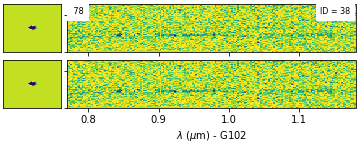

In [35]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

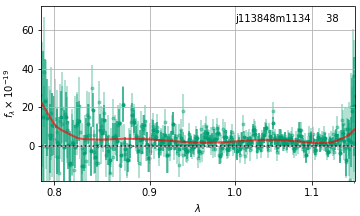

In [36]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

### Redshift fit ###

The redshift fit is performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:


### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

The emission line maps are generated by subtracting the best-fit continuum model, assuming that the direct image is representative of the continuum morphology.  This should be a reasonable assumption for objects other than, perhaps, those with extreme line equivalent widths.


Run 38


(38, 1, 7.174673080444336)

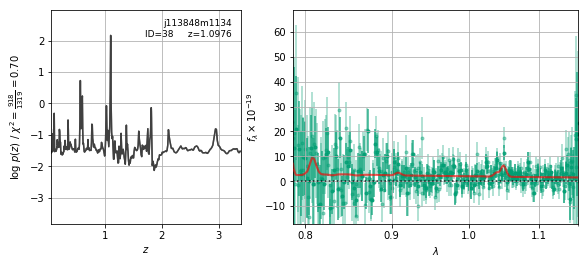

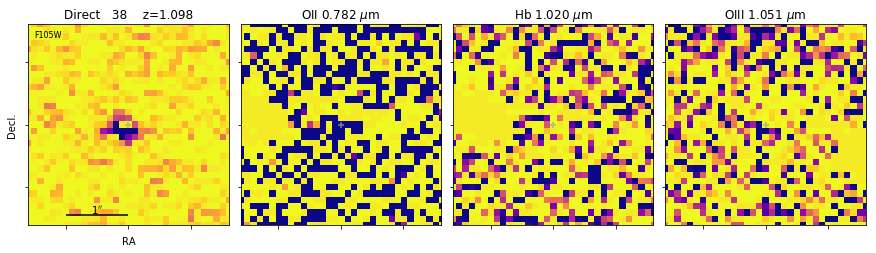

In [37]:
# Fit it.  The "run_all_parallel" function defaults to all of the parameters set in 'fit_args.npy'
fitting.run_all_parallel(id)

### Fit products ###

A number of files are produced that contain the results of the redshift fit.  The [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook describes how to interact with these products in some greater detail.  

In [38]:
files = glob.glob('*{0:05d}*'.format(id))
for file in files:
    print(file)

j113848m1134_00038.full.png
j113848m1134_00038.1D.png
j113848m1134_00038.stack.fits
j113848m1134_00038.1D.fits
j113848m1134_00038.log_par
j113848m1134_00038.beams.fits
j113848m1134_00038.line.png
j113848m1134_00038.stack.png
j113848m1134_00038.full.fits


In [39]:
for file in files:
    if not file.endswith('.fits'):
        continue
        
    im = pyfits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()



j113848m1134_00038.stack.fits


Filename: j113848m1134_00038.stack.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  SCI         G102,78.0 ImageHDU        48   (178, 64)   float32   
  2  WHT         G102,78.0 ImageHDU        22   (178, 64)   float32   
  3  CONTAM      G102,78.0 ImageHDU        22   (178, 64)   float32   
  4  MODEL       G102,78.0 ImageHDU        24   (178, 64)   float32   
  5  KERNEL      G102,78.0 ImageHDU        22   (64, 64)   float32   
  6  SCI         G102 ImageHDU        47   (178, 64)   float32   
  7  WHT         G102 ImageHDU        22   (178, 64)   float32   
  8  MODEL       G102 ImageHDU        24   (178, 64)   float32   
  9  KERNEL      G102 ImageHDU        22   (64, 64)   float32   


j113848m1134_00038.1D.fits


Filename: j113848m1134_00038.1D.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  G102      

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

In [40]:
# Continuum source
id=source_ids[1]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/1: 264 1
j113848m1134_00264.beams.fits


True

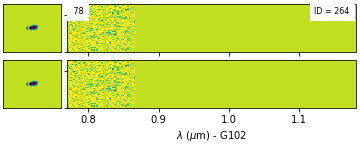

In [41]:
# Stacked 2D spectrum
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

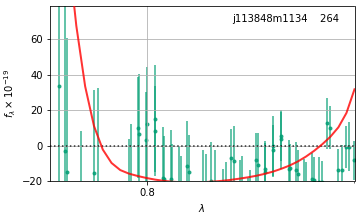

In [42]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

Run 264


(264, 1, 4.082647323608398)

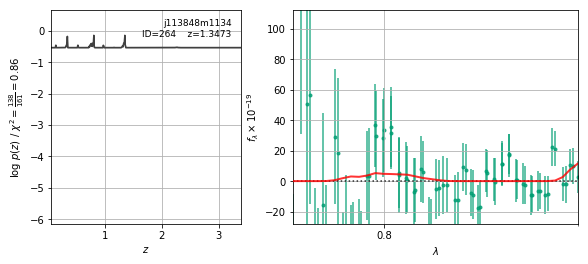

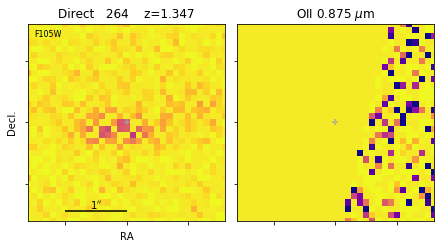

In [43]:
## Run the fit
fitting.run_all_parallel(id)

### Fit grism with photometry

Another option is fitting the grism spectra along with ancillary photometry, described here: [Fit-with-Photometry.ipynb](https://github.com/gbrammer/grizli/blob/master/examples/Fit-with-Photometry.ipynb).